In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting a detached eclipsing binary

In this case study, we'll go through the steps required to fit the light curve and radial velocity measurements for the detached eclipsing binary system HD 23642.
This is a bright system that has been fit by many authors ([1](https://arxiv.org/abs/astro-ph/0403444), [2](https://arxiv.org/abs/astro-ph/0409507), [3](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract), [4](https://arxiv.org/abs/1602.01901), and [5](https://arxiv.org/abs/1603.08484) to name a few) so this is a good benchmark for our demonstration.

The light curve that we'll use is from K2 and we'll use the same radial velocity measurements as [David+ (2016)](https://arxiv.org/abs/1602.01901) compiled from [here](https://arxiv.org/abs/astro-ph/0403444) and [here](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract).
We'll use a somewhat simplified model for the eclipses that treats the stars as spherical and ignores the phase curve (we'll model it using a Gaussian process instead of a more physically motivated model).
But, as you'll see, these simplifying assumptions are sufficient for this case of a detached and well behaved system.
Unlike some previous studies, we will fit an eccentric orbit instead of fixing the eccentricity to zero.
This probably isn't really necessary here, but it's useful to demonstrate how you would fit a more eccentric system.
Finally, we model the phase curve and other triends in both the light curve and radial velocities using Gaussian processes.
This will account for unmodeled stellar variability and residual systematics, drifts, and other effects left over from the data reduction procedure.

## Data access

First, let's define some values from the literature that will be useful below.
Here we're taking the period and eclipse time from [David+ (2016)](https://arxiv.org/abs/1602.01901) as initial guesses for these parameters in our fit.
We'll also include the same prior on the flux ratio of the two stars that was computed for the Kepler bandpass by [David+ (2016)](https://arxiv.org/abs/1602.01901).

In [3]:
lit_period = 2.46113408
lit_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
lit_flux_ratio = (0.354, 0.035)

Then we'll download the Kepler data.
In this case, the pipeline aperture photometry isn't very good (because this star is so bright!) so we'll just download the target pixel file and co-add all the pixels.

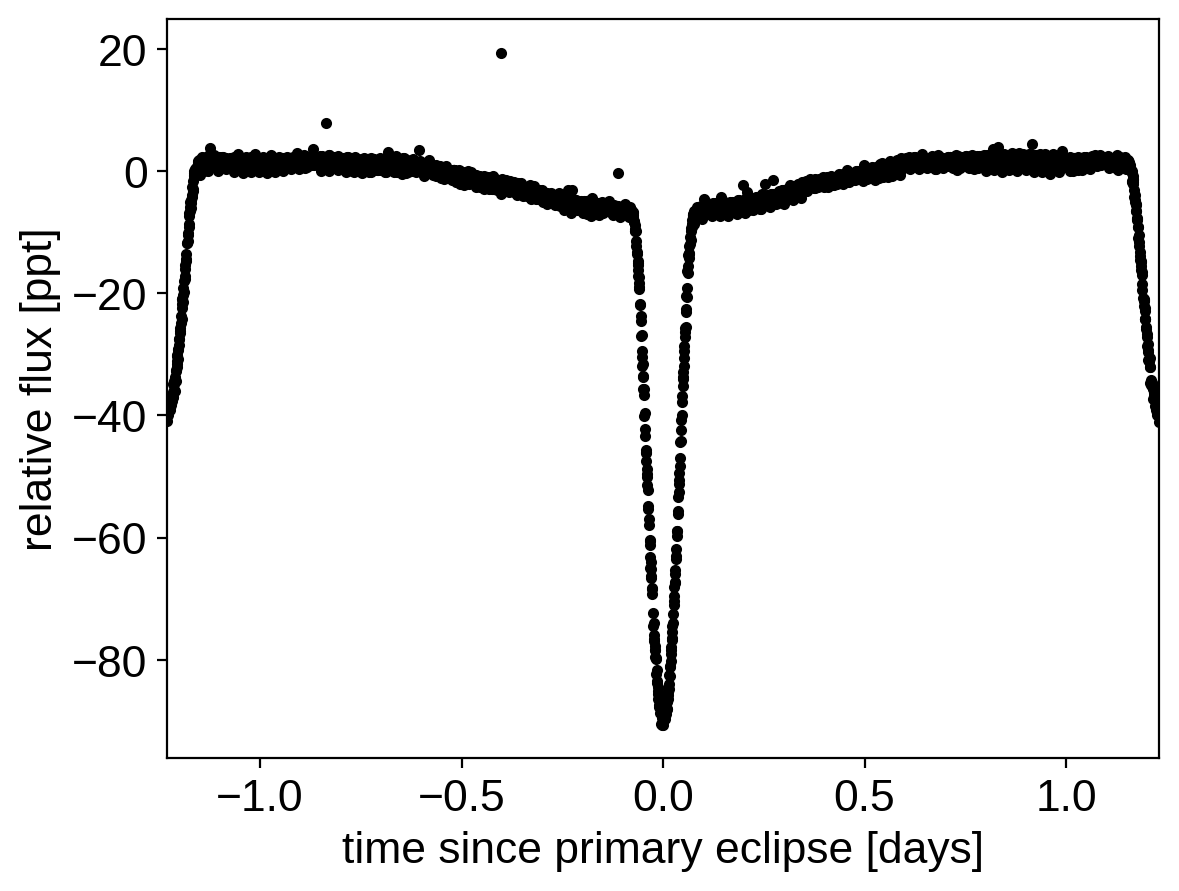

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot((x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k")
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

Then we'll enter the radial velocity data.
I couldn't find these data online anywhere so I manually transcribed the data from the referenced papers (typos are my own!).

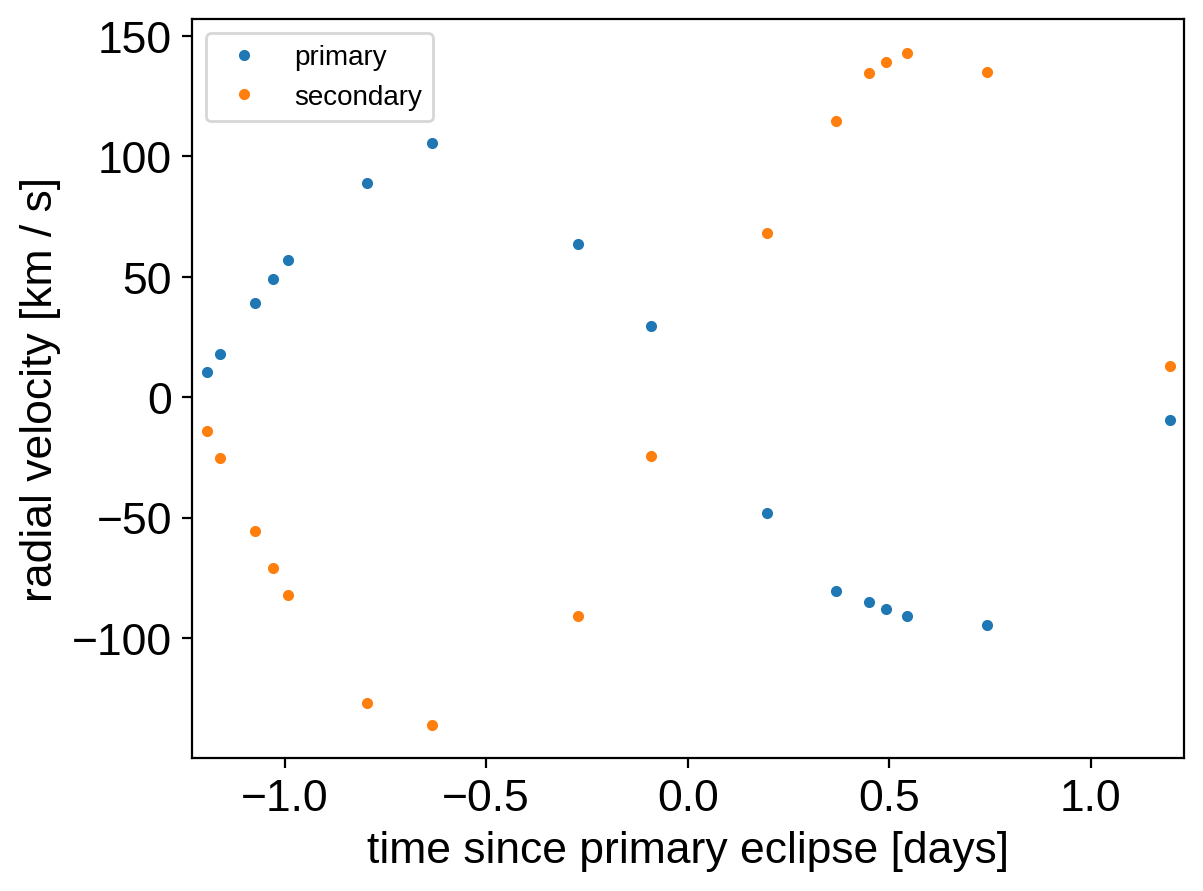

In [5]:
ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

x_rv = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
y1_rv = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
y2_rv = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

fold = (rvs[:, 0] - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
plt.plot(fold, rvs[:, 1], ".", label="primary")
plt.plot(fold, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

## Probabilistic model

Then we define the probabilistic model using PyMC3 and exoplanet.
This is similar to the other tutorials and case studies, but here we're using a :class:`exoplanet.SecondaryEclipseLightCurve` to generate the model light curve and we're modeling the radial velocity trends using a Gaussian process instead of a polynomial.
Otherwise, things should look pretty familiar!

After defining the model, we iteratively clip outliers in the light curve using sigma clipping and then estimate the maximum a posteriori parameters.

In [6]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sigma=10.0)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio

        # Prior on flux ratio
        pm.Normal(
            "flux_prior",
            mu=lit_flux_ratio[0],
            sigma=lit_flux_ratio[1],
            observed=k ** 2 * s,
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = xo.UnitDisk("ecs", testval=np.array([1e-5, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0)
        )
        S_tot_lc = pm.InverseGamma(
            "S_tot_lc", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_lc = pm.InverseGamma(
            "ell_lc", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_lc = xo.gp.terms.SHOTerm(
            S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0 / 3
        )

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        sigma_rv2 = pm.InverseGamma(
            "sigma_rv2", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        S_tot_rv = pm.InverseGamma(
            "S_tot_rv", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_rv = pm.InverseGamma(
            "ell_rv", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_rv = xo.gp.terms.SHOTerm(
            S_tot=S_tot_rv, w0=2 * np.pi / ell_rv, Q=1.0 / 3
        )

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = xo.gp.GP(
            kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=model_lc
        )
        gp_lc.marginal("obs_lc", observed=y[mask])

        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

        def model_rv2(t):
            return mean_rv - 1e-3 * orbit.get_radial_velocity(t) / q

        # Condition the radial velocity model on the data
        gp_rv1 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv1 ** 2, mean=model_rv1
        )
        gp_rv1.marginal("obs_rv1", observed=y1_rv)
        gp_rv2 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv2 ** 2, mean=model_rv2
        )
        gp_rv2.marginal("obs_rv2", observed=y2_rv)

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = xo.optimize(map_soln, [mean_rv, q])
        map_soln = xo.optimize(
            map_soln, [mean_rv, sigma_rv1, sigma_rv2, S_tot_rv, ell_rv]
        )

        # Then the LC parameters
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b])
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b, u1, u2])
        map_soln = xo.optimize(map_soln, [mean_lc, sigma_lc, S_tot_lc, ell_lc])
        map_soln = xo.optimize(map_soln, [t0, period])

        # Then all the parameters together
        map_soln = xo.optimize(map_soln)

        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.gp_rv1 = gp_rv1
        model.model_rv1 = model_rv1
        model.gp_rv2 = gp_rv2
        model.model_rv2 = model_rv2

        model.x = x[mask]
        model.y = y[mask]

    return model, map_soln


def sigma_clip():
    mask = np.ones(len(x), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln = build_model(mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc(x[mask]) + model.gp_lc.predict(), map_soln
            )

        resid = y[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        if num == mask.sum():
            break
        num = mask.sum()

    return model, map_soln


model, map_soln = sigma_clip()

optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.338058e+04]

1it [00:00, 56.33it/s, logp=-2.338058e+04]

2it [00:00, 87.61it/s, logp=-2.338058e+04]

3it [00:00, 108.32it/s, logp=-1.371193e+04]

4it [00:00, 124.84it/s, logp=-1.492576e+04]

5it [00:00, 140.72it/s, logp=-1.358037e+04]

6it [00:00, 153.42it/s, logp=-1.335577e+04]

7it [00:00, 164.02it/s, logp=-1.309819e+04]

8it [00:00, 173.00it/s, logp=-1.307502e+04]

9it [00:00, 180.89it/s, logp=-1.307285e+04]

10it [00:00, 187.86it/s, logp=-1.307282e+04]

11it [00:00, 193.29it/s, logp=-1.307282e+04]

12it [00:00, 198.77it/s, logp=-1.307282e+04]

13it [00:03,  3.74it/s, logp=-1.307282e+04] 


message: Optimization terminated successfully.
logp: -23380.5842277239 -> -13072.816791759677


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.307282e+04]

1it [00:00, 110.55it/s, logp=-1.307282e+04]

2it [00:00, 164.30it/s, logp=-1.307282e+04]

3it [00:00, 191.04it/s, logp=-1.018327e+04]

4it [00:00, 211.03it/s, logp=-8.904144e+03]

5it [00:00, 225.04it/s, logp=-9.241304e+03]

6it [00:00, 237.40it/s, logp=-8.795387e+03]

7it [00:00, 246.02it/s, logp=-8.676354e+03]

8it [00:00, 252.55it/s, logp=-8.648728e+03]

9it [00:00, 258.00it/s, logp=-8.606024e+03]

10it [00:00, 262.28it/s, logp=-8.554461e+03]

11it [00:00, 266.62it/s, logp=-8.728832e+03]

12it [00:00, 271.30it/s, logp=-8.521916e+03]

13it [00:00, 274.37it/s, logp=-8.640295e+03]

14it [00:00, 277.95it/s, logp=-8.512540e+03]

15it [00:00, 280.28it/s, logp=-8.502406e+03]

16it [00:00, 282.16it/s, logp=-8.491012e+03]

17it [00:00, 283.90it/s, logp=-8.499248e+03]

18it [00:00, 286.30it/s, logp=-8.484668e+03]

19it [00:00, 287.75it/s, logp=-8.483864e+03]

20it [00:00, 289.14it/s, logp=-8.483590e+03]

21it [00:00, 290.52it/s, logp=-8.483526e+03]

22it [00:00, 291.48it/s, logp=-8.483507e+03]

23it [00:00, 292.51it/s, logp=-8.483474e+03]

24it [00:00, 293.36it/s, logp=-8.483431e+03]

25it [00:00, 294.27it/s, logp=-8.483410e+03]

26it [00:00, 294.86it/s, logp=-8.483372e+03]

27it [00:00, 295.25it/s, logp=-8.483300e+03]

28it [00:00, 295.91it/s, logp=-8.483172e+03]

29it [00:00, 296.49it/s, logp=-8.482963e+03]

30it [00:00, 297.02it/s, logp=-8.482725e+03]

31it [00:00, 305.22it/s, logp=-8.482725e+03]

31it [00:00, 305.22it/s, logp=-8.482637e+03]

32it [00:00, 305.22it/s, logp=-8.482584e+03]

33it [00:00, 305.22it/s, logp=-8.482577e+03]

34it [00:00, 305.22it/s, logp=-8.482576e+03]

35it [00:00, 305.22it/s, logp=-8.482576e+03]

36it [00:00, 305.22it/s, logp=-8.482576e+03]

37it [00:00, 305.22it/s, logp=-8.482576e+03]

38it [00:00, 305.22it/s, logp=-8.482576e+03]

39it [00:00, 305.22it/s, logp=-8.482576e+03]

40it [00:00, 121.20it/s, logp=-8.482576e+03]


message: Optimization terminated successfully.
logp: -13072.816791759677 -> -8482.576126912147


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.482576e+03]

1it [00:00, 100.92it/s, logp=-8.482576e+03]

2it [00:00, 151.29it/s, logp=-8.482576e+03]

3it [00:00, 145.45it/s, logp=-5.149397e+05]

4it [00:00, 166.45it/s, logp=-6.506637e+03]

5it [00:00, 179.85it/s, logp=-6.295323e+03]

6it [00:00, 190.74it/s, logp=-8.432440e+03]

7it [00:00, 200.01it/s, logp=-6.280288e+03]

8it [00:00, 207.06it/s, logp=-6.518223e+03]

9it [00:00, 213.81it/s, logp=-6.279434e+03]

10it [00:00, 218.84it/s, logp=-6.277711e+03]

11it [00:00, 223.80it/s, logp=-6.270831e+03]

12it [00:00, 228.00it/s, logp=-6.243533e+03]

13it [00:00, 231.72it/s, logp=-6.137904e+03]

14it [00:00, 234.98it/s, logp=-5.772833e+03]

15it [00:00, 237.21it/s, logp=-5.126631e+03]

16it [00:00, 239.18it/s, logp=-4.721592e+03]

17it [00:00, 241.07it/s, logp=-4.706476e+03]

18it [00:00, 242.83it/s, logp=-4.705743e+03]

19it [00:00, 244.45it/s, logp=-4.704374e+03]

20it [00:00, 242.26it/s, logp=-4.701947e+03]

21it [00:00, 233.12it/s, logp=-4.698765e+03]

22it [00:00, 234.51it/s, logp=-4.697345e+03]

23it [00:00, 235.91it/s, logp=-4.696674e+03]

24it [00:00, 237.20it/s, logp=-4.696497e+03]

25it [00:00, 245.69it/s, logp=-4.696497e+03]

25it [00:00, 245.69it/s, logp=-4.696363e+03]

26it [00:00, 245.69it/s, logp=-4.696338e+03]

27it [00:00, 245.69it/s, logp=-4.696334e+03]

28it [00:00, 245.69it/s, logp=-4.696334e+03]

29it [00:00, 245.69it/s, logp=-4.696334e+03]

30it [00:00, 245.69it/s, logp=-4.696334e+03]

31it [00:00, 245.69it/s, logp=-4.696334e+03]

32it [00:00, 245.69it/s, logp=-4.696334e+03]

33it [00:00, 245.69it/s, logp=-4.696334e+03]

34it [00:00, 245.69it/s, logp=-4.696334e+03]

35it [00:00, 245.69it/s, logp=-4.696334e+03]

36it [00:00, 245.69it/s, logp=-4.696334e+03]

37it [00:00, 245.69it/s, logp=-4.696334e+03]

38it [00:00, 245.69it/s, logp=-4.696334e+03]

39it [00:00, 245.69it/s, logp=-4.696334e+03]

40it [00:00, 245.69it/s, logp=-4.696334e+03]

41it [00:00, 245.69it/s, logp=-4.696334e+03]

42it [00:00, 245.69it/s, logp=-4.696334e+03]

43it [00:00, 245.69it/s, logp=-4.696334e+03]

44it [00:00, 245.69it/s, logp=-4.696334e+03]

45it [00:00, 245.69it/s, logp=-4.696334e+03]

46it [00:00, 245.69it/s, logp=-4.696334e+03]

47it [00:00, 245.69it/s, logp=-4.696334e+03]

48it [00:00, 245.69it/s, logp=-4.696334e+03]

49it [00:00, 245.69it/s, logp=-4.696334e+03]

50it [00:00, 245.69it/s, logp=-4.696334e+03]

51it [00:00, 245.69it/s, logp=-4.696334e+03]

52it [00:00, 245.69it/s, logp=-4.696334e+03]

53it [00:00, 245.69it/s, logp=-4.696334e+03]

54it [00:00, 255.20it/s, logp=-4.696334e+03]

54it [00:00, 255.20it/s, logp=-4.696334e+03]

55it [00:00, 255.20it/s, logp=-4.696334e+03]

56it [00:00, 255.20it/s, logp=-4.696334e+03]

57it [00:00, 255.20it/s, logp=-4.696334e+03]

58it [00:00, 255.20it/s, logp=-4.696334e+03]

59it [00:00, 255.20it/s, logp=-4.696334e+03]

60it [00:00, 255.20it/s, logp=-4.696334e+03]

61it [00:00, 255.20it/s, logp=-4.696334e+03]

62it [00:00, 255.20it/s, logp=-4.696334e+03]

63it [00:00, 255.20it/s, logp=-4.696334e+03]

64it [00:00, 255.20it/s, logp=-4.696334e+03]

65it [00:00, 255.20it/s, logp=-4.696334e+03]

66it [00:00, 255.20it/s, logp=-4.696334e+03]

67it [00:00, 255.20it/s, logp=-4.696334e+03]

68it [00:00, 255.20it/s, logp=-4.696334e+03]

69it [00:00, 255.20it/s, logp=-4.696334e+03]

70it [00:00, 255.20it/s, logp=-4.696334e+03]

71it [00:00, 255.20it/s, logp=-4.696334e+03]

72it [00:00, 255.20it/s, logp=-4.696334e+03]

73it [00:00, 255.20it/s, logp=-4.696334e+03]

74it [00:00, 255.20it/s, logp=-4.696334e+03]

75it [00:00, 255.20it/s, logp=-4.696334e+03]

76it [00:00, 255.20it/s, logp=-4.696334e+03]

77it [00:00, 255.20it/s, logp=-4.696334e+03]

78it [00:00, 255.20it/s, logp=-4.696334e+03]

79it [00:00, 255.20it/s, logp=-4.696334e+03]

80it [00:00, 255.20it/s, logp=-4.696334e+03]

81it [00:00, 255.20it/s, logp=-4.696334e+03]

82it [00:00, 262.03it/s, logp=-4.696334e+03]

82it [00:00, 262.03it/s, logp=-4.696334e+03]

83it [00:00, 262.03it/s, logp=-4.696334e+03]

84it [00:00, 262.03it/s, logp=-4.696334e+03]

85it [00:00, 262.03it/s, logp=-4.696334e+03]

86it [00:00, 262.03it/s, logp=-4.696334e+03]

87it [00:00, 262.03it/s, logp=-4.696334e+03]

88it [00:00, 262.03it/s, logp=-4.696334e+03]

89it [00:00, 262.03it/s, logp=-4.696334e+03]

90it [00:00, 262.03it/s, logp=-4.696334e+03]

91it [00:00, 262.03it/s, logp=-4.696334e+03]

92it [00:00, 262.03it/s, logp=-4.696334e+03]

93it [00:00, 262.03it/s, logp=-4.696334e+03]

94it [00:00, 262.03it/s, logp=-4.696334e+03]

95it [00:00, 262.03it/s, logp=-4.696334e+03]

96it [00:00, 262.03it/s, logp=-4.696334e+03]

97it [00:00, 262.03it/s, logp=-4.696334e+03]

98it [00:00, 262.03it/s, logp=-4.696334e+03]

99it [00:00, 262.03it/s, logp=-4.696334e+03]

100it [00:00, 226.36it/s, logp=-4.696334e+03]

100it [00:00, 226.36it/s, logp=-4.696334e+03]

101it [00:00, 226.36it/s, logp=-4.696334e+03]

102it [00:00, 226.36it/s, logp=-4.696334e+03]

103it [00:00, 226.36it/s, logp=-4.696334e+03]

104it [00:00, 226.36it/s, logp=-4.696334e+03]

105it [00:00, 226.36it/s, logp=-4.696334e+03]

106it [00:00, 226.36it/s, logp=-4.696334e+03]

107it [00:00, 226.36it/s, logp=-4.696334e+03]

108it [00:00, 226.36it/s, logp=-4.696334e+03]

109it [00:00, 226.36it/s, logp=-4.696334e+03]

110it [00:00, 226.36it/s, logp=-4.696334e+03]

111it [00:00, 226.36it/s, logp=-4.696334e+03]

112it [00:00, 226.36it/s, logp=-4.696334e+03]

113it [00:00, 226.36it/s, logp=-4.696334e+03]

114it [00:00, 226.36it/s, logp=-4.696334e+03]

115it [00:00, 226.36it/s, logp=-4.696334e+03]

116it [00:00, 226.36it/s, logp=-4.696334e+03]

117it [00:00, 226.36it/s, logp=-4.696334e+03]

118it [00:00, 226.36it/s, logp=-4.696334e+03]

119it [00:00, 226.36it/s, logp=-4.696334e+03]

120it [00:00, 226.36it/s, logp=-4.696334e+03]

121it [00:00, 226.36it/s, logp=-4.696334e+03]

122it [00:00, 226.36it/s, logp=-4.696334e+03]

123it [00:00, 226.36it/s, logp=-4.696334e+03]

124it [00:00, 173.44it/s, logp=-4.696334e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -8482.576126912147 -> -4696.333901223958


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.696334e+03]

1it [00:00, 113.57it/s, logp=-4.696334e+03]

2it [00:00, 159.90it/s, logp=-4.696334e+03]

3it [00:00, 181.88it/s, logp=-5.266522e+03]

4it [00:00, 190.45it/s, logp=-4.696285e+03]

5it [00:00, 201.03it/s, logp=-4.696208e+03]

6it [00:00, 208.36it/s, logp=-4.696085e+03]

7it [00:00, 214.15it/s, logp=-4.695851e+03]

8it [00:00, 218.71it/s, logp=-4.696596e+03]

9it [00:00, 223.35it/s, logp=-4.695792e+03]

10it [00:00, 226.19it/s, logp=-4.695675e+03]

11it [00:00, 229.17it/s, logp=-4.695293e+03]

12it [00:00, 230.54it/s, logp=-4.694554e+03]

13it [00:00, 232.56it/s, logp=-4.695767e+03]

14it [00:00, 234.99it/s, logp=-4.694425e+03]

15it [00:00, 235.46it/s, logp=-4.694339e+03]

16it [00:00, 236.75it/s, logp=-4.694232e+03]

17it [00:00, 237.69it/s, logp=-4.694198e+03]

18it [00:00, 239.01it/s, logp=-4.694178e+03]

19it [00:00, 239.85it/s, logp=-4.694142e+03]

20it [00:00, 240.84it/s, logp=-4.694100e+03]

21it [00:00, 241.11it/s, logp=-4.694084e+03]

22it [00:00, 241.60it/s, logp=-4.694061e+03]

23it [00:00, 242.41it/s, logp=-4.694049e+03]

24it [00:00, 242.48it/s, logp=-4.694048e+03]

25it [00:00, 242.99it/s, logp=-4.694048e+03]

26it [00:00, 251.19it/s, logp=-4.694048e+03]

26it [00:00, 251.19it/s, logp=-4.694048e+03]

27it [00:00, 251.19it/s, logp=-4.694047e+03]

28it [00:00, 251.19it/s, logp=-4.694047e+03]

29it [00:00, 251.19it/s, logp=-4.694047e+03]

30it [00:00, 251.19it/s, logp=-4.694047e+03]

31it [00:00, 251.19it/s, logp=-4.694047e+03]

32it [00:00, 251.19it/s, logp=-4.694047e+03]

33it [00:00, 251.19it/s, logp=-4.694047e+03]

34it [00:00, 251.19it/s, logp=-4.694047e+03]

35it [00:00, 251.19it/s, logp=-4.694047e+03]

36it [00:00, 251.19it/s, logp=-4.694047e+03]

37it [00:00, 109.56it/s, logp=-4.694047e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4696.333901223958 -> -4694.047160949973


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.694047e+03]

1it [00:00, 110.01it/s, logp=-4.694047e+03]

2it [00:00, 155.66it/s, logp=-4.694047e+03]

3it [00:00, 171.81it/s, logp=-4.091963e+03]

4it [00:00, 185.38it/s, logp=-4.280016e+03]

5it [00:00, 193.89it/s, logp=-3.863964e+03]

6it [00:00, 202.84it/s, logp=-4.035171e+03]

7it [00:00, 211.05it/s, logp=-3.815387e+03]

8it [00:00, 216.93it/s, logp=-3.732561e+03]

9it [00:00, 222.02it/s, logp=-3.643583e+03]

10it [00:00, 226.39it/s, logp=-3.640566e+03]

11it [00:00, 229.77it/s, logp=-3.640513e+03]

12it [00:00, 233.02it/s, logp=-3.640460e+03]

13it [00:00, 235.93it/s, logp=-3.640456e+03]

14it [00:00, 238.15it/s, logp=-3.640456e+03]

15it [00:00, 240.24it/s, logp=-3.640456e+03]

16it [00:00, 241.84it/s, logp=-3.640456e+03]

17it [00:00, 243.51it/s, logp=-3.640456e+03]

18it [00:00, 245.23it/s, logp=-3.640456e+03]

19it [00:00, 246.83it/s, logp=-3.640456e+03]

20it [00:00, 76.01it/s, logp=-3.640456e+03] 


message: Optimization terminated successfully.
logp: -4694.047160949972 -> -3640.455503590622


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.640456e+03]

1it [00:00, 116.42it/s, logp=-3.640456e+03]

2it [00:00, 162.26it/s, logp=-3.640456e+03]

3it [00:00, 188.58it/s, logp=-5.272996e+05]

4it [00:00, 205.02it/s, logp=-8.066815e+05]

5it [00:00, 215.32it/s, logp=-1.581529e+05]

6it [00:00, 223.65it/s, logp=-3.640842e+03]

7it [00:00, 229.87it/s, logp=-3.639294e+03]

8it [00:00, 233.75it/s, logp=-3.637487e+03]

9it [00:00, 236.00it/s, logp=-3.636741e+03]

10it [00:00, 239.93it/s, logp=-3.636741e+03]

11it [00:00, 242.27it/s, logp=-3.636741e+03]

12it [00:00, 244.84it/s, logp=-3.636741e+03]

13it [00:00, 247.30it/s, logp=-3.636741e+03]

14it [00:00, 249.80it/s, logp=-3.636741e+03]

15it [00:00, 251.78it/s, logp=-3.636741e+03]

16it [00:00, 253.35it/s, logp=-3.636741e+03]

17it [00:00, 254.86it/s, logp=-3.636741e+03]

18it [00:00, 256.18it/s, logp=-3.636741e+03]

19it [00:00, 257.51it/s, logp=-3.636741e+03]

20it [00:00, 258.86it/s, logp=-3.636741e+03]

21it [00:00, 260.05it/s, logp=-3.636741e+03]

22it [00:00, 260.47it/s, logp=-3.636741e+03]

23it [00:00, 261.48it/s, logp=-3.636741e+03]

24it [00:00, 262.47it/s, logp=-3.636741e+03]

25it [00:00, 263.18it/s, logp=-3.636741e+03]

26it [00:00, 264.05it/s, logp=-3.636741e+03]

27it [00:00, 264.67it/s, logp=-3.636741e+03]

28it [00:00, 272.43it/s, logp=-3.636741e+03]

28it [00:00, 272.43it/s, logp=-3.636741e+03]

29it [00:00, 272.43it/s, logp=-3.636741e+03]

30it [00:00, 272.43it/s, logp=-3.636741e+03]

31it [00:00, 272.43it/s, logp=-3.636741e+03]

32it [00:00, 272.43it/s, logp=-3.636741e+03]

33it [00:00, 272.43it/s, logp=-3.636741e+03]

34it [00:00, 272.43it/s, logp=-3.636741e+03]

35it [00:00, 272.43it/s, logp=-3.636741e+03]

36it [00:00, 272.43it/s, logp=-3.636741e+03]

37it [00:00, 272.43it/s, logp=-3.636741e+03]

38it [00:00, 272.43it/s, logp=-3.636741e+03]

39it [00:00, 272.43it/s, logp=-3.636741e+03]

40it [00:00, 272.43it/s, logp=-3.636741e+03]

41it [00:00, 272.43it/s, logp=-3.636741e+03]

42it [00:00, 272.43it/s, logp=-3.636741e+03]

43it [00:00, 272.43it/s, logp=-3.636741e+03]

44it [00:00, 272.43it/s, logp=-3.636741e+03]

45it [00:00, 272.43it/s, logp=-3.636741e+03]

46it [00:00, 272.43it/s, logp=-3.636741e+03]

47it [00:00, 272.43it/s, logp=-3.636741e+03]

48it [00:00, 272.43it/s, logp=-3.636741e+03]

49it [00:00, 272.43it/s, logp=-3.636741e+03]

50it [00:00, 272.43it/s, logp=-3.636741e+03]

51it [00:00, 272.43it/s, logp=-3.636741e+03]

52it [00:00, 272.43it/s, logp=-3.636741e+03]

53it [00:00, 272.43it/s, logp=-3.636741e+03]

54it [00:00, 272.43it/s, logp=-3.636741e+03]

55it [00:00, 269.64it/s, logp=-3.636741e+03]

55it [00:00, 269.64it/s, logp=-3.636741e+03]

56it [00:00, 269.64it/s, logp=-3.636741e+03]

57it [00:00, 269.64it/s, logp=-3.636741e+03]

58it [00:00, 269.64it/s, logp=-3.636741e+03]

59it [00:00, 269.64it/s, logp=-3.636741e+03]

60it [00:00, 269.64it/s, logp=-3.636741e+03]

61it [00:00, 269.64it/s, logp=-3.636741e+03]

62it [00:00, 269.64it/s, logp=-3.636741e+03]

63it [00:00, 269.64it/s, logp=-3.636741e+03]

64it [00:00, 269.64it/s, logp=-3.636741e+03]

65it [00:00, 269.64it/s, logp=-3.636741e+03]

66it [00:00, 269.64it/s, logp=-3.636741e+03]

67it [00:00, 269.64it/s, logp=-3.636741e+03]

68it [00:00, 269.64it/s, logp=-3.636741e+03]

69it [00:00, 269.64it/s, logp=-3.636741e+03]

70it [00:00, 269.64it/s, logp=-3.636741e+03]

71it [00:00, 269.64it/s, logp=-3.636741e+03]

72it [00:00, 269.64it/s, logp=-3.636741e+03]

73it [00:00, 269.64it/s, logp=-3.636741e+03]

74it [00:00, 269.64it/s, logp=-3.636741e+03]

75it [00:00, 269.64it/s, logp=-3.636741e+03]

76it [00:00, 269.64it/s, logp=-3.636741e+03]

77it [00:00, 269.64it/s, logp=-3.636741e+03]

78it [00:00, 269.64it/s, logp=-3.636741e+03]

79it [00:00, 269.64it/s, logp=-3.636741e+03]

80it [00:00, 269.64it/s, logp=-3.636741e+03]

81it [00:00, 269.64it/s, logp=-3.636741e+03]

82it [00:00, 269.64it/s, logp=-3.636741e+03]

83it [00:00, 272.10it/s, logp=-3.636741e+03]

83it [00:00, 159.32it/s, logp=-3.636741e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3640.455503590622 -> -3636.7412339176194


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.636741e+03]

1it [00:00, 86.25it/s, logp=-3.636741e+03]

2it [00:00, 124.05it/s, logp=-3.636741e+03]

3it [00:00, 148.17it/s, logp=-3.043195e+05]

4it [00:00, 162.00it/s, logp=-1.288601e+04]

5it [00:00, 134.41it/s, logp=-3.634429e+03]

6it [00:00, 128.81it/s, logp=-3.796121e+03]

7it [00:00, 131.61it/s, logp=-3.634397e+03]

8it [00:00, 134.65it/s, logp=-3.634334e+03]

9it [00:00, 139.75it/s, logp=-3.634129e+03]

10it [00:00, 143.73it/s, logp=-3.633595e+03]

11it [00:00, 148.82it/s, logp=-3.631611e+03]

12it [00:00, 152.55it/s, logp=-3.628537e+03]

13it [00:00, 155.84it/s, logp=-3.730931e+03]

14it [00:00, 159.27it/s, logp=-3.628449e+03]

15it [00:00, 161.94it/s, logp=-3.628272e+03]

16it [00:00, 164.73it/s, logp=-3.627592e+03]

17it [00:00, 167.30it/s, logp=-3.625312e+03]

18it [00:00, 176.18it/s, logp=-3.625312e+03]

18it [00:00, 176.18it/s, logp=-3.621902e+03]

19it [00:00, 176.18it/s, logp=-3.617198e+03]

20it [00:00, 176.18it/s, logp=-3.618668e+03]

21it [00:00, 176.18it/s, logp=-3.616239e+03]

22it [00:00, 176.18it/s, logp=-3.616822e+03]

23it [00:00, 176.18it/s, logp=-3.613201e+03]

24it [00:00, 176.18it/s, logp=-3.609646e+03]

25it [00:00, 176.18it/s, logp=-3.607757e+03]

26it [00:00, 176.18it/s, logp=-3.605633e+03]

27it [00:00, 176.18it/s, logp=-3.605689e+03]

28it [00:00, 176.18it/s, logp=-3.604626e+03]

29it [00:00, 176.18it/s, logp=-3.603889e+03]

30it [00:00, 176.18it/s, logp=-3.602777e+03]

31it [00:00, 176.18it/s, logp=-3.601632e+03]

32it [00:00, 176.18it/s, logp=-3.599717e+03]

33it [00:00, 176.18it/s, logp=-3.600946e+03]

34it [00:00, 176.18it/s, logp=-3.599044e+03]

35it [00:00, 176.18it/s, logp=-3.597968e+03]

36it [00:00, 176.18it/s, logp=-3.596573e+03]

37it [00:00, 176.18it/s, logp=-3.599147e+03]

38it [00:00, 176.18it/s, logp=-3.596157e+03]

39it [00:00, 176.18it/s, logp=-3.595596e+03]

40it [00:00, 186.16it/s, logp=-3.595596e+03]

40it [00:00, 186.16it/s, logp=-3.594818e+03]

41it [00:00, 186.16it/s, logp=-3.593950e+03]

42it [00:00, 186.16it/s, logp=-3.592641e+03]

43it [00:00, 186.16it/s, logp=-3.591794e+03]

44it [00:00, 186.16it/s, logp=-3.590292e+03]

45it [00:00, 186.16it/s, logp=-3.588090e+03]

46it [00:00, 186.16it/s, logp=-3.591637e+03]

47it [00:00, 186.16it/s, logp=-3.587103e+03]

48it [00:00, 186.16it/s, logp=-3.585455e+03]

49it [00:00, 186.16it/s, logp=-3.582510e+03]

50it [00:00, 186.16it/s, logp=-3.577385e+03]

51it [00:00, 186.16it/s, logp=-3.571649e+03]

52it [00:00, 186.16it/s, logp=-3.568911e+03]

53it [00:00, 186.16it/s, logp=-3.564258e+03]

54it [00:00, 186.16it/s, logp=-3.560701e+03]

55it [00:00, 186.16it/s, logp=-3.555892e+03]

56it [00:00, 186.16it/s, logp=-3.553606e+03]

57it [00:00, 186.16it/s, logp=-3.550501e+03]

58it [00:00, 186.16it/s, logp=-3.549156e+03]

59it [00:00, 186.16it/s, logp=-3.547197e+03]

60it [00:00, 186.16it/s, logp=-3.545442e+03]

61it [00:00, 186.16it/s, logp=-3.543941e+03]

62it [00:00, 192.87it/s, logp=-3.543941e+03]

62it [00:00, 192.87it/s, logp=-3.542573e+03]

63it [00:00, 192.87it/s, logp=-3.540919e+03]

64it [00:00, 192.87it/s, logp=-3.540399e+03]

65it [00:00, 192.87it/s, logp=-3.540131e+03]

66it [00:00, 192.87it/s, logp=-3.539825e+03]

67it [00:00, 192.87it/s, logp=-3.539741e+03]

68it [00:00, 192.87it/s, logp=-3.539681e+03]

69it [00:00, 192.87it/s, logp=-3.539643e+03]

70it [00:00, 192.87it/s, logp=-3.539598e+03]

71it [00:00, 192.87it/s, logp=-3.539556e+03]

72it [00:00, 192.87it/s, logp=-3.539533e+03]

73it [00:00, 192.87it/s, logp=-3.539519e+03]

74it [00:00, 192.87it/s, logp=-3.539509e+03]

75it [00:00, 192.87it/s, logp=-3.539497e+03]

76it [00:00, 192.87it/s, logp=-3.539480e+03]

77it [00:00, 192.87it/s, logp=-3.539468e+03]

78it [00:00, 192.87it/s, logp=-3.539461e+03]

79it [00:00, 192.87it/s, logp=-3.539457e+03]

80it [00:00, 192.87it/s, logp=-3.539454e+03]

81it [00:00, 192.87it/s, logp=-3.539451e+03]

82it [00:00, 192.87it/s, logp=-3.539448e+03]

83it [00:00, 192.87it/s, logp=-3.539443e+03]

84it [00:00, 197.69it/s, logp=-3.539443e+03]

84it [00:00, 197.69it/s, logp=-3.539439e+03]

85it [00:00, 197.69it/s, logp=-3.539437e+03]

86it [00:00, 197.69it/s, logp=-3.539435e+03]

87it [00:00, 197.69it/s, logp=-3.539434e+03]

88it [00:00, 197.69it/s, logp=-3.539433e+03]

89it [00:00, 197.69it/s, logp=-3.539432e+03]

90it [00:00, 197.69it/s, logp=-3.539432e+03]

91it [00:00, 197.69it/s, logp=-3.539431e+03]

92it [00:00, 197.69it/s, logp=-3.539431e+03]

93it [00:00, 197.69it/s, logp=-3.539431e+03]

94it [00:00, 197.69it/s, logp=-3.539431e+03]

95it [00:00, 197.69it/s, logp=-3.539431e+03]

96it [00:00, 197.69it/s, logp=-3.539431e+03]

97it [00:00, 197.69it/s, logp=-3.539431e+03]

98it [00:00, 197.69it/s, logp=-3.539431e+03]

99it [00:00, 197.69it/s, logp=-3.539431e+03]

100it [00:00, 197.69it/s, logp=-3.539431e+03]

101it [00:00, 197.69it/s, logp=-3.539431e+03]

102it [00:00, 197.69it/s, logp=-3.539431e+03]

103it [00:00, 197.69it/s, logp=-3.539431e+03]

104it [00:00, 197.69it/s, logp=-3.539431e+03]

105it [00:00, 197.69it/s, logp=-3.539431e+03]

106it [00:00, 202.14it/s, logp=-3.539431e+03]

106it [00:00, 202.14it/s, logp=-3.539431e+03]

107it [00:00, 202.14it/s, logp=-3.539431e+03]

108it [00:00, 202.14it/s, logp=-3.539431e+03]

109it [00:00, 202.14it/s, logp=-3.539431e+03]

110it [00:00, 202.14it/s, logp=-3.539431e+03]

111it [00:00, 202.14it/s, logp=-3.539431e+03]

112it [00:00, 202.14it/s, logp=-3.539431e+03]

113it [00:00, 202.14it/s, logp=-3.539431e+03]

114it [00:00, 202.14it/s, logp=-3.539431e+03]

115it [00:00, 202.14it/s, logp=-3.539431e+03]

116it [00:00, 202.14it/s, logp=-3.539431e+03]

117it [00:00, 202.14it/s, logp=-3.539431e+03]

118it [00:00, 202.14it/s, logp=-3.539431e+03]

119it [00:00, 202.14it/s, logp=-3.539431e+03]

120it [00:00, 202.14it/s, logp=-3.539431e+03]

121it [00:00, 202.14it/s, logp=-3.539431e+03]

122it [00:00, 202.14it/s, logp=-3.539431e+03]

123it [00:00, 202.14it/s, logp=-3.539431e+03]

124it [00:00, 202.14it/s, logp=-3.539431e+03]

125it [00:00, 202.14it/s, logp=-3.539431e+03]

126it [00:00, 202.14it/s, logp=-3.539431e+03]

127it [00:00, 202.14it/s, logp=-3.539431e+03]

128it [00:00, 202.14it/s, logp=-3.539431e+03]

129it [00:00, 208.22it/s, logp=-3.539431e+03]

129it [00:00, 208.22it/s, logp=-3.539431e+03]

130it [00:00, 208.22it/s, logp=-3.539431e+03]

131it [00:00, 208.22it/s, logp=-3.539431e+03]

132it [00:00, 208.22it/s, logp=-3.539431e+03]

133it [00:00, 208.22it/s, logp=-3.539431e+03]

134it [00:00, 208.22it/s, logp=-3.539431e+03]

135it [00:00, 208.22it/s, logp=-3.539431e+03]

136it [00:00, 208.22it/s, logp=-3.539431e+03]

137it [00:00, 208.22it/s, logp=-3.539431e+03]

138it [00:00, 208.22it/s, logp=-3.539431e+03]

139it [00:00, 208.22it/s, logp=-3.539431e+03]

140it [00:00, 208.22it/s, logp=-3.539431e+03]

141it [00:00, 208.22it/s, logp=-3.539431e+03]

142it [00:00, 208.22it/s, logp=-3.539431e+03]

143it [00:00, 208.22it/s, logp=-3.539431e+03]

144it [00:00, 208.22it/s, logp=-3.539431e+03]

145it [00:00, 208.22it/s, logp=-3.539431e+03]

146it [00:00, 208.22it/s, logp=-3.539431e+03]

147it [00:00, 208.22it/s, logp=-3.539431e+03]

148it [00:00, 208.22it/s, logp=-3.539431e+03]

149it [00:00, 208.22it/s, logp=-3.539431e+03]

150it [00:00, 208.22it/s, logp=-3.539431e+03]

151it [00:00, 208.22it/s, logp=-3.539431e+03]

152it [00:00, 213.38it/s, logp=-3.539431e+03]

152it [00:00, 213.38it/s, logp=-3.539431e+03]

153it [00:00, 213.38it/s, logp=-3.539431e+03]

154it [00:00, 213.38it/s, logp=-3.539431e+03]

155it [00:00, 213.38it/s, logp=-3.539431e+03]

156it [00:00, 213.38it/s, logp=-3.539431e+03]

157it [00:00, 213.38it/s, logp=-3.539431e+03]

158it [00:00, 213.38it/s, logp=-3.539431e+03]

159it [00:00, 213.38it/s, logp=-3.539431e+03]

160it [00:00, 213.38it/s, logp=-3.539431e+03]

161it [00:00, 213.38it/s, logp=-3.539431e+03]

162it [00:00, 213.38it/s, logp=-3.539431e+03]

163it [00:00, 213.38it/s, logp=-3.539431e+03]

164it [00:00, 213.38it/s, logp=-3.539431e+03]

165it [00:00, 213.38it/s, logp=-3.539431e+03]

166it [00:00, 213.38it/s, logp=-3.539431e+03]

167it [00:00, 213.38it/s, logp=-3.539431e+03]

168it [00:00, 213.38it/s, logp=-3.539431e+03]

169it [00:00, 213.38it/s, logp=-3.539431e+03]

170it [00:00, 213.38it/s, logp=-3.539431e+03]

171it [00:00, 213.38it/s, logp=-3.539431e+03]

172it [00:00, 213.38it/s, logp=-3.539431e+03]

173it [00:00, 191.82it/s, logp=-3.539431e+03]

173it [00:00, 191.82it/s, logp=-3.539431e+03]

174it [00:00, 191.82it/s, logp=-3.539431e+03]

175it [00:00, 191.82it/s, logp=-3.539431e+03]

176it [00:00, 191.82it/s, logp=-3.539431e+03]

177it [00:00, 191.82it/s, logp=-3.539431e+03]

178it [00:01, 164.38it/s, logp=-3.539431e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3636.7412339176194 -> -3539.430818773797


Sigma clipped 34 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296524e+04]

1it [00:00, 133.44it/s, logp=-2.296524e+04]

2it [00:00, 185.70it/s, logp=-2.296524e+04]

3it [00:00, 205.54it/s, logp=-1.333722e+04]

4it [00:00, 219.08it/s, logp=-1.455397e+04]

5it [00:00, 232.52it/s, logp=-1.320793e+04]

6it [00:00, 240.85it/s, logp=-1.298730e+04]

7it [00:00, 244.72it/s, logp=-1.273541e+04]

8it [00:00, 249.69it/s, logp=-1.271302e+04]

9it [00:00, 252.04it/s, logp=-1.271097e+04]

10it [00:00, 256.23it/s, logp=-1.271094e+04]

11it [00:00, 259.23it/s, logp=-1.271094e+04]

12it [00:00, 261.88it/s, logp=-1.271094e+04]

13it [00:00, 58.20it/s, logp=-1.271094e+04] 


message: Optimization terminated successfully.
logp: -22965.237266602366 -> -12710.941974601861


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.271094e+04]

1it [00:00, 127.78it/s, logp=-1.271094e+04]

2it [00:00, 181.68it/s, logp=-1.271094e+04]

3it [00:00, 209.68it/s, logp=-9.834681e+03]

4it [00:00, 227.60it/s, logp=-8.569747e+03]

5it [00:00, 240.30it/s, logp=-8.906056e+03]

6it [00:00, 251.92it/s, logp=-8.455838e+03]

7it [00:00, 258.90it/s, logp=-8.333622e+03]

8it [00:00, 264.96it/s, logp=-8.307411e+03]

9it [00:00, 269.15it/s, logp=-8.266064e+03]

10it [00:00, 273.39it/s, logp=-8.210169e+03]

11it [00:00, 276.45it/s, logp=-8.683512e+03]

12it [00:00, 280.59it/s, logp=-8.181864e+03]

13it [00:00, 282.84it/s, logp=-8.290542e+03]

14it [00:00, 285.75it/s, logp=-8.171624e+03]

15it [00:00, 287.66it/s, logp=-8.161579e+03]

16it [00:00, 289.06it/s, logp=-8.150758e+03]

17it [00:00, 290.73it/s, logp=-8.156182e+03]

18it [00:00, 292.88it/s, logp=-8.144184e+03]

19it [00:00, 294.12it/s, logp=-8.143264e+03]

20it [00:00, 294.89it/s, logp=-8.142909e+03]

21it [00:00, 291.97it/s, logp=-8.142839e+03]

22it [00:00, 292.82it/s, logp=-8.142813e+03]

23it [00:00, 293.91it/s, logp=-8.142774e+03]

24it [00:00, 294.86it/s, logp=-8.142746e+03]

25it [00:00, 295.54it/s, logp=-8.142727e+03]

26it [00:00, 296.54it/s, logp=-8.142691e+03]

27it [00:00, 297.45it/s, logp=-8.142627e+03]

28it [00:00, 298.14it/s, logp=-8.142511e+03]

29it [00:00, 298.63it/s, logp=-8.142321e+03]

30it [00:00, 299.33it/s, logp=-8.142082e+03]

31it [00:00, 307.60it/s, logp=-8.142082e+03]

31it [00:00, 307.60it/s, logp=-8.141985e+03]

32it [00:00, 307.60it/s, logp=-8.141917e+03]

33it [00:00, 307.60it/s, logp=-8.141908e+03]

34it [00:00, 307.60it/s, logp=-8.141907e+03]

35it [00:00, 307.60it/s, logp=-8.141907e+03]

36it [00:00, 307.60it/s, logp=-8.141907e+03]

37it [00:00, 307.60it/s, logp=-8.141907e+03]

38it [00:00, 307.60it/s, logp=-8.141907e+03]

39it [00:00, 307.60it/s, logp=-8.141907e+03]

40it [00:00, 127.97it/s, logp=-8.141907e+03]


message: Optimization terminated successfully.
logp: -12710.941974601868 -> -8141.907237100719


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.141907e+03]

1it [00:00, 132.89it/s, logp=-8.141907e+03]

2it [00:00, 182.23it/s, logp=-8.141907e+03]

3it [00:00, 166.35it/s, logp=-5.073523e+05]

4it [00:00, 185.83it/s, logp=-6.154715e+03]

5it [00:00, 197.60it/s, logp=-5.982095e+03]

6it [00:00, 206.70it/s, logp=-7.495587e+03]

7it [00:00, 214.74it/s, logp=-5.967850e+03]

8it [00:00, 220.14it/s, logp=-6.356190e+03]

9it [00:00, 225.42it/s, logp=-5.967355e+03]

10it [00:00, 229.18it/s, logp=-5.966356e+03]

11it [00:00, 233.21it/s, logp=-5.962363e+03]

12it [00:00, 235.48it/s, logp=-5.946468e+03]

13it [00:00, 238.31it/s, logp=-5.884096e+03]

14it [00:00, 241.05it/s, logp=-5.654050e+03]

15it [00:00, 242.79it/s, logp=-5.149130e+03]

16it [00:00, 244.10it/s, logp=-4.463215e+03]

17it [00:00, 244.73it/s, logp=-4.380013e+03]

18it [00:00, 245.81it/s, logp=-4.378913e+03]

19it [00:00, 246.93it/s, logp=-4.377478e+03]

20it [00:00, 247.56it/s, logp=-4.375465e+03]

21it [00:00, 248.41it/s, logp=-4.373541e+03]

22it [00:00, 248.97it/s, logp=-4.370832e+03]

23it [00:00, 249.73it/s, logp=-4.369620e+03]

24it [00:00, 250.56it/s, logp=-4.369172e+03]

25it [00:00, 251.25it/s, logp=-4.368994e+03]

26it [00:00, 259.89it/s, logp=-4.368994e+03]

26it [00:00, 259.89it/s, logp=-4.368970e+03]

27it [00:00, 259.89it/s, logp=-4.368968e+03]

28it [00:00, 259.89it/s, logp=-4.368968e+03]

29it [00:00, 259.89it/s, logp=-4.368968e+03]

30it [00:00, 259.89it/s, logp=-4.368968e+03]

31it [00:00, 259.89it/s, logp=-4.368968e+03]

32it [00:00, 259.89it/s, logp=-4.368968e+03]

33it [00:00, 46.02it/s, logp=-4.368968e+03] 


message: Optimization terminated successfully.
logp: -8141.907237100712 -> -4368.968064606436


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.368968e+03]

1it [00:00, 115.25it/s, logp=-4.368968e+03]

2it [00:00, 160.69it/s, logp=-4.368968e+03]

3it [00:00, 181.95it/s, logp=-4.925817e+03]

4it [00:00, 195.43it/s, logp=-4.368910e+03]

5it [00:00, 204.76it/s, logp=-4.368821e+03]

6it [00:00, 210.36it/s, logp=-4.368679e+03]

7it [00:00, 213.84it/s, logp=-4.368408e+03]

8it [00:00, 216.51it/s, logp=-4.369753e+03]

9it [00:00, 221.37it/s, logp=-4.368352e+03]

10it [00:00, 222.82it/s, logp=-4.368240e+03]

11it [00:00, 226.87it/s, logp=-4.367874e+03]

12it [00:00, 229.00it/s, logp=-4.367134e+03]

13it [00:00, 230.47it/s, logp=-4.368933e+03]

14it [00:00, 232.79it/s, logp=-4.367009e+03]

15it [00:00, 233.72it/s, logp=-4.366864e+03]

16it [00:00, 234.28it/s, logp=-4.366763e+03]

17it [00:00, 234.79it/s, logp=-4.366732e+03]

18it [00:00, 235.41it/s, logp=-4.366714e+03]

19it [00:00, 236.17it/s, logp=-4.366687e+03]

20it [00:00, 236.61it/s, logp=-4.366648e+03]

21it [00:00, 237.12it/s, logp=-4.366626e+03]

22it [00:00, 238.04it/s, logp=-4.366616e+03]

23it [00:00, 238.28it/s, logp=-4.366614e+03]

24it [00:00, 238.41it/s, logp=-4.366610e+03]

25it [00:00, 247.16it/s, logp=-4.366610e+03]

25it [00:00, 247.16it/s, logp=-4.366609e+03]

26it [00:00, 247.16it/s, logp=-4.366608e+03]

27it [00:00, 247.16it/s, logp=-4.366608e+03]

28it [00:00, 247.16it/s, logp=-4.366608e+03]

29it [00:00, 247.16it/s, logp=-4.366608e+03]

30it [00:00, 247.16it/s, logp=-4.366608e+03]

31it [00:00, 247.16it/s, logp=-4.366608e+03]

32it [00:00, 247.16it/s, logp=-4.366608e+03]

33it [00:00, 247.16it/s, logp=-4.366608e+03]

34it [00:00, 247.16it/s, logp=-4.366608e+03]

35it [00:00, 247.16it/s, logp=-4.366608e+03]

36it [00:00, 247.16it/s, logp=-4.366608e+03]

37it [00:00, 247.16it/s, logp=-4.366608e+03]

38it [00:00, 247.16it/s, logp=-4.366608e+03]

39it [00:00, 247.16it/s, logp=-4.366608e+03]

40it [00:00, 247.16it/s, logp=-4.366608e+03]

41it [00:00, 118.12it/s, logp=-4.366608e+03]


message: Optimization terminated successfully.
logp: -4368.968064606436 -> -4366.608037969302


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.366608e+03]

1it [00:00, 117.88it/s, logp=-4.366608e+03]

2it [00:00, 162.84it/s, logp=-4.366608e+03]

3it [00:00, 185.43it/s, logp=-2.298832e+03]

4it [00:00, 198.30it/s, logp=-1.535669e+04]

5it [00:00, 209.81it/s, logp=-2.308317e+03]

6it [00:00, 217.28it/s, logp=-2.200995e+03]

7it [00:00, 222.58it/s, logp=-2.216806e+03]

8it [00:00, 218.65it/s, logp=-2.168297e+03]

9it [00:00, 222.69it/s, logp=-2.104545e+03]

10it [00:00, 227.17it/s, logp=-1.900900e+03]

11it [00:00, 230.08it/s, logp=-1.812506e+03]

12it [00:00, 232.57it/s, logp=-1.800224e+03]

13it [00:00, 235.16it/s, logp=-1.793356e+03]

14it [00:00, 237.01it/s, logp=-1.789175e+03]

15it [00:00, 238.86it/s, logp=-1.789111e+03]

16it [00:00, 240.46it/s, logp=-1.789111e+03]

17it [00:00, 241.95it/s, logp=-1.789111e+03]

18it [00:00, 243.38it/s, logp=-1.789111e+03]

19it [00:00, 244.63it/s, logp=-1.789111e+03]

20it [00:00, 245.78it/s, logp=-1.789111e+03]

21it [00:00, 247.01it/s, logp=-1.789111e+03]

22it [00:00, 248.19it/s, logp=-1.789111e+03]

23it [00:00, 249.54it/s, logp=-1.789111e+03]

24it [00:00, 250.68it/s, logp=-1.789111e+03]

25it [00:00, 251.33it/s, logp=-1.789111e+03]

26it [00:00, 259.87it/s, logp=-1.789111e+03]

26it [00:00, 259.87it/s, logp=-1.789111e+03]

27it [00:00, 259.87it/s, logp=-1.789111e+03]

28it [00:00, 259.87it/s, logp=-1.789111e+03]

29it [00:00, 259.87it/s, logp=-1.789111e+03]

30it [00:00, 259.87it/s, logp=-1.789111e+03]

31it [00:00, 259.87it/s, logp=-1.789111e+03]

32it [00:00, 259.87it/s, logp=-1.789111e+03]

33it [00:00, 259.87it/s, logp=-1.789111e+03]

34it [00:00, 259.87it/s, logp=-1.789111e+03]

35it [00:00, 259.87it/s, logp=-1.789111e+03]

36it [00:00, 259.87it/s, logp=-1.789111e+03]

37it [00:00, 259.87it/s, logp=-1.789111e+03]

38it [00:00, 259.87it/s, logp=-1.789111e+03]

39it [00:00, 259.87it/s, logp=-1.789111e+03]

40it [00:00, 259.87it/s, logp=-1.789111e+03]

41it [00:00, 259.87it/s, logp=-1.789111e+03]

42it [00:00, 259.87it/s, logp=-1.789111e+03]

43it [00:00, 259.87it/s, logp=-1.789111e+03]

44it [00:00, 259.87it/s, logp=-1.789111e+03]

45it [00:00, 259.87it/s, logp=-1.789111e+03]

46it [00:00, 259.87it/s, logp=-1.789111e+03]

47it [00:00, 259.87it/s, logp=-1.789111e+03]

48it [00:00, 259.87it/s, logp=-1.789111e+03]

49it [00:00, 259.87it/s, logp=-1.789111e+03]

50it [00:00, 259.87it/s, logp=-1.789111e+03]

51it [00:00, 259.87it/s, logp=-1.789111e+03]

52it [00:00, 259.87it/s, logp=-1.789111e+03]

53it [00:00, 259.87it/s, logp=-1.789111e+03]

54it [00:00, 259.87it/s, logp=-1.789111e+03]

55it [00:00, 266.80it/s, logp=-1.789111e+03]

55it [00:00, 266.80it/s, logp=-1.789111e+03]

56it [00:00, 266.80it/s, logp=-1.789111e+03]

57it [00:00, 266.80it/s, logp=-1.789111e+03]

58it [00:00, 266.80it/s, logp=-1.789111e+03]

59it [00:00, 266.80it/s, logp=-1.789111e+03]

60it [00:00, 266.80it/s, logp=-1.789111e+03]

61it [00:00, 266.80it/s, logp=-1.789111e+03]

62it [00:00, 266.80it/s, logp=-1.789111e+03]

63it [00:00, 266.80it/s, logp=-1.789111e+03]

64it [00:00, 266.80it/s, logp=-1.789111e+03]

65it [00:00, 266.80it/s, logp=-1.789111e+03]

66it [00:00, 266.80it/s, logp=-1.789111e+03]

67it [00:00, 266.80it/s, logp=-1.789111e+03]

68it [00:00, 266.80it/s, logp=-1.789111e+03]

69it [00:00, 266.80it/s, logp=-1.789111e+03]

70it [00:00, 266.80it/s, logp=-1.789111e+03]

71it [00:00, 266.80it/s, logp=-1.789111e+03]

72it [00:00, 266.80it/s, logp=-1.789111e+03]

73it [00:00, 266.80it/s, logp=-1.789111e+03]

74it [00:00, 266.80it/s, logp=-1.789111e+03]

75it [00:00, 266.80it/s, logp=-1.789111e+03]

76it [00:00, 266.80it/s, logp=-1.789111e+03]

77it [00:00, 266.80it/s, logp=-1.789111e+03]

78it [00:00, 266.80it/s, logp=-1.789111e+03]

79it [00:00, 266.80it/s, logp=-1.789111e+03]

80it [00:00, 266.80it/s, logp=-1.789111e+03]

81it [00:00, 266.80it/s, logp=-1.789111e+03]

82it [00:00, 266.80it/s, logp=-1.789111e+03]

83it [00:00, 266.80it/s, logp=-1.789111e+03]

84it [00:00, 271.60it/s, logp=-1.789111e+03]

84it [00:00, 271.60it/s, logp=-1.789111e+03]

85it [00:00, 271.60it/s, logp=-1.789111e+03]

86it [00:00, 271.60it/s, logp=-1.789111e+03]

87it [00:00, 271.60it/s, logp=-1.789111e+03]

88it [00:00, 271.60it/s, logp=-1.789111e+03]

89it [00:00, 271.60it/s, logp=-1.789111e+03]

90it [00:00, 271.60it/s, logp=-1.789111e+03]

91it [00:00, 271.60it/s, logp=-1.789111e+03]

92it [00:00, 271.60it/s, logp=-1.789111e+03]

93it [00:00, 271.60it/s, logp=-1.789111e+03]

94it [00:00, 271.60it/s, logp=-1.789111e+03]

95it [00:00, 271.60it/s, logp=-1.789111e+03]

96it [00:00, 271.60it/s, logp=-1.789111e+03]

97it [00:00, 271.60it/s, logp=-1.789111e+03]

98it [00:00, 271.60it/s, logp=-1.789111e+03]

99it [00:00, 271.60it/s, logp=-1.789111e+03]

100it [00:00, 271.60it/s, logp=-1.789111e+03]

101it [00:00, 271.60it/s, logp=-1.789111e+03]

102it [00:00, 271.60it/s, logp=-1.789111e+03]

103it [00:00, 271.60it/s, logp=-1.789111e+03]

104it [00:00, 271.60it/s, logp=-1.789111e+03]

105it [00:00, 173.15it/s, logp=-1.789111e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4366.608037969302 -> -1789.1106169136733


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.789111e+03]

1it [00:00, 70.23it/s, logp=-1.789111e+03]

2it [00:00, 102.09it/s, logp=-1.789111e+03]

3it [00:00, 128.61it/s, logp=-1.048256e+06]

4it [00:00, 145.92it/s, logp=-1.649816e+06]

5it [00:00, 159.75it/s, logp=-6.823411e+03]

6it [00:00, 171.84it/s, logp=-1.788946e+03]

7it [00:00, 181.03it/s, logp=-1.788620e+03]

8it [00:00, 189.13it/s, logp=-1.787422e+03]

9it [00:00, 194.86it/s, logp=-1.785018e+03]

10it [00:00, 199.70it/s, logp=-1.783905e+03]

11it [00:00, 203.66it/s, logp=-1.783905e+03]

12it [00:00, 207.00it/s, logp=-1.783905e+03]

13it [00:00, 210.95it/s, logp=-1.783905e+03]

14it [00:00, 214.37it/s, logp=-1.783905e+03]

15it [00:00, 217.78it/s, logp=-1.783905e+03]

16it [00:00, 221.08it/s, logp=-1.783905e+03]

17it [00:00, 223.91it/s, logp=-1.783905e+03]

18it [00:00, 226.36it/s, logp=-1.783905e+03]

19it [00:00, 228.61it/s, logp=-1.783905e+03]

20it [00:00, 230.60it/s, logp=-1.783905e+03]

21it [00:00, 232.46it/s, logp=-1.783905e+03]

22it [00:00, 234.24it/s, logp=-1.783905e+03]

23it [00:00, 235.95it/s, logp=-1.783905e+03]

24it [00:00, 237.58it/s, logp=-1.783905e+03]

25it [00:00, 246.11it/s, logp=-1.783905e+03]

25it [00:00, 246.11it/s, logp=-1.783905e+03]

26it [00:00, 246.11it/s, logp=-1.783905e+03]

27it [00:00, 246.11it/s, logp=-1.783905e+03]

28it [00:00, 246.11it/s, logp=-1.783905e+03]

29it [00:00, 246.11it/s, logp=-1.783905e+03]

30it [00:00, 246.11it/s, logp=-1.783905e+03]

31it [00:00, 246.11it/s, logp=-1.783905e+03]

32it [00:00, 246.11it/s, logp=-1.783905e+03]

33it [00:00, 246.11it/s, logp=-1.783905e+03]

34it [00:00, 246.11it/s, logp=-1.783905e+03]

35it [00:00, 246.11it/s, logp=-1.783905e+03]

36it [00:00, 246.11it/s, logp=-1.783905e+03]

37it [00:00, 246.11it/s, logp=-1.783905e+03]

38it [00:00, 246.11it/s, logp=-1.783905e+03]

39it [00:00, 246.11it/s, logp=-1.783905e+03]

40it [00:00, 246.11it/s, logp=-1.783905e+03]

41it [00:00, 246.11it/s, logp=-1.783905e+03]

42it [00:00, 246.11it/s, logp=-1.783905e+03]

43it [00:00, 246.11it/s, logp=-1.783905e+03]

44it [00:00, 246.11it/s, logp=-1.783905e+03]

45it [00:00, 246.11it/s, logp=-1.783905e+03]

46it [00:00, 246.11it/s, logp=-1.783905e+03]

47it [00:00, 246.11it/s, logp=-1.783905e+03]

48it [00:00, 246.11it/s, logp=-1.783905e+03]

49it [00:00, 246.11it/s, logp=-1.783905e+03]

50it [00:00, 246.11it/s, logp=-1.783905e+03]

51it [00:00, 246.11it/s, logp=-1.783905e+03]

52it [00:00, 246.11it/s, logp=-1.783905e+03]

53it [00:00, 255.21it/s, logp=-1.783905e+03]

53it [00:00, 255.21it/s, logp=-1.783905e+03]

54it [00:00, 255.21it/s, logp=-1.783905e+03]

55it [00:00, 255.21it/s, logp=-1.783905e+03]

56it [00:00, 255.21it/s, logp=-1.783905e+03]

57it [00:00, 255.21it/s, logp=-1.783905e+03]

58it [00:00, 255.21it/s, logp=-1.783905e+03]

59it [00:00, 255.21it/s, logp=-1.783905e+03]

60it [00:00, 255.21it/s, logp=-1.783905e+03]

61it [00:00, 255.21it/s, logp=-1.783905e+03]

62it [00:00, 255.21it/s, logp=-1.783905e+03]

63it [00:00, 255.21it/s, logp=-1.783905e+03]

64it [00:00, 255.21it/s, logp=-1.783905e+03]

65it [00:00, 148.98it/s, logp=-1.783905e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1789.1106169136738 -> -1783.9053609029884


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.783905e+03]

1it [00:00, 96.26it/s, logp=-1.783905e+03]

2it [00:00, 133.52it/s, logp=-1.783905e+03]

3it [00:00, 158.90it/s, logp=-4.648164e+05]

4it [00:00, 172.08it/s, logp=-5.996291e+04]

5it [00:00, 180.20it/s, logp=-1.777836e+03]

6it [00:00, 183.60it/s, logp=-1.855996e+03]

7it [00:00, 188.44it/s, logp=-1.777423e+03]

8it [00:00, 191.04it/s, logp=-1.776709e+03]

9it [00:00, 193.18it/s, logp=-1.775283e+03]

10it [00:00, 196.45it/s, logp=-1.769858e+03]

11it [00:00, 198.76it/s, logp=-1.752679e+03]

12it [00:00, 199.03it/s, logp=-1.789536e+03]

13it [00:00, 200.44it/s, logp=-1.745757e+03]

14it [00:00, 201.29it/s, logp=-1.767638e+03]

15it [00:00, 202.30it/s, logp=-1.744400e+03]

16it [00:00, 202.98it/s, logp=-1.741864e+03]

17it [00:00, 203.45it/s, logp=-1.737409e+03]

18it [00:00, 203.99it/s, logp=-1.730436e+03]

19it [00:00, 204.25it/s, logp=-1.720618e+03]

20it [00:00, 204.47it/s, logp=-1.707473e+03]

21it [00:00, 204.67it/s, logp=-1.740951e+03]

22it [00:00, 213.42it/s, logp=-1.740951e+03]

22it [00:00, 213.42it/s, logp=-1.704178e+03]

23it [00:00, 213.42it/s, logp=-1.699870e+03]

24it [00:00, 213.42it/s, logp=-1.695208e+03]

25it [00:00, 213.42it/s, logp=-1.694325e+03]

26it [00:00, 213.42it/s, logp=-1.693524e+03]

27it [00:00, 213.42it/s, logp=-1.692319e+03]

28it [00:00, 213.42it/s, logp=-1.690340e+03]

29it [00:00, 213.42it/s, logp=-1.688388e+03]

30it [00:00, 213.42it/s, logp=-1.686459e+03]

31it [00:00, 213.42it/s, logp=-1.709178e+03]

32it [00:00, 213.42it/s, logp=-1.686355e+03]

33it [00:00, 213.42it/s, logp=-1.686172e+03]

34it [00:00, 213.42it/s, logp=-1.685849e+03]

35it [00:00, 213.42it/s, logp=-1.685299e+03]

36it [00:00, 213.42it/s, logp=-1.684653e+03]

37it [00:00, 213.42it/s, logp=-1.684242e+03]

38it [00:00, 213.42it/s, logp=-1.683988e+03]

39it [00:00, 213.42it/s, logp=-1.683562e+03]

40it [00:00, 213.42it/s, logp=-1.682980e+03]

41it [00:00, 213.42it/s, logp=-1.682603e+03]

42it [00:00, 213.42it/s, logp=-1.682472e+03]

43it [00:00, 212.34it/s, logp=-1.682472e+03]

43it [00:00, 212.34it/s, logp=-1.682240e+03]

44it [00:00, 212.34it/s, logp=-1.681859e+03]

45it [00:00, 212.34it/s, logp=-1.681442e+03]

46it [00:00, 212.34it/s, logp=-1.681506e+03]

47it [00:00, 212.34it/s, logp=-1.681199e+03]

48it [00:00, 212.34it/s, logp=-1.680889e+03]

49it [00:00, 212.34it/s, logp=-1.680389e+03]

50it [00:00, 212.34it/s, logp=-1.679691e+03]

51it [00:00, 212.34it/s, logp=-1.681241e+03]

52it [00:00, 212.34it/s, logp=-1.679492e+03]

53it [00:00, 212.34it/s, logp=-1.679152e+03]

54it [00:00, 212.34it/s, logp=-1.678608e+03]

55it [00:00, 212.34it/s, logp=-1.677737e+03]

56it [00:00, 212.34it/s, logp=-1.676960e+03]

57it [00:00, 212.34it/s, logp=-1.675608e+03]

58it [00:00, 212.34it/s, logp=-1.673150e+03]

59it [00:00, 212.34it/s, logp=-1.668597e+03]

60it [00:00, 212.34it/s, logp=-1.660546e+03]

61it [00:00, 212.34it/s, logp=-1.654888e+03]

62it [00:00, 212.34it/s, logp=-1.654052e+03]

63it [00:00, 212.34it/s, logp=-1.657924e+03]

64it [00:00, 211.48it/s, logp=-1.657924e+03]

64it [00:00, 211.48it/s, logp=-1.650479e+03]

65it [00:00, 211.48it/s, logp=-1.646946e+03]

66it [00:00, 211.48it/s, logp=-1.645515e+03]

67it [00:00, 211.48it/s, logp=-1.642933e+03]

68it [00:00, 211.48it/s, logp=-1.638578e+03]

69it [00:00, 211.48it/s, logp=-1.636106e+03]

70it [00:00, 211.48it/s, logp=-1.634091e+03]

71it [00:00, 211.48it/s, logp=-1.633194e+03]

72it [00:00, 211.48it/s, logp=-1.631598e+03]

73it [00:00, 211.48it/s, logp=-1.629828e+03]

74it [00:00, 211.48it/s, logp=-1.628865e+03]

75it [00:00, 211.48it/s, logp=-1.627968e+03]

76it [00:00, 211.48it/s, logp=-1.627305e+03]

77it [00:00, 211.48it/s, logp=-1.627027e+03]

78it [00:00, 211.48it/s, logp=-1.626858e+03]

79it [00:00, 211.48it/s, logp=-1.626712e+03]

80it [00:00, 211.48it/s, logp=-1.626605e+03]

81it [00:00, 211.48it/s, logp=-1.626509e+03]

82it [00:00, 211.48it/s, logp=-1.626367e+03]

83it [00:00, 211.48it/s, logp=-1.626145e+03]

84it [00:00, 198.00it/s, logp=-1.626145e+03]

84it [00:00, 198.00it/s, logp=-1.625838e+03]

85it [00:00, 198.00it/s, logp=-1.625604e+03]

86it [00:00, 198.00it/s, logp=-1.625548e+03]

87it [00:00, 198.00it/s, logp=-1.625542e+03]

88it [00:00, 198.00it/s, logp=-1.625532e+03]

89it [00:00, 198.00it/s, logp=-1.625518e+03]

90it [00:00, 198.00it/s, logp=-1.625508e+03]

91it [00:00, 198.00it/s, logp=-1.625493e+03]

92it [00:00, 198.00it/s, logp=-1.625476e+03]

93it [00:00, 198.00it/s, logp=-1.625463e+03]

94it [00:00, 198.00it/s, logp=-1.625455e+03]

95it [00:00, 198.00it/s, logp=-1.625452e+03]

96it [00:00, 198.00it/s, logp=-1.625449e+03]

97it [00:00, 198.00it/s, logp=-1.625446e+03]

98it [00:00, 198.00it/s, logp=-1.625443e+03]

99it [00:00, 198.00it/s, logp=-1.625437e+03]

100it [00:00, 198.00it/s, logp=-1.625427e+03]

101it [00:00, 198.00it/s, logp=-1.625408e+03]

102it [00:00, 198.00it/s, logp=-1.625373e+03]

103it [00:00, 193.23it/s, logp=-1.625373e+03]

103it [00:00, 193.23it/s, logp=-1.625314e+03]

104it [00:00, 193.23it/s, logp=-1.625238e+03]

105it [00:00, 193.23it/s, logp=-1.625155e+03]

106it [00:00, 193.23it/s, logp=-1.625012e+03]

107it [00:00, 193.23it/s, logp=-1.624808e+03]

108it [00:00, 193.23it/s, logp=-1.624688e+03]

109it [00:00, 193.23it/s, logp=-1.624642e+03]

110it [00:00, 193.23it/s, logp=-1.624606e+03]

111it [00:00, 193.23it/s, logp=-1.624643e+03]

112it [00:00, 193.23it/s, logp=-1.624556e+03]

113it [00:00, 193.23it/s, logp=-1.624512e+03]

114it [00:00, 193.23it/s, logp=-1.624486e+03]

115it [00:00, 193.23it/s, logp=-1.624462e+03]

116it [00:00, 193.23it/s, logp=-1.624442e+03]

117it [00:00, 193.23it/s, logp=-1.624426e+03]

118it [00:00, 193.23it/s, logp=-1.624419e+03]

119it [00:00, 193.23it/s, logp=-1.624414e+03]

120it [00:00, 193.23it/s, logp=-1.624412e+03]

121it [00:00, 193.23it/s, logp=-1.624412e+03]

122it [00:00, 193.23it/s, logp=-1.624412e+03]

123it [00:00, 193.23it/s, logp=-1.624412e+03]

124it [00:00, 196.39it/s, logp=-1.624412e+03]

124it [00:00, 196.39it/s, logp=-1.624412e+03]

125it [00:00, 196.39it/s, logp=-1.624412e+03]

126it [00:00, 196.39it/s, logp=-1.624412e+03]

127it [00:00, 196.39it/s, logp=-1.624412e+03]

128it [00:00, 196.39it/s, logp=-1.624412e+03]

129it [00:00, 196.39it/s, logp=-1.624412e+03]

130it [00:00, 196.39it/s, logp=-1.624412e+03]

131it [00:00, 196.39it/s, logp=-1.624412e+03]

132it [00:00, 196.39it/s, logp=-1.624412e+03]

133it [00:00, 196.39it/s, logp=-1.624412e+03]

134it [00:00, 196.39it/s, logp=-1.624412e+03]

135it [00:00, 196.39it/s, logp=-1.624412e+03]

136it [00:00, 196.39it/s, logp=-1.624412e+03]

137it [00:00, 196.39it/s, logp=-1.624412e+03]

138it [00:00, 196.39it/s, logp=-1.624412e+03]

139it [00:00, 196.39it/s, logp=-1.624412e+03]

140it [00:00, 196.39it/s, logp=-1.624412e+03]

141it [00:00, 196.39it/s, logp=-1.624412e+03]

142it [00:00, 196.39it/s, logp=-1.624412e+03]

143it [00:00, 196.39it/s, logp=-1.624412e+03]

144it [00:00, 196.39it/s, logp=-1.624412e+03]

145it [00:00, 196.39it/s, logp=-1.624412e+03]

146it [00:00, 201.42it/s, logp=-1.624412e+03]

146it [00:00, 201.42it/s, logp=-1.624412e+03]

147it [00:00, 201.42it/s, logp=-1.624412e+03]

148it [00:00, 201.42it/s, logp=-1.624412e+03]

149it [00:00, 201.42it/s, logp=-1.624412e+03]

150it [00:00, 201.42it/s, logp=-1.624412e+03]

151it [00:00, 201.42it/s, logp=-1.624412e+03]

152it [00:00, 201.42it/s, logp=-1.624412e+03]

153it [00:00, 201.42it/s, logp=-1.624412e+03]

154it [00:00, 201.42it/s, logp=-1.624412e+03]

155it [00:00, 201.42it/s, logp=-1.624412e+03]

156it [00:00, 201.42it/s, logp=-1.624412e+03]

157it [00:00, 201.42it/s, logp=-1.624412e+03]

158it [00:00, 201.42it/s, logp=-1.624412e+03]

159it [00:00, 201.42it/s, logp=-1.624412e+03]

160it [00:00, 201.42it/s, logp=-1.624412e+03]

161it [00:00, 201.42it/s, logp=-1.624412e+03]

162it [00:00, 201.42it/s, logp=-1.624412e+03]

163it [00:00, 201.42it/s, logp=-1.624412e+03]

164it [00:00, 201.42it/s, logp=-1.624412e+03]

165it [00:00, 201.42it/s, logp=-1.624412e+03]

166it [00:00, 201.42it/s, logp=-1.624412e+03]

167it [00:00, 201.42it/s, logp=-1.624412e+03]

168it [00:00, 206.39it/s, logp=-1.624412e+03]

168it [00:00, 206.39it/s, logp=-1.624412e+03]

169it [00:00, 206.39it/s, logp=-1.624412e+03]

170it [00:00, 206.39it/s, logp=-1.624412e+03]

171it [00:00, 206.39it/s, logp=-1.624412e+03]

172it [00:00, 206.39it/s, logp=-1.624412e+03]

173it [00:00, 206.39it/s, logp=-1.624412e+03]

174it [00:00, 206.39it/s, logp=-1.624412e+03]

175it [00:00, 206.39it/s, logp=-1.624412e+03]

176it [00:00, 206.39it/s, logp=-1.624412e+03]

177it [00:00, 206.39it/s, logp=-1.624412e+03]

178it [00:00, 206.39it/s, logp=-1.624412e+03]

179it [00:00, 206.39it/s, logp=-1.624412e+03]

180it [00:00, 206.39it/s, logp=-1.624412e+03]

181it [00:00, 206.39it/s, logp=-1.624412e+03]

182it [00:00, 206.39it/s, logp=-1.624412e+03]

183it [00:00, 206.39it/s, logp=-1.624412e+03]

184it [00:00, 206.39it/s, logp=-1.624412e+03]

185it [00:00, 206.39it/s, logp=-1.624412e+03]

186it [00:00, 206.39it/s, logp=-1.624412e+03]

187it [00:00, 206.39it/s, logp=-1.624412e+03]

188it [00:00, 206.39it/s, logp=-1.624412e+03]

189it [00:00, 206.39it/s, logp=-1.624412e+03]

190it [00:00, 209.65it/s, logp=-1.624412e+03]

190it [00:00, 209.65it/s, logp=-1.624412e+03]

191it [00:00, 209.65it/s, logp=-1.624412e+03]

192it [00:00, 209.65it/s, logp=-1.624412e+03]

193it [00:00, 209.65it/s, logp=-1.624412e+03]

194it [00:00, 209.65it/s, logp=-1.624412e+03]

195it [00:00, 209.65it/s, logp=-1.624412e+03]

196it [00:00, 209.65it/s, logp=-1.624412e+03]

197it [00:01, 169.56it/s, logp=-1.624412e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1783.9053609029884 -> -1624.411649047605


Sigma clipped 1 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296008e+04]

1it [00:00, 138.34it/s, logp=-2.296008e+04]

2it [00:00, 180.42it/s, logp=-2.296008e+04]

3it [00:00, 201.29it/s, logp=-1.333406e+04]

4it [00:00, 214.69it/s, logp=-1.455094e+04]

5it [00:00, 226.91it/s, logp=-1.320486e+04]

6it [00:00, 234.74it/s, logp=-1.298438e+04]

7it [00:00, 226.03it/s, logp=-1.273272e+04]

8it [00:00, 214.19it/s, logp=-1.271036e+04]

9it [00:00, 217.68it/s, logp=-1.270832e+04]

10it [00:00, 223.16it/s, logp=-1.270829e+04]

11it [00:00, 227.73it/s, logp=-1.270829e+04]

12it [00:00, 228.35it/s, logp=-1.270829e+04]

13it [00:00, 54.19it/s, logp=-1.270829e+04] 


message: Optimization terminated successfully.
logp: -22960.077690259175 -> -12708.286451975617


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.270829e+04]

1it [00:00, 103.22it/s, logp=-1.270829e+04]

2it [00:00, 149.68it/s, logp=-1.270829e+04]

3it [00:00, 172.41it/s, logp=-9.832527e+03]

4it [00:00, 189.58it/s, logp=-8.568133e+03]

5it [00:00, 204.22it/s, logp=-8.904395e+03]

6it [00:00, 216.94it/s, logp=-8.454028e+03]

7it [00:00, 225.91it/s, logp=-8.331693e+03]

8it [00:00, 231.62it/s, logp=-8.305534e+03]

9it [00:00, 238.86it/s, logp=-8.264238e+03]

10it [00:00, 244.02it/s, logp=-8.208166e+03]

11it [00:00, 249.22it/s, logp=-8.696775e+03]

12it [00:00, 254.04it/s, logp=-8.180062e+03]

13it [00:00, 258.01it/s, logp=-8.289505e+03]

14it [00:00, 261.84it/s, logp=-8.169762e+03]

15it [00:00, 264.82it/s, logp=-8.159728e+03]

16it [00:00, 267.38it/s, logp=-8.148937e+03]

17it [00:00, 269.79it/s, logp=-8.154012e+03]

18it [00:00, 272.54it/s, logp=-8.142335e+03]

19it [00:00, 274.71it/s, logp=-8.141413e+03]

20it [00:00, 276.75it/s, logp=-8.141052e+03]

21it [00:00, 278.41it/s, logp=-8.140983e+03]

22it [00:00, 278.15it/s, logp=-8.140957e+03]

23it [00:00, 279.76it/s, logp=-8.140918e+03]

24it [00:00, 281.30it/s, logp=-8.140891e+03]

25it [00:00, 282.24it/s, logp=-8.140871e+03]

26it [00:00, 283.50it/s, logp=-8.140835e+03]

27it [00:00, 284.55it/s, logp=-8.140770e+03]

28it [00:00, 285.44it/s, logp=-8.140654e+03]

29it [00:00, 286.47it/s, logp=-8.140463e+03]

30it [00:00, 294.78it/s, logp=-8.140463e+03]

30it [00:00, 294.78it/s, logp=-8.140228e+03]

31it [00:00, 294.78it/s, logp=-8.140129e+03]

32it [00:00, 294.78it/s, logp=-8.140062e+03]

33it [00:00, 294.78it/s, logp=-8.140053e+03]

34it [00:00, 294.78it/s, logp=-8.140053e+03]

35it [00:00, 294.78it/s, logp=-8.140053e+03]

36it [00:00, 294.78it/s, logp=-8.140053e+03]

37it [00:00, 294.78it/s, logp=-8.140053e+03]

38it [00:00, 294.78it/s, logp=-8.140053e+03]

39it [00:00, 294.78it/s, logp=-8.140053e+03]

40it [00:00, 120.35it/s, logp=-8.140053e+03]


message: Optimization terminated successfully.
logp: -12708.286451975624 -> -8140.052575477539


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.140053e+03]

1it [00:00, 133.63it/s, logp=-8.140053e+03]

2it [00:00, 181.84it/s, logp=-8.140053e+03]

3it [00:00, 164.38it/s, logp=-5.071983e+05]

4it [00:00, 184.40it/s, logp=-6.153531e+03]

5it [00:00, 194.89it/s, logp=-5.979607e+03]

6it [00:00, 204.89it/s, logp=-7.505333e+03]

7it [00:00, 213.02it/s, logp=-5.965272e+03]

8it [00:00, 217.52it/s, logp=-6.336538e+03]

9it [00:00, 223.39it/s, logp=-5.964750e+03]

10it [00:00, 227.52it/s, logp=-5.963696e+03]

11it [00:00, 231.30it/s, logp=-5.959485e+03]

12it [00:00, 234.95it/s, logp=-5.942724e+03]

13it [00:00, 237.92it/s, logp=-5.877028e+03]

14it [00:00, 240.62it/s, logp=-5.635910e+03]

15it [00:00, 242.46it/s, logp=-5.113519e+03]

16it [00:00, 244.08it/s, logp=-4.433428e+03]

17it [00:00, 245.05it/s, logp=-4.378329e+03]

18it [00:00, 246.73it/s, logp=-4.377385e+03]

19it [00:00, 248.04it/s, logp=-4.375846e+03]

20it [00:00, 249.11it/s, logp=-4.373755e+03]

21it [00:00, 250.17it/s, logp=-4.372028e+03]

22it [00:00, 251.13it/s, logp=-4.369484e+03]

23it [00:00, 247.45it/s, logp=-4.368178e+03]

24it [00:00, 247.85it/s, logp=-4.367703e+03]

25it [00:00, 248.39it/s, logp=-4.367531e+03]

26it [00:00, 257.00it/s, logp=-4.367531e+03]

26it [00:00, 257.00it/s, logp=-4.367502e+03]

27it [00:00, 257.00it/s, logp=-4.367498e+03]

28it [00:00, 257.00it/s, logp=-4.367498e+03]

29it [00:00, 257.00it/s, logp=-4.367498e+03]

30it [00:00, 257.00it/s, logp=-4.367498e+03]

31it [00:00, 257.00it/s, logp=-4.367498e+03]

32it [00:00, 257.00it/s, logp=-4.367498e+03]

33it [00:00, 107.14it/s, logp=-4.367498e+03]


message: Optimization terminated successfully.
logp: -8140.052575477532 -> -4367.497544998031


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.367498e+03]

1it [00:00, 123.57it/s, logp=-4.367498e+03]

2it [00:00, 169.75it/s, logp=-4.367498e+03]

3it [00:00, 192.00it/s, logp=-4.923449e+03]

4it [00:00, 207.87it/s, logp=-4.367439e+03]

5it [00:00, 216.17it/s, logp=-4.367348e+03]

6it [00:00, 220.13it/s, logp=-4.367202e+03]

7it [00:00, 223.86it/s, logp=-4.366927e+03]

8it [00:00, 227.95it/s, logp=-4.368346e+03]

9it [00:00, 232.21it/s, logp=-4.366870e+03]

10it [00:00, 233.80it/s, logp=-4.366758e+03]

11it [00:00, 236.78it/s, logp=-4.366389e+03]

12it [00:00, 238.36it/s, logp=-4.365642e+03]

13it [00:00, 239.92it/s, logp=-4.367537e+03]

14it [00:00, 242.07it/s, logp=-4.365516e+03]

15it [00:00, 243.04it/s, logp=-4.365367e+03]

16it [00:00, 244.01it/s, logp=-4.365265e+03]

17it [00:00, 244.52it/s, logp=-4.365233e+03]

18it [00:00, 245.20it/s, logp=-4.365215e+03]

19it [00:00, 245.72it/s, logp=-4.365190e+03]

20it [00:00, 245.88it/s, logp=-4.365152e+03]

21it [00:00, 246.54it/s, logp=-4.365128e+03]

22it [00:00, 246.85it/s, logp=-4.365118e+03]

23it [00:00, 246.99it/s, logp=-4.365113e+03]

24it [00:00, 247.63it/s, logp=-4.365111e+03]

25it [00:00, 247.91it/s, logp=-4.365110e+03]

26it [00:00, 256.49it/s, logp=-4.365110e+03]

26it [00:00, 256.49it/s, logp=-4.365109e+03]

27it [00:00, 256.49it/s, logp=-4.365109e+03]

28it [00:00, 256.49it/s, logp=-4.365109e+03]

29it [00:00, 256.49it/s, logp=-4.365109e+03]

30it [00:00, 256.49it/s, logp=-4.365109e+03]

31it [00:00, 256.49it/s, logp=-4.365109e+03]

32it [00:00, 256.49it/s, logp=-4.365109e+03]

33it [00:00, 256.49it/s, logp=-4.365109e+03]

34it [00:00, 256.49it/s, logp=-4.365109e+03]

35it [00:00, 256.49it/s, logp=-4.365109e+03]

36it [00:00, 256.49it/s, logp=-4.365109e+03]

37it [00:00, 256.49it/s, logp=-4.365109e+03]

38it [00:00, 256.49it/s, logp=-4.365109e+03]

39it [00:00, 256.49it/s, logp=-4.365109e+03]

40it [00:00, 256.49it/s, logp=-4.365109e+03]

41it [00:00, 256.49it/s, logp=-4.365109e+03]

42it [00:00, 256.49it/s, logp=-4.365109e+03]

43it [00:00, 256.49it/s, logp=-4.365109e+03]

44it [00:00, 256.49it/s, logp=-4.365109e+03]

45it [00:00, 256.49it/s, logp=-4.365109e+03]

46it [00:00, 256.49it/s, logp=-4.365109e+03]

47it [00:00, 256.49it/s, logp=-4.365109e+03]

48it [00:00, 256.49it/s, logp=-4.365109e+03]

49it [00:00, 256.49it/s, logp=-4.365109e+03]

50it [00:00, 256.49it/s, logp=-4.365109e+03]

51it [00:00, 256.49it/s, logp=-4.365109e+03]

52it [00:00, 256.49it/s, logp=-4.365109e+03]

53it [00:00, 260.09it/s, logp=-4.365109e+03]

53it [00:00, 260.09it/s, logp=-4.365109e+03]

54it [00:00, 260.09it/s, logp=-4.365109e+03]

55it [00:00, 260.09it/s, logp=-4.365109e+03]

56it [00:00, 260.09it/s, logp=-4.365109e+03]

57it [00:00, 260.09it/s, logp=-4.365109e+03]

58it [00:00, 260.09it/s, logp=-4.365109e+03]

59it [00:00, 260.09it/s, logp=-4.365109e+03]

60it [00:00, 260.09it/s, logp=-4.365109e+03]

61it [00:00, 260.09it/s, logp=-4.365109e+03]

62it [00:00, 260.09it/s, logp=-4.365109e+03]

63it [00:00, 260.09it/s, logp=-4.365109e+03]

64it [00:00, 260.09it/s, logp=-4.365109e+03]

65it [00:00, 260.09it/s, logp=-4.365109e+03]

66it [00:00, 260.09it/s, logp=-4.365109e+03]

67it [00:00, 260.09it/s, logp=-4.365109e+03]

68it [00:00, 260.09it/s, logp=-4.365109e+03]

69it [00:00, 260.09it/s, logp=-4.365109e+03]

70it [00:00, 260.09it/s, logp=-4.365109e+03]

71it [00:00, 260.09it/s, logp=-4.365109e+03]

72it [00:00, 260.09it/s, logp=-4.365109e+03]

73it [00:00, 260.09it/s, logp=-4.365109e+03]

74it [00:00, 260.09it/s, logp=-4.365109e+03]

75it [00:00, 260.09it/s, logp=-4.365109e+03]

76it [00:00, 260.09it/s, logp=-4.365109e+03]

77it [00:00, 260.09it/s, logp=-4.365109e+03]

78it [00:00, 260.09it/s, logp=-4.365109e+03]

79it [00:00, 260.09it/s, logp=-4.365109e+03]

80it [00:00, 260.09it/s, logp=-4.365109e+03]

81it [00:00, 264.29it/s, logp=-4.365109e+03]

81it [00:00, 264.29it/s, logp=-4.365109e+03]

82it [00:00, 264.29it/s, logp=-4.365109e+03]

83it [00:00, 264.29it/s, logp=-4.365109e+03]

84it [00:00, 264.29it/s, logp=-4.365109e+03]

85it [00:00, 264.29it/s, logp=-4.365109e+03]

86it [00:00, 264.29it/s, logp=-4.365109e+03]

87it [00:00, 264.29it/s, logp=-4.365109e+03]

88it [00:00, 264.29it/s, logp=-4.365109e+03]

89it [00:00, 264.29it/s, logp=-4.365109e+03]

90it [00:00, 264.29it/s, logp=-4.365109e+03]

91it [00:00, 264.29it/s, logp=-4.365109e+03]

92it [00:00, 264.29it/s, logp=-4.365109e+03]

93it [00:00, 264.29it/s, logp=-4.365109e+03]

94it [00:00, 264.29it/s, logp=-4.365109e+03]

95it [00:00, 264.29it/s, logp=-4.365109e+03]

96it [00:00, 264.29it/s, logp=-4.365109e+03]

97it [00:00, 264.29it/s, logp=-4.365109e+03]

98it [00:00, 264.29it/s, logp=-4.365109e+03]

99it [00:00, 264.29it/s, logp=-4.365109e+03]

100it [00:00, 264.29it/s, logp=-4.365109e+03]

101it [00:00, 264.29it/s, logp=-4.365109e+03]

102it [00:00, 264.29it/s, logp=-4.365109e+03]

103it [00:00, 264.29it/s, logp=-4.365109e+03]

104it [00:00, 264.29it/s, logp=-4.365109e+03]

105it [00:00, 264.29it/s, logp=-4.365109e+03]

106it [00:00, 264.29it/s, logp=-4.365109e+03]

107it [00:00, 264.29it/s, logp=-4.365109e+03]

108it [00:00, 264.29it/s, logp=-4.365109e+03]

109it [00:00, 267.16it/s, logp=-4.365109e+03]

109it [00:00, 267.16it/s, logp=-4.365109e+03]

110it [00:00, 267.16it/s, logp=-4.365109e+03]

111it [00:00, 182.67it/s, logp=-4.365109e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4367.497544998031 -> -4365.1089412302845


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.365109e+03]

1it [00:00, 107.62it/s, logp=-4.365109e+03]

2it [00:00, 151.60it/s, logp=-4.365109e+03]

3it [00:00, 168.44it/s, logp=-2.294729e+03]

4it [00:00, 180.92it/s, logp=-1.542801e+04]

5it [00:00, 192.31it/s, logp=-2.309859e+03]

6it [00:00, 201.28it/s, logp=-2.197227e+03]

7it [00:00, 207.23it/s, logp=-2.212803e+03]

8it [00:00, 211.51it/s, logp=-2.164583e+03]

9it [00:00, 215.09it/s, logp=-2.100895e+03]

10it [00:00, 219.56it/s, logp=-1.896429e+03]

11it [00:00, 222.38it/s, logp=-1.804630e+03]

12it [00:00, 225.01it/s, logp=-1.791549e+03]

13it [00:00, 227.44it/s, logp=-1.784402e+03]

14it [00:00, 229.47it/s, logp=-1.779864e+03]

15it [00:00, 231.59it/s, logp=-1.779796e+03]

16it [00:00, 233.25it/s, logp=-1.779796e+03]

17it [00:00, 234.47it/s, logp=-1.779796e+03]

18it [00:00, 235.73it/s, logp=-1.779796e+03]

19it [00:00, 237.16it/s, logp=-1.779796e+03]

20it [00:00, 238.42it/s, logp=-1.779796e+03]

21it [00:00, 239.52it/s, logp=-1.779796e+03]

22it [00:00, 240.93it/s, logp=-1.779796e+03]

23it [00:00, 242.46it/s, logp=-1.779796e+03]

24it [00:00, 243.90it/s, logp=-1.779796e+03]

25it [00:00, 243.01it/s, logp=-1.779796e+03]

26it [00:00, 251.28it/s, logp=-1.779796e+03]

26it [00:00, 251.28it/s, logp=-1.779796e+03]

27it [00:00, 251.28it/s, logp=-1.779796e+03]

28it [00:00, 251.28it/s, logp=-1.779796e+03]

29it [00:00, 251.28it/s, logp=-1.779796e+03]

30it [00:00, 251.28it/s, logp=-1.779796e+03]

31it [00:00, 251.28it/s, logp=-1.779796e+03]

32it [00:00, 251.28it/s, logp=-1.779796e+03]

33it [00:00, 251.28it/s, logp=-1.779796e+03]

34it [00:00, 251.28it/s, logp=-1.779796e+03]

35it [00:00, 251.28it/s, logp=-1.779796e+03]

36it [00:00, 251.28it/s, logp=-1.779796e+03]

37it [00:00, 251.28it/s, logp=-1.779796e+03]

38it [00:00, 251.28it/s, logp=-1.779796e+03]

39it [00:00, 251.28it/s, logp=-1.779796e+03]

40it [00:00, 251.28it/s, logp=-1.779796e+03]

41it [00:00, 251.28it/s, logp=-1.779796e+03]

42it [00:00, 251.28it/s, logp=-1.779796e+03]

43it [00:00, 251.28it/s, logp=-1.779796e+03]

44it [00:00, 251.28it/s, logp=-1.779796e+03]

45it [00:00, 251.28it/s, logp=-1.779796e+03]

46it [00:00, 251.28it/s, logp=-1.779796e+03]

47it [00:00, 251.28it/s, logp=-1.779796e+03]

48it [00:00, 251.28it/s, logp=-1.779796e+03]

49it [00:00, 251.28it/s, logp=-1.779796e+03]

50it [00:00, 251.28it/s, logp=-1.779796e+03]

51it [00:00, 251.28it/s, logp=-1.779796e+03]

52it [00:00, 251.28it/s, logp=-1.779796e+03]

53it [00:00, 251.28it/s, logp=-1.779796e+03]

54it [00:00, 257.76it/s, logp=-1.779796e+03]

54it [00:00, 257.76it/s, logp=-1.779796e+03]

55it [00:00, 257.76it/s, logp=-1.779796e+03]

56it [00:00, 257.76it/s, logp=-1.779796e+03]

57it [00:00, 257.76it/s, logp=-1.779796e+03]

58it [00:00, 257.76it/s, logp=-1.779796e+03]

59it [00:00, 257.76it/s, logp=-1.779796e+03]

60it [00:00, 257.76it/s, logp=-1.779796e+03]

61it [00:00, 257.76it/s, logp=-1.779796e+03]

62it [00:00, 257.76it/s, logp=-1.779796e+03]

63it [00:00, 257.76it/s, logp=-1.779796e+03]

64it [00:00, 257.76it/s, logp=-1.779796e+03]

65it [00:00, 257.76it/s, logp=-1.779796e+03]

66it [00:00, 257.76it/s, logp=-1.779796e+03]

67it [00:00, 257.76it/s, logp=-1.779796e+03]

68it [00:00, 257.76it/s, logp=-1.779796e+03]

69it [00:00, 257.76it/s, logp=-1.779796e+03]

70it [00:00, 257.76it/s, logp=-1.779796e+03]

71it [00:00, 257.76it/s, logp=-1.779796e+03]

72it [00:00, 257.76it/s, logp=-1.779796e+03]

73it [00:00, 257.76it/s, logp=-1.779796e+03]

74it [00:00, 236.33it/s, logp=-1.779796e+03]

74it [00:00, 236.33it/s, logp=-1.779796e+03]

75it [00:00, 236.33it/s, logp=-1.779796e+03]

76it [00:00, 236.33it/s, logp=-1.779796e+03]

77it [00:00, 236.33it/s, logp=-1.779796e+03]

78it [00:00, 236.33it/s, logp=-1.779796e+03]

79it [00:00, 236.33it/s, logp=-1.779796e+03]

80it [00:00, 236.33it/s, logp=-1.779796e+03]

81it [00:00, 236.33it/s, logp=-1.779796e+03]

82it [00:00, 236.33it/s, logp=-1.779796e+03]

83it [00:00, 236.33it/s, logp=-1.779796e+03]

84it [00:00, 236.33it/s, logp=-1.779796e+03]

85it [00:00, 236.33it/s, logp=-1.779796e+03]

86it [00:00, 236.33it/s, logp=-1.779796e+03]

87it [00:00, 236.33it/s, logp=-1.779796e+03]

88it [00:00, 236.33it/s, logp=-1.779796e+03]

89it [00:00, 236.33it/s, logp=-1.779796e+03]

90it [00:00, 236.33it/s, logp=-1.779796e+03]

91it [00:00, 236.33it/s, logp=-1.779796e+03]

92it [00:00, 236.33it/s, logp=-1.779796e+03]

93it [00:00, 236.33it/s, logp=-1.779796e+03]

94it [00:00, 236.33it/s, logp=-1.779796e+03]

95it [00:00, 236.33it/s, logp=-1.779796e+03]

96it [00:00, 236.33it/s, logp=-1.779796e+03]

97it [00:00, 232.77it/s, logp=-1.779796e+03]

97it [00:00, 232.77it/s, logp=-1.779796e+03]

98it [00:00, 232.77it/s, logp=-1.779796e+03]

99it [00:00, 232.77it/s, logp=-1.779796e+03]

100it [00:00, 232.77it/s, logp=-1.779796e+03]

101it [00:00, 232.77it/s, logp=-1.779796e+03]

102it [00:00, 232.77it/s, logp=-1.779796e+03]

103it [00:00, 232.77it/s, logp=-1.779796e+03]

104it [00:00, 232.77it/s, logp=-1.779796e+03]

105it [00:00, 232.77it/s, logp=-1.779796e+03]

106it [00:00, 232.77it/s, logp=-1.779796e+03]

107it [00:00, 232.77it/s, logp=-1.779796e+03]

108it [00:00, 232.77it/s, logp=-1.779796e+03]

109it [00:00, 232.77it/s, logp=-1.779796e+03]

110it [00:00, 232.77it/s, logp=-1.779796e+03]

111it [00:00, 232.77it/s, logp=-1.779796e+03]

112it [00:00, 232.77it/s, logp=-1.779796e+03]

113it [00:00, 232.77it/s, logp=-1.779796e+03]

114it [00:00, 232.77it/s, logp=-1.779796e+03]

115it [00:00, 232.77it/s, logp=-1.779796e+03]

116it [00:00, 232.77it/s, logp=-1.779796e+03]

117it [00:00, 232.77it/s, logp=-1.779796e+03]

118it [00:00, 232.77it/s, logp=-1.779796e+03]

119it [00:00, 232.77it/s, logp=-1.779796e+03]

120it [00:00, 232.77it/s, logp=-1.779796e+03]

121it [00:00, 232.77it/s, logp=-1.779796e+03]

122it [00:00, 175.80it/s, logp=-1.779796e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4365.1089412302845 -> -1779.7958190026554


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.779796e+03]

1it [00:00, 117.51it/s, logp=-1.779796e+03]

2it [00:00, 165.06it/s, logp=-1.779796e+03]

3it [00:00, 195.05it/s, logp=-1.045432e+06]

4it [00:00, 211.33it/s, logp=-1.561418e+06]

5it [00:00, 222.50it/s, logp=-1.154497e+05]

6it [00:00, 230.50it/s, logp=-1.779624e+03]

7it [00:00, 235.06it/s, logp=-1.779284e+03]

8it [00:00, 240.15it/s, logp=-1.778044e+03]

9it [00:00, 243.25it/s, logp=-1.775601e+03]

10it [00:00, 245.97it/s, logp=-1.774645e+03]

11it [00:00, 248.58it/s, logp=-1.774645e+03]

12it [00:00, 251.01it/s, logp=-1.774645e+03]

13it [00:00, 252.61it/s, logp=-1.774645e+03]

14it [00:00, 254.76it/s, logp=-1.774645e+03]

15it [00:00, 253.05it/s, logp=-1.774645e+03]

16it [00:00, 254.51it/s, logp=-1.774645e+03]

17it [00:00, 256.04it/s, logp=-1.774645e+03]

18it [00:00, 256.48it/s, logp=-1.774645e+03]

19it [00:00, 258.02it/s, logp=-1.774645e+03]

20it [00:00, 259.07it/s, logp=-1.774645e+03]

21it [00:00, 260.12it/s, logp=-1.774645e+03]

22it [00:00, 261.35it/s, logp=-1.774645e+03]

23it [00:00, 262.16it/s, logp=-1.774645e+03]

24it [00:00, 261.12it/s, logp=-1.774645e+03]

25it [00:00, 262.28it/s, logp=-1.774645e+03]

26it [00:00, 263.27it/s, logp=-1.774645e+03]

27it [00:00, 264.12it/s, logp=-1.774645e+03]

28it [00:00, 272.29it/s, logp=-1.774645e+03]

28it [00:00, 272.29it/s, logp=-1.774645e+03]

29it [00:00, 272.29it/s, logp=-1.774645e+03]

30it [00:00, 272.29it/s, logp=-1.774645e+03]

31it [00:00, 272.29it/s, logp=-1.774645e+03]

32it [00:00, 272.29it/s, logp=-1.774645e+03]

33it [00:00, 272.29it/s, logp=-1.774645e+03]

34it [00:00, 272.29it/s, logp=-1.774645e+03]

35it [00:00, 272.29it/s, logp=-1.774645e+03]

36it [00:00, 272.29it/s, logp=-1.774645e+03]

37it [00:00, 272.29it/s, logp=-1.774645e+03]

38it [00:00, 272.29it/s, logp=-1.774645e+03]

39it [00:00, 272.29it/s, logp=-1.774645e+03]

40it [00:00, 272.29it/s, logp=-1.774645e+03]

41it [00:00, 272.29it/s, logp=-1.774645e+03]

42it [00:00, 272.29it/s, logp=-1.774645e+03]

43it [00:00, 272.29it/s, logp=-1.774645e+03]

44it [00:00, 272.29it/s, logp=-1.774645e+03]

45it [00:00, 272.29it/s, logp=-1.774645e+03]

46it [00:00, 272.29it/s, logp=-1.774645e+03]

47it [00:00, 272.29it/s, logp=-1.774645e+03]

48it [00:00, 272.29it/s, logp=-1.774645e+03]

49it [00:00, 272.29it/s, logp=-1.774645e+03]

50it [00:00, 272.29it/s, logp=-1.774645e+03]

51it [00:00, 272.29it/s, logp=-1.774645e+03]

52it [00:00, 272.29it/s, logp=-1.774645e+03]

53it [00:00, 272.29it/s, logp=-1.774645e+03]

54it [00:00, 272.29it/s, logp=-1.774645e+03]

55it [00:00, 272.29it/s, logp=-1.774645e+03]

56it [00:00, 272.29it/s, logp=-1.774645e+03]

57it [00:00, 275.52it/s, logp=-1.774645e+03]

57it [00:00, 275.52it/s, logp=-1.774645e+03]

58it [00:00, 275.52it/s, logp=-1.774645e+03]

59it [00:00, 275.52it/s, logp=-1.774645e+03]

60it [00:00, 275.52it/s, logp=-1.774645e+03]

61it [00:00, 275.52it/s, logp=-1.774645e+03]

62it [00:00, 275.52it/s, logp=-1.774645e+03]

63it [00:00, 275.52it/s, logp=-1.774645e+03]

64it [00:00, 275.52it/s, logp=-1.774645e+03]

65it [00:00, 275.52it/s, logp=-1.774645e+03]

66it [00:00, 275.52it/s, logp=-1.774645e+03]

67it [00:00, 275.52it/s, logp=-1.774645e+03]

68it [00:00, 275.52it/s, logp=-1.774645e+03]

69it [00:00, 275.52it/s, logp=-1.774645e+03]

70it [00:00, 275.52it/s, logp=-1.774645e+03]

71it [00:00, 275.52it/s, logp=-1.774645e+03]

72it [00:00, 154.59it/s, logp=-1.774645e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1779.7958190026554 -> -1774.6449775292624


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.774645e+03]

1it [00:00, 95.43it/s, logp=-1.774645e+03]

2it [00:00, 130.81it/s, logp=-1.774645e+03]

3it [00:00, 153.21it/s, logp=-4.697164e+05]

4it [00:00, 166.34it/s, logp=-5.738852e+04]

5it [00:00, 174.44it/s, logp=-1.768667e+03]

6it [00:00, 174.91it/s, logp=-1.845598e+03]

7it [00:00, 178.70it/s, logp=-1.768260e+03]

8it [00:00, 181.99it/s, logp=-1.767555e+03]

9it [00:00, 184.44it/s, logp=-1.766146e+03]

10it [00:00, 186.70it/s, logp=-1.760782e+03]

11it [00:00, 189.29it/s, logp=-1.743712e+03]

12it [00:00, 190.63it/s, logp=-1.779295e+03]

13it [00:00, 192.39it/s, logp=-1.736763e+03]

14it [00:00, 192.66it/s, logp=-1.758323e+03]

15it [00:00, 194.27it/s, logp=-1.735385e+03]

16it [00:00, 194.81it/s, logp=-1.732813e+03]

17it [00:00, 195.30it/s, logp=-1.728296e+03]

18it [00:00, 195.86it/s, logp=-1.721250e+03]

19it [00:00, 195.89it/s, logp=-1.711335e+03]

20it [00:00, 196.50it/s, logp=-1.698398e+03]

21it [00:00, 205.16it/s, logp=-1.698398e+03]

21it [00:00, 205.16it/s, logp=-1.725903e+03]

22it [00:00, 205.16it/s, logp=-1.694788e+03]

23it [00:00, 205.16it/s, logp=-1.690276e+03]

24it [00:00, 205.16it/s, logp=-1.685618e+03]

25it [00:00, 205.16it/s, logp=-1.684282e+03]

26it [00:00, 205.16it/s, logp=-1.683715e+03]

27it [00:00, 205.16it/s, logp=-1.682798e+03]

28it [00:00, 205.16it/s, logp=-1.681204e+03]

29it [00:00, 205.16it/s, logp=-1.679174e+03]

30it [00:00, 205.16it/s, logp=-1.676836e+03]

31it [00:00, 205.16it/s, logp=-1.687731e+03]

32it [00:00, 205.16it/s, logp=-1.676533e+03]

33it [00:00, 205.16it/s, logp=-1.676079e+03]

34it [00:00, 205.16it/s, logp=-1.675562e+03]

35it [00:00, 205.16it/s, logp=-1.675018e+03]

36it [00:00, 205.16it/s, logp=-1.675513e+03]

37it [00:00, 205.16it/s, logp=-1.674808e+03]

38it [00:00, 205.16it/s, logp=-1.674473e+03]

39it [00:00, 205.16it/s, logp=-1.673932e+03]

40it [00:00, 205.16it/s, logp=-1.673247e+03]

41it [00:00, 205.16it/s, logp=-1.673135e+03]

42it [00:00, 205.43it/s, logp=-1.673135e+03]

42it [00:00, 205.43it/s, logp=-1.672955e+03]

43it [00:00, 205.43it/s, logp=-1.672638e+03]

44it [00:00, 205.43it/s, logp=-1.672265e+03]

45it [00:00, 205.43it/s, logp=-1.671833e+03]

46it [00:00, 205.43it/s, logp=-1.671261e+03]

47it [00:00, 205.43it/s, logp=-1.670937e+03]

48it [00:00, 205.43it/s, logp=-1.670572e+03]

49it [00:00, 205.43it/s, logp=-1.670212e+03]

50it [00:00, 205.43it/s, logp=-1.669939e+03]

51it [00:00, 205.43it/s, logp=-1.669513e+03]

52it [00:00, 205.43it/s, logp=-1.668896e+03]

53it [00:00, 205.43it/s, logp=-1.668831e+03]

54it [00:00, 205.43it/s, logp=-1.668526e+03]

55it [00:00, 205.43it/s, logp=-1.667896e+03]

56it [00:00, 205.43it/s, logp=-1.667016e+03]

57it [00:00, 205.43it/s, logp=-1.665485e+03]

58it [00:00, 205.43it/s, logp=-1.662649e+03]

59it [00:00, 205.43it/s, logp=-1.659468e+03]

60it [00:00, 205.43it/s, logp=-1.653921e+03]

61it [00:00, 205.43it/s, logp=-1.644899e+03]

62it [00:00, 205.43it/s, logp=-1.645676e+03]

63it [00:00, 205.52it/s, logp=-1.645676e+03]

63it [00:00, 205.52it/s, logp=-1.639500e+03]

64it [00:00, 205.52it/s, logp=-1.633087e+03]

65it [00:00, 205.52it/s, logp=-1.645635e+03]

66it [00:00, 205.52it/s, logp=-1.631959e+03]

67it [00:00, 205.52it/s, logp=-1.630000e+03]

68it [00:00, 205.52it/s, logp=-1.627170e+03]

69it [00:00, 205.52it/s, logp=-1.623783e+03]

70it [00:00, 205.52it/s, logp=-1.622235e+03]

71it [00:00, 205.52it/s, logp=-1.619982e+03]

72it [00:00, 205.52it/s, logp=-1.618184e+03]

73it [00:00, 205.52it/s, logp=-1.620156e+03]

74it [00:00, 205.52it/s, logp=-1.617836e+03]

75it [00:00, 205.52it/s, logp=-1.617520e+03]

76it [00:00, 205.52it/s, logp=-1.617352e+03]

77it [00:00, 205.52it/s, logp=-1.617252e+03]

78it [00:00, 205.52it/s, logp=-1.617152e+03]

79it [00:00, 205.52it/s, logp=-1.617059e+03]

80it [00:00, 205.52it/s, logp=-1.616977e+03]

81it [00:00, 205.52it/s, logp=-1.616884e+03]

82it [00:00, 205.52it/s, logp=-1.616808e+03]

83it [00:00, 202.79it/s, logp=-1.616808e+03]

83it [00:00, 202.79it/s, logp=-1.616667e+03]

84it [00:00, 202.79it/s, logp=-1.616411e+03]

85it [00:00, 202.79it/s, logp=-1.616104e+03]

86it [00:00, 202.79it/s, logp=-1.615886e+03]

87it [00:00, 202.79it/s, logp=-1.615753e+03]

88it [00:00, 202.79it/s, logp=-1.615632e+03]

89it [00:00, 202.79it/s, logp=-1.615618e+03]

90it [00:00, 202.79it/s, logp=-1.615584e+03]

91it [00:00, 202.79it/s, logp=-1.615551e+03]

92it [00:00, 202.79it/s, logp=-1.615535e+03]

93it [00:00, 202.79it/s, logp=-1.615524e+03]

94it [00:00, 202.79it/s, logp=-1.615508e+03]

95it [00:00, 202.79it/s, logp=-1.615492e+03]

96it [00:00, 202.79it/s, logp=-1.615480e+03]

97it [00:00, 202.79it/s, logp=-1.615469e+03]

98it [00:00, 202.79it/s, logp=-1.615454e+03]

99it [00:00, 202.79it/s, logp=-1.615433e+03]

100it [00:00, 189.83it/s, logp=-1.615433e+03]

100it [00:00, 189.83it/s, logp=-1.615412e+03]

101it [00:00, 189.83it/s, logp=-1.615398e+03]

102it [00:00, 189.83it/s, logp=-1.615391e+03]

103it [00:00, 189.83it/s, logp=-1.615390e+03]

104it [00:00, 189.83it/s, logp=-1.615388e+03]

105it [00:00, 189.83it/s, logp=-1.615383e+03]

106it [00:00, 189.83it/s, logp=-1.615376e+03]

107it [00:00, 189.83it/s, logp=-1.615363e+03]

108it [00:00, 189.83it/s, logp=-1.615339e+03]

109it [00:00, 189.83it/s, logp=-1.615294e+03]

110it [00:00, 189.83it/s, logp=-1.615216e+03]

111it [00:00, 189.83it/s, logp=-1.615267e+03]

112it [00:00, 189.83it/s, logp=-1.615170e+03]

113it [00:00, 189.83it/s, logp=-1.615093e+03]

114it [00:00, 189.83it/s, logp=-1.614962e+03]

115it [00:00, 189.83it/s, logp=-1.614778e+03]

116it [00:00, 189.83it/s, logp=-1.615103e+03]

117it [00:00, 189.83it/s, logp=-1.614729e+03]

118it [00:00, 189.83it/s, logp=-1.614708e+03]

119it [00:00, 189.83it/s, logp=-1.614703e+03]

120it [00:00, 189.83it/s, logp=-1.614696e+03]

121it [00:00, 193.98it/s, logp=-1.614696e+03]

121it [00:00, 193.98it/s, logp=-1.614685e+03]

122it [00:00, 193.98it/s, logp=-1.614670e+03]

123it [00:00, 193.98it/s, logp=-1.614656e+03]

124it [00:00, 193.98it/s, logp=-1.614654e+03]

125it [00:00, 193.98it/s, logp=-1.614652e+03]

126it [00:00, 193.98it/s, logp=-1.614652e+03]

127it [00:00, 193.98it/s, logp=-1.614652e+03]

128it [00:00, 193.98it/s, logp=-1.614652e+03]

129it [00:00, 193.98it/s, logp=-1.614652e+03]

130it [00:00, 193.98it/s, logp=-1.614652e+03]

131it [00:00, 193.98it/s, logp=-1.614652e+03]

132it [00:00, 193.98it/s, logp=-1.614652e+03]

133it [00:00, 193.98it/s, logp=-1.614652e+03]

134it [00:00, 193.98it/s, logp=-1.614652e+03]

135it [00:00, 193.98it/s, logp=-1.614652e+03]

136it [00:00, 193.98it/s, logp=-1.614652e+03]

137it [00:00, 193.98it/s, logp=-1.614652e+03]

138it [00:00, 193.98it/s, logp=-1.614652e+03]

139it [00:00, 193.98it/s, logp=-1.614652e+03]

140it [00:00, 193.98it/s, logp=-1.614652e+03]

141it [00:00, 195.52it/s, logp=-1.614652e+03]

141it [00:00, 195.52it/s, logp=-1.614652e+03]

142it [00:00, 195.52it/s, logp=-1.614652e+03]

143it [00:00, 195.52it/s, logp=-1.614652e+03]

144it [00:00, 195.52it/s, logp=-1.614652e+03]

145it [00:00, 195.52it/s, logp=-1.614652e+03]

146it [00:00, 195.52it/s, logp=-1.614652e+03]

147it [00:00, 195.52it/s, logp=-1.614652e+03]

148it [00:00, 195.52it/s, logp=-1.614652e+03]

149it [00:00, 195.52it/s, logp=-1.614652e+03]

150it [00:00, 195.52it/s, logp=-1.614652e+03]

151it [00:00, 195.52it/s, logp=-1.614652e+03]

152it [00:00, 195.52it/s, logp=-1.614652e+03]

153it [00:00, 195.52it/s, logp=-1.614652e+03]

154it [00:00, 195.52it/s, logp=-1.614652e+03]

155it [00:00, 195.52it/s, logp=-1.614652e+03]

156it [00:00, 195.52it/s, logp=-1.614652e+03]

157it [00:00, 195.52it/s, logp=-1.614652e+03]

158it [00:00, 195.52it/s, logp=-1.614652e+03]

159it [00:00, 195.52it/s, logp=-1.614652e+03]

160it [00:00, 195.52it/s, logp=-1.614652e+03]

161it [00:00, 195.52it/s, logp=-1.614652e+03]

162it [00:00, 198.97it/s, logp=-1.614652e+03]

162it [00:00, 198.97it/s, logp=-1.614652e+03]

163it [00:00, 198.97it/s, logp=-1.614652e+03]

164it [00:00, 198.97it/s, logp=-1.614652e+03]

165it [00:00, 198.97it/s, logp=-1.614652e+03]

166it [00:00, 198.97it/s, logp=-1.614652e+03]

167it [00:00, 198.97it/s, logp=-1.614652e+03]

168it [00:00, 198.97it/s, logp=-1.614652e+03]

169it [00:00, 198.97it/s, logp=-1.614652e+03]

170it [00:00, 198.97it/s, logp=-1.614652e+03]

171it [00:00, 198.97it/s, logp=-1.614652e+03]

172it [00:00, 198.97it/s, logp=-1.614652e+03]

173it [00:00, 198.97it/s, logp=-1.614652e+03]

174it [00:00, 198.97it/s, logp=-1.614652e+03]

175it [00:00, 198.97it/s, logp=-1.614652e+03]

176it [00:00, 198.97it/s, logp=-1.614652e+03]

177it [00:00, 198.97it/s, logp=-1.614652e+03]

178it [00:00, 198.97it/s, logp=-1.614652e+03]

179it [00:00, 198.97it/s, logp=-1.614652e+03]

180it [00:00, 198.97it/s, logp=-1.614652e+03]

181it [00:00, 198.97it/s, logp=-1.614652e+03]

182it [00:00, 198.97it/s, logp=-1.614652e+03]

183it [00:00, 198.97it/s, logp=-1.614652e+03]

184it [00:00, 204.31it/s, logp=-1.614652e+03]

184it [00:00, 204.31it/s, logp=-1.614652e+03]

185it [00:00, 204.31it/s, logp=-1.614652e+03]

186it [00:00, 204.31it/s, logp=-1.614652e+03]

187it [00:00, 204.31it/s, logp=-1.614652e+03]

188it [00:00, 204.31it/s, logp=-1.614652e+03]

189it [00:00, 204.31it/s, logp=-1.614652e+03]

190it [00:00, 204.31it/s, logp=-1.614652e+03]

191it [00:00, 204.31it/s, logp=-1.614652e+03]

192it [00:00, 204.31it/s, logp=-1.614652e+03]

193it [00:00, 204.31it/s, logp=-1.614652e+03]

194it [00:00, 204.31it/s, logp=-1.614652e+03]

195it [00:00, 204.31it/s, logp=-1.614652e+03]

196it [00:00, 204.31it/s, logp=-1.614652e+03]

197it [00:00, 204.31it/s, logp=-1.614652e+03]

198it [00:01, 204.31it/s, logp=-1.614652e+03]

199it [00:01, 204.31it/s, logp=-1.614652e+03]

200it [00:01, 204.31it/s, logp=-1.614652e+03]

201it [00:01, 204.31it/s, logp=-1.614652e+03]

202it [00:01, 204.31it/s, logp=-1.614652e+03]

203it [00:01, 204.31it/s, logp=-1.614652e+03]

204it [00:01, 195.41it/s, logp=-1.614652e+03]

204it [00:01, 195.41it/s, logp=-1.614652e+03]

205it [00:01, 195.41it/s, logp=-1.614652e+03]

206it [00:01, 195.41it/s, logp=-1.614652e+03]

207it [00:01, 195.41it/s, logp=-1.614652e+03]

208it [00:01, 195.41it/s, logp=-1.614652e+03]

209it [00:01, 195.41it/s, logp=-1.614652e+03]

210it [00:01, 195.41it/s, logp=-1.614652e+03]

211it [00:01, 195.41it/s, logp=-1.614652e+03]

212it [00:01, 195.41it/s, logp=-1.614652e+03]

213it [00:01, 195.41it/s, logp=-1.614652e+03]

214it [00:01, 195.41it/s, logp=-1.614652e+03]

215it [00:01, 195.41it/s, logp=-1.614652e+03]

216it [00:01, 195.41it/s, logp=-1.614652e+03]

217it [00:01, 195.41it/s, logp=-1.614652e+03]

218it [00:01, 195.41it/s, logp=-1.614652e+03]

219it [00:01, 195.41it/s, logp=-1.614652e+03]

220it [00:01, 195.41it/s, logp=-1.614652e+03]

221it [00:01, 195.41it/s, logp=-1.614652e+03]

222it [00:01, 195.41it/s, logp=-1.614652e+03]

223it [00:01, 195.41it/s, logp=-1.614652e+03]

224it [00:01, 195.41it/s, logp=-1.614652e+03]

225it [00:01, 195.41it/s, logp=-1.614652e+03]

226it [00:01, 201.65it/s, logp=-1.614652e+03]

226it [00:01, 201.65it/s, logp=-1.614652e+03]

227it [00:01, 201.65it/s, logp=-1.614652e+03]

228it [00:01, 201.65it/s, logp=-1.614652e+03]

229it [00:01, 201.65it/s, logp=-1.614652e+03]

230it [00:01, 201.65it/s, logp=-1.614652e+03]

231it [00:01, 201.65it/s, logp=-1.614652e+03]

232it [00:01, 201.65it/s, logp=-1.614652e+03]

233it [00:01, 169.16it/s, logp=-1.614652e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1774.6449775292624 -> -1614.6521192609016


Sigma clipped 0 light curve points


At these best fit parameters, let's make some plots of the model predictions compared to the observations to make sure that things look reasonable.
First the phase-folded radial velocities:

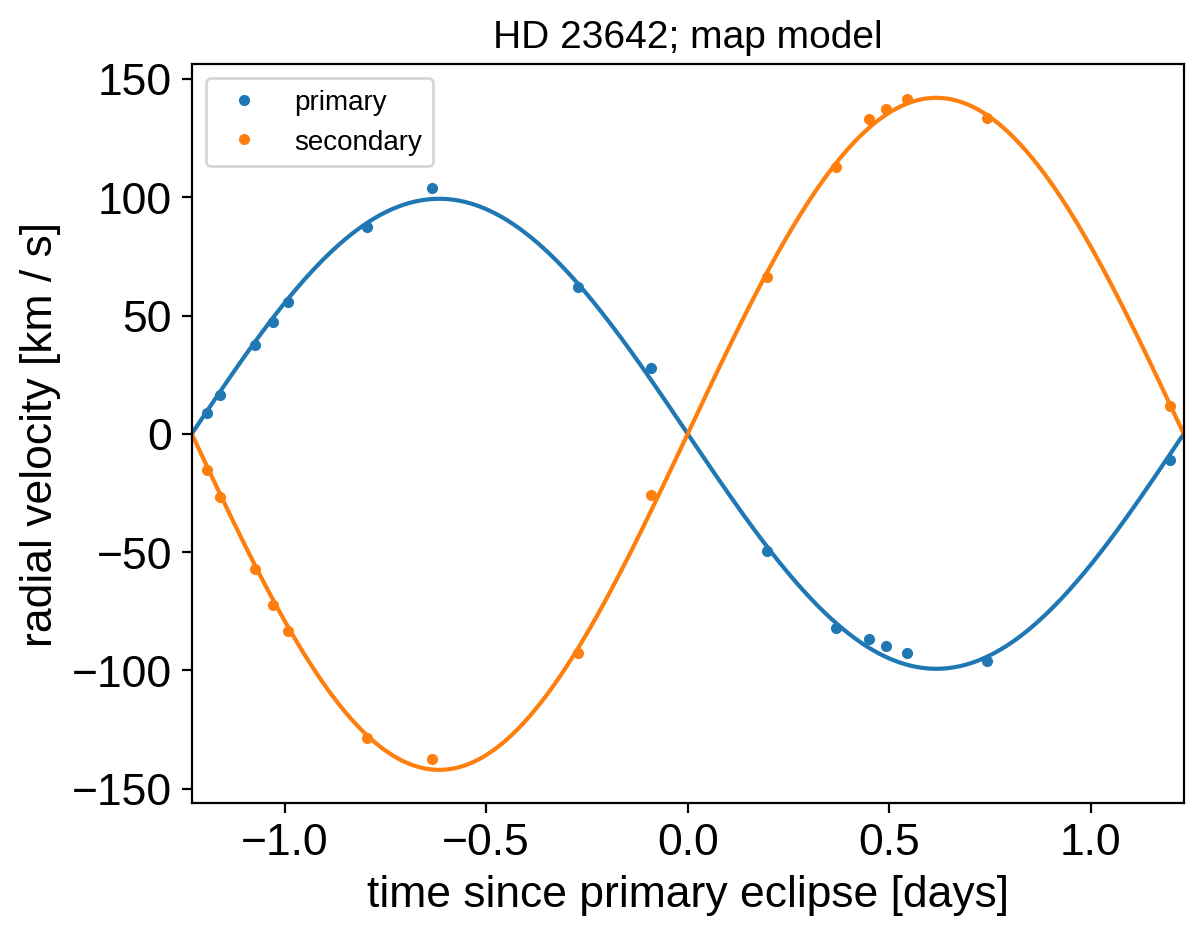

In [7]:
period = map_soln["period"]
t0 = map_soln["t0"]
mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv - mean, ".", label="primary")
plt.plot(fold, y2_rv - mean, ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model.model_rv1(x_phase + t0), model.model_rv2(x_phase + t0)], map_soln
    )
plt.plot(x_phase, y1_mod - mean, "C0")
plt.plot(x_phase, y2_mod - mean, "C1")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("HD 23642; map model", fontsize=14)

And then the light curve.
In the top panel, we show the Gaussian process model for the phase curve.
It's clear that there's a lot of information there that we could take advantage of, but that's a topic for another day.
In the bottom panel, we're plotting the phase folded light curve and we can see the ridiculous signal to noise that we're getting on the eclipses.

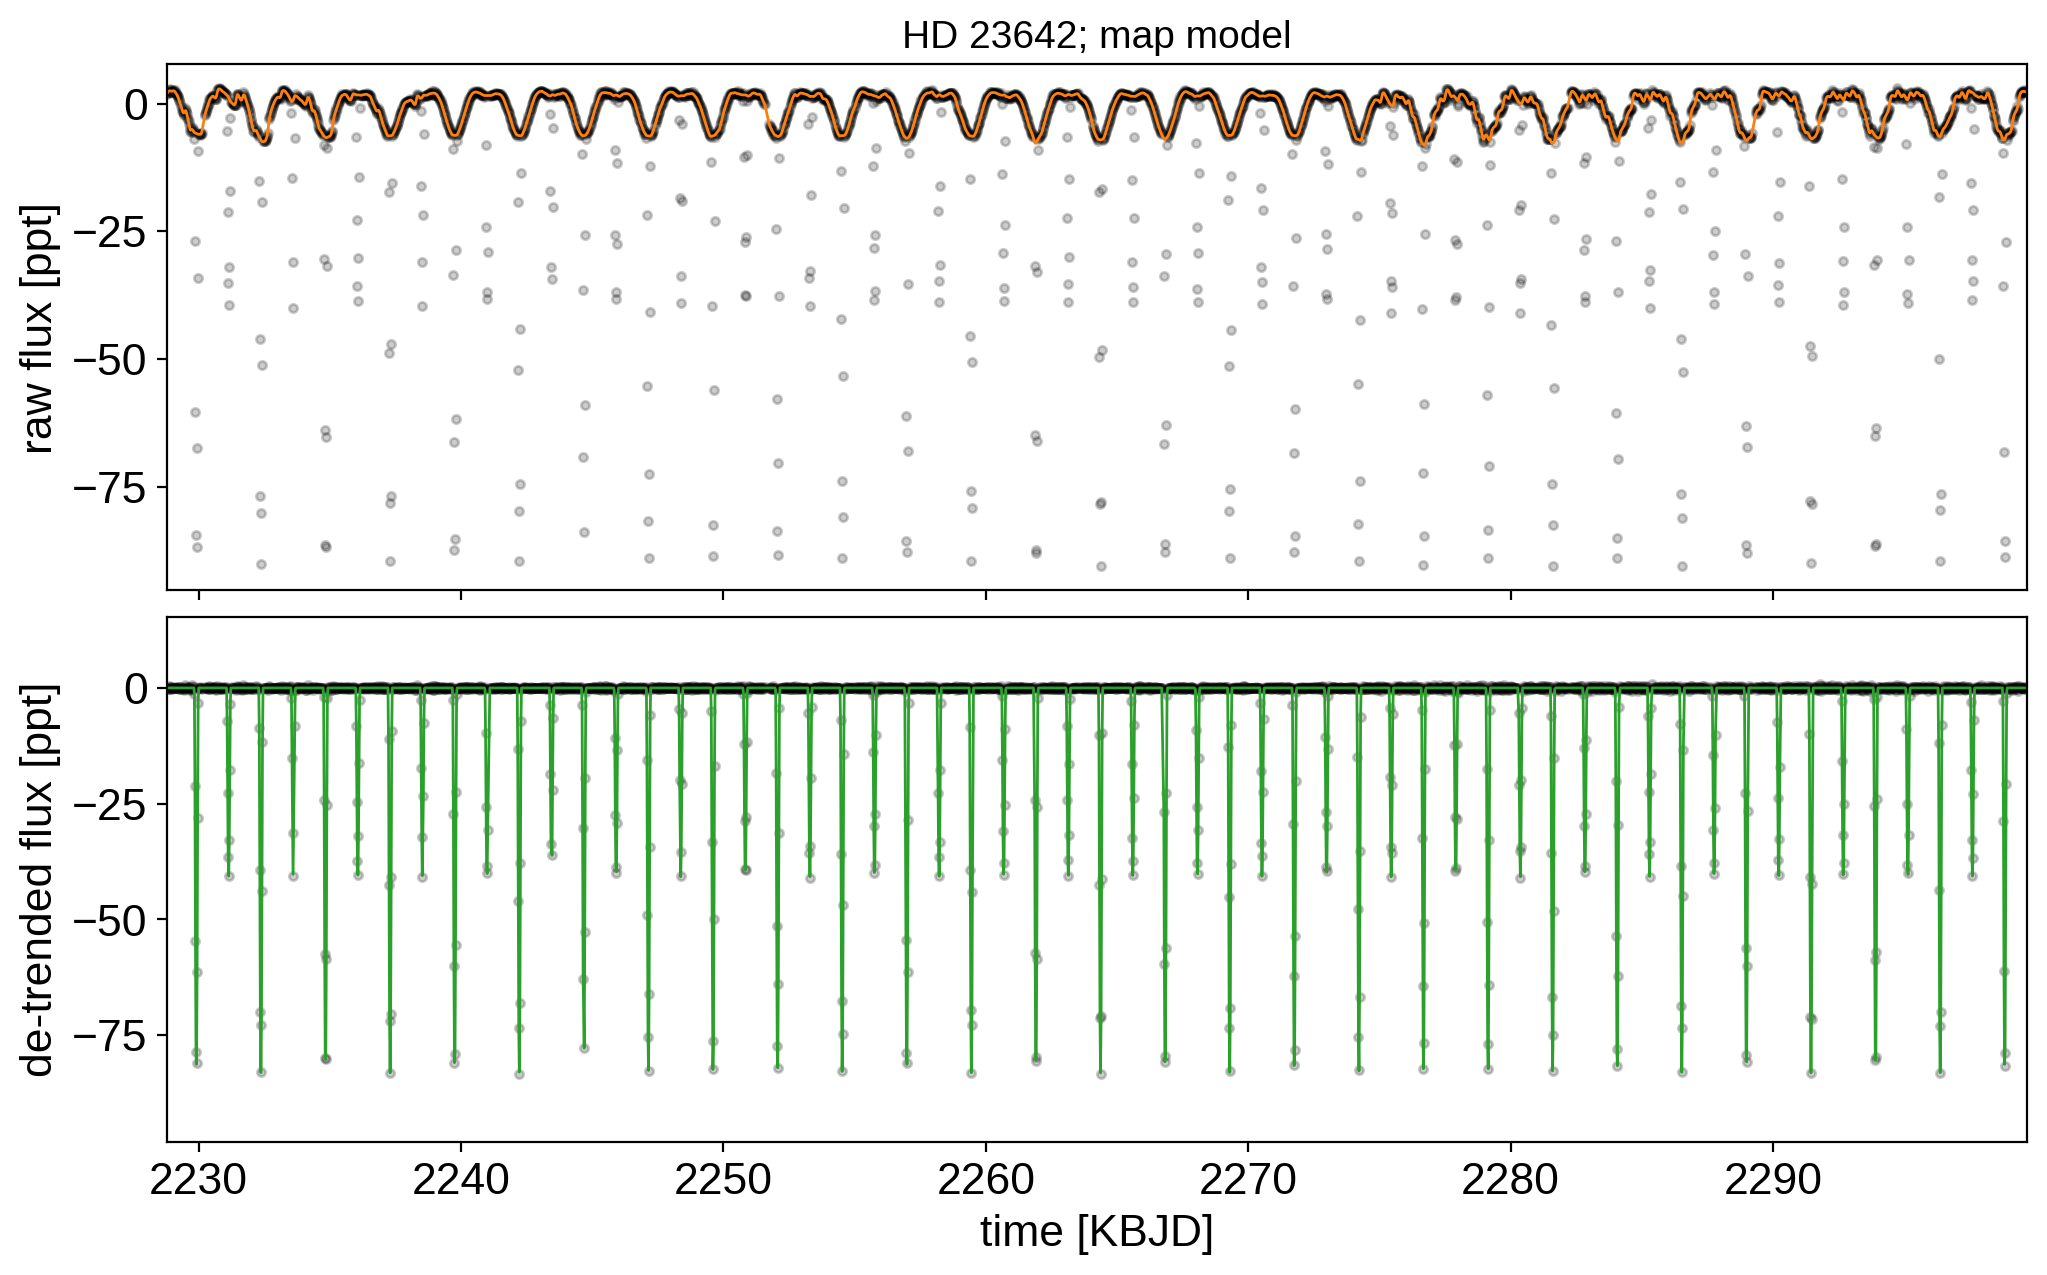

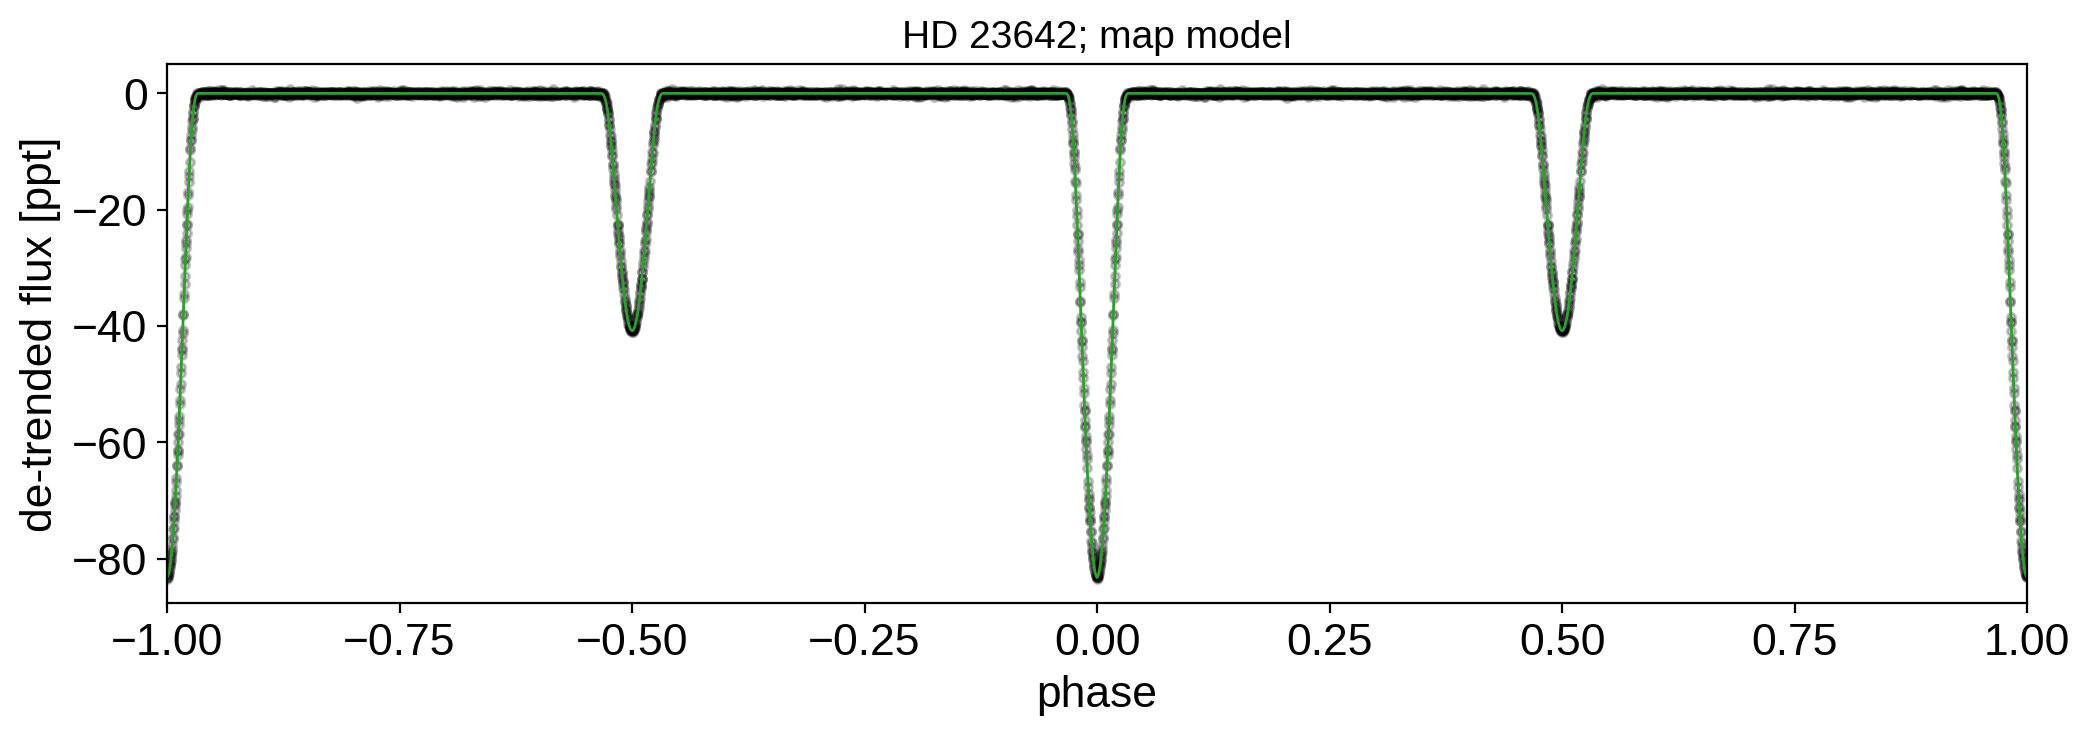

In [8]:
with model:
    gp_pred = xo.eval_in_model(model.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
    lc = xo.eval_in_model(model.model_lc(model.x), map_soln) - map_soln["mean_lc"]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

ax1.plot(model.x, model.y, "k.", alpha=0.2)
ax1.plot(model.x, gp_pred, color="C1", lw=1)

ax2.plot(model.x, model.y - gp_pred, "k.", alpha=0.2)
ax2.plot(model.x, lc, color="C2", lw=1)
ax2.set_xlim(model.x.min(), model.x.max())

ax1.set_ylabel("raw flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [KBJD]")
ax1.set_title("HD 23642; map model", fontsize=14)

fig.subplots_adjust(hspace=0.05)

fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

x_fold = (model.x - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
inds = np.argsort(x_fold)

ax1.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax1.plot(x_fold[inds] - 1, model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax2.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2, label="data!")
ax2.plot(x_fold[inds] - 1, model.y[inds] - gp_pred, "k.", alpha=0.2)

yval = model.y[inds] - gp_pred
bins = np.linspace(0, 1, 75)
num, _ = np.histogram(x_fold[inds], bins, weights=yval)
denom, _ = np.histogram(x_fold[inds], bins)
ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

args = dict(lw=1)

ax1.plot(x_fold[inds], lc[inds], "C2", **args)
ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

ax1.set_xlim(-1, 1)
ax1.set_ylabel("de-trended flux [ppt]")
ax1.set_xlabel("phase")
_ = ax1.set_title("HD 23642; map model", fontsize=14)

## Sampling

Finally we can run the MCMC:

In [9]:
np.random.seed(23642)
with model:
    trace = xo.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=4,
        initial_accept=0.8,
        target_accept=0.95,
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/26000 [00:00<16:59, 25.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/26000 [00:01<41:56, 10.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/26000 [00:02<59:42,  7.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/26000 [00:02<46:16,  9.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/26000 [00:03<1:31:59,  4.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:04<1:40:28,  4.31draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/26000 [00:04<1:17:42,  5.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/26000 [00:05<1:21:32,  5.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/26000 [00:05<1:10:19,  6.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/26000 [00:06<1:24:25,  5.12draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/26000 [00:06<1:13:57,  5.85draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/26000 [00:07<1:26:18,  5.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:07<1:17:19,  5.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:08<1:20:06,  5.40draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:08<1:05:32,  6.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/26000 [00:09<1:11:42,  6.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:09<1:06:43,  6.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/26000 [00:09<53:55,  8.01draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 71/26000 [00:10<1:23:39,  5.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:10<1:12:06,  5.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/26000 [00:10<57:47,  7.48draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:11<1:26:57,  4.97draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:11<1:13:59,  5.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/26000 [00:11<1:06:28,  6.50draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:12<1:16:39,  5.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:12<1:07:47,  6.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 83/26000 [00:12<1:04:00,  6.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:13<1:28:55,  4.86draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:13<1:17:12,  5.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 87/26000 [00:13<1:11:02,  6.08draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:13<1:33:10,  4.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:14<1:13:07,  5.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 92/26000 [00:14<1:11:22,  6.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 94/26000 [00:14<57:32,  7.50draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:15<1:22:08,  5.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:15<1:18:47,  5.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 98/26000 [00:15<1:18:21,  5.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:15<1:59:47,  3.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 101/26000 [00:16<1:35:45,  4.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:16<1:18:00,  5.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [00:16<1:56:13,  3.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:16<1:46:05,  4.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:17<1:28:34,  4.87draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [00:17<1:22:39,  5.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:17<1:56:22,  3.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [00:17<1:34:25,  4.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:18<1:24:23,  5.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:18<1:21:10,  5.31draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [00:18<1:23:48,  5.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:18<1:23:27,  5.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:18<1:17:05,  5.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [00:19<1:20:17,  5.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [00:19<1:44:20,  4.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [00:19<1:38:49,  4.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:19<1:28:59,  4.85draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [00:20<1:18:20,  5.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:20<1:35:11,  4.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:20<1:33:27,  4.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:20<1:27:13,  4.94draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 127/26000 [00:21<1:35:41,  4.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [00:21<1:42:14,  4.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [00:21<1:26:38,  4.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:21<1:10:24,  6.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [00:22<1:25:50,  5.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:22<1:34:17,  4.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 135/26000 [00:22<1:36:53,  4.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/26000 [00:22<1:25:57,  5.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:22<1:38:32,  4.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:23<1:39:45,  4.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [00:23<1:41:47,  4.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/26000 [00:23<1:29:23,  4.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:23<1:23:56,  5.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/26000 [00:24<1:23:58,  5.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/26000 [00:24<1:31:37,  4.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:24<1:25:17,  5.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:24<1:41:26,  4.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [00:25<1:33:09,  4.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 148/26000 [00:25<1:39:48,  4.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:25<1:20:11,  5.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/26000 [00:25<1:39:42,  4.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [00:25<1:29:27,  4.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [00:26<1:43:04,  4.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:26<1:27:57,  4.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [00:26<1:46:35,  4.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [00:26<1:31:23,  4.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/26000 [00:27<1:48:27,  3.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:27<1:29:29,  4.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/26000 [00:27<1:49:33,  3.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [00:27<1:29:39,  4.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 161/26000 [00:28<1:49:15,  3.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:28<1:29:27,  4.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [00:28<1:51:02,  3.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:29<1:37:18,  4.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:29<1:39:05,  4.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/26000 [00:30<1:28:53,  4.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:30<1:23:22,  5.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [00:30<1:26:35,  4.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:31<1:32:41,  4.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:31<1:32:40,  4.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:32<1:37:21,  4.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 186/26000 [00:32<1:21:50,  5.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [00:33<1:30:33,  4.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [00:33<1:30:03,  4.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [00:34<1:35:13,  4.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [00:34<1:25:15,  5.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [00:35<1:31:23,  4.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [00:35<1:32:09,  4.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 201/26000 [00:36<1:35:16,  4.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 204/26000 [00:36<1:26:00,  5.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [00:36<1:30:07,  4.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/26000 [00:37<1:18:39,  5.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [00:37<1:39:13,  4.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [00:37<1:30:15,  4.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 212/26000 [00:38<1:17:13,  5.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 213/26000 [00:38<1:37:23,  4.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [00:38<1:28:25,  4.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [00:38<1:18:34,  5.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [00:39<1:38:19,  4.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [00:39<1:37:51,  4.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [00:39<1:28:33,  4.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [00:40<1:43:22,  4.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [00:40<1:40:28,  4.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [00:40<1:33:29,  4.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 226/26000 [00:41<1:45:29,  4.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 228/26000 [00:41<1:40:54,  4.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [00:41<1:36:58,  4.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [00:42<1:47:35,  3.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 232/26000 [00:42<1:41:28,  4.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 234/26000 [00:42<1:25:10,  5.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [00:43<1:38:52,  4.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [00:43<1:22:18,  5.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 240/26000 [00:43<1:26:39,  4.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [00:43<1:41:01,  4.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [00:44<1:34:47,  4.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 244/26000 [00:44<1:38:26,  4.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 245/26000 [00:44<1:48:13,  3.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [00:45<1:38:38,  4.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 248/26000 [00:45<1:44:27,  4.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 249/26000 [00:45<1:51:06,  3.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [00:46<1:39:43,  4.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 252/26000 [00:46<1:48:55,  3.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [00:46<1:34:17,  4.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 256/26000 [00:47<1:27:05,  4.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 258/26000 [00:47<1:24:31,  5.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [00:47<1:28:57,  4.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [00:48<1:18:04,  5.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 263/26000 [00:48<1:37:45,  4.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [00:48<1:37:36,  4.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [00:48<1:30:42,  4.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 267/26000 [00:49<1:49:39,  3.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 268/26000 [00:49<1:44:16,  4.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [00:49<1:35:00,  4.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 272/26000 [00:50<1:30:48,  4.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [00:50<1:19:03,  5.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 275/26000 [00:50<1:33:09,  4.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 277/26000 [00:50<1:14:23,  5.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [00:51<1:30:03,  4.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 279/26000 [00:51<1:28:00,  4.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [00:51<1:51:33,  3.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [00:52<1:40:33,  4.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [00:52<1:34:49,  4.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [00:52<1:30:51,  4.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 287/26000 [00:53<1:26:54,  4.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [00:53<1:27:06,  4.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [00:53<1:46:17,  4.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [00:53<1:25:22,  5.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [00:54<1:51:48,  3.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [00:54<2:02:30,  3.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [00:54<1:37:41,  4.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [00:55<1:59:21,  3.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 297/26000 [00:55<2:03:31,  3.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [00:55<1:36:05,  4.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [00:56<2:18:22,  3.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [00:56<1:52:00,  3.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [00:56<1:26:25,  4.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 305/26000 [00:56<1:17:27,  5.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [00:57<1:29:16,  4.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 308/26000 [00:57<1:22:49,  5.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [00:57<1:14:51,  5.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [00:58<1:57:13,  3.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 312/26000 [00:58<1:42:36,  4.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 314/26000 [00:58<1:18:27,  5.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [00:58<1:05:39,  6.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [00:59<1:34:14,  4.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [00:59<1:17:33,  5.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [00:59<59:05,  7.24draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [01:00<1:32:50,  4.61draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 328/26000 [01:00<1:11:14,  6.01draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 330/26000 [01:00<1:21:52,  5.23draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [01:01<1:22:06,  5.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [01:01<1:29:32,  4.78draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 335/26000 [01:02<1:29:09,  4.80draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [01:02<1:30:26,  4.73draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [01:02<1:35:53,  4.46draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 340/26000 [01:03<1:19:28,  5.38draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [01:03<1:24:22,  5.07draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [01:03<1:22:19,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [01:03<1:17:07,  5.54draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [01:04<1:25:28,  5.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [01:04<1:14:31,  5.74draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [01:04<1:31:30,  4.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 351/26000 [01:04<1:12:54,  5.86draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [01:05<1:26:11,  4.96draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [01:05<1:25:42,  4.99draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [01:05<1:48:51,  3.93draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [01:05<1:22:42,  5.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 357/26000 [01:05<1:21:27,  5.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 359/26000 [01:06<1:13:00,  5.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [01:06<1:17:43,  5.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [01:06<1:31:59,  4.65draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [01:06<1:26:02,  4.97draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [01:07<1:29:22,  4.78draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [01:07<1:42:20,  4.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 366/26000 [01:07<1:31:17,  4.68draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [01:08<1:27:57,  4.86draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 370/26000 [01:08<1:10:15,  6.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 371/26000 [01:08<1:23:50,  5.09draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 373/26000 [01:08<1:07:34,  6.32draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 374/26000 [01:08<1:12:37,  5.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [01:09<1:10:47,  6.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 378/26000 [01:09<1:05:36,  6.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [01:09<1:32:08,  4.63draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [01:09<1:08:57,  6.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [01:10<1:11:17,  5.99draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 386/26000 [01:10<1:22:47,  5.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [01:11<1:23:43,  5.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/26000 [01:11<1:05:22,  6.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [01:11<1:16:43,  5.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [01:12<1:15:29,  5.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/26000 [01:12<1:00:12,  7.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 398/26000 [01:12<1:14:43,  5.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [01:12<1:03:19,  6.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 402/26000 [01:13<51:42,  8.25draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 405/26000 [01:13<41:16, 10.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [01:13<1:16:31,  5.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 409/26000 [01:14<1:05:08,  6.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [01:14<57:55,  7.36draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 413/26000 [01:14<1:22:12,  5.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 416/26000 [01:15<1:09:34,  6.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 417/26000 [01:15<1:57:03,  3.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [01:15<1:29:43,  4.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [01:16<1:12:31,  5.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [01:16<1:38:46,  4.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [01:17<1:19:34,  5.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [01:17<1:49:35,  3.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 429/26000 [01:17<1:27:35,  4.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [01:17<1:12:43,  5.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [01:17<57:55,  7.36draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 435/26000 [01:18<47:56,  8.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 437/26000 [01:18<49:10,  8.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [01:18<39:07, 10.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [01:18<37:25, 11.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [01:18<52:17,  8.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 447/26000 [01:19<42:20, 10.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [01:19<45:01,  9.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 451/26000 [01:19<43:32,  9.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [01:19<58:44,  7.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [01:20<53:02,  8.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [01:20<44:26,  9.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [01:20<1:07:57,  6.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 461/26000 [01:20<54:58,  7.74draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [01:21<41:52, 10.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [01:21<43:54,  9.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [01:21<41:14, 10.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [01:21<59:43,  7.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [01:22<49:12,  8.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [01:22<45:21,  9.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [01:22<1:13:44,  5.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [01:23<1:03:05,  6.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [01:23<52:54,  8.04draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 483/26000 [01:23<43:41,  9.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [01:23<38:17, 11.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 490/26000 [01:24<45:59,  9.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 493/26000 [01:24<39:39, 10.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [01:24<37:10, 11.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [01:24<56:32,  7.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [01:24<49:52,  8.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [01:25<45:26,  9.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 504/26000 [01:25<42:31,  9.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [01:25<57:55,  7.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [01:25<50:34,  8.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 510/26000 [01:26<42:43,  9.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [01:26<36:28, 11.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 517/26000 [01:26<30:27, 13.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 519/26000 [01:26<34:01, 12.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 521/26000 [01:27<53:54,  7.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 523/26000 [01:27<44:48,  9.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [01:27<36:19, 11.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 529/26000 [01:27<32:43, 12.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [01:27<32:03, 13.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [01:27<37:31, 11.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 535/26000 [01:28<43:04,  9.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 537/26000 [01:28<42:51,  9.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 539/26000 [01:28<58:23,  7.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [01:28<48:10,  8.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 543/26000 [01:29<56:42,  7.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [01:29<49:30,  8.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [01:29<44:25,  9.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [01:29<36:42, 11.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [01:30<40:21, 10.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 557/26000 [01:30<35:26, 11.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [01:30<54:33,  7.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [01:30<52:59,  8.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 563/26000 [01:31<43:49,  9.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 566/26000 [01:31<43:50,  9.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 568/26000 [01:31<45:13,  9.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 572/26000 [01:31<36:51, 11.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 574/26000 [01:31<32:18, 13.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [01:32<30:42, 13.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [01:32<31:11, 13.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 583/26000 [01:32<26:18, 16.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 585/26000 [01:32<36:56, 11.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 587/26000 [01:32<40:45, 10.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 589/26000 [01:33<39:05, 10.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [01:33<32:14, 13.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 594/26000 [01:33<33:34, 12.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 596/26000 [01:33<35:13, 12.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 598/26000 [01:33<35:24, 11.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [01:33<32:03, 13.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [01:34<37:07, 11.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [01:34<36:40, 11.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 608/26000 [01:34<35:22, 11.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 610/26000 [01:34<32:02, 13.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 613/26000 [01:34<35:43, 11.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 616/26000 [01:35<31:01, 13.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 620/26000 [01:35<26:38, 15.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 622/26000 [01:35<30:36, 13.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 626/26000 [01:35<31:16, 13.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [01:35<36:31, 11.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [01:36<29:51, 14.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 635/26000 [01:36<25:50, 16.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [01:36<24:31, 17.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 642/26000 [01:36<21:27, 19.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 645/26000 [01:36<19:27, 21.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 648/26000 [01:36<19:29, 21.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [01:36<17:18, 24.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [01:37<15:46, 26.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [01:37<14:14, 29.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [01:37<15:10, 27.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 668/26000 [01:37<17:04, 24.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 672/26000 [01:37<16:30, 25.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 676/26000 [01:37<15:12, 27.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 679/26000 [01:37<19:11, 21.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 682/26000 [01:38<22:42, 18.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 685/26000 [01:38<24:45, 17.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [01:38<22:12, 18.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 693/26000 [01:38<18:29, 22.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 697/26000 [01:38<16:54, 24.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 700/26000 [01:38<16:46, 25.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 704/26000 [01:38<15:26, 27.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 707/26000 [01:39<18:00, 23.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [01:39<17:45, 23.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [01:39<22:05, 19.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 716/26000 [01:39<22:01, 19.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 719/26000 [01:39<20:15, 20.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 722/26000 [01:39<23:53, 17.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [01:40<19:55, 21.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 731/26000 [01:40<17:35, 23.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 734/26000 [01:40<17:10, 24.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 737/26000 [01:40<16:53, 24.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 741/26000 [01:40<15:27, 27.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [01:40<13:21, 31.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [01:40<18:45, 22.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [01:41<16:38, 25.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [01:41<14:36, 28.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 763/26000 [01:41<13:48, 30.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 767/26000 [01:41<16:51, 24.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 770/26000 [01:41<16:54, 24.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 773/26000 [01:41<16:22, 25.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 778/26000 [01:41<14:20, 29.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 782/26000 [01:42<16:06, 26.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 786/26000 [01:42<14:55, 28.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [01:42<15:06, 27.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [01:42<14:56, 28.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 798/26000 [01:42<14:22, 29.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [01:42<15:34, 26.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 805/26000 [01:42<16:29, 25.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [01:43<16:23, 25.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [01:43<16:20, 25.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [01:43<16:59, 24.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 818/26000 [01:43<16:28, 25.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 821/26000 [01:43<20:24, 20.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 824/26000 [01:43<20:10, 20.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 828/26000 [01:43<17:50, 23.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 832/26000 [01:43<15:55, 26.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 835/26000 [01:44<17:30, 23.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [01:44<20:56, 20.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 841/26000 [01:44<19:32, 21.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [01:44<20:29, 20.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 848/26000 [01:44<18:59, 22.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 851/26000 [01:44<17:45, 23.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [01:45<16:07, 26.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [01:45<16:13, 25.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 864/26000 [01:45<13:49, 30.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [01:45<13:54, 30.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 873/26000 [01:45<12:52, 32.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [01:45<11:55, 35.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [01:45<12:54, 32.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 886/26000 [01:45<14:38, 28.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 891/26000 [01:46<13:03, 32.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [01:46<12:46, 32.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [01:46<15:08, 27.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [01:46<14:21, 29.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [01:46<14:34, 28.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 911/26000 [01:46<14:38, 28.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 915/26000 [01:46<14:52, 28.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [01:47<14:01, 29.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 924/26000 [01:47<14:28, 28.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [01:47<14:41, 28.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 931/26000 [01:47<14:09, 29.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 935/26000 [01:47<13:14, 31.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 939/26000 [01:47<13:11, 31.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 943/26000 [01:47<12:52, 32.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [01:47<12:39, 32.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 951/26000 [01:48<12:27, 33.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 955/26000 [01:48<12:01, 34.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [01:48<12:21, 33.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 965/26000 [01:48<11:34, 36.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 969/26000 [01:48<11:45, 35.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 974/26000 [01:48<10:57, 38.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 978/26000 [01:48<12:06, 34.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [01:48<11:37, 35.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 988/26000 [01:48<10:35, 39.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 994/26000 [01:49<09:51, 42.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1001/26000 [01:49<08:52, 46.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [01:49<10:10, 40.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1011/26000 [01:49<09:58, 41.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1016/26000 [01:49<12:44, 32.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [01:49<12:30, 33.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1025/26000 [01:49<12:10, 34.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1031/26000 [01:50<10:53, 38.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1036/26000 [01:50<10:42, 38.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1041/26000 [01:50<11:49, 35.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1045/26000 [01:50<11:30, 36.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1051/26000 [01:50<10:42, 38.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1056/26000 [01:50<10:22, 40.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1061/26000 [01:50<10:08, 41.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1066/26000 [01:51<11:25, 36.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1072/26000 [01:51<10:29, 39.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1077/26000 [01:51<11:37, 35.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [01:51<11:37, 35.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1085/26000 [01:51<11:44, 35.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [01:51<11:49, 35.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [01:51<11:50, 35.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [01:51<11:53, 34.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1101/26000 [01:51<11:54, 34.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1105/26000 [01:52<12:37, 32.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [01:52<13:18, 31.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1113/26000 [01:52<14:55, 27.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1117/26000 [01:52<14:55, 27.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1120/26000 [01:52<15:18, 27.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1124/26000 [01:52<14:19, 28.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1128/26000 [01:52<13:50, 29.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1132/26000 [01:53<13:19, 31.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1136/26000 [01:53<12:59, 31.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [01:53<16:11, 25.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1144/26000 [01:53<14:52, 27.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1148/26000 [01:53<14:02, 29.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [01:53<17:01, 24.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1156/26000 [01:53<15:29, 26.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1160/26000 [01:54<15:20, 27.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1163/26000 [01:54<15:30, 26.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1166/26000 [01:54<16:20, 25.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1169/26000 [01:54<16:09, 25.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1172/26000 [01:54<16:42, 24.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1175/26000 [01:54<17:34, 23.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [01:54<17:05, 24.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1182/26000 [01:55<15:32, 26.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1187/26000 [01:55<13:58, 29.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1191/26000 [01:55<13:04, 31.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1196/26000 [01:55<12:11, 33.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1201/26000 [01:55<12:16, 33.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1205/26000 [01:55<12:39, 32.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1209/26000 [01:55<13:02, 31.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1213/26000 [01:55<12:44, 32.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1217/26000 [01:56<13:35, 30.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1221/26000 [01:56<12:40, 32.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1225/26000 [01:56<12:26, 33.18draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1230/26000 [01:56<11:33, 35.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1234/26000 [01:56<12:21, 33.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1239/26000 [01:56<11:29, 35.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1243/26000 [01:56<11:37, 35.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1247/26000 [01:56<11:41, 35.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1252/26000 [01:56<11:03, 37.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1258/26000 [01:57<10:08, 40.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1263/26000 [01:57<12:10, 33.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1267/26000 [01:57<12:04, 34.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1272/26000 [01:57<11:16, 36.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1280/26000 [01:57<09:41, 42.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1285/26000 [01:57<11:17, 36.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1290/26000 [01:57<11:57, 34.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1294/26000 [01:58<12:10, 33.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1298/26000 [01:58<12:04, 34.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1302/26000 [01:58<12:01, 34.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1306/26000 [01:58<11:58, 34.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [01:58<11:57, 34.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1314/26000 [01:58<12:28, 32.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1319/26000 [01:58<12:53, 31.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1323/26000 [01:58<12:11, 33.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1328/26000 [01:59<11:23, 36.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1332/26000 [01:59<12:20, 33.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1336/26000 [01:59<12:10, 33.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [01:59<13:05, 31.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1344/26000 [01:59<12:50, 31.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1348/26000 [01:59<14:47, 27.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1351/26000 [01:59<15:03, 27.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1357/26000 [02:00<12:53, 31.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1361/26000 [02:00<12:33, 32.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1365/26000 [02:00<15:34, 26.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1369/26000 [02:00<14:36, 28.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1373/26000 [02:00<16:55, 24.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1378/26000 [02:00<14:18, 28.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1382/26000 [02:00<14:20, 28.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1386/26000 [02:01<13:34, 30.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1390/26000 [02:01<12:41, 32.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1394/26000 [02:01<12:26, 32.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1399/26000 [02:01<11:32, 35.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1404/26000 [02:01<10:51, 37.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1408/26000 [02:01<11:42, 34.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1413/26000 [02:01<10:42, 38.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1418/26000 [02:01<11:48, 34.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1422/26000 [02:02<13:30, 30.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [02:02<13:39, 29.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1430/26000 [02:02<14:16, 28.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1434/26000 [02:02<13:22, 30.61draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1439/26000 [02:02<12:11, 33.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1446/26000 [02:02<10:55, 37.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1451/26000 [02:02<11:59, 34.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1455/26000 [02:03<11:55, 34.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1460/26000 [02:03<11:27, 35.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [02:03<10:53, 37.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1469/26000 [02:03<12:29, 32.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1474/26000 [02:03<12:03, 33.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1479/26000 [02:03<11:17, 36.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1483/26000 [02:03<11:29, 35.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1487/26000 [02:03<11:37, 35.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1491/26000 [02:04<13:30, 30.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1495/26000 [02:04<14:05, 28.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1499/26000 [02:04<13:23, 30.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1503/26000 [02:04<14:52, 27.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1506/26000 [02:04<16:35, 24.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1510/26000 [02:04<15:30, 26.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1513/26000 [02:04<15:06, 27.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1517/26000 [02:05<13:57, 29.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1521/26000 [02:05<13:21, 30.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1525/26000 [02:05<15:13, 26.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [02:05<15:29, 26.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1531/26000 [02:05<14:58, 27.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1535/26000 [02:05<14:04, 28.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1539/26000 [02:05<13:25, 30.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1544/26000 [02:05<12:14, 33.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1550/26000 [02:06<10:58, 37.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1554/26000 [02:06<11:12, 36.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1559/26000 [02:06<10:38, 38.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1563/26000 [02:06<12:57, 31.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1567/26000 [02:06<14:01, 29.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1571/26000 [02:06<13:46, 29.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1575/26000 [02:06<14:25, 28.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1580/26000 [02:07<14:19, 28.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1585/26000 [02:07<12:58, 31.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1589/26000 [02:07<12:52, 31.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [02:07<12:51, 31.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1597/26000 [02:07<12:10, 33.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1601/26000 [02:07<12:43, 31.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1605/26000 [02:07<15:14, 26.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1608/26000 [02:08<15:20, 26.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1611/26000 [02:08<16:38, 24.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1614/26000 [02:08<17:37, 23.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1618/26000 [02:08<17:04, 23.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1623/26000 [02:08<16:02, 25.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1626/26000 [02:08<15:59, 25.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1630/26000 [02:08<15:22, 26.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1634/26000 [02:08<13:50, 29.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1638/26000 [02:09<15:01, 27.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1641/26000 [02:09<18:06, 22.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1646/26000 [02:09<16:40, 24.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1650/26000 [02:09<15:29, 26.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1653/26000 [02:09<19:31, 20.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1656/26000 [02:09<19:05, 21.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1660/26000 [02:10<16:48, 24.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1664/26000 [02:10<15:15, 26.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [02:10<14:11, 28.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1672/26000 [02:10<15:10, 26.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1676/26000 [02:10<14:06, 28.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1680/26000 [02:10<14:29, 27.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [02:10<14:58, 27.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1686/26000 [02:10<15:11, 26.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1689/26000 [02:11<17:43, 22.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1692/26000 [02:11<17:00, 23.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1695/26000 [02:11<18:47, 21.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1698/26000 [02:11<17:52, 22.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1701/26000 [02:11<19:56, 20.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [02:11<20:37, 19.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1708/26000 [02:12<17:58, 22.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1711/26000 [02:12<17:06, 23.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [02:12<19:41, 20.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1717/26000 [02:12<18:30, 21.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1720/26000 [02:12<17:02, 23.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1723/26000 [02:12<16:38, 24.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1728/26000 [02:12<14:28, 27.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1733/26000 [02:12<13:04, 30.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1737/26000 [02:13<12:30, 32.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1741/26000 [02:13<12:21, 32.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1745/26000 [02:13<12:06, 33.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1749/26000 [02:13<12:19, 32.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1753/26000 [02:13<12:07, 33.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1757/26000 [02:13<11:58, 33.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [02:13<11:38, 34.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1765/26000 [02:13<11:38, 34.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1770/26000 [02:13<10:45, 37.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1774/26000 [02:14<11:16, 35.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1778/26000 [02:14<13:10, 30.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [02:14<12:45, 31.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [02:14<12:28, 32.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [02:14<12:15, 32.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1794/26000 [02:14<12:04, 33.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1798/26000 [02:14<13:18, 30.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1802/26000 [02:15<13:25, 30.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1806/26000 [02:15<14:01, 28.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1810/26000 [02:15<13:19, 30.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1814/26000 [02:15<12:49, 31.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1818/26000 [02:15<12:10, 33.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1823/26000 [02:15<11:22, 35.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1828/26000 [02:15<10:48, 37.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1833/26000 [02:15<10:24, 38.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1838/26000 [02:15<10:07, 39.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1843/26000 [02:16<10:08, 39.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1848/26000 [02:16<10:29, 38.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1852/26000 [02:16<10:50, 37.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1856/26000 [02:16<11:54, 33.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1860/26000 [02:16<11:57, 33.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1864/26000 [02:16<11:51, 33.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1869/26000 [02:16<11:05, 36.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [02:16<10:33, 38.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1878/26000 [02:17<11:51, 33.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1882/26000 [02:17<11:49, 34.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [02:17<13:29, 29.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1890/26000 [02:17<12:56, 31.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1894/26000 [02:17<13:35, 29.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1898/26000 [02:17<12:57, 30.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1902/26000 [02:17<12:31, 32.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1906/26000 [02:18<14:46, 27.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1910/26000 [02:18<13:47, 29.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [02:18<13:09, 30.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [02:18<12:56, 31.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1922/26000 [02:18<14:02, 28.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1925/26000 [02:18<17:37, 22.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1928/26000 [02:18<17:00, 23.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1933/26000 [02:19<14:41, 27.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1937/26000 [02:19<15:26, 25.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [02:19<17:01, 23.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1944/26000 [02:19<15:59, 25.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [02:19<16:31, 24.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1950/26000 [02:19<16:13, 24.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1953/26000 [02:19<17:08, 23.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1957/26000 [02:20<15:16, 26.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1961/26000 [02:20<14:11, 28.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1965/26000 [02:20<13:24, 29.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1970/26000 [02:20<12:10, 32.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [02:20<14:52, 26.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1978/26000 [02:20<14:34, 27.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1981/26000 [02:20<14:46, 27.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1984/26000 [02:20<14:54, 26.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1987/26000 [02:21<15:00, 26.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1990/26000 [02:21<15:05, 26.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [02:21<13:44, 29.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1998/26000 [02:21<13:19, 30.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2002/26000 [02:21<12:45, 31.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2006/26000 [02:21<13:43, 29.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2010/26000 [02:21<13:04, 30.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2014/26000 [02:21<12:37, 31.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2018/26000 [02:22<12:34, 31.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2022/26000 [02:22<13:43, 29.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2027/26000 [02:22<12:29, 31.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2031/26000 [02:22<12:11, 32.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2035/26000 [02:22<11:50, 33.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2040/26000 [02:22<11:04, 36.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2045/26000 [02:22<10:31, 37.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2049/26000 [02:22<10:42, 37.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2053/26000 [02:23<11:49, 33.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2057/26000 [02:23<12:40, 31.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2061/26000 [02:23<12:20, 32.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2065/26000 [02:23<14:42, 27.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2070/26000 [02:23<13:04, 30.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2075/26000 [02:23<11:54, 33.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2080/26000 [02:23<11:07, 35.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [02:24<12:54, 30.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2088/26000 [02:24<15:56, 25.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2091/26000 [02:24<15:44, 25.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2095/26000 [02:24<14:29, 27.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [02:24<14:46, 26.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2102/26000 [02:24<13:48, 28.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2106/26000 [02:24<15:05, 26.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2109/26000 [02:24<15:12, 26.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2113/26000 [02:25<13:51, 28.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2117/26000 [02:25<14:09, 28.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2120/26000 [02:25<15:26, 25.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2124/26000 [02:25<14:14, 27.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [02:25<14:34, 27.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2130/26000 [02:25<14:43, 27.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2133/26000 [02:25<14:52, 26.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2136/26000 [02:25<14:42, 27.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2141/26000 [02:26<13:06, 30.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2146/26000 [02:26<11:59, 33.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2152/26000 [02:26<10:41, 37.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2157/26000 [02:26<10:12, 38.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2162/26000 [02:26<09:52, 40.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2167/26000 [02:26<09:39, 41.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2172/26000 [02:26<11:19, 35.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [02:26<11:22, 34.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2180/26000 [02:27<11:25, 34.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2184/26000 [02:27<12:02, 32.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [02:27<12:13, 32.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2192/26000 [02:27<14:31, 27.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2195/26000 [02:27<14:46, 26.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2198/26000 [02:27<15:51, 25.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2201/26000 [02:27<17:04, 23.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2204/26000 [02:28<16:33, 23.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2207/26000 [02:28<17:19, 22.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2211/26000 [02:28<15:34, 25.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2214/26000 [02:28<17:19, 22.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2217/26000 [02:28<16:42, 23.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2220/26000 [02:28<16:14, 24.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2223/26000 [02:28<15:53, 24.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [02:28<15:42, 25.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2231/26000 [02:29<14:20, 27.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2234/26000 [02:29<15:27, 25.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2238/26000 [02:29<14:16, 27.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2241/26000 [02:29<14:51, 26.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [02:29<13:37, 29.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2249/26000 [02:29<13:37, 29.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2252/26000 [02:29<15:03, 26.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2257/26000 [02:29<13:20, 29.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2261/26000 [02:30<13:06, 30.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2265/26000 [02:30<12:35, 31.41draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2269/26000 [02:30<13:46, 28.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2273/26000 [02:30<13:06, 30.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2277/26000 [02:30<13:21, 29.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2281/26000 [02:30<16:13, 24.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2284/26000 [02:30<15:54, 24.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2288/26000 [02:31<17:05, 23.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [02:31<15:22, 25.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [02:31<15:18, 25.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [02:31<15:15, 25.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2302/26000 [02:31<14:05, 28.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2306/26000 [02:31<13:16, 29.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2310/26000 [02:31<14:16, 27.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2313/26000 [02:32<15:21, 25.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2316/26000 [02:32<15:17, 25.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2321/26000 [02:32<14:50, 26.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2325/26000 [02:32<13:49, 28.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2330/26000 [02:32<12:46, 30.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2334/26000 [02:32<12:21, 31.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2338/26000 [02:32<13:27, 29.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2342/26000 [02:33<12:53, 30.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [02:33<12:59, 30.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2350/26000 [02:33<12:38, 31.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2354/26000 [02:33<15:38, 25.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2357/26000 [02:33<16:04, 24.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [02:33<14:33, 27.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [02:33<14:50, 26.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2369/26000 [02:33<13:48, 28.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2372/26000 [02:34<14:12, 27.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2376/26000 [02:34<13:32, 29.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2379/26000 [02:34<13:58, 28.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2382/26000 [02:34<16:18, 24.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2386/26000 [02:34<16:58, 23.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2389/26000 [02:34<16:04, 24.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2392/26000 [02:34<17:06, 22.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2396/26000 [02:35<15:26, 25.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2400/26000 [02:35<14:16, 27.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2404/26000 [02:35<13:26, 29.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2408/26000 [02:35<13:15, 29.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2412/26000 [02:35<14:04, 27.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2415/26000 [02:35<14:22, 27.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2419/26000 [02:35<13:26, 29.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2423/26000 [02:35<13:08, 29.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2427/26000 [02:36<12:42, 30.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2431/26000 [02:36<12:17, 31.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2435/26000 [02:36<13:39, 28.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [02:36<12:20, 31.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [02:36<12:03, 32.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2448/26000 [02:36<11:49, 33.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2452/26000 [02:36<11:45, 33.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2456/26000 [02:37<15:03, 26.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2459/26000 [02:37<14:54, 26.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2462/26000 [02:37<15:14, 25.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2465/26000 [02:37<14:56, 26.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2469/26000 [02:37<13:52, 28.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2472/26000 [02:37<14:38, 26.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2475/26000 [02:37<14:50, 26.43draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2478/26000 [02:37<14:58, 26.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2481/26000 [02:37<15:04, 25.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2484/26000 [02:38<15:32, 25.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2487/26000 [02:38<15:23, 25.46draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2490/26000 [02:38<15:18, 25.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [02:38<16:15, 24.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2497/26000 [02:38<14:47, 26.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [02:38<16:07, 24.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2504/26000 [02:38<14:43, 26.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2507/26000 [02:38<14:54, 26.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2510/26000 [02:39<15:01, 26.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2513/26000 [02:39<15:07, 25.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2517/26000 [02:39<14:02, 27.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2520/26000 [02:39<14:25, 27.12draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [02:39<14:41, 26.63draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2526/26000 [02:39<15:20, 25.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2529/26000 [02:39<15:15, 25.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2533/26000 [02:39<14:32, 26.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2537/26000 [02:40<13:35, 28.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2542/26000 [02:40<12:22, 31.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2546/26000 [02:40<13:06, 29.81draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2550/26000 [02:40<12:34, 31.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2554/26000 [02:40<14:23, 27.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2557/26000 [02:40<17:07, 22.81draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2561/26000 [02:40<15:25, 25.32draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2565/26000 [02:41<15:28, 25.23draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2569/26000 [02:41<15:31, 25.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2572/26000 [02:41<15:18, 25.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2575/26000 [02:41<15:19, 25.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2578/26000 [02:41<15:07, 25.81draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2581/26000 [02:41<15:06, 25.84draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2585/26000 [02:41<14:03, 27.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2588/26000 [02:41<14:21, 27.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2591/26000 [02:42<14:38, 26.66draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2595/26000 [02:42<15:14, 25.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2598/26000 [02:42<15:09, 25.74draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2601/26000 [02:42<17:28, 22.31draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2605/26000 [02:42<16:56, 23.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [02:42<16:34, 23.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2611/26000 [02:43<18:37, 20.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2614/26000 [02:43<22:00, 17.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2617/26000 [02:43<19:53, 19.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2620/26000 [02:43<22:57, 16.98draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2622/26000 [02:43<22:50, 17.06draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [02:43<20:29, 19.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2628/26000 [02:43<20:22, 19.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [02:44<19:34, 19.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2634/26000 [02:44<18:14, 21.35draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2637/26000 [02:44<19:22, 20.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2640/26000 [02:44<18:03, 21.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2643/26000 [02:44<18:29, 21.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2647/26000 [02:44<16:17, 23.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [02:44<16:50, 23.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2653/26000 [02:45<17:41, 22.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2657/26000 [02:45<17:13, 22.58draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2660/26000 [02:45<16:30, 23.57draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [02:45<16:01, 24.28draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [02:45<14:33, 26.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2670/26000 [02:45<14:37, 26.58draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [02:45<14:42, 26.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2676/26000 [02:45<16:03, 24.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2680/26000 [02:46<16:56, 22.94draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2684/26000 [02:46<15:12, 25.54draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2687/26000 [02:46<17:46, 21.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2690/26000 [02:46<16:59, 22.87draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2693/26000 [02:46<16:25, 23.66draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2696/26000 [02:46<15:58, 24.31draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2700/26000 [02:46<14:33, 26.67draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2703/26000 [02:47<16:14, 23.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2707/26000 [02:47<15:23, 25.23draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2710/26000 [02:47<15:07, 25.67draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2713/26000 [02:47<15:18, 25.36draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2716/26000 [02:47<18:26, 21.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2720/26000 [02:47<17:34, 22.08draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2723/26000 [02:47<16:32, 23.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2726/26000 [02:48<15:40, 24.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2729/26000 [02:48<16:02, 24.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2732/26000 [02:48<15:10, 25.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2736/26000 [02:48<13:59, 27.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2739/26000 [02:48<14:18, 27.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2743/26000 [02:48<13:23, 28.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2746/26000 [02:48<13:51, 27.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2750/26000 [02:48<13:05, 29.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2754/26000 [02:48<14:04, 27.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2757/26000 [02:49<14:20, 27.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [02:49<14:34, 26.58draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2763/26000 [02:49<14:44, 26.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2766/26000 [02:49<14:51, 26.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2769/26000 [02:49<14:38, 26.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2772/26000 [02:49<15:11, 25.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [02:49<14:50, 26.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2778/26000 [02:49<15:36, 24.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2781/26000 [02:50<16:39, 23.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2785/26000 [02:50<15:00, 25.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2788/26000 [02:50<14:58, 25.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2791/26000 [02:50<14:57, 25.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2794/26000 [02:50<14:55, 25.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2798/26000 [02:50<13:47, 28.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2802/26000 [02:50<14:45, 26.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2806/26000 [02:50<13:39, 28.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2809/26000 [02:51<13:59, 27.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2813/26000 [02:51<13:07, 29.46draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2817/26000 [02:51<12:48, 30.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2821/26000 [02:51<15:21, 25.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2825/26000 [02:51<14:03, 27.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2828/26000 [02:51<14:15, 27.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2831/26000 [02:51<14:56, 25.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2834/26000 [02:51<14:20, 26.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2838/26000 [02:52<13:21, 28.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2842/26000 [02:52<12:39, 30.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [02:52<12:41, 30.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2850/26000 [02:52<12:14, 31.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2854/26000 [02:52<13:19, 28.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2858/26000 [02:52<13:58, 27.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2861/26000 [02:52<14:13, 27.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2865/26000 [02:53<13:16, 29.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2868/26000 [02:53<13:43, 28.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [02:53<14:00, 27.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2875/26000 [02:53<13:07, 29.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2879/26000 [02:53<12:30, 30.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2883/26000 [02:53<12:34, 30.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2887/26000 [02:53<14:18, 26.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2892/26000 [02:53<13:07, 29.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2896/26000 [02:54<13:08, 29.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2900/26000 [02:54<14:54, 25.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2904/26000 [02:54<14:02, 27.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2907/26000 [02:54<14:01, 27.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2911/26000 [02:54<13:12, 29.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2915/26000 [02:54<12:39, 30.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2919/26000 [02:54<13:33, 28.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [02:55<16:38, 23.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2925/26000 [02:55<17:05, 22.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2928/26000 [02:55<16:25, 23.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2931/26000 [02:55<16:44, 22.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2935/26000 [02:55<15:02, 25.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2938/26000 [02:55<17:48, 21.58draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2941/26000 [02:55<18:32, 20.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2944/26000 [02:56<17:27, 22.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2947/26000 [02:56<16:41, 23.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2950/26000 [02:56<16:09, 23.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2953/26000 [02:56<15:46, 24.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2956/26000 [02:56<17:05, 22.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2959/26000 [02:56<17:47, 21.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2963/26000 [02:56<16:09, 23.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2966/26000 [02:56<15:18, 25.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2970/26000 [02:57<15:09, 25.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2974/26000 [02:57<13:56, 27.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2977/26000 [02:57<14:11, 27.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2982/26000 [02:57<13:57, 27.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2985/26000 [02:57<14:13, 26.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2989/26000 [02:57<13:17, 28.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2992/26000 [02:57<13:46, 27.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2997/26000 [02:57<12:18, 31.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3001/26000 [02:58<11:56, 32.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3005/26000 [02:58<12:32, 30.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3010/26000 [02:58<11:27, 33.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3014/26000 [02:58<11:18, 33.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3018/26000 [02:58<11:26, 33.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3022/26000 [02:58<11:36, 33.00draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3026/26000 [02:58<13:31, 28.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3030/26000 [02:59<12:47, 29.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3034/26000 [02:59<12:16, 31.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3038/26000 [02:59<13:04, 29.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3042/26000 [02:59<12:30, 30.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3046/26000 [02:59<15:27, 24.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3049/26000 [02:59<17:57, 21.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3052/26000 [02:59<16:59, 22.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3055/26000 [03:00<16:21, 23.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3059/26000 [03:00<14:46, 25.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3062/26000 [03:00<14:46, 25.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3067/26000 [03:00<13:00, 29.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3071/26000 [03:00<12:25, 30.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [03:00<12:01, 31.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3079/26000 [03:00<11:45, 32.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3083/26000 [03:00<11:33, 33.07draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [03:01<11:24, 33.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3091/26000 [03:01<11:18, 33.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3095/26000 [03:01<12:53, 29.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3099/26000 [03:01<12:26, 30.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [03:01<11:50, 32.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3107/26000 [03:01<15:14, 25.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3110/26000 [03:01<15:08, 25.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3113/26000 [03:02<16:59, 22.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3117/26000 [03:02<15:13, 25.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3120/26000 [03:02<16:38, 22.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3123/26000 [03:02<16:01, 23.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3126/26000 [03:02<15:35, 24.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3129/26000 [03:02<15:17, 24.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3133/26000 [03:02<14:46, 25.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3136/26000 [03:02<14:44, 25.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3139/26000 [03:03<14:43, 25.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3142/26000 [03:03<14:43, 25.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3145/26000 [03:03<15:22, 24.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [03:03<18:54, 20.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3151/26000 [03:03<17:38, 21.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3154/26000 [03:03<18:48, 20.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3157/26000 [03:03<20:52, 18.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3160/26000 [03:04<22:25, 16.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3163/26000 [03:04<25:39, 14.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [03:04<21:58, 17.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3170/26000 [03:04<19:47, 19.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3173/26000 [03:04<19:41, 19.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3176/26000 [03:05<22:40, 16.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3178/26000 [03:05<26:55, 14.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3180/26000 [03:05<25:27, 14.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3182/26000 [03:05<26:58, 14.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3185/26000 [03:05<26:01, 14.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3187/26000 [03:05<25:02, 15.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3189/26000 [03:06<26:42, 14.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3192/26000 [03:06<25:47, 14.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3196/26000 [03:06<21:21, 17.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3199/26000 [03:06<21:51, 17.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3201/26000 [03:06<21:57, 17.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3203/26000 [03:06<22:39, 16.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3205/26000 [03:06<21:48, 17.42draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [03:06<21:55, 17.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3209/26000 [03:07<21:09, 17.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3211/26000 [03:07<21:27, 17.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3213/26000 [03:07<21:41, 17.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3215/26000 [03:07<24:24, 15.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3217/26000 [03:07<22:53, 16.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3219/26000 [03:07<23:46, 15.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3222/26000 [03:07<23:41, 16.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3225/26000 [03:08<22:59, 16.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3229/26000 [03:08<19:51, 19.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [03:08<18:19, 20.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3235/26000 [03:08<19:08, 19.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3238/26000 [03:08<20:18, 18.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3242/26000 [03:08<22:17, 17.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3244/26000 [03:09<22:37, 16.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3246/26000 [03:09<22:19, 16.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3248/26000 [03:09<28:38, 13.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▎        | 3250/26000 [03:09<32:35, 11.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3253/26000 [03:09<31:28, 12.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3256/26000 [03:10<27:02, 14.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [03:10<25:33, 14.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [03:10<24:33, 15.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [03:10<23:45, 15.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3264/26000 [03:10<23:04, 16.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3267/26000 [03:10<20:37, 18.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3269/26000 [03:10<20:51, 18.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3273/26000 [03:10<17:58, 21.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3276/26000 [03:10<16:58, 22.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3280/26000 [03:11<15:27, 24.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3283/26000 [03:11<14:38, 25.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3286/26000 [03:11<17:42, 21.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3289/26000 [03:11<17:46, 21.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [03:11<16:52, 22.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [03:11<15:15, 24.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3299/26000 [03:11<15:02, 25.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3302/26000 [03:12<24:00, 15.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3305/26000 [03:12<23:09, 16.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3308/26000 [03:12<29:25, 12.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3310/26000 [03:12<27:02, 13.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3312/26000 [03:12<25:22, 14.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3314/26000 [03:13<24:15, 15.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3316/26000 [03:13<26:33, 14.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3319/26000 [03:13<24:07, 15.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3322/26000 [03:13<22:20, 16.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3326/26000 [03:13<19:05, 19.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3329/26000 [03:13<20:58, 18.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3332/26000 [03:14<20:08, 18.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3335/26000 [03:14<18:16, 20.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3339/26000 [03:14<16:13, 23.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3342/26000 [03:14<15:23, 24.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3345/26000 [03:14<15:26, 24.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3348/26000 [03:14<14:44, 25.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3351/26000 [03:14<17:04, 22.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3355/26000 [03:14<15:14, 24.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3358/26000 [03:15<16:44, 22.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3362/26000 [03:15<14:57, 25.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3366/26000 [03:15<13:41, 27.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [03:15<14:52, 25.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [03:15<14:46, 25.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [03:15<14:42, 25.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3380/26000 [03:15<13:49, 27.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [03:15<14:02, 26.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3386/26000 [03:16<14:11, 26.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3389/26000 [03:16<14:17, 26.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3392/26000 [03:16<16:10, 23.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3396/26000 [03:16<14:37, 25.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3399/26000 [03:16<16:40, 22.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3402/26000 [03:16<15:59, 23.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3406/26000 [03:16<14:27, 26.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3409/26000 [03:16<14:28, 26.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3412/26000 [03:17<15:10, 24.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3415/26000 [03:17<16:58, 22.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3418/26000 [03:17<17:49, 21.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3421/26000 [03:17<19:40, 19.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3424/26000 [03:17<22:26, 16.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3426/26000 [03:17<22:14, 16.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3428/26000 [03:18<28:39, 13.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3430/26000 [03:18<30:02, 12.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3432/26000 [03:18<33:12, 11.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [03:18<26:57, 13.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [03:18<28:31, 13.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3440/26000 [03:19<28:32, 13.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [03:19<23:52, 15.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3446/26000 [03:19<23:12, 16.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [03:19<22:45, 16.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [03:19<20:16, 18.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3454/26000 [03:19<18:32, 20.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [03:19<20:25, 18.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3460/26000 [03:19<19:51, 18.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3463/26000 [03:20<21:09, 17.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3465/26000 [03:20<21:54, 17.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3467/26000 [03:20<21:05, 17.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3469/26000 [03:20<20:37, 18.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [03:20<20:57, 17.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3475/26000 [03:20<17:54, 20.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3478/26000 [03:20<18:01, 20.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [03:20<17:00, 22.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3485/26000 [03:21<16:00, 23.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3488/26000 [03:21<15:31, 24.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3491/26000 [03:21<19:09, 19.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3494/26000 [03:21<17:45, 21.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3497/26000 [03:21<16:55, 22.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3500/26000 [03:21<19:51, 18.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3504/26000 [03:22<19:25, 19.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3507/26000 [03:22<19:33, 19.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3510/26000 [03:22<17:57, 20.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3513/26000 [03:22<17:00, 22.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3516/26000 [03:22<16:14, 23.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3519/26000 [03:22<16:10, 23.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3522/26000 [03:22<15:11, 24.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3525/26000 [03:23<19:13, 19.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3528/26000 [03:23<21:42, 17.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3532/26000 [03:23<18:24, 20.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [03:23<19:27, 19.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3538/26000 [03:23<20:27, 18.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [03:23<17:35, 21.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3545/26000 [03:24<18:25, 20.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [03:24<19:45, 18.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3552/26000 [03:24<16:48, 22.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [03:24<16:04, 23.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3558/26000 [03:24<15:35, 23.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3561/26000 [03:24<16:28, 22.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3564/26000 [03:24<18:56, 19.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3568/26000 [03:25<16:30, 22.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3571/26000 [03:25<17:04, 21.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3574/26000 [03:25<19:22, 19.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3578/26000 [03:25<20:00, 18.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3582/26000 [03:25<17:59, 20.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3585/26000 [03:25<17:38, 21.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3588/26000 [03:26<19:16, 19.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3592/26000 [03:26<16:43, 22.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3595/26000 [03:26<16:13, 23.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3598/26000 [03:26<16:41, 22.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3601/26000 [03:26<21:02, 17.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3604/26000 [03:26<19:36, 19.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3607/26000 [03:26<18:02, 20.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3610/26000 [03:27<19:03, 19.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3613/26000 [03:27<18:32, 20.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3616/26000 [03:27<18:35, 20.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3620/26000 [03:27<16:13, 22.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3623/26000 [03:27<15:46, 23.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3626/26000 [03:27<15:15, 24.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3629/26000 [03:27<14:57, 24.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [03:28<15:02, 24.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3635/26000 [03:28<17:11, 21.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3638/26000 [03:28<17:59, 20.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3641/26000 [03:28<17:24, 21.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3644/26000 [03:28<20:48, 17.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3646/26000 [03:28<21:54, 17.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3648/26000 [03:28<21:09, 17.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3652/26000 [03:29<18:24, 20.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [03:29<17:43, 21.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3658/26000 [03:29<17:06, 21.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [03:29<16:13, 22.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3664/26000 [03:29<15:56, 23.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [03:29<15:27, 24.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3670/26000 [03:29<18:02, 20.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3674/26000 [03:30<16:25, 22.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3677/26000 [03:30<16:02, 23.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3680/26000 [03:30<17:00, 21.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [03:30<16:36, 22.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3686/26000 [03:30<17:24, 21.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3689/26000 [03:30<16:49, 22.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3692/26000 [03:30<16:34, 22.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3695/26000 [03:30<15:52, 23.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [03:31<18:03, 20.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3701/26000 [03:31<17:50, 20.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3704/26000 [03:31<16:43, 22.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3707/26000 [03:31<16:13, 22.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3710/26000 [03:31<15:19, 24.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3713/26000 [03:31<15:25, 24.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3716/26000 [03:31<14:33, 25.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3719/26000 [03:31<14:58, 24.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3723/26000 [03:32<13:41, 27.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3726/26000 [03:32<14:24, 25.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3729/26000 [03:32<18:01, 20.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3733/26000 [03:32<15:49, 23.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3736/26000 [03:32<20:13, 18.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3739/26000 [03:32<21:58, 16.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3741/26000 [03:33<22:54, 16.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3744/26000 [03:33<20:21, 18.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3747/26000 [03:33<18:42, 19.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3750/26000 [03:33<17:42, 20.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3753/26000 [03:33<16:42, 22.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [03:33<19:44, 18.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3759/26000 [03:33<18:36, 19.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3762/26000 [03:34<16:46, 22.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3765/26000 [03:34<16:38, 22.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3768/26000 [03:34<19:33, 18.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3772/26000 [03:34<16:53, 21.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3775/26000 [03:34<16:55, 21.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3778/26000 [03:34<17:15, 21.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3781/26000 [03:34<16:18, 22.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [03:35<15:37, 23.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3787/26000 [03:35<15:11, 24.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3790/26000 [03:35<18:22, 20.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3794/26000 [03:35<16:05, 23.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3797/26000 [03:35<15:34, 23.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3800/26000 [03:35<22:19, 16.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3804/26000 [03:36<19:52, 18.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3807/26000 [03:36<18:28, 20.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [03:36<19:43, 18.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3813/26000 [03:36<19:38, 18.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [03:36<18:22, 20.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3819/26000 [03:36<20:46, 17.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3822/26000 [03:36<19:08, 19.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3825/26000 [03:37<18:09, 20.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [03:37<20:10, 18.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3831/26000 [03:37<20:05, 18.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3834/26000 [03:37<17:54, 20.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [03:37<17:17, 21.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3840/26000 [03:37<16:01, 23.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3843/26000 [03:37<17:16, 21.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3846/26000 [03:38<19:12, 19.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3849/26000 [03:38<17:27, 21.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3852/26000 [03:38<18:41, 19.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3855/26000 [03:38<20:57, 17.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3857/26000 [03:38<25:25, 14.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3859/26000 [03:38<24:07, 15.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3861/26000 [03:39<23:19, 15.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3863/26000 [03:39<29:10, 12.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3865/26000 [03:39<26:51, 13.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3867/26000 [03:39<25:08, 14.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3870/26000 [03:39<26:10, 14.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3873/26000 [03:39<22:35, 16.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3876/26000 [03:40<20:05, 18.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3879/26000 [03:40<19:24, 19.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3882/26000 [03:40<22:03, 16.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3884/26000 [03:40<21:32, 17.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3887/26000 [03:40<19:29, 18.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3890/26000 [03:40<21:16, 17.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3893/26000 [03:40<19:09, 19.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [03:41<17:50, 20.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3899/26000 [03:41<16:51, 21.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [03:41<16:39, 22.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3905/26000 [03:41<19:14, 19.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3908/26000 [03:41<17:43, 20.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3911/26000 [03:41<16:40, 22.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3914/26000 [03:41<15:53, 23.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [03:42<14:56, 24.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [03:42<14:22, 25.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3924/26000 [03:42<14:38, 25.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [03:42<14:10, 25.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3930/26000 [03:42<13:41, 26.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [03:42<14:20, 25.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3936/26000 [03:42<13:44, 26.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3939/26000 [03:42<14:28, 25.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3942/26000 [03:42<14:33, 25.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3945/26000 [03:43<14:25, 25.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3948/26000 [03:43<14:16, 25.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3951/26000 [03:43<14:19, 25.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3954/26000 [03:43<14:19, 25.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3957/26000 [03:43<16:50, 21.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [03:43<15:26, 23.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [03:43<15:03, 24.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3968/26000 [03:43<14:42, 24.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [03:44<14:11, 25.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3975/26000 [03:44<13:27, 27.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3978/26000 [03:44<13:11, 27.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3981/26000 [03:44<15:39, 23.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3984/26000 [03:44<18:19, 20.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3987/26000 [03:44<16:38, 22.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3990/26000 [03:45<19:22, 18.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3993/26000 [03:45<19:38, 18.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [03:45<19:23, 18.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4001/26000 [03:45<16:54, 21.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4004/26000 [03:45<15:53, 23.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4007/26000 [03:45<15:23, 23.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4011/26000 [03:45<13:58, 26.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4014/26000 [03:45<14:09, 25.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4017/26000 [03:46<14:06, 25.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4020/26000 [03:46<14:09, 25.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4023/26000 [03:46<14:07, 25.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4026/26000 [03:46<14:11, 25.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4029/26000 [03:46<16:58, 21.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4033/26000 [03:46<16:04, 22.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4036/26000 [03:46<15:28, 23.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4040/26000 [03:46<14:00, 26.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4043/26000 [03:47<14:01, 26.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4046/26000 [03:47<14:00, 26.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4049/26000 [03:47<14:01, 26.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4052/26000 [03:47<13:58, 26.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4056/26000 [03:47<12:59, 28.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4059/26000 [03:47<13:19, 27.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4062/26000 [03:47<14:03, 26.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4065/26000 [03:47<16:21, 22.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4068/26000 [03:48<16:41, 21.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4071/26000 [03:48<19:05, 19.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4075/26000 [03:48<16:32, 22.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [03:48<15:49, 23.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4081/26000 [03:48<15:18, 23.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4084/26000 [03:48<14:56, 24.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4087/26000 [03:48<14:40, 24.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [03:49<13:27, 27.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [03:49<12:35, 28.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [03:49<11:59, 30.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4103/26000 [03:49<11:33, 31.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4107/26000 [03:49<12:59, 28.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4111/26000 [03:49<12:16, 29.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4115/26000 [03:49<13:59, 26.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4118/26000 [03:50<15:18, 23.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4121/26000 [03:50<14:58, 24.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4124/26000 [03:50<17:30, 20.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4127/26000 [03:50<20:40, 17.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4130/26000 [03:50<21:23, 17.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4133/26000 [03:50<19:08, 19.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4136/26000 [03:51<20:43, 17.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4138/26000 [03:51<23:07, 15.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4141/26000 [03:51<23:52, 15.26draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4145/26000 [03:51<19:50, 18.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4148/26000 [03:51<20:01, 18.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4151/26000 [03:51<18:15, 19.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4154/26000 [03:51<17:00, 21.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4157/26000 [03:52<16:01, 22.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4160/26000 [03:52<15:23, 23.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4163/26000 [03:52<15:06, 24.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4166/26000 [03:52<14:48, 24.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4169/26000 [03:52<16:41, 21.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4172/26000 [03:52<16:21, 22.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4175/26000 [03:52<15:40, 23.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4178/26000 [03:52<15:09, 23.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4181/26000 [03:53<14:50, 24.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4184/26000 [03:53<26:44, 13.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4187/26000 [03:53<27:07, 13.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4189/26000 [03:53<25:05, 14.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4191/26000 [03:53<23:59, 15.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4193/26000 [03:54<23:00, 15.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4195/26000 [03:54<22:16, 16.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4197/26000 [03:54<22:05, 16.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4199/26000 [03:54<21:45, 16.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4201/26000 [03:54<21:40, 16.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4203/26000 [03:54<21:17, 17.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4205/26000 [03:54<26:46, 13.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4208/26000 [03:55<22:53, 15.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4211/26000 [03:55<20:45, 17.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [03:55<18:43, 19.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4217/26000 [03:55<17:18, 20.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4220/26000 [03:55<16:19, 22.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [03:55<15:39, 23.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4226/26000 [03:55<15:10, 23.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4229/26000 [03:55<15:09, 23.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4232/26000 [03:55<14:51, 24.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4235/26000 [03:56<14:32, 24.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4238/26000 [03:56<14:30, 24.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [03:56<14:08, 25.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4244/26000 [03:56<16:37, 21.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4247/26000 [03:56<17:17, 20.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4250/26000 [03:56<16:18, 22.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4254/26000 [03:56<14:32, 24.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4257/26000 [03:57<14:34, 24.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4260/26000 [03:57<14:11, 25.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4263/26000 [03:57<14:05, 25.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [03:57<12:51, 28.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [03:57<13:19, 27.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4273/26000 [03:57<13:26, 26.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4276/26000 [03:57<14:57, 24.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4279/26000 [03:57<14:33, 24.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4282/26000 [03:57<14:27, 25.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4285/26000 [03:58<14:16, 25.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4288/26000 [03:58<17:19, 20.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4291/26000 [03:58<17:06, 21.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4294/26000 [03:58<16:58, 21.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4297/26000 [03:58<18:41, 19.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4300/26000 [03:58<17:35, 20.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4303/26000 [03:58<16:09, 22.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4306/26000 [03:59<15:53, 22.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4309/26000 [03:59<14:53, 24.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4312/26000 [03:59<14:55, 24.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4315/26000 [03:59<14:51, 24.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4318/26000 [03:59<14:38, 24.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4321/26000 [03:59<14:28, 24.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4324/26000 [03:59<14:20, 25.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [03:59<14:17, 25.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4330/26000 [04:00<14:13, 25.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4333/26000 [04:00<14:10, 25.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [04:00<14:05, 25.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [04:00<13:58, 25.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4342/26000 [04:00<14:13, 25.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4345/26000 [04:00<14:11, 25.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4348/26000 [04:00<17:14, 20.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4352/26000 [04:00<15:12, 23.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4355/26000 [04:01<14:50, 24.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [04:01<14:48, 24.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4361/26000 [04:01<14:16, 25.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4364/26000 [04:01<14:17, 25.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4367/26000 [04:01<14:04, 25.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4370/26000 [04:01<14:01, 25.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4374/26000 [04:01<12:53, 27.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [04:01<13:15, 27.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4380/26000 [04:02<17:23, 20.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4383/26000 [04:02<16:17, 22.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4386/26000 [04:02<16:02, 22.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4389/26000 [04:02<18:55, 19.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4392/26000 [04:02<17:21, 20.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4395/26000 [04:02<17:01, 21.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4398/26000 [04:02<17:41, 20.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4401/26000 [04:03<16:34, 21.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4404/26000 [04:03<15:47, 22.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4407/26000 [04:03<15:15, 23.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4410/26000 [04:03<17:25, 20.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4413/26000 [04:03<18:01, 19.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [04:03<16:50, 21.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4419/26000 [04:03<18:26, 19.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4422/26000 [04:04<17:04, 21.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4425/26000 [04:04<17:53, 20.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4428/26000 [04:04<19:02, 18.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [04:04<17:29, 20.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4434/26000 [04:04<18:19, 19.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4437/26000 [04:04<16:59, 21.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4441/26000 [04:04<16:42, 21.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4444/26000 [04:05<15:51, 22.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4447/26000 [04:05<19:23, 18.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4450/26000 [04:05<19:17, 18.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4454/26000 [04:05<17:08, 20.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4457/26000 [04:05<18:22, 19.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [04:05<19:07, 18.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4464/26000 [04:06<18:41, 19.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4468/26000 [04:06<17:13, 20.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4471/26000 [04:06<16:13, 22.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4474/26000 [04:06<16:57, 21.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4477/26000 [04:06<17:15, 20.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4480/26000 [04:06<19:31, 18.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4483/26000 [04:07<18:00, 19.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4486/26000 [04:07<17:43, 20.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4489/26000 [04:07<19:32, 18.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4492/26000 [04:07<18:04, 19.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4495/26000 [04:07<17:48, 20.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4499/26000 [04:07<17:33, 20.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4502/26000 [04:08<16:42, 21.45draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4505/26000 [04:08<17:21, 20.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4509/26000 [04:08<15:11, 23.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4512/26000 [04:08<14:48, 24.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4515/26000 [04:08<14:32, 24.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4519/26000 [04:08<14:45, 24.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4523/26000 [04:08<13:23, 26.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [04:08<13:42, 26.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4529/26000 [04:09<14:22, 24.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4532/26000 [04:09<15:29, 23.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4535/26000 [04:09<14:54, 24.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4539/26000 [04:09<13:30, 26.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4542/26000 [04:09<13:30, 26.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4546/26000 [04:09<14:55, 23.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4549/26000 [04:09<14:35, 24.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4552/26000 [04:10<15:01, 23.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [04:10<14:56, 23.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4559/26000 [04:10<14:31, 24.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [04:10<16:08, 22.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4566/26000 [04:10<14:25, 24.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4569/26000 [04:10<16:08, 22.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4572/26000 [04:10<15:21, 23.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4576/26000 [04:10<13:49, 25.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4579/26000 [04:11<13:43, 26.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4583/26000 [04:11<12:40, 28.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4586/26000 [04:11<12:56, 27.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4589/26000 [04:11<13:46, 25.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4592/26000 [04:11<15:17, 23.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4596/26000 [04:11<13:45, 25.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [04:11<14:17, 24.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4603/26000 [04:11<13:06, 27.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4606/26000 [04:12<13:18, 26.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4610/26000 [04:12<12:24, 28.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4614/26000 [04:12<11:48, 30.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4618/26000 [04:12<11:20, 31.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4622/26000 [04:12<11:02, 32.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4626/26000 [04:12<10:49, 32.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [04:12<11:04, 32.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4634/26000 [04:12<10:48, 32.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4638/26000 [04:13<13:37, 26.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4641/26000 [04:13<16:04, 22.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4644/26000 [04:13<15:24, 23.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4647/26000 [04:13<14:58, 23.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4650/26000 [04:13<15:45, 22.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4653/26000 [04:13<15:03, 23.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4656/26000 [04:13<17:08, 20.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4660/26000 [04:14<15:47, 22.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4663/26000 [04:14<15:31, 22.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4666/26000 [04:14<17:37, 20.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4670/26000 [04:14<15:23, 23.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4673/26000 [04:14<16:13, 21.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4676/26000 [04:14<15:15, 23.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4679/26000 [04:14<15:08, 23.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4682/26000 [04:15<14:13, 24.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4685/26000 [04:15<14:39, 24.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4688/26000 [04:15<14:23, 24.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4691/26000 [04:15<14:13, 24.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4695/26000 [04:15<13:05, 27.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4698/26000 [04:15<13:42, 25.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4701/26000 [04:15<13:23, 26.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4704/26000 [04:15<13:31, 26.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4707/26000 [04:16<13:38, 26.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4711/26000 [04:16<13:32, 26.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4715/26000 [04:16<12:31, 28.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4718/26000 [04:16<13:59, 25.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4722/26000 [04:16<12:50, 27.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4725/26000 [04:16<15:06, 23.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4728/26000 [04:16<14:41, 24.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4731/26000 [04:16<14:26, 24.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4734/26000 [04:17<14:42, 24.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4737/26000 [04:17<17:58, 19.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [04:17<16:49, 21.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4743/26000 [04:17<17:08, 20.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4746/26000 [04:17<18:58, 18.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4748/26000 [04:17<19:30, 18.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4750/26000 [04:17<19:33, 18.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4753/26000 [04:18<18:00, 19.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4756/26000 [04:18<16:30, 21.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [04:18<19:28, 18.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4761/26000 [04:18<20:34, 17.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [04:18<18:15, 19.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4767/26000 [04:18<17:31, 20.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4770/26000 [04:19<20:15, 17.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4772/26000 [04:19<19:40, 17.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4774/26000 [04:19<20:41, 17.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4776/26000 [04:19<20:38, 17.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4778/26000 [04:19<20:17, 17.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4780/26000 [04:19<21:22, 16.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4783/26000 [04:19<18:46, 18.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4786/26000 [04:19<20:37, 17.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4789/26000 [04:20<18:32, 19.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4792/26000 [04:20<18:03, 19.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4795/26000 [04:20<20:46, 17.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4798/26000 [04:20<18:40, 18.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4801/26000 [04:20<17:13, 20.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4804/26000 [04:20<16:12, 21.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4807/26000 [04:20<15:29, 22.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4810/26000 [04:21<15:24, 22.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4813/26000 [04:21<14:26, 24.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4816/26000 [04:21<16:23, 21.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4819/26000 [04:21<15:29, 22.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4822/26000 [04:21<14:53, 23.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4825/26000 [04:21<14:25, 24.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4830/26000 [04:21<12:31, 28.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [04:21<13:20, 26.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4837/26000 [04:22<13:15, 26.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [04:22<13:18, 26.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4844/26000 [04:22<12:20, 28.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4847/26000 [04:22<12:41, 27.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4851/26000 [04:22<11:54, 29.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4855/26000 [04:22<11:45, 29.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4859/26000 [04:22<11:17, 31.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4863/26000 [04:22<12:13, 28.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4866/26000 [04:23<12:15, 28.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4869/26000 [04:23<12:38, 27.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4873/26000 [04:23<12:55, 27.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [04:23<13:10, 26.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4879/26000 [04:23<16:42, 21.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4883/26000 [04:23<15:04, 23.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4886/26000 [04:23<14:35, 24.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4889/26000 [04:24<18:10, 19.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [04:24<16:44, 21.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4895/26000 [04:24<15:54, 22.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [04:24<18:59, 18.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4901/26000 [04:24<17:17, 20.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4904/26000 [04:24<16:39, 21.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4907/26000 [04:24<17:15, 20.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4911/26000 [04:25<16:27, 21.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4914/26000 [04:25<15:34, 22.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [04:25<14:50, 23.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4920/26000 [04:25<15:35, 22.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4923/26000 [04:25<17:41, 19.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [04:25<15:29, 22.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4930/26000 [04:25<16:20, 21.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4934/26000 [04:26<14:31, 24.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4938/26000 [04:26<14:00, 25.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4942/26000 [04:26<12:51, 27.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4945/26000 [04:26<13:57, 25.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4949/26000 [04:26<14:27, 24.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4953/26000 [04:26<13:10, 26.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4956/26000 [04:26<13:17, 26.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4959/26000 [04:27<15:21, 22.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4962/26000 [04:27<14:16, 24.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4965/26000 [04:27<14:28, 24.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4968/26000 [04:27<13:39, 25.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4971/26000 [04:27<13:33, 25.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4974/26000 [04:27<13:29, 25.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4977/26000 [04:27<16:38, 21.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4981/26000 [04:27<15:15, 22.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4984/26000 [04:28<14:40, 23.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4987/26000 [04:28<14:16, 24.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4990/26000 [04:28<13:59, 25.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4993/26000 [04:28<13:46, 25.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4996/26000 [04:28<14:05, 24.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4999/26000 [04:28<13:49, 25.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5002/26000 [04:28<13:43, 25.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5005/26000 [04:28<13:35, 25.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5008/26000 [04:29<13:30, 25.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5011/26000 [04:29<13:26, 26.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5014/26000 [04:29<13:42, 25.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5017/26000 [04:29<13:18, 26.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5020/26000 [04:29<16:31, 21.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5024/26000 [04:29<15:07, 23.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5027/26000 [04:29<14:34, 23.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5030/26000 [04:29<14:12, 24.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5033/26000 [04:30<13:56, 25.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5037/26000 [04:30<12:45, 27.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5040/26000 [04:30<13:41, 25.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5043/26000 [04:30<13:37, 25.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5046/26000 [04:30<13:36, 25.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5049/26000 [04:30<13:35, 25.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5052/26000 [04:30<13:35, 25.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5055/26000 [04:30<13:27, 25.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5058/26000 [04:31<15:17, 22.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5062/26000 [04:31<13:41, 25.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5065/26000 [04:31<15:53, 21.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5068/26000 [04:31<15:10, 23.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5071/26000 [04:31<16:08, 21.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [04:31<18:17, 19.07draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5077/26000 [04:31<16:53, 20.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5080/26000 [04:32<15:54, 21.93draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5083/26000 [04:32<15:48, 22.04draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5086/26000 [04:32<15:03, 23.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5089/26000 [04:32<15:28, 22.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5092/26000 [04:32<17:48, 19.57draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5095/26000 [04:32<16:21, 21.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5098/26000 [04:32<15:30, 22.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5101/26000 [04:32<14:57, 23.28draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5104/26000 [04:33<14:33, 23.92draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5107/26000 [04:33<13:56, 24.98draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5110/26000 [04:33<13:46, 25.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5113/26000 [04:33<14:11, 24.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5116/26000 [04:33<13:25, 25.92draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5119/26000 [04:33<14:03, 24.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5123/26000 [04:33<13:03, 26.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [04:33<12:55, 26.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [04:34<13:23, 25.96draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5132/26000 [04:34<13:08, 26.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5135/26000 [04:34<13:14, 26.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [04:34<13:15, 26.22draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5141/26000 [04:34<13:19, 26.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5145/26000 [04:34<13:53, 25.03draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5149/26000 [04:34<12:45, 27.24draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5152/26000 [04:34<14:14, 24.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5156/26000 [04:35<12:57, 26.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5159/26000 [04:35<13:03, 26.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5163/26000 [04:35<14:16, 24.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5167/26000 [04:35<13:08, 26.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5170/26000 [04:35<13:09, 26.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5173/26000 [04:35<13:04, 26.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5176/26000 [04:35<13:10, 26.36draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5180/26000 [04:35<12:12, 28.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5183/26000 [04:36<12:32, 27.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5186/26000 [04:36<12:45, 27.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [04:36<12:54, 26.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5192/26000 [04:36<13:01, 26.64draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5195/26000 [04:36<13:04, 26.51draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5198/26000 [04:36<13:18, 26.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5201/26000 [04:36<13:49, 25.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5204/26000 [04:36<13:09, 26.34draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [04:37<13:36, 25.47draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [04:37<13:08, 26.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5213/26000 [04:37<16:41, 20.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5216/26000 [04:37<15:43, 22.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5219/26000 [04:37<15:29, 22.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5222/26000 [04:37<14:51, 23.32draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5225/26000 [04:37<14:15, 24.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [04:38<18:01, 19.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5231/26000 [04:38<16:39, 20.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5234/26000 [04:38<15:33, 22.23draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5237/26000 [04:38<15:07, 22.89draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5240/26000 [04:38<14:37, 23.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5243/26000 [04:38<14:06, 24.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5246/26000 [04:38<14:04, 24.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5249/26000 [04:38<13:35, 25.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5252/26000 [04:38<13:07, 26.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5255/26000 [04:39<13:06, 26.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5258/26000 [04:39<13:07, 26.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5261/26000 [04:39<13:08, 26.31draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5264/26000 [04:39<13:09, 26.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5267/26000 [04:39<13:10, 26.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5270/26000 [04:39<13:04, 26.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5273/26000 [04:39<13:07, 26.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5277/26000 [04:39<12:09, 28.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5280/26000 [04:39<12:27, 27.71draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5284/26000 [04:40<11:41, 29.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5288/26000 [04:40<11:42, 29.50draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [04:40<13:30, 25.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5295/26000 [04:40<13:23, 25.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5298/26000 [04:40<13:17, 25.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5301/26000 [04:40<15:35, 22.13draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5305/26000 [04:41<16:57, 20.34draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5309/26000 [04:41<14:53, 23.16draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5312/26000 [04:41<15:32, 22.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5315/26000 [04:41<16:15, 21.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5319/26000 [04:41<17:21, 19.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5323/26000 [04:41<16:47, 20.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [04:42<15:41, 21.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5329/26000 [04:42<18:38, 18.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5332/26000 [04:42<17:04, 20.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5335/26000 [04:42<19:47, 17.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5337/26000 [04:42<20:06, 17.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5339/26000 [04:42<19:33, 17.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5341/26000 [04:42<20:15, 16.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5343/26000 [04:43<19:22, 17.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5345/26000 [04:43<19:44, 17.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5348/26000 [04:43<17:32, 19.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5351/26000 [04:43<17:04, 20.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5354/26000 [04:43<19:05, 18.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5357/26000 [04:43<20:57, 16.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5361/26000 [04:43<17:35, 19.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5364/26000 [04:44<16:14, 21.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5367/26000 [04:44<16:51, 20.39draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5371/26000 [04:44<14:47, 23.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5374/26000 [04:44<16:29, 20.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5377/26000 [04:44<18:26, 18.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5381/26000 [04:44<16:30, 20.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5384/26000 [04:44<15:27, 22.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5387/26000 [04:45<14:43, 23.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5390/26000 [04:45<14:05, 24.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5393/26000 [04:45<13:54, 24.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5396/26000 [04:45<13:38, 25.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5399/26000 [04:45<13:16, 25.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5402/26000 [04:45<13:17, 25.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5406/26000 [04:45<12:19, 27.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5409/26000 [04:45<12:34, 27.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5413/26000 [04:46<11:43, 29.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5417/26000 [04:46<11:08, 30.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5421/26000 [04:46<10:57, 31.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5425/26000 [04:46<10:41, 32.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5429/26000 [04:46<13:02, 26.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5433/26000 [04:46<12:03, 28.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5437/26000 [04:46<11:21, 30.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5441/26000 [04:46<10:52, 31.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5445/26000 [04:47<10:32, 32.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5449/26000 [04:47<10:54, 31.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5453/26000 [04:47<10:44, 31.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5457/26000 [04:47<13:13, 25.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5460/26000 [04:47<13:51, 24.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5463/26000 [04:47<13:16, 25.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5466/26000 [04:47<16:23, 20.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5469/26000 [04:48<16:44, 20.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5472/26000 [04:48<15:08, 22.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5475/26000 [04:48<17:26, 19.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5478/26000 [04:48<16:08, 21.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5482/26000 [04:48<14:12, 24.06draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5485/26000 [04:48<14:08, 24.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5488/26000 [04:48<13:49, 24.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [04:49<14:33, 23.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5495/26000 [04:49<13:08, 26.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5498/26000 [04:49<13:09, 25.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [04:49<12:10, 28.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5507/26000 [04:49<12:04, 28.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5511/26000 [04:49<11:24, 29.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5515/26000 [04:49<11:29, 29.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5519/26000 [04:49<10:58, 31.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5523/26000 [04:50<13:03, 26.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5526/26000 [04:50<13:38, 25.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5530/26000 [04:50<12:28, 27.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5533/26000 [04:50<15:38, 21.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5537/26000 [04:50<13:55, 24.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5540/26000 [04:50<13:40, 24.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5543/26000 [04:50<13:52, 24.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5546/26000 [04:51<13:40, 24.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [04:51<13:30, 25.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5552/26000 [04:51<16:34, 20.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5555/26000 [04:51<16:13, 21.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5558/26000 [04:51<15:20, 22.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5561/26000 [04:51<16:16, 20.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5564/26000 [04:51<17:47, 19.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5567/26000 [04:52<16:21, 20.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5570/26000 [04:52<16:41, 20.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5573/26000 [04:52<16:48, 20.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5576/26000 [04:52<17:13, 19.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5579/26000 [04:52<16:15, 20.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5582/26000 [04:52<15:22, 22.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5585/26000 [04:52<14:43, 23.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5588/26000 [04:53<14:15, 23.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5591/26000 [04:53<17:32, 19.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5595/26000 [04:53<15:12, 22.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5598/26000 [04:53<15:03, 22.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5601/26000 [04:53<13:58, 24.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [04:53<14:04, 24.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5607/26000 [04:53<13:41, 24.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5610/26000 [04:53<14:41, 23.12draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5614/26000 [04:54<15:06, 22.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5617/26000 [04:54<14:29, 23.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5620/26000 [04:54<14:00, 24.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5624/26000 [04:54<12:50, 26.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5627/26000 [04:54<13:50, 24.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5630/26000 [04:54<16:13, 20.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5634/26000 [04:54<14:36, 23.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5637/26000 [04:55<14:45, 22.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5640/26000 [04:55<14:51, 22.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5644/26000 [04:55<14:49, 22.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5647/26000 [04:55<14:15, 23.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [04:55<13:51, 24.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5653/26000 [04:55<13:35, 24.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [04:55<13:23, 25.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5659/26000 [04:56<14:11, 23.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5662/26000 [04:56<13:53, 24.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5665/26000 [04:56<13:38, 24.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5668/26000 [04:56<13:23, 25.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5672/26000 [04:56<12:23, 27.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5675/26000 [04:56<12:35, 26.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [04:56<12:43, 26.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5681/26000 [04:56<12:50, 26.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5684/26000 [04:56<12:54, 26.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [04:57<12:57, 26.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5690/26000 [04:57<12:58, 26.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5693/26000 [04:57<13:01, 26.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5697/26000 [04:57<12:02, 28.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5700/26000 [04:57<14:26, 23.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5704/26000 [04:57<13:00, 26.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5707/26000 [04:57<12:58, 26.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5711/26000 [04:57<11:58, 28.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5714/26000 [04:58<12:18, 27.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5718/26000 [04:58<11:30, 29.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5722/26000 [04:58<10:56, 30.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5726/26000 [04:58<11:17, 29.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5730/26000 [04:58<10:47, 31.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5734/26000 [04:58<10:26, 32.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5738/26000 [04:58<10:11, 33.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5742/26000 [04:58<10:01, 33.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5746/26000 [04:58<09:54, 34.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5750/26000 [04:59<09:49, 34.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [04:59<09:46, 34.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [04:59<09:44, 34.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5762/26000 [04:59<09:41, 34.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5766/26000 [04:59<11:02, 30.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5770/26000 [04:59<11:22, 29.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5774/26000 [04:59<13:02, 25.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5778/26000 [05:00<12:43, 26.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5781/26000 [05:00<13:36, 24.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5784/26000 [05:00<13:23, 25.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5787/26000 [05:00<13:33, 24.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5790/26000 [05:00<12:58, 25.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5793/26000 [05:00<13:28, 24.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5797/26000 [05:00<14:09, 23.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5800/26000 [05:01<13:43, 24.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5803/26000 [05:01<13:27, 25.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5806/26000 [05:01<14:01, 23.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5809/26000 [05:01<14:52, 22.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5812/26000 [05:01<16:52, 19.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5815/26000 [05:01<18:38, 18.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5819/26000 [05:01<15:59, 21.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5822/26000 [05:02<15:43, 21.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [05:02<14:50, 22.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5828/26000 [05:02<17:37, 19.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [05:02<20:13, 16.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5834/26000 [05:02<20:35, 16.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5837/26000 [05:02<19:40, 17.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5839/26000 [05:03<19:27, 17.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5842/26000 [05:03<17:37, 19.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5845/26000 [05:03<16:13, 20.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5848/26000 [05:03<17:57, 18.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5851/26000 [05:03<16:32, 20.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5854/26000 [05:03<16:03, 20.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5858/26000 [05:03<14:32, 23.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5861/26000 [05:04<14:04, 23.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5864/26000 [05:04<13:44, 24.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5867/26000 [05:04<15:56, 21.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5870/26000 [05:04<15:34, 21.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5873/26000 [05:04<14:48, 22.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5876/26000 [05:04<15:09, 22.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5879/26000 [05:04<14:29, 23.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5882/26000 [05:05<16:36, 20.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5885/26000 [05:05<15:27, 21.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5888/26000 [05:05<15:15, 21.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5892/26000 [05:05<15:36, 21.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5895/26000 [05:05<15:10, 22.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5898/26000 [05:05<15:24, 21.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5901/26000 [05:05<16:59, 19.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [05:06<15:36, 21.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [05:06<13:24, 24.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5914/26000 [05:06<16:11, 20.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5917/26000 [05:06<18:52, 17.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5921/26000 [05:06<18:55, 17.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5925/26000 [05:07<18:58, 17.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [05:07<19:02, 17.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5933/26000 [05:07<17:18, 19.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5937/26000 [05:07<15:02, 22.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5940/26000 [05:07<16:27, 20.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5943/26000 [05:07<16:41, 20.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5947/26000 [05:08<14:38, 22.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [05:08<15:10, 22.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5953/26000 [05:08<14:07, 23.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5956/26000 [05:08<14:09, 23.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5959/26000 [05:08<13:18, 25.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5962/26000 [05:08<13:08, 25.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5965/26000 [05:08<13:01, 25.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5968/26000 [05:08<12:46, 26.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5971/26000 [05:09<12:53, 25.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5974/26000 [05:09<12:50, 26.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5978/26000 [05:09<11:51, 28.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5981/26000 [05:09<12:58, 25.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5985/26000 [05:09<12:12, 27.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5988/26000 [05:09<15:23, 21.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5991/26000 [05:09<14:40, 22.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5994/26000 [05:09<14:45, 22.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5997/26000 [05:10<13:57, 23.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [05:10<13:43, 24.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6003/26000 [05:10<13:20, 24.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6006/26000 [05:10<13:11, 25.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6009/26000 [05:10<13:05, 25.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6012/26000 [05:10<12:52, 25.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6015/26000 [05:10<13:00, 25.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6018/26000 [05:10<12:40, 26.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6021/26000 [05:11<15:21, 21.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6025/26000 [05:11<14:26, 23.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6029/26000 [05:11<13:19, 24.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [05:11<13:10, 25.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6035/26000 [05:11<15:11, 21.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6038/26000 [05:11<15:01, 22.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6041/26000 [05:12<18:14, 18.24draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6044/26000 [05:12<19:37, 16.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6046/26000 [05:12<19:26, 17.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6050/26000 [05:12<16:27, 20.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6053/26000 [05:12<16:27, 20.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6056/26000 [05:12<19:16, 17.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6058/26000 [05:12<18:31, 17.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6060/26000 [05:13<19:36, 16.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6062/26000 [05:13<22:49, 14.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6065/26000 [05:13<19:45, 16.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6067/26000 [05:13<22:19, 14.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6071/26000 [05:13<19:54, 16.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6074/26000 [05:13<17:43, 18.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6077/26000 [05:13<16:11, 20.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [05:14<15:57, 20.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [05:14<14:56, 22.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6086/26000 [05:14<16:01, 20.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6089/26000 [05:14<15:18, 21.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6092/26000 [05:14<15:18, 21.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6095/26000 [05:14<15:22, 21.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6098/26000 [05:14<14:33, 22.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6101/26000 [05:15<16:47, 19.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6104/26000 [05:15<16:30, 20.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6107/26000 [05:15<15:20, 21.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6111/26000 [05:15<15:36, 21.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6114/26000 [05:15<14:49, 22.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6117/26000 [05:15<17:54, 18.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6120/26000 [05:15<17:06, 19.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6124/26000 [05:16<16:58, 19.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [05:16<15:42, 21.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6130/26000 [05:16<16:29, 20.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6133/26000 [05:16<17:23, 19.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6136/26000 [05:16<16:05, 20.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6139/26000 [05:16<18:35, 17.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6141/26000 [05:17<19:16, 17.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6143/26000 [05:17<18:27, 17.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6145/26000 [05:17<18:33, 17.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6147/26000 [05:17<19:02, 17.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6149/26000 [05:17<22:35, 14.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6151/26000 [05:17<23:03, 14.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6154/26000 [05:18<23:40, 13.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6158/26000 [05:18<19:45, 16.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6160/26000 [05:18<20:00, 16.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6162/26000 [05:18<19:07, 17.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6164/26000 [05:18<19:03, 17.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6167/26000 [05:18<17:07, 19.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6170/26000 [05:18<16:06, 20.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6173/26000 [05:18<15:02, 21.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [05:19<17:16, 19.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6179/26000 [05:19<19:49, 16.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [05:19<18:15, 18.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6184/26000 [05:19<17:49, 18.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6186/26000 [05:19<18:47, 17.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6188/26000 [05:19<18:24, 17.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6190/26000 [05:19<18:59, 17.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6193/26000 [05:19<16:55, 19.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6196/26000 [05:20<15:45, 20.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6199/26000 [05:20<14:50, 22.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6202/26000 [05:20<15:07, 21.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [05:20<15:05, 21.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6209/26000 [05:20<14:19, 23.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6212/26000 [05:20<13:48, 23.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6215/26000 [05:20<14:06, 23.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6218/26000 [05:21<16:43, 19.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6221/26000 [05:21<15:27, 21.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6224/26000 [05:21<15:14, 21.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6227/26000 [05:21<14:25, 22.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6230/26000 [05:21<16:57, 19.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6233/26000 [05:21<15:34, 21.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6236/26000 [05:21<17:30, 18.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6239/26000 [05:22<17:34, 18.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6243/26000 [05:22<16:59, 19.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6246/26000 [05:22<16:12, 20.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6249/26000 [05:22<17:47, 18.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6253/26000 [05:22<16:02, 20.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [05:22<14:59, 21.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6259/26000 [05:23<17:11, 19.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6263/26000 [05:23<15:27, 21.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6266/26000 [05:23<15:09, 21.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6269/26000 [05:23<17:34, 18.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6272/26000 [05:23<16:36, 19.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6275/26000 [05:23<18:08, 18.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6278/26000 [05:24<16:30, 19.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6281/26000 [05:24<16:13, 20.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6284/26000 [05:24<15:31, 21.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6287/26000 [05:24<14:13, 23.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [05:24<13:43, 23.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6293/26000 [05:24<13:23, 24.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6297/26000 [05:24<12:11, 26.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6301/26000 [05:24<11:21, 28.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6305/26000 [05:25<10:45, 30.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6309/26000 [05:25<11:01, 29.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6313/26000 [05:25<12:08, 27.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6317/26000 [05:25<11:19, 28.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6321/26000 [05:25<12:09, 26.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6325/26000 [05:25<12:41, 25.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6329/26000 [05:25<11:41, 28.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6332/26000 [05:26<12:33, 26.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6335/26000 [05:26<12:31, 26.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [05:26<14:24, 22.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6341/26000 [05:26<15:40, 20.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6345/26000 [05:26<13:45, 23.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [05:26<15:27, 21.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6351/26000 [05:26<15:27, 21.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6354/26000 [05:27<14:33, 22.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6357/26000 [05:27<16:55, 19.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6361/26000 [05:27<15:44, 20.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6365/26000 [05:27<13:48, 23.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6368/26000 [05:27<13:31, 24.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [05:27<13:03, 25.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6374/26000 [05:27<15:30, 21.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6378/26000 [05:28<14:27, 22.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [05:28<13:35, 24.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6384/26000 [05:28<17:13, 18.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [05:28<15:52, 20.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6390/26000 [05:28<14:55, 21.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6393/26000 [05:28<17:47, 18.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6396/26000 [05:29<16:12, 20.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6399/26000 [05:29<15:35, 20.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6402/26000 [05:29<17:51, 18.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [05:29<16:04, 20.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6408/26000 [05:29<15:06, 21.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [05:29<14:17, 22.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6414/26000 [05:29<14:02, 23.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6417/26000 [05:29<13:13, 24.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6420/26000 [05:30<14:14, 22.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6423/26000 [05:30<16:11, 20.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6426/26000 [05:30<15:02, 21.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6429/26000 [05:30<15:49, 20.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6432/26000 [05:30<17:35, 18.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6435/26000 [05:30<19:04, 17.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6438/26000 [05:31<16:50, 19.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6441/26000 [05:31<16:36, 19.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6444/26000 [05:31<15:23, 21.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6447/26000 [05:31<15:51, 20.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6450/26000 [05:31<16:09, 20.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6453/26000 [05:31<14:49, 21.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6456/26000 [05:31<15:35, 20.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6459/26000 [05:32<14:41, 22.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6462/26000 [05:32<15:34, 20.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6465/26000 [05:32<15:18, 21.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6468/26000 [05:32<14:11, 22.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6471/26000 [05:32<15:34, 20.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6474/26000 [05:32<16:36, 19.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6477/26000 [05:32<19:01, 17.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6479/26000 [05:33<18:26, 17.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6482/26000 [05:33<16:53, 19.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6485/26000 [05:33<19:11, 16.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6487/26000 [05:33<18:37, 17.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6490/26000 [05:33<16:59, 19.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6493/26000 [05:33<19:18, 16.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6495/26000 [05:34<20:27, 15.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6498/26000 [05:34<19:32, 16.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6500/26000 [05:34<19:20, 16.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6502/26000 [05:34<20:16, 16.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6505/26000 [05:34<18:16, 17.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [05:34<18:21, 17.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6511/26000 [05:34<15:48, 20.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [05:34<15:00, 21.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6518/26000 [05:35<14:18, 22.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [05:35<14:42, 22.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6524/26000 [05:35<16:57, 19.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6527/26000 [05:35<16:26, 19.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6530/26000 [05:35<16:02, 20.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [05:35<17:58, 18.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6535/26000 [05:36<17:48, 18.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [05:36<17:59, 18.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6540/26000 [05:36<16:17, 19.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [05:36<15:32, 20.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6546/26000 [05:36<22:05, 14.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6548/26000 [05:36<20:27, 15.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6550/26000 [05:37<25:43, 12.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6552/26000 [05:37<24:08, 13.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [05:37<22:07, 14.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6556/26000 [05:37<21:31, 15.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [05:37<20:40, 15.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [05:37<23:58, 13.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6563/26000 [05:37<21:35, 15.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [05:38<20:09, 16.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [05:38<18:18, 17.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6570/26000 [05:38<18:34, 17.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6572/26000 [05:38<22:09, 14.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6575/26000 [05:38<22:53, 14.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6578/26000 [05:38<21:26, 15.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6581/26000 [05:38<18:34, 17.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6583/26000 [05:39<21:43, 14.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6586/26000 [05:39<18:53, 17.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6588/26000 [05:39<22:05, 14.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6590/26000 [05:39<21:09, 15.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6592/26000 [05:39<19:48, 16.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6594/26000 [05:39<19:29, 16.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6598/26000 [05:39<16:52, 19.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6601/26000 [05:40<18:44, 17.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6604/26000 [05:40<16:51, 19.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6607/26000 [05:40<15:32, 20.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6610/26000 [05:40<14:38, 22.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6613/26000 [05:40<14:43, 21.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6616/26000 [05:40<14:24, 22.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [05:40<13:32, 23.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [05:41<16:06, 20.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6625/26000 [05:41<15:02, 21.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6628/26000 [05:41<14:59, 21.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [05:41<14:30, 22.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6634/26000 [05:41<13:32, 23.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6637/26000 [05:41<13:37, 23.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6640/26000 [05:41<15:46, 20.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6644/26000 [05:41<14:16, 22.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6647/26000 [05:42<14:35, 22.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6650/26000 [05:42<13:54, 23.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6653/26000 [05:42<13:24, 24.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6656/26000 [05:42<15:22, 20.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6659/26000 [05:42<14:48, 21.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6662/26000 [05:42<14:59, 21.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6665/26000 [05:42<14:09, 22.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [05:43<13:34, 23.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6671/26000 [05:43<14:20, 22.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6674/26000 [05:43<14:16, 22.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6677/26000 [05:43<14:39, 21.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6680/26000 [05:43<13:57, 23.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6683/26000 [05:43<14:21, 22.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6686/26000 [05:43<15:55, 20.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6690/26000 [05:44<13:58, 23.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6693/26000 [05:44<14:48, 21.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6696/26000 [05:44<17:18, 18.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6700/26000 [05:44<17:41, 18.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6704/26000 [05:44<16:02, 20.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6708/26000 [05:44<15:34, 20.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6711/26000 [05:45<15:05, 21.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6714/26000 [05:45<15:12, 21.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6717/26000 [05:45<14:16, 22.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6720/26000 [05:45<13:38, 23.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6724/26000 [05:45<12:18, 26.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6727/26000 [05:45<15:09, 21.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6730/26000 [05:45<14:10, 22.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6733/26000 [05:46<13:54, 23.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [05:46<13:53, 23.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6739/26000 [05:46<13:23, 23.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [05:46<13:01, 24.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6745/26000 [05:46<12:28, 25.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6749/26000 [05:46<11:41, 27.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6752/26000 [05:46<12:58, 24.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6755/26000 [05:46<12:48, 25.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6758/26000 [05:46<12:42, 25.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [05:47<14:09, 22.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6765/26000 [05:47<12:39, 25.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6768/26000 [05:47<13:11, 24.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6771/26000 [05:47<12:27, 25.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6774/26000 [05:47<12:22, 25.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6778/26000 [05:47<11:44, 27.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6781/26000 [05:47<12:23, 25.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6785/26000 [05:47<11:26, 27.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6788/26000 [05:48<13:22, 23.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6791/26000 [05:48<14:21, 22.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6795/26000 [05:48<12:47, 25.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6798/26000 [05:48<13:31, 23.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6802/26000 [05:48<14:15, 22.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6806/26000 [05:48<12:43, 25.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6809/26000 [05:49<15:36, 20.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6813/26000 [05:49<15:00, 21.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6817/26000 [05:49<16:03, 19.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [05:49<14:01, 22.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6824/26000 [05:49<15:40, 20.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [05:49<17:41, 18.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6831/26000 [05:50<15:07, 21.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6835/26000 [05:50<13:56, 22.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6838/26000 [05:50<14:23, 22.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6841/26000 [05:50<17:19, 18.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6844/26000 [05:50<18:02, 17.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6846/26000 [05:50<18:02, 17.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6848/26000 [05:51<18:02, 17.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6850/26000 [05:51<19:44, 16.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6853/26000 [05:51<17:48, 17.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6855/26000 [05:51<21:03, 15.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6857/26000 [05:51<20:12, 15.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6860/26000 [05:51<17:47, 17.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [05:51<20:15, 15.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6864/26000 [05:51<19:30, 16.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6866/26000 [05:52<19:24, 16.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6869/26000 [05:52<16:58, 18.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6872/26000 [05:52<17:42, 18.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6874/26000 [05:52<17:50, 17.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6878/26000 [05:52<15:13, 20.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6881/26000 [05:52<16:25, 19.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6884/26000 [05:52<16:36, 19.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6887/26000 [05:53<14:52, 21.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6892/26000 [05:53<12:48, 24.87draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6895/26000 [05:53<14:07, 22.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6898/26000 [05:53<17:07, 18.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6901/26000 [05:53<17:38, 18.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6904/26000 [05:53<19:41, 16.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6906/26000 [05:54<19:09, 16.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6908/26000 [05:54<19:01, 16.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [05:54<18:33, 17.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6912/26000 [05:54<20:38, 15.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6914/26000 [05:54<23:35, 13.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6916/26000 [05:54<21:21, 14.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6918/26000 [05:54<22:34, 14.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6920/26000 [05:55<21:15, 14.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6923/26000 [05:55<18:30, 17.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6925/26000 [05:55<22:32, 14.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6928/26000 [05:55<23:08, 13.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [05:55<20:32, 15.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [05:55<22:53, 13.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6935/26000 [05:56<23:07, 13.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6939/26000 [05:56<19:14, 16.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6941/26000 [05:56<18:55, 16.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6943/26000 [05:56<23:40, 13.42draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6946/26000 [05:56<20:29, 15.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6948/26000 [05:56<19:46, 16.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6950/26000 [05:56<19:18, 16.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [05:56<18:57, 16.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6955/26000 [05:57<20:30, 15.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6957/26000 [05:57<19:52, 15.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6959/26000 [05:57<19:26, 16.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6961/26000 [05:57<19:08, 16.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6963/26000 [05:57<21:14, 14.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6965/26000 [05:57<23:32, 13.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6968/26000 [05:58<23:16, 13.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [05:58<23:41, 13.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6974/26000 [05:58<23:47, 13.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [05:58<22:45, 13.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6980/26000 [05:58<20:00, 15.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6983/26000 [05:59<19:12, 16.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6986/26000 [05:59<20:47, 15.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6989/26000 [05:59<19:30, 16.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6991/26000 [05:59<19:05, 16.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6993/26000 [05:59<18:47, 16.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6995/26000 [05:59<18:35, 17.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6998/26000 [05:59<16:38, 19.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7000/26000 [06:00<17:03, 18.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7002/26000 [06:00<17:23, 18.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7005/26000 [06:00<16:54, 18.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7008/26000 [06:00<15:26, 20.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7011/26000 [06:00<19:45, 16.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7013/26000 [06:00<20:22, 15.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7016/26000 [06:00<19:00, 16.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7018/26000 [06:01<18:46, 16.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7020/26000 [06:01<21:26, 14.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7023/26000 [06:01<18:42, 16.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7025/26000 [06:01<20:50, 15.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7027/26000 [06:01<23:25, 13.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7030/26000 [06:01<20:00, 15.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [06:02<21:22, 14.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7034/26000 [06:02<20:21, 15.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7038/26000 [06:02<19:38, 16.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7042/26000 [06:02<16:27, 19.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7045/26000 [06:02<18:06, 17.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7048/26000 [06:02<19:11, 16.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7051/26000 [06:03<20:37, 15.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7055/26000 [06:03<18:05, 17.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7057/26000 [06:03<17:24, 18.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [06:03<18:28, 17.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7064/26000 [06:03<16:27, 19.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7068/26000 [06:03<14:35, 21.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7071/26000 [06:04<15:46, 20.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [06:04<15:59, 19.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7078/26000 [06:04<13:55, 22.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7081/26000 [06:04<13:22, 23.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7084/26000 [06:04<16:40, 18.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7087/26000 [06:04<16:05, 19.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7090/26000 [06:04<16:06, 19.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7093/26000 [06:05<16:11, 19.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7096/26000 [06:05<14:55, 21.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [06:05<14:34, 21.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7102/26000 [06:05<17:29, 18.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7105/26000 [06:05<16:50, 18.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7108/26000 [06:05<15:58, 19.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7111/26000 [06:06<17:02, 18.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7115/26000 [06:06<15:25, 20.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7118/26000 [06:06<14:34, 21.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7121/26000 [06:06<16:12, 19.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7124/26000 [06:06<16:11, 19.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7127/26000 [06:06<16:06, 19.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7130/26000 [06:06<16:09, 19.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7133/26000 [06:07<15:52, 19.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7136/26000 [06:07<16:02, 19.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7139/26000 [06:07<16:12, 19.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7141/26000 [06:07<18:06, 17.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7144/26000 [06:07<18:10, 17.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7147/26000 [06:07<17:15, 18.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7149/26000 [06:07<17:29, 17.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [06:08<18:24, 17.06draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [06:08<16:23, 19.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7159/26000 [06:08<17:00, 18.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7163/26000 [06:08<15:53, 19.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [06:08<14:44, 21.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7169/26000 [06:08<14:13, 22.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7172/26000 [06:09<13:18, 23.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7175/26000 [06:09<13:08, 23.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [06:09<14:43, 21.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7181/26000 [06:09<15:23, 20.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7184/26000 [06:09<14:23, 21.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7187/26000 [06:09<15:41, 19.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [06:09<15:07, 20.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7193/26000 [06:10<15:04, 20.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7196/26000 [06:10<17:41, 17.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [06:10<17:43, 17.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7203/26000 [06:10<15:58, 19.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7206/26000 [06:10<18:10, 17.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7210/26000 [06:10<15:57, 19.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7214/26000 [06:11<13:54, 22.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7217/26000 [06:11<13:22, 23.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7220/26000 [06:11<12:59, 24.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [06:11<12:43, 24.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7226/26000 [06:11<12:30, 25.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7229/26000 [06:11<12:23, 25.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7232/26000 [06:11<11:49, 26.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7236/26000 [06:11<11:21, 27.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7239/26000 [06:12<11:06, 28.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7243/26000 [06:12<11:30, 27.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [06:12<11:38, 26.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7249/26000 [06:12<11:43, 26.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7252/26000 [06:12<11:47, 26.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7255/26000 [06:12<14:28, 21.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7258/26000 [06:12<13:48, 22.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7262/26000 [06:12<12:54, 24.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7265/26000 [06:13<15:41, 19.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7268/26000 [06:13<16:11, 19.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7271/26000 [06:13<16:57, 18.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [06:13<16:57, 18.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7277/26000 [06:13<16:01, 19.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7280/26000 [06:14<16:31, 18.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7282/26000 [06:14<16:48, 18.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7284/26000 [06:14<18:50, 16.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7287/26000 [06:14<19:12, 16.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [06:14<18:59, 16.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7291/26000 [06:14<19:51, 15.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7294/26000 [06:14<19:57, 15.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7297/26000 [06:15<17:55, 17.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7299/26000 [06:15<18:43, 16.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7301/26000 [06:15<22:16, 13.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7304/26000 [06:15<18:51, 16.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7306/26000 [06:15<19:55, 15.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7309/26000 [06:15<20:23, 15.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7312/26000 [06:15<17:55, 17.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7315/26000 [06:16<15:57, 19.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7318/26000 [06:16<15:02, 20.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7321/26000 [06:16<13:43, 22.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7324/26000 [06:16<13:39, 22.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7328/26000 [06:16<12:30, 24.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7331/26000 [06:16<14:52, 20.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7334/26000 [06:16<14:52, 20.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7337/26000 [06:16<13:59, 22.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7340/26000 [06:17<13:33, 22.94draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7343/26000 [06:17<13:19, 23.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7346/26000 [06:17<14:52, 20.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [06:17<13:56, 22.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7352/26000 [06:17<13:17, 23.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7355/26000 [06:17<14:39, 21.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7358/26000 [06:17<13:52, 22.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7361/26000 [06:18<14:53, 20.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [06:18<14:56, 20.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7367/26000 [06:18<16:37, 18.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7370/26000 [06:18<15:11, 20.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7373/26000 [06:18<15:15, 20.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7376/26000 [06:18<15:23, 20.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7379/26000 [06:19<15:37, 19.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7383/26000 [06:19<14:24, 21.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [06:19<14:59, 20.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7389/26000 [06:19<15:06, 20.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7392/26000 [06:19<15:35, 19.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7395/26000 [06:19<14:32, 21.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7398/26000 [06:19<13:47, 22.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7401/26000 [06:20<16:10, 19.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7404/26000 [06:20<15:44, 19.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7407/26000 [06:20<14:41, 21.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7410/26000 [06:20<16:26, 18.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7412/26000 [06:20<19:41, 15.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7416/26000 [06:20<17:40, 17.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7419/26000 [06:20<15:58, 19.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7422/26000 [06:21<16:20, 18.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7425/26000 [06:21<15:06, 20.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7428/26000 [06:21<14:25, 21.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7431/26000 [06:21<17:18, 17.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7434/26000 [06:21<17:15, 17.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7438/26000 [06:22<17:27, 17.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7441/26000 [06:22<15:49, 19.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7444/26000 [06:22<17:14, 17.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [06:22<18:59, 16.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7449/26000 [06:22<16:52, 18.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7451/26000 [06:22<19:59, 15.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7455/26000 [06:23<19:19, 15.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7458/26000 [06:23<20:37, 14.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7462/26000 [06:23<19:45, 15.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7465/26000 [06:23<19:01, 16.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7468/26000 [06:23<16:52, 18.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7471/26000 [06:23<18:08, 17.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7474/26000 [06:24<16:17, 18.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7477/26000 [06:24<16:09, 19.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7481/26000 [06:24<15:00, 20.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7484/26000 [06:24<15:10, 20.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [06:24<13:35, 22.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7491/26000 [06:24<13:02, 23.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7494/26000 [06:25<15:53, 19.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7498/26000 [06:25<14:00, 22.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7501/26000 [06:25<13:19, 23.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [06:25<12:40, 24.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7507/26000 [06:25<12:38, 24.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7510/26000 [06:25<12:11, 25.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7513/26000 [06:25<12:13, 25.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7516/26000 [06:25<13:53, 22.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7519/26000 [06:26<13:21, 23.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [06:26<12:46, 24.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7525/26000 [06:26<12:46, 24.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7528/26000 [06:26<12:08, 25.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7532/26000 [06:26<11:33, 26.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7535/26000 [06:26<11:44, 26.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7538/26000 [06:26<12:50, 23.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [06:26<12:30, 24.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7544/26000 [06:27<13:29, 22.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [06:27<14:33, 21.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7550/26000 [06:27<15:50, 19.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7553/26000 [06:27<14:50, 20.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7556/26000 [06:27<15:34, 19.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [06:27<16:11, 18.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7562/26000 [06:27<15:07, 20.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [06:28<15:29, 19.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [06:28<14:19, 21.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7571/26000 [06:28<13:51, 22.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7574/26000 [06:28<16:01, 19.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7578/26000 [06:28<14:06, 21.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7581/26000 [06:28<15:29, 19.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7584/26000 [06:29<16:36, 18.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7587/26000 [06:29<17:43, 17.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7590/26000 [06:29<15:54, 19.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [06:29<16:41, 18.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7595/26000 [06:29<16:55, 18.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7598/26000 [06:29<15:19, 20.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7601/26000 [06:29<17:16, 17.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7604/26000 [06:30<17:54, 17.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7608/26000 [06:30<16:20, 18.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7610/26000 [06:30<16:35, 18.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7612/26000 [06:30<16:55, 18.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7615/26000 [06:30<15:27, 19.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7618/26000 [06:30<14:23, 21.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7621/26000 [06:30<14:45, 20.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [06:31<13:50, 22.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7627/26000 [06:31<14:06, 21.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7631/26000 [06:31<12:32, 24.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7634/26000 [06:31<12:19, 24.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7637/26000 [06:31<12:11, 25.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7640/26000 [06:31<12:05, 25.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7643/26000 [06:31<12:01, 25.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7647/26000 [06:31<11:32, 26.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7651/26000 [06:32<10:40, 28.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7655/26000 [06:32<11:10, 27.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [06:32<10:31, 29.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7662/26000 [06:32<10:47, 28.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7666/26000 [06:32<10:10, 30.05draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7670/26000 [06:32<09:43, 31.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [06:32<09:25, 32.40draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7678/26000 [06:32<10:37, 28.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7682/26000 [06:33<10:06, 30.22draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7686/26000 [06:33<12:18, 24.81draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7689/26000 [06:33<13:32, 22.55draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7693/26000 [06:33<12:58, 23.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7697/26000 [06:33<11:45, 25.94draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [06:33<11:49, 25.81draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7704/26000 [06:33<11:23, 26.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7707/26000 [06:34<13:39, 22.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7710/26000 [06:34<15:53, 19.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7713/26000 [06:34<17:44, 17.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7717/26000 [06:34<17:34, 17.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7721/26000 [06:35<17:30, 17.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7725/26000 [06:35<15:27, 19.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [06:35<15:36, 19.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7731/26000 [06:35<14:30, 21.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7734/26000 [06:35<13:43, 22.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7737/26000 [06:35<14:13, 21.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7740/26000 [06:35<15:24, 19.75draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7743/26000 [06:36<14:58, 20.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7746/26000 [06:36<14:38, 20.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7749/26000 [06:36<16:30, 18.42draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7752/26000 [06:36<15:23, 19.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7755/26000 [06:36<14:31, 20.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7758/26000 [06:36<17:05, 17.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7762/26000 [06:37<16:16, 18.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7766/26000 [06:37<16:33, 18.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7770/26000 [06:37<14:11, 21.40draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [06:37<15:06, 20.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7776/26000 [06:37<17:21, 17.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7779/26000 [06:37<17:31, 17.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7783/26000 [06:38<14:52, 20.41draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [06:38<16:02, 18.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7789/26000 [06:38<16:01, 18.94draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7793/26000 [06:38<13:55, 21.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7796/26000 [06:38<15:42, 19.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7799/26000 [06:38<14:33, 20.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7802/26000 [06:38<13:42, 22.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7805/26000 [06:39<13:52, 21.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7809/26000 [06:39<14:55, 20.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7813/26000 [06:39<15:37, 19.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7816/26000 [06:39<14:07, 21.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7819/26000 [06:39<15:04, 20.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7822/26000 [06:40<15:33, 19.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [06:40<16:14, 18.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [06:40<15:41, 19.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7832/26000 [06:40<14:04, 21.52draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [06:40<14:44, 20.54draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7839/26000 [06:40<14:25, 20.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7842/26000 [06:40<13:32, 22.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7845/26000 [06:41<13:52, 21.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7849/26000 [06:41<12:39, 23.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7852/26000 [06:41<14:18, 21.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7855/26000 [06:41<13:45, 21.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [06:41<12:46, 23.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7861/26000 [06:41<13:46, 21.94draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7865/26000 [06:41<13:45, 21.96draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7869/26000 [06:42<14:47, 20.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7873/26000 [06:42<13:27, 22.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7876/26000 [06:42<13:30, 22.36draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7879/26000 [06:42<12:54, 23.39draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7882/26000 [06:42<12:28, 24.21draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7885/26000 [06:42<14:13, 21.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7889/26000 [06:43<13:31, 22.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7892/26000 [06:43<14:06, 21.39draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7895/26000 [06:43<14:08, 21.33draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7899/26000 [06:43<13:29, 22.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7902/26000 [06:43<14:02, 21.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [06:43<13:20, 22.60draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7908/26000 [06:43<12:51, 23.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [06:44<13:13, 22.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7914/26000 [06:44<12:29, 24.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7917/26000 [06:44<15:14, 19.76draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7920/26000 [06:44<14:41, 20.52draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7923/26000 [06:44<13:48, 21.82draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7926/26000 [06:44<13:00, 23.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7929/26000 [06:44<12:51, 23.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7932/26000 [06:45<15:20, 19.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7936/26000 [06:45<13:21, 22.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7939/26000 [06:45<12:52, 23.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7942/26000 [06:45<12:26, 24.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7945/26000 [06:45<12:24, 24.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7948/26000 [06:45<12:44, 23.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7952/26000 [06:45<11:33, 26.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7955/26000 [06:45<11:37, 25.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7959/26000 [06:45<10:46, 27.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7962/26000 [06:46<11:04, 27.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7965/26000 [06:46<11:16, 26.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7968/26000 [06:46<13:22, 22.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7972/26000 [06:46<14:31, 20.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [06:46<14:04, 21.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7980/26000 [06:46<12:29, 24.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7983/26000 [06:47<13:43, 21.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7986/26000 [06:47<13:02, 23.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7989/26000 [06:47<12:33, 23.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7992/26000 [06:47<12:10, 24.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [06:47<11:56, 25.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7998/26000 [06:47<11:46, 25.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8002/26000 [06:47<10:56, 27.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [06:47<10:13, 29.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8010/26000 [06:48<09:43, 30.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8014/26000 [06:48<09:42, 30.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8018/26000 [06:48<11:19, 26.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8021/26000 [06:48<11:16, 26.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8024/26000 [06:48<11:26, 26.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [06:48<11:29, 26.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8030/26000 [06:48<11:34, 25.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8033/26000 [06:48<11:57, 25.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [06:49<11:49, 25.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8039/26000 [06:49<12:08, 24.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8042/26000 [06:49<14:47, 20.24draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [06:49<12:59, 23.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8049/26000 [06:49<15:20, 19.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [06:49<14:54, 20.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8055/26000 [06:49<14:26, 20.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8058/26000 [06:50<15:30, 19.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8061/26000 [06:50<15:24, 19.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8064/26000 [06:50<17:02, 17.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8067/26000 [06:50<15:20, 19.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8070/26000 [06:50<16:53, 17.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8073/26000 [06:50<15:53, 18.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8076/26000 [06:51<14:32, 20.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8079/26000 [06:51<16:16, 18.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8081/26000 [06:51<17:33, 17.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8084/26000 [06:51<17:07, 17.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8086/26000 [06:51<17:15, 17.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8089/26000 [06:51<15:34, 19.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8092/26000 [06:52<16:02, 18.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [06:52<17:17, 17.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8098/26000 [06:52<18:54, 15.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8101/26000 [06:52<16:49, 17.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [06:52<17:38, 16.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [06:52<21:28, 13.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8107/26000 [06:53<20:05, 14.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8109/26000 [06:53<19:12, 15.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8111/26000 [06:53<18:49, 15.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8113/26000 [06:53<17:59, 16.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8115/26000 [06:53<18:16, 16.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8117/26000 [06:53<17:19, 17.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [06:53<18:03, 16.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8123/26000 [06:53<17:50, 16.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8127/26000 [06:54<15:08, 19.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8130/26000 [06:54<15:35, 19.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8133/26000 [06:54<15:15, 19.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8136/26000 [06:54<14:47, 20.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8139/26000 [06:54<13:44, 21.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8142/26000 [06:54<15:42, 18.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8145/26000 [06:55<16:04, 18.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8148/26000 [06:55<15:49, 18.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8151/26000 [06:55<14:59, 19.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8154/26000 [06:55<15:57, 18.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8157/26000 [06:55<15:54, 18.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8160/26000 [06:55<14:31, 20.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8163/26000 [06:55<14:18, 20.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8166/26000 [06:56<13:14, 22.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8169/26000 [06:56<14:33, 20.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8172/26000 [06:56<14:26, 20.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8175/26000 [06:56<14:10, 20.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8178/26000 [06:56<15:28, 19.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8180/26000 [06:56<16:39, 17.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8183/26000 [06:56<14:43, 20.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8186/26000 [06:57<14:44, 20.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8189/26000 [06:57<13:41, 21.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8192/26000 [06:57<14:16, 20.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8195/26000 [06:57<14:41, 20.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8198/26000 [06:57<14:25, 20.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8201/26000 [06:57<13:28, 22.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8204/26000 [06:57<15:24, 19.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8208/26000 [06:58<13:56, 21.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [06:58<13:01, 22.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8214/26000 [06:58<12:36, 23.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8218/26000 [06:58<11:22, 26.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8221/26000 [06:58<11:28, 25.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8224/26000 [06:58<13:04, 22.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8227/26000 [06:58<13:31, 21.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8230/26000 [06:58<13:54, 21.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8233/26000 [06:59<12:42, 23.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8236/26000 [06:59<12:51, 23.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8239/26000 [06:59<15:09, 19.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8243/26000 [06:59<13:08, 22.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8246/26000 [06:59<14:42, 20.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8249/26000 [06:59<14:57, 19.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8253/26000 [07:00<13:00, 22.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [07:00<15:03, 19.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8259/26000 [07:00<14:41, 20.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8263/26000 [07:00<12:48, 23.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [07:00<13:48, 21.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8269/26000 [07:00<14:04, 21.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8272/26000 [07:00<13:15, 22.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8275/26000 [07:01<12:42, 23.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [07:01<12:19, 23.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8281/26000 [07:01<12:42, 23.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8284/26000 [07:01<15:02, 19.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [07:01<13:34, 21.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8290/26000 [07:01<13:47, 21.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8294/26000 [07:01<14:41, 20.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8298/26000 [07:02<14:35, 20.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [07:02<13:35, 21.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8304/26000 [07:02<13:06, 22.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [07:02<13:52, 21.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8311/26000 [07:02<13:33, 21.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8314/26000 [07:02<12:51, 22.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8317/26000 [07:02<13:12, 22.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8320/26000 [07:03<12:29, 23.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8323/26000 [07:03<13:07, 22.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8326/26000 [07:03<14:09, 20.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8330/26000 [07:03<12:25, 23.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8333/26000 [07:03<13:10, 22.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8336/26000 [07:03<14:48, 19.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8340/26000 [07:03<12:52, 22.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8343/26000 [07:04<13:08, 22.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8346/26000 [07:04<13:18, 22.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8349/26000 [07:04<13:27, 21.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8352/26000 [07:04<12:48, 22.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8356/26000 [07:04<12:11, 24.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8359/26000 [07:04<12:42, 23.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8362/26000 [07:04<12:15, 23.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8365/26000 [07:05<11:56, 24.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8368/26000 [07:05<13:33, 21.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8371/26000 [07:05<12:28, 23.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8374/26000 [07:05<12:31, 23.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8377/26000 [07:05<13:31, 21.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [07:05<14:38, 20.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8383/26000 [07:05<13:52, 21.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8386/26000 [07:06<13:26, 21.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8389/26000 [07:06<15:47, 18.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8392/26000 [07:06<14:39, 20.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8395/26000 [07:06<13:40, 21.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8398/26000 [07:06<12:51, 22.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8401/26000 [07:06<12:29, 23.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8404/26000 [07:06<12:13, 24.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8407/26000 [07:06<12:33, 23.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8410/26000 [07:07<12:24, 23.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8413/26000 [07:07<12:04, 24.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8416/26000 [07:07<13:51, 21.14draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8419/26000 [07:07<13:40, 21.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [07:07<12:07, 24.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8426/26000 [07:07<12:36, 23.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8429/26000 [07:07<11:50, 24.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8432/26000 [07:08<12:51, 22.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8435/26000 [07:08<14:29, 20.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8439/26000 [07:08<12:38, 23.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8442/26000 [07:08<13:11, 22.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [07:08<14:53, 19.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8449/26000 [07:08<15:25, 18.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8453/26000 [07:09<13:17, 22.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8456/26000 [07:09<14:22, 20.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8459/26000 [07:09<13:13, 22.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8462/26000 [07:09<14:21, 20.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8465/26000 [07:09<15:18, 19.09draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8468/26000 [07:09<14:03, 20.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8471/26000 [07:09<13:23, 21.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8474/26000 [07:10<12:41, 23.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8477/26000 [07:10<12:17, 23.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8480/26000 [07:10<12:00, 24.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8483/26000 [07:10<11:51, 24.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8486/26000 [07:10<11:43, 24.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8489/26000 [07:10<11:38, 25.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [07:10<11:33, 25.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8495/26000 [07:10<11:59, 24.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8498/26000 [07:11<13:57, 20.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8501/26000 [07:11<13:35, 21.47draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8504/26000 [07:11<13:16, 21.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8507/26000 [07:11<12:43, 22.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8511/26000 [07:11<13:04, 22.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8515/26000 [07:11<11:38, 25.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8518/26000 [07:11<11:28, 25.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8521/26000 [07:11<11:21, 25.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8524/26000 [07:12<12:51, 22.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8528/26000 [07:12<11:47, 24.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8531/26000 [07:12<11:20, 25.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [07:12<10:41, 27.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8538/26000 [07:12<12:02, 24.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [07:12<12:46, 22.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8545/26000 [07:12<11:25, 25.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [07:13<11:19, 25.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8551/26000 [07:13<11:14, 25.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8554/26000 [07:13<11:09, 26.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8557/26000 [07:13<12:36, 23.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8561/26000 [07:13<11:25, 25.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8564/26000 [07:13<11:56, 24.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8567/26000 [07:13<14:58, 19.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8570/26000 [07:14<14:42, 19.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8573/26000 [07:14<13:37, 21.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8576/26000 [07:14<16:08, 17.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8579/26000 [07:14<16:56, 17.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [07:14<16:33, 17.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8583/26000 [07:14<16:36, 17.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8586/26000 [07:14<15:37, 18.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8589/26000 [07:15<14:34, 19.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8592/26000 [07:15<15:56, 18.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [07:15<16:00, 18.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8596/26000 [07:15<16:12, 17.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8599/26000 [07:15<15:47, 18.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8602/26000 [07:15<14:03, 20.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8605/26000 [07:15<15:52, 18.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8607/26000 [07:16<17:49, 16.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8611/26000 [07:16<17:31, 16.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8615/26000 [07:16<15:58, 18.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8619/26000 [07:16<14:16, 20.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8622/26000 [07:16<14:27, 20.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [07:16<15:31, 18.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8628/26000 [07:17<14:09, 20.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8631/26000 [07:17<14:11, 20.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8634/26000 [07:17<14:45, 19.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [07:17<13:22, 21.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [07:17<13:51, 20.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8644/26000 [07:17<13:31, 21.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8647/26000 [07:17<13:15, 21.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8650/26000 [07:18<12:51, 22.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [07:18<15:22, 18.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [07:18<15:02, 19.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8659/26000 [07:18<16:21, 17.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8661/26000 [07:18<16:40, 17.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8663/26000 [07:18<16:30, 17.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8665/26000 [07:19<16:32, 17.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8669/26000 [07:19<14:03, 20.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8672/26000 [07:19<13:26, 21.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8675/26000 [07:19<15:45, 18.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8678/26000 [07:19<14:21, 20.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8681/26000 [07:19<13:50, 20.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8684/26000 [07:19<12:47, 22.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8687/26000 [07:20<15:21, 18.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8691/26000 [07:20<13:30, 21.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8694/26000 [07:20<12:43, 22.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8697/26000 [07:20<15:17, 18.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8700/26000 [07:20<14:45, 19.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8704/26000 [07:20<15:21, 18.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8708/26000 [07:21<15:46, 18.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8712/26000 [07:21<16:04, 17.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8716/26000 [07:21<15:18, 18.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [07:21<15:45, 18.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8720/26000 [07:21<15:49, 18.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8722/26000 [07:21<16:12, 17.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8724/26000 [07:21<16:05, 17.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8726/26000 [07:22<16:13, 17.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8729/26000 [07:22<14:39, 19.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8732/26000 [07:22<16:48, 17.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8734/26000 [07:22<16:49, 17.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8736/26000 [07:22<16:32, 17.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8738/26000 [07:22<16:30, 17.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8741/26000 [07:22<15:43, 18.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8745/26000 [07:23<13:52, 20.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8748/26000 [07:23<13:58, 20.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [07:23<13:57, 20.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8754/26000 [07:23<13:00, 22.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8757/26000 [07:23<14:15, 20.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8760/26000 [07:23<13:18, 21.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8764/26000 [07:23<12:48, 22.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8767/26000 [07:24<12:14, 23.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8770/26000 [07:24<11:51, 24.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8773/26000 [07:24<11:32, 24.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8776/26000 [07:24<11:14, 25.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8779/26000 [07:24<11:13, 25.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8782/26000 [07:24<10:50, 26.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8785/26000 [07:24<10:55, 26.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8788/26000 [07:24<10:59, 26.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8791/26000 [07:24<11:00, 26.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8795/26000 [07:25<10:11, 28.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [07:25<10:29, 27.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8801/26000 [07:25<10:35, 27.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8804/26000 [07:25<10:40, 26.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8808/26000 [07:25<09:59, 28.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8811/26000 [07:25<10:08, 28.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8814/26000 [07:25<11:09, 25.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8818/26000 [07:25<10:18, 27.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8823/26000 [07:26<09:13, 31.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8827/26000 [07:26<10:38, 26.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [07:26<10:44, 26.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8833/26000 [07:26<10:44, 26.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [07:26<10:49, 26.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8839/26000 [07:26<11:09, 25.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8842/26000 [07:26<12:14, 23.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8845/26000 [07:27<13:34, 21.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8848/26000 [07:27<13:49, 20.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8851/26000 [07:27<15:10, 18.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8853/26000 [07:27<15:21, 18.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8855/26000 [07:27<15:38, 18.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [07:27<13:23, 21.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8862/26000 [07:27<12:38, 22.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8866/26000 [07:27<11:20, 25.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [07:28<11:51, 24.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8872/26000 [07:28<13:23, 21.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8875/26000 [07:28<12:21, 23.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8878/26000 [07:28<12:58, 22.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8881/26000 [07:28<12:20, 23.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8885/26000 [07:28<13:12, 21.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8888/26000 [07:28<12:06, 23.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [07:29<13:03, 21.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8894/26000 [07:29<14:59, 19.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8898/26000 [07:29<15:06, 18.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [07:29<13:03, 21.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8905/26000 [07:29<12:41, 22.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8908/26000 [07:29<12:30, 22.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8911/26000 [07:29<12:05, 23.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8914/26000 [07:30<11:48, 24.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8917/26000 [07:30<11:27, 24.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [07:30<11:15, 25.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8923/26000 [07:30<11:06, 25.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8926/26000 [07:30<13:44, 20.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8930/26000 [07:30<12:18, 23.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8934/26000 [07:30<11:05, 25.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8937/26000 [07:31<11:04, 25.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8940/26000 [07:31<10:59, 25.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8943/26000 [07:31<11:47, 24.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8947/26000 [07:31<12:30, 22.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8950/26000 [07:31<12:10, 23.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8953/26000 [07:31<12:43, 22.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8956/26000 [07:31<12:13, 23.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8959/26000 [07:32<12:59, 21.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8962/26000 [07:32<13:06, 21.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [07:32<12:56, 21.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8968/26000 [07:32<13:26, 21.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8971/26000 [07:32<12:42, 22.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [07:32<12:47, 22.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8978/26000 [07:32<11:58, 23.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [07:32<11:35, 24.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8984/26000 [07:33<11:20, 24.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8987/26000 [07:33<11:10, 25.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8990/26000 [07:33<13:21, 21.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8994/26000 [07:33<11:49, 23.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8997/26000 [07:33<12:23, 22.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9000/26000 [07:33<11:55, 23.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9003/26000 [07:33<12:38, 22.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [07:34<13:15, 21.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9009/26000 [07:34<13:09, 21.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9012/26000 [07:34<12:33, 22.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9015/26000 [07:34<14:28, 19.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9018/26000 [07:34<14:17, 19.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9021/26000 [07:34<15:32, 18.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9023/26000 [07:34<15:33, 18.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9025/26000 [07:35<15:59, 17.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9027/26000 [07:35<15:48, 17.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9029/26000 [07:35<15:56, 17.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9032/26000 [07:35<16:05, 17.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [07:35<16:12, 17.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [07:35<15:26, 18.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9043/26000 [07:36<14:02, 20.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9046/26000 [07:36<14:19, 19.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [07:36<14:58, 18.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [07:36<14:13, 19.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9057/26000 [07:36<13:10, 21.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9060/26000 [07:36<14:39, 19.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9063/26000 [07:37<13:28, 20.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [07:37<14:42, 19.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9069/26000 [07:37<15:38, 18.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9072/26000 [07:37<15:26, 18.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9075/26000 [07:37<14:53, 18.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9078/26000 [07:37<13:37, 20.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [07:38<15:18, 18.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9085/26000 [07:38<13:37, 20.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [07:38<12:45, 22.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9091/26000 [07:38<12:08, 23.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9094/26000 [07:38<12:32, 22.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9097/26000 [07:38<12:13, 23.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9100/26000 [07:38<11:43, 24.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9103/26000 [07:38<13:24, 21.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9106/26000 [07:39<12:38, 22.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9109/26000 [07:39<13:37, 20.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9112/26000 [07:39<12:49, 21.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9115/26000 [07:39<12:15, 22.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9118/26000 [07:39<11:52, 23.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9121/26000 [07:39<11:36, 24.25draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9124/26000 [07:39<11:25, 24.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9127/26000 [07:39<11:16, 24.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [07:40<12:43, 22.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9133/26000 [07:40<12:10, 23.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9136/26000 [07:40<11:42, 24.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9139/26000 [07:40<12:06, 23.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9143/26000 [07:40<12:43, 22.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9147/26000 [07:40<13:42, 20.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9151/26000 [07:41<13:47, 20.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9155/26000 [07:41<14:32, 19.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9159/26000 [07:41<12:38, 22.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9162/26000 [07:41<13:17, 21.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9166/26000 [07:41<13:20, 21.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9169/26000 [07:41<12:37, 22.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9173/26000 [07:42<12:49, 21.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9177/26000 [07:42<11:26, 24.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9180/26000 [07:42<13:03, 21.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9183/26000 [07:42<14:34, 19.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9186/26000 [07:42<13:27, 20.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9189/26000 [07:42<13:28, 20.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9192/26000 [07:43<15:05, 18.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9194/26000 [07:43<15:20, 18.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9196/26000 [07:43<15:02, 18.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9198/26000 [07:43<15:55, 17.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9200/26000 [07:43<15:36, 17.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9203/26000 [07:43<14:11, 19.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9206/26000 [07:43<13:10, 21.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9209/26000 [07:43<12:44, 21.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9212/26000 [07:43<11:58, 23.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9215/26000 [07:44<12:06, 23.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [07:44<11:40, 23.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9221/26000 [07:44<13:48, 20.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9224/26000 [07:44<13:36, 20.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [07:44<12:39, 22.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9230/26000 [07:44<12:04, 23.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9233/26000 [07:44<11:38, 24.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9236/26000 [07:45<14:30, 19.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9239/26000 [07:45<13:21, 20.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9242/26000 [07:45<12:33, 22.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9245/26000 [07:45<12:31, 22.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9248/26000 [07:45<12:32, 22.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9251/26000 [07:45<13:13, 21.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9254/26000 [07:45<14:29, 19.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [07:46<13:23, 20.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9260/26000 [07:46<14:25, 19.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9263/26000 [07:46<13:15, 21.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9266/26000 [07:46<14:51, 18.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [07:46<15:08, 18.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9270/26000 [07:46<15:32, 17.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9272/26000 [07:46<15:28, 18.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9275/26000 [07:47<14:14, 19.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9278/26000 [07:47<13:42, 20.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9281/26000 [07:47<15:31, 17.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [07:47<16:51, 16.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [07:47<14:45, 18.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9291/26000 [07:47<15:34, 17.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [07:48<14:09, 19.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9297/26000 [07:48<13:09, 21.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9301/26000 [07:48<11:38, 23.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9304/26000 [07:48<12:22, 22.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9307/26000 [07:48<11:52, 23.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [07:48<13:40, 20.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9314/26000 [07:48<11:56, 23.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9317/26000 [07:49<12:28, 22.29draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9320/26000 [07:49<14:06, 19.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9323/26000 [07:49<13:02, 21.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9326/26000 [07:49<13:01, 21.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9329/26000 [07:49<13:06, 21.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [07:49<11:35, 23.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9336/26000 [07:49<13:49, 20.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9340/26000 [07:50<12:38, 21.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9343/26000 [07:50<12:04, 23.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9346/26000 [07:50<12:51, 21.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9349/26000 [07:50<12:10, 22.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9352/26000 [07:50<12:44, 21.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9355/26000 [07:50<13:11, 21.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9359/26000 [07:51<14:02, 19.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9363/26000 [07:51<12:52, 21.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9366/26000 [07:51<13:11, 21.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9369/26000 [07:51<13:46, 20.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9372/26000 [07:51<12:24, 22.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9375/26000 [07:51<12:59, 21.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9378/26000 [07:51<12:15, 22.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9381/26000 [07:51<12:41, 21.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9384/26000 [07:52<12:42, 21.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9387/26000 [07:52<12:55, 21.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9390/26000 [07:52<12:27, 22.21draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9393/26000 [07:52<13:54, 19.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9396/26000 [07:52<14:04, 19.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9399/26000 [07:52<15:00, 18.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9402/26000 [07:53<13:38, 20.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9405/26000 [07:53<15:06, 18.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9408/26000 [07:53<16:02, 17.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9412/26000 [07:53<14:13, 19.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9416/26000 [07:53<12:50, 21.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9419/26000 [07:53<12:08, 22.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [07:54<13:30, 20.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9425/26000 [07:54<13:51, 19.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [07:54<15:08, 18.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9430/26000 [07:54<15:34, 17.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9432/26000 [07:54<15:34, 17.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9435/26000 [07:54<14:05, 19.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9438/26000 [07:54<13:16, 20.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9441/26000 [07:54<12:49, 21.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9444/26000 [07:55<12:08, 22.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9447/26000 [07:55<11:44, 23.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9450/26000 [07:55<13:43, 20.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9454/26000 [07:55<11:56, 23.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9457/26000 [07:55<11:30, 23.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9461/26000 [07:55<10:23, 26.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9464/26000 [07:55<10:25, 26.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9467/26000 [07:55<10:25, 26.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9470/26000 [07:56<11:40, 23.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9473/26000 [07:56<11:24, 24.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9476/26000 [07:56<11:12, 24.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9480/26000 [07:56<11:30, 23.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9483/26000 [07:56<11:12, 24.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9486/26000 [07:56<10:53, 25.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9490/26000 [07:56<10:23, 26.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9493/26000 [07:57<10:23, 26.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9496/26000 [07:57<10:02, 27.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9499/26000 [07:57<10:28, 26.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9502/26000 [07:57<10:18, 26.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9505/26000 [07:57<10:30, 26.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [07:57<10:27, 26.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9511/26000 [07:57<12:24, 22.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [07:57<13:07, 20.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9517/26000 [07:58<12:03, 22.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [07:58<13:56, 19.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9524/26000 [07:58<12:09, 22.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9527/26000 [07:58<11:43, 23.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9531/26000 [07:58<10:37, 25.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9534/26000 [07:58<10:40, 25.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9537/26000 [07:58<10:51, 25.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9540/26000 [07:58<10:53, 25.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9543/26000 [07:59<11:36, 23.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9546/26000 [07:59<13:30, 20.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [07:59<12:09, 22.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9553/26000 [07:59<11:38, 23.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [07:59<11:15, 24.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9559/26000 [07:59<11:00, 24.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [07:59<10:48, 25.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9565/26000 [08:00<11:28, 23.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [08:00<13:25, 20.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9572/26000 [08:00<11:43, 23.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9575/26000 [08:00<11:47, 23.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [08:00<14:02, 19.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9581/26000 [08:00<15:37, 17.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9585/26000 [08:01<13:16, 20.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9588/26000 [08:01<14:16, 19.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [08:01<14:21, 19.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9595/26000 [08:01<12:22, 22.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9598/26000 [08:01<13:23, 20.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9601/26000 [08:01<14:16, 19.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9604/26000 [08:01<12:51, 21.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [08:02<14:24, 18.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [08:02<16:00, 17.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [08:02<15:35, 17.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9616/26000 [08:02<13:51, 19.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9619/26000 [08:02<15:06, 18.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9622/26000 [08:02<14:32, 18.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9624/26000 [08:03<14:43, 18.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9627/26000 [08:03<13:28, 20.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9630/26000 [08:03<12:33, 21.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9633/26000 [08:03<14:34, 18.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9637/26000 [08:03<14:59, 18.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9641/26000 [08:03<12:53, 21.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9644/26000 [08:03<12:18, 22.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9647/26000 [08:04<11:44, 23.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9650/26000 [08:04<14:11, 19.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9653/26000 [08:04<13:01, 20.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9656/26000 [08:04<12:12, 22.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9659/26000 [08:04<11:38, 23.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9662/26000 [08:04<11:29, 23.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9665/26000 [08:04<11:08, 24.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [08:05<11:38, 23.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9671/26000 [08:05<12:50, 21.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9675/26000 [08:05<11:37, 23.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9678/26000 [08:05<11:12, 24.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9681/26000 [08:05<10:56, 24.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9684/26000 [08:05<10:45, 25.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [08:05<10:36, 25.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9690/26000 [08:05<10:30, 25.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9693/26000 [08:06<10:26, 26.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9696/26000 [08:06<10:31, 25.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [08:06<10:20, 26.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9702/26000 [08:06<10:32, 25.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9705/26000 [08:06<10:15, 26.46draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9708/26000 [08:06<10:34, 25.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9711/26000 [08:06<10:11, 26.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9714/26000 [08:06<10:48, 25.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9717/26000 [08:07<13:08, 20.64draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9721/26000 [08:07<11:58, 22.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9724/26000 [08:07<13:41, 19.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9727/26000 [08:07<12:53, 21.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9730/26000 [08:07<15:14, 17.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9733/26000 [08:07<13:45, 19.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9736/26000 [08:07<12:56, 20.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9739/26000 [08:08<15:00, 18.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9742/26000 [08:08<14:54, 18.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9745/26000 [08:08<13:48, 19.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9748/26000 [08:08<14:15, 18.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [08:08<13:03, 20.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9754/26000 [08:08<13:55, 19.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9757/26000 [08:09<15:25, 17.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9760/26000 [08:09<14:00, 19.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9763/26000 [08:09<13:19, 20.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9766/26000 [08:09<15:16, 17.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9769/26000 [08:09<13:33, 19.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9772/26000 [08:09<14:09, 19.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9775/26000 [08:10<15:00, 18.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9779/26000 [08:10<12:51, 21.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9782/26000 [08:10<12:11, 22.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9785/26000 [08:10<11:41, 23.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9788/26000 [08:10<11:19, 23.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9791/26000 [08:10<11:14, 24.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9794/26000 [08:10<10:51, 24.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9797/26000 [08:10<11:18, 23.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9800/26000 [08:11<12:30, 21.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9804/26000 [08:11<12:06, 22.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9807/26000 [08:11<11:33, 23.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9810/26000 [08:11<11:13, 24.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9813/26000 [08:11<11:02, 24.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9816/26000 [08:11<12:18, 21.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9819/26000 [08:11<11:28, 23.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9822/26000 [08:12<12:41, 21.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9825/26000 [08:12<12:32, 21.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9828/26000 [08:12<12:58, 20.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9831/26000 [08:12<13:27, 20.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9834/26000 [08:12<13:22, 20.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9837/26000 [08:12<13:29, 19.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9840/26000 [08:12<13:36, 19.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9844/26000 [08:13<13:11, 20.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [08:13<12:17, 21.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9850/26000 [08:13<14:24, 18.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9852/26000 [08:13<15:05, 17.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9854/26000 [08:13<14:59, 17.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9857/26000 [08:13<14:52, 18.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9861/26000 [08:14<14:07, 19.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9865/26000 [08:14<12:21, 21.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9868/26000 [08:14<12:36, 21.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9871/26000 [08:14<13:47, 19.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9874/26000 [08:14<13:47, 19.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9877/26000 [08:14<12:47, 21.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9880/26000 [08:14<14:52, 18.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9882/26000 [08:15<15:29, 17.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9884/26000 [08:15<15:10, 17.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9886/26000 [08:15<15:39, 17.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9888/26000 [08:15<15:09, 17.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9891/26000 [08:15<13:51, 19.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9894/26000 [08:15<12:57, 20.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9897/26000 [08:15<13:30, 19.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9901/26000 [08:16<13:06, 20.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9904/26000 [08:16<12:18, 21.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9907/26000 [08:16<14:07, 18.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9910/26000 [08:16<14:40, 18.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9914/26000 [08:16<14:50, 18.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9918/26000 [08:16<14:24, 18.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9921/26000 [08:17<13:11, 20.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9924/26000 [08:17<14:16, 18.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9927/26000 [08:17<14:30, 18.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9930/26000 [08:17<13:02, 20.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9933/26000 [08:17<12:38, 21.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9936/26000 [08:17<11:50, 22.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9939/26000 [08:17<12:40, 21.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9942/26000 [08:18<13:55, 19.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9945/26000 [08:18<12:32, 21.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9948/26000 [08:18<12:15, 21.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9951/26000 [08:18<14:15, 18.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9954/26000 [08:18<13:06, 20.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9957/26000 [08:18<12:54, 20.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9960/26000 [08:19<14:24, 18.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9963/26000 [08:19<13:19, 20.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9966/26000 [08:19<13:33, 19.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9969/26000 [08:19<13:01, 20.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9972/26000 [08:19<13:22, 19.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [08:19<13:40, 19.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9979/26000 [08:20<14:06, 18.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9983/26000 [08:20<13:31, 19.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9986/26000 [08:20<13:28, 19.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9989/26000 [08:20<13:59, 19.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9992/26000 [08:20<13:26, 19.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9995/26000 [08:20<13:58, 19.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9997/26000 [08:20<13:48, 19.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10000/26000 [08:21<13:09, 20.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10003/26000 [08:21<13:31, 19.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10006/26000 [08:21<13:47, 19.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10009/26000 [08:21<13:16, 20.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10012/26000 [08:21<13:39, 19.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10014/26000 [08:21<15:46, 16.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10018/26000 [08:21<14:16, 18.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10020/26000 [08:22<15:29, 17.19draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10023/26000 [08:22<14:59, 17.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10026/26000 [08:22<13:31, 19.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10029/26000 [08:22<14:25, 18.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10033/26000 [08:22<12:23, 21.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10036/26000 [08:22<14:20, 18.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10039/26000 [08:23<13:28, 19.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10042/26000 [08:23<12:30, 21.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10045/26000 [08:23<12:54, 20.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10048/26000 [08:23<11:54, 22.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10051/26000 [08:23<14:04, 18.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10054/26000 [08:23<15:09, 17.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10058/26000 [08:23<12:52, 20.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10061/26000 [08:24<13:48, 19.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10064/26000 [08:24<13:58, 19.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [08:24<12:49, 20.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [08:24<13:07, 20.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10073/26000 [08:24<12:15, 21.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10076/26000 [08:24<11:40, 22.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10079/26000 [08:24<12:08, 21.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [08:25<11:28, 23.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [08:25<11:36, 22.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10089/26000 [08:25<11:12, 23.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10093/26000 [08:25<10:10, 26.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10096/26000 [08:25<11:38, 22.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [08:25<12:01, 22.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10102/26000 [08:25<11:26, 23.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10105/26000 [08:26<12:11, 21.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10108/26000 [08:26<11:28, 23.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [08:26<12:11, 21.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10114/26000 [08:26<13:28, 19.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10117/26000 [08:26<13:35, 19.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10120/26000 [08:26<14:23, 18.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10124/26000 [08:26<12:43, 20.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10127/26000 [08:27<13:17, 19.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10130/26000 [08:27<13:27, 19.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10134/26000 [08:27<13:57, 18.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10138/26000 [08:27<12:01, 21.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10141/26000 [08:27<13:48, 19.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10144/26000 [08:27<13:16, 19.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10147/26000 [08:28<13:28, 19.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10150/26000 [08:28<13:49, 19.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10152/26000 [08:28<14:56, 17.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10155/26000 [08:28<13:28, 19.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10158/26000 [08:28<15:06, 17.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10161/26000 [08:28<13:37, 19.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10165/26000 [08:29<13:19, 19.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [08:29<12:24, 21.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [08:29<11:42, 22.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10175/26000 [08:29<11:20, 23.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10178/26000 [08:29<12:57, 20.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10181/26000 [08:29<13:04, 20.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10184/26000 [08:29<12:08, 21.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10187/26000 [08:30<13:29, 19.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10191/26000 [08:30<13:14, 19.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10195/26000 [08:30<11:33, 22.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10198/26000 [08:30<12:54, 20.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10201/26000 [08:30<14:59, 17.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10204/26000 [08:30<13:34, 19.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10207/26000 [08:31<13:57, 18.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10210/26000 [08:31<13:22, 19.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10213/26000 [08:31<13:35, 19.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10217/26000 [08:31<12:48, 20.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10220/26000 [08:31<12:21, 21.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10223/26000 [08:31<14:39, 17.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10226/26000 [08:32<13:55, 18.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10230/26000 [08:32<14:15, 18.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10234/26000 [08:32<14:27, 18.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10238/26000 [08:32<13:28, 19.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10241/26000 [08:32<13:14, 19.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10244/26000 [08:32<12:57, 20.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10247/26000 [08:33<12:21, 21.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10250/26000 [08:33<13:14, 19.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10254/26000 [08:33<13:54, 18.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10258/26000 [08:33<12:03, 21.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10261/26000 [08:33<12:41, 20.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10264/26000 [08:34<14:18, 18.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10267/26000 [08:34<15:20, 17.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [08:34<14:08, 18.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10273/26000 [08:34<13:01, 20.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10276/26000 [08:34<14:30, 18.05draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10280/26000 [08:34<13:30, 19.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10284/26000 [08:35<13:59, 18.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10288/26000 [08:35<14:19, 18.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10291/26000 [08:35<12:40, 20.64draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10294/26000 [08:35<13:31, 19.34draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10298/26000 [08:35<12:04, 21.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10302/26000 [08:35<11:33, 22.64draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10305/26000 [08:36<11:17, 23.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [08:36<13:51, 18.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10311/26000 [08:36<12:45, 20.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10315/26000 [08:36<11:13, 23.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10318/26000 [08:36<12:22, 21.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10321/26000 [08:36<13:58, 18.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10325/26000 [08:36<12:08, 21.52draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10328/26000 [08:37<11:57, 21.83draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10331/26000 [08:37<13:57, 18.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10334/26000 [08:37<15:24, 16.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10337/26000 [08:37<13:38, 19.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10340/26000 [08:37<13:44, 18.99draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [08:37<14:27, 18.05draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [08:38<13:17, 19.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10349/26000 [08:38<13:27, 19.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10352/26000 [08:38<14:32, 17.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10354/26000 [08:38<14:34, 17.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10356/26000 [08:38<14:45, 17.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10358/26000 [08:38<14:57, 17.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10360/26000 [08:38<14:45, 17.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10362/26000 [08:39<15:12, 17.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10364/26000 [08:39<15:21, 16.96draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10367/26000 [08:39<13:49, 18.85draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10370/26000 [08:39<12:39, 20.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10373/26000 [08:39<12:27, 20.89draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10377/26000 [08:39<13:14, 19.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10380/26000 [08:39<11:53, 21.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10383/26000 [08:40<12:53, 20.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10386/26000 [08:40<13:00, 20.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10390/26000 [08:40<11:50, 21.98draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10393/26000 [08:40<12:32, 20.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [08:40<12:48, 20.31draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10399/26000 [08:40<12:50, 20.24draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10402/26000 [08:40<12:54, 20.14draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10405/26000 [08:41<13:03, 19.90draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10408/26000 [08:41<13:24, 19.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10410/26000 [08:41<13:30, 19.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10413/26000 [08:41<12:27, 20.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10416/26000 [08:41<11:43, 22.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10419/26000 [08:41<11:53, 21.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10422/26000 [08:41<14:08, 18.36draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10426/26000 [08:42<14:22, 18.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10430/26000 [08:42<14:29, 17.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10433/26000 [08:42<12:46, 20.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10436/26000 [08:42<13:18, 19.49draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10439/26000 [08:42<14:40, 17.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10442/26000 [08:43<13:44, 18.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10445/26000 [08:43<14:23, 18.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10447/26000 [08:43<14:34, 17.79draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10450/26000 [08:43<14:11, 18.27draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10453/26000 [08:43<12:49, 20.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10456/26000 [08:43<14:15, 18.18draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10458/26000 [08:43<13:56, 18.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10460/26000 [08:44<14:11, 18.26draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10464/26000 [08:44<12:53, 20.08draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10468/26000 [08:44<11:13, 23.07draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10471/26000 [08:44<12:44, 20.30draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10474/26000 [08:44<12:32, 20.64draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10477/26000 [08:44<11:46, 21.98draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10480/26000 [08:44<11:29, 22.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10483/26000 [08:44<10:58, 23.56draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10486/26000 [08:45<10:37, 24.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10489/26000 [08:45<10:22, 24.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [08:45<12:11, 21.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10495/26000 [08:45<12:25, 20.79draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10499/26000 [08:45<13:06, 19.71draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10503/26000 [08:45<11:35, 22.28draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10506/26000 [08:46<11:06, 23.25draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10509/26000 [08:46<10:47, 23.94draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10512/26000 [08:46<12:04, 21.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10516/26000 [08:46<12:51, 20.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10520/26000 [08:46<12:26, 20.75draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10523/26000 [08:46<11:31, 22.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10526/26000 [08:47<13:16, 19.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10529/26000 [08:47<13:11, 19.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10532/26000 [08:47<12:11, 21.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10535/26000 [08:47<11:33, 22.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10538/26000 [08:47<11:05, 23.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10541/26000 [08:47<13:40, 18.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10544/26000 [08:47<13:24, 19.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10547/26000 [08:48<13:02, 19.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10550/26000 [08:48<13:47, 18.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10552/26000 [08:48<14:48, 17.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10554/26000 [08:48<14:21, 17.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10556/26000 [08:48<14:35, 17.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10558/26000 [08:48<14:09, 18.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [08:48<12:26, 20.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10565/26000 [08:48<12:25, 20.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10568/26000 [08:49<14:25, 17.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10570/26000 [08:49<14:01, 18.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [08:49<12:50, 20.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10576/26000 [08:49<12:08, 21.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10579/26000 [08:49<11:23, 22.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10582/26000 [08:49<13:12, 19.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10586/26000 [08:49<12:02, 21.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10589/26000 [08:50<11:22, 22.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [08:50<10:41, 24.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10595/26000 [08:50<10:35, 24.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10598/26000 [08:50<10:09, 25.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10601/26000 [08:50<10:01, 25.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10604/26000 [08:50<10:38, 24.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [08:50<11:10, 22.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10611/26000 [08:51<11:03, 23.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10614/26000 [08:51<13:30, 18.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10617/26000 [08:51<13:28, 19.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10620/26000 [08:51<14:13, 18.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10622/26000 [08:51<14:17, 17.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [08:51<12:55, 19.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10628/26000 [08:51<11:55, 21.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10631/26000 [08:52<12:49, 19.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10634/26000 [08:52<13:17, 19.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10637/26000 [08:52<12:33, 20.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10640/26000 [08:52<14:10, 18.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10642/26000 [08:52<14:25, 17.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10644/26000 [08:52<14:19, 17.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10647/26000 [08:52<13:00, 19.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10650/26000 [08:53<14:14, 17.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [08:53<15:15, 16.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10655/26000 [08:53<13:38, 18.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10658/26000 [08:53<15:02, 17.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10660/26000 [08:53<15:19, 16.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10662/26000 [08:53<14:53, 17.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10665/26000 [08:53<13:29, 18.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10667/26000 [08:54<13:47, 18.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10670/26000 [08:54<13:40, 18.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10674/26000 [08:54<13:08, 19.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10676/26000 [08:54<13:29, 18.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10678/26000 [08:54<13:48, 18.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10680/26000 [08:54<13:58, 18.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [08:54<14:04, 18.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10687/26000 [08:55<14:17, 17.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10691/26000 [08:55<13:16, 19.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10693/26000 [08:55<13:34, 18.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10695/26000 [08:55<13:51, 18.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10698/26000 [08:55<12:39, 20.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [08:55<13:26, 18.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10704/26000 [08:56<13:28, 18.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10707/26000 [08:56<13:48, 18.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10710/26000 [08:56<12:39, 20.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10713/26000 [08:56<13:04, 19.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [08:56<11:19, 22.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10720/26000 [08:56<10:51, 23.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10723/26000 [08:56<10:29, 24.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10726/26000 [08:57<12:21, 20.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10729/26000 [08:57<11:37, 21.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [08:57<11:08, 22.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10735/26000 [08:57<11:13, 22.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10738/26000 [08:57<10:48, 23.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10741/26000 [08:57<10:29, 24.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10744/26000 [08:57<12:55, 19.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10747/26000 [08:57<12:10, 20.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10750/26000 [08:58<13:59, 18.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10752/26000 [08:58<14:12, 17.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [08:58<12:22, 20.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10759/26000 [08:58<11:44, 21.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10762/26000 [08:58<13:36, 18.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10766/26000 [08:58<11:50, 21.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10769/26000 [08:58<11:44, 21.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10772/26000 [08:59<13:24, 18.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10776/26000 [08:59<11:36, 21.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10779/26000 [08:59<11:50, 21.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10782/26000 [08:59<11:16, 22.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10785/26000 [08:59<11:28, 22.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10788/26000 [08:59<12:02, 21.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10791/26000 [09:00<12:40, 20.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10794/26000 [09:00<12:20, 20.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10798/26000 [09:00<11:38, 21.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10801/26000 [09:00<12:29, 20.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10804/26000 [09:00<12:03, 20.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10807/26000 [09:00<12:04, 20.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [09:00<10:47, 23.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10814/26000 [09:01<12:15, 20.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10817/26000 [09:01<14:29, 17.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10820/26000 [09:01<13:40, 18.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10824/26000 [09:01<13:34, 18.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10827/26000 [09:01<12:25, 20.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10830/26000 [09:01<12:09, 20.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [09:02<14:00, 18.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10835/26000 [09:02<13:54, 18.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10837/26000 [09:02<14:14, 17.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [09:02<14:15, 17.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10841/26000 [09:02<14:19, 17.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10843/26000 [09:02<14:26, 17.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10845/26000 [09:02<14:17, 17.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10847/26000 [09:02<14:36, 17.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10849/26000 [09:03<14:13, 17.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10852/26000 [09:03<12:51, 19.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10855/26000 [09:03<12:09, 20.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10858/26000 [09:03<11:26, 22.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10861/26000 [09:03<11:29, 21.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10864/26000 [09:03<13:10, 19.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10867/26000 [09:03<12:21, 20.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10870/26000 [09:04<13:52, 18.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10873/26000 [09:04<12:35, 20.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10876/26000 [09:04<11:55, 21.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10879/26000 [09:04<12:31, 20.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10883/26000 [09:04<11:55, 21.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10886/26000 [09:04<11:25, 22.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10889/26000 [09:04<12:30, 20.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10893/26000 [09:05<11:40, 21.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10896/26000 [09:05<11:14, 22.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10899/26000 [09:05<10:44, 23.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10902/26000 [09:05<10:11, 24.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10905/26000 [09:05<11:08, 22.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10908/26000 [09:05<11:56, 21.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10911/26000 [09:05<11:50, 21.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10914/26000 [09:06<13:50, 18.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [09:06<13:46, 18.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10919/26000 [09:06<12:35, 19.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10922/26000 [09:06<11:46, 21.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10925/26000 [09:06<14:06, 17.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10927/26000 [09:06<13:50, 18.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10929/26000 [09:06<13:58, 17.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10933/26000 [09:07<11:55, 21.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10936/26000 [09:07<11:28, 21.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [09:07<10:38, 23.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10942/26000 [09:07<10:18, 24.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10945/26000 [09:07<10:03, 24.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10948/26000 [09:07<12:44, 19.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10951/26000 [09:07<12:04, 20.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [09:07<10:58, 22.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10957/26000 [09:08<10:52, 23.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10960/26000 [09:08<10:29, 23.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10963/26000 [09:08<11:04, 22.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10967/26000 [09:08<10:41, 23.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10970/26000 [09:08<10:24, 24.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10973/26000 [09:08<10:12, 24.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [09:08<10:19, 24.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10979/26000 [09:09<11:52, 21.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10982/26000 [09:09<12:02, 20.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10985/26000 [09:09<11:30, 21.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10988/26000 [09:09<11:30, 21.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10991/26000 [09:09<13:04, 19.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10993/26000 [09:09<13:33, 18.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10995/26000 [09:09<13:43, 18.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10998/26000 [09:10<12:30, 19.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11001/26000 [09:10<12:11, 20.52draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11004/26000 [09:10<13:22, 18.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11007/26000 [09:10<12:26, 20.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11010/26000 [09:10<11:43, 21.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [09:10<11:05, 22.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11016/26000 [09:10<10:58, 22.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11019/26000 [09:11<12:59, 19.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [09:11<11:43, 21.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [09:11<11:35, 21.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11028/26000 [09:11<13:45, 18.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11031/26000 [09:11<12:30, 19.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11034/26000 [09:11<13:53, 17.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11038/26000 [09:11<11:50, 21.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [09:12<12:01, 20.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11044/26000 [09:12<14:04, 17.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11047/26000 [09:12<12:44, 19.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 11050/26000 [09:12<13:37, 18.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11053/26000 [09:12<13:29, 18.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11056/26000 [09:12<12:20, 20.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11059/26000 [09:13<11:31, 21.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11062/26000 [09:13<11:15, 22.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11065/26000 [09:13<11:56, 20.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11068/26000 [09:13<11:11, 22.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11071/26000 [09:13<10:41, 23.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11074/26000 [09:13<11:52, 20.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11078/26000 [09:13<11:25, 21.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11081/26000 [09:14<10:49, 22.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [09:14<12:37, 19.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11087/26000 [09:14<14:03, 17.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11090/26000 [09:14<13:19, 18.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [09:14<14:07, 17.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11094/26000 [09:14<13:48, 18.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11096/26000 [09:14<14:09, 17.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11098/26000 [09:15<14:07, 17.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11100/26000 [09:15<14:08, 17.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11103/26000 [09:15<13:01, 19.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11106/26000 [09:15<11:40, 21.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11109/26000 [09:15<11:27, 21.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11112/26000 [09:15<13:11, 18.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11116/26000 [09:15<11:21, 21.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11119/26000 [09:16<13:09, 18.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11122/26000 [09:16<12:56, 19.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11126/26000 [09:16<13:17, 18.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11130/26000 [09:16<13:07, 18.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11133/26000 [09:16<11:51, 20.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11136/26000 [09:16<11:08, 22.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11140/26000 [09:16<10:00, 24.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11143/26000 [09:17<10:19, 24.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [09:17<12:25, 19.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [09:17<11:25, 21.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11152/26000 [09:17<11:20, 21.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11155/26000 [09:17<10:27, 23.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11158/26000 [09:17<12:42, 19.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11161/26000 [09:18<12:14, 20.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11164/26000 [09:18<13:38, 18.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11168/26000 [09:18<11:40, 21.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [09:18<11:31, 21.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11174/26000 [09:18<10:52, 22.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [09:18<12:29, 19.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11180/26000 [09:18<11:51, 20.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11183/26000 [09:19<10:56, 22.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11186/26000 [09:19<11:07, 22.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11189/26000 [09:19<10:42, 23.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11192/26000 [09:19<12:46, 19.31draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11195/26000 [09:19<12:05, 20.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11198/26000 [09:19<11:43, 21.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [09:19<13:19, 18.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11203/26000 [09:20<13:37, 18.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11205/26000 [09:20<13:54, 17.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11207/26000 [09:20<13:42, 17.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11209/26000 [09:20<13:49, 17.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11212/26000 [09:20<12:29, 19.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11215/26000 [09:20<12:23, 19.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11218/26000 [09:20<14:01, 17.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11222/26000 [09:21<14:07, 17.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11226/26000 [09:21<13:32, 18.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11229/26000 [09:21<12:15, 20.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11232/26000 [09:21<12:33, 19.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11235/26000 [09:21<13:13, 18.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11238/26000 [09:21<12:02, 20.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11241/26000 [09:22<12:31, 19.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11244/26000 [09:22<11:34, 21.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11247/26000 [09:22<12:23, 19.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11250/26000 [09:22<11:29, 21.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11253/26000 [09:22<12:30, 19.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11256/26000 [09:22<14:11, 17.31draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11259/26000 [09:23<13:58, 17.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11263/26000 [09:23<13:59, 17.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11267/26000 [09:23<13:58, 17.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11271/26000 [09:23<11:53, 20.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11274/26000 [09:23<13:30, 18.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11277/26000 [09:23<12:38, 19.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11280/26000 [09:24<11:41, 20.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [09:24<13:06, 18.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11286/26000 [09:24<12:36, 19.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11289/26000 [09:24<11:43, 20.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11292/26000 [09:24<13:12, 18.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11294/26000 [09:24<14:05, 17.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11297/26000 [09:24<12:47, 19.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11300/26000 [09:25<14:07, 17.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11302/26000 [09:25<14:07, 17.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11306/26000 [09:25<12:01, 20.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [09:25<11:14, 21.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11312/26000 [09:25<10:48, 22.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11315/26000 [09:25<11:11, 21.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [09:25<12:35, 19.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11321/26000 [09:26<11:37, 21.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [09:26<11:58, 20.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11328/26000 [09:26<11:51, 20.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11331/26000 [09:26<10:57, 22.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11334/26000 [09:26<13:07, 18.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11337/26000 [09:26<13:36, 17.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11341/26000 [09:27<11:40, 20.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11344/26000 [09:27<12:31, 19.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11347/26000 [09:27<13:54, 17.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11350/26000 [09:27<12:25, 19.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11353/26000 [09:27<12:07, 20.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11356/26000 [09:27<12:50, 19.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11359/26000 [09:28<12:17, 19.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11362/26000 [09:28<12:13, 19.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11365/26000 [09:28<13:01, 18.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11368/26000 [09:28<11:59, 20.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11371/26000 [09:28<11:26, 21.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11374/26000 [09:28<11:14, 21.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11377/26000 [09:28<13:07, 18.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11379/26000 [09:29<13:24, 18.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11381/26000 [09:29<13:46, 17.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11383/26000 [09:29<13:36, 17.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11385/26000 [09:29<14:05, 17.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11387/26000 [09:29<13:38, 17.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11389/26000 [09:29<14:05, 17.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11391/26000 [09:29<13:37, 17.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [09:29<12:50, 18.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11396/26000 [09:29<12:44, 19.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11398/26000 [09:30<13:05, 18.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11400/26000 [09:30<12:55, 18.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11402/26000 [09:30<13:35, 17.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11404/26000 [09:30<13:14, 18.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11406/26000 [09:30<13:49, 17.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11408/26000 [09:30<13:24, 18.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11410/26000 [09:30<13:56, 17.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11412/26000 [09:30<13:26, 18.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11414/26000 [09:31<13:34, 17.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11417/26000 [09:31<13:47, 17.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11420/26000 [09:31<12:21, 19.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [09:31<13:00, 18.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11425/26000 [09:31<15:19, 15.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11428/26000 [09:31<13:33, 17.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11430/26000 [09:31<15:08, 16.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11434/26000 [09:32<12:55, 18.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11437/26000 [09:32<13:32, 17.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11440/26000 [09:32<13:15, 18.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11443/26000 [09:32<14:29, 16.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11447/26000 [09:32<14:17, 16.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11450/26000 [09:32<12:27, 19.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11453/26000 [09:33<11:45, 20.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11456/26000 [09:33<13:18, 18.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11459/26000 [09:33<12:29, 19.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11462/26000 [09:33<11:30, 21.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11465/26000 [09:33<13:34, 17.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11467/26000 [09:33<13:37, 17.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11470/26000 [09:33<12:08, 19.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11473/26000 [09:34<11:49, 20.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [09:34<11:01, 21.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11479/26000 [09:34<10:42, 22.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11482/26000 [09:34<12:23, 19.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11486/26000 [09:34<11:03, 21.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11489/26000 [09:34<10:29, 23.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [09:34<12:25, 19.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [09:35<11:06, 21.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11499/26000 [09:35<11:19, 21.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11502/26000 [09:35<12:10, 19.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11505/26000 [09:35<11:44, 20.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11508/26000 [09:35<10:58, 22.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11511/26000 [09:35<13:05, 18.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11515/26000 [09:36<11:15, 21.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11518/26000 [09:36<12:56, 18.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11521/26000 [09:36<13:47, 17.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11525/26000 [09:36<12:46, 18.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11528/26000 [09:36<11:31, 20.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11531/26000 [09:36<12:35, 19.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11534/26000 [09:37<12:31, 19.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11537/26000 [09:37<14:15, 16.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11541/26000 [09:37<12:22, 19.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11544/26000 [09:37<13:07, 18.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11547/26000 [09:37<12:01, 20.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11550/26000 [09:37<11:10, 21.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11554/26000 [09:37<09:52, 24.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11557/26000 [09:38<09:39, 24.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11560/26000 [09:38<09:46, 24.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11563/26000 [09:38<09:41, 24.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11566/26000 [09:38<11:57, 20.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11569/26000 [09:38<11:32, 20.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11572/26000 [09:38<11:00, 21.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11575/26000 [09:38<12:31, 19.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [09:39<12:01, 19.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11581/26000 [09:39<11:10, 21.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11584/26000 [09:39<11:06, 21.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [09:39<12:45, 18.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11590/26000 [09:39<12:38, 19.01draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11592/26000 [09:39<12:42, 18.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11594/26000 [09:39<13:20, 17.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11596/26000 [09:40<13:16, 18.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11599/26000 [09:40<12:14, 19.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11602/26000 [09:40<12:54, 18.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11605/26000 [09:40<11:46, 20.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11608/26000 [09:40<12:13, 19.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [09:40<12:46, 18.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11615/26000 [09:41<12:43, 18.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11619/26000 [09:41<11:16, 21.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11623/26000 [09:41<11:10, 21.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11626/26000 [09:41<10:37, 22.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11629/26000 [09:41<12:45, 18.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11633/26000 [09:41<11:14, 21.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11636/26000 [09:41<10:56, 21.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11639/26000 [09:42<12:33, 19.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11642/26000 [09:42<12:28, 19.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11646/26000 [09:42<10:45, 22.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11649/26000 [09:42<12:34, 19.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11652/26000 [09:42<11:49, 20.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11655/26000 [09:42<11:05, 21.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11658/26000 [09:42<10:29, 22.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11661/26000 [09:43<10:14, 23.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11664/26000 [09:43<09:58, 23.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [09:43<11:43, 20.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11670/26000 [09:43<10:57, 21.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11673/26000 [09:43<11:19, 21.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11676/26000 [09:43<12:34, 18.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11679/26000 [09:43<11:18, 21.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11682/26000 [09:44<11:52, 20.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11686/26000 [09:44<11:50, 20.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11689/26000 [09:44<10:59, 21.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11692/26000 [09:44<12:31, 19.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11695/26000 [09:44<13:12, 18.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [09:45<12:28, 19.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11703/26000 [09:45<10:46, 22.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11706/26000 [09:45<12:20, 19.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11709/26000 [09:45<13:30, 17.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11713/26000 [09:45<11:56, 19.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [09:45<12:11, 19.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11719/26000 [09:45<11:17, 21.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11722/26000 [09:46<12:08, 19.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11725/26000 [09:46<11:48, 20.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [09:46<11:42, 20.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11731/26000 [09:46<12:13, 19.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11734/26000 [09:46<12:48, 18.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [09:46<12:21, 19.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [09:47<11:28, 20.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11745/26000 [09:47<12:10, 19.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11748/26000 [09:47<13:28, 17.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11752/26000 [09:47<13:28, 17.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11756/26000 [09:47<13:27, 17.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11760/26000 [09:48<13:27, 17.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11764/26000 [09:48<13:27, 17.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11768/26000 [09:48<11:56, 19.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11771/26000 [09:48<11:44, 20.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11774/26000 [09:48<12:17, 19.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11777/26000 [09:48<11:01, 21.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11780/26000 [09:49<12:18, 19.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11783/26000 [09:49<12:23, 19.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11786/26000 [09:49<12:14, 19.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11789/26000 [09:49<12:21, 19.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11792/26000 [09:49<12:02, 19.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11795/26000 [09:49<12:01, 19.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11798/26000 [09:50<12:27, 18.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11800/26000 [09:50<13:36, 17.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11803/26000 [09:50<12:57, 18.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11806/26000 [09:50<13:29, 17.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11809/26000 [09:50<12:34, 18.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11811/26000 [09:50<12:33, 18.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [09:50<12:49, 18.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11815/26000 [09:51<13:01, 18.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [09:51<13:09, 17.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11823/26000 [09:51<11:14, 21.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11826/26000 [09:51<11:12, 21.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11829/26000 [09:51<12:58, 18.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11833/26000 [09:51<11:13, 21.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11836/26000 [09:51<10:36, 22.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11839/26000 [09:52<12:48, 18.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [09:52<14:19, 16.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11846/26000 [09:52<14:02, 16.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11850/26000 [09:52<11:50, 19.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11853/26000 [09:52<12:57, 18.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11856/26000 [09:53<12:58, 18.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11859/26000 [09:53<13:57, 16.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [09:53<13:47, 17.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11867/26000 [09:53<13:08, 17.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11871/26000 [09:54<13:13, 17.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11875/26000 [09:54<11:49, 19.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11878/26000 [09:54<11:46, 19.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11881/26000 [09:54<12:03, 19.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11885/26000 [09:54<11:42, 20.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11888/26000 [09:54<10:55, 21.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11891/26000 [09:54<12:01, 19.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11894/26000 [09:55<12:46, 18.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11898/26000 [09:55<11:00, 21.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11901/26000 [09:55<12:28, 18.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11904/26000 [09:55<12:08, 19.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11907/26000 [09:55<11:27, 20.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [09:55<10:46, 21.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11913/26000 [09:55<10:36, 22.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11916/26000 [09:56<12:36, 18.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11920/26000 [09:56<10:53, 21.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11923/26000 [09:56<10:24, 22.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11926/26000 [09:56<10:00, 23.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11929/26000 [09:56<11:12, 20.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11932/26000 [09:56<11:36, 20.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11936/26000 [09:57<10:07, 23.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [09:57<11:30, 20.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11942/26000 [09:57<11:37, 20.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11946/26000 [09:57<10:37, 22.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [09:57<11:19, 20.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11952/26000 [09:57<11:23, 20.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11955/26000 [09:58<12:40, 18.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11957/26000 [09:58<12:35, 18.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11959/26000 [09:58<13:16, 17.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11962/26000 [09:58<11:40, 20.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11965/26000 [09:58<11:37, 20.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11968/26000 [09:58<13:09, 17.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11972/26000 [09:58<12:51, 18.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11975/26000 [09:59<11:27, 20.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [09:59<10:52, 21.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11981/26000 [09:59<12:54, 18.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11986/26000 [09:59<11:10, 20.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11989/26000 [09:59<11:47, 19.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [09:59<11:55, 19.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11995/26000 [10:00<13:33, 17.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11999/26000 [10:00<13:34, 17.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12003/26000 [10:00<11:29, 20.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12006/26000 [10:00<12:36, 18.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12009/26000 [10:00<12:30, 18.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12012/26000 [10:00<14:04, 16.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12015/26000 [10:01<12:12, 19.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12018/26000 [10:01<13:19, 17.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [10:01<14:30, 16.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12023/26000 [10:01<12:33, 18.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12026/26000 [10:01<13:41, 17.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12028/26000 [10:01<14:32, 16.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12031/26000 [10:02<12:34, 18.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12034/26000 [10:02<13:50, 16.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12037/26000 [10:02<12:37, 18.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12040/26000 [10:02<11:16, 20.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12043/26000 [10:02<11:01, 21.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12046/26000 [10:02<10:06, 23.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [10:02<09:59, 23.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [10:03<12:02, 19.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12055/26000 [10:03<13:43, 16.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12059/26000 [10:03<13:34, 17.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12063/26000 [10:03<11:35, 20.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12066/26000 [10:03<10:50, 21.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12069/26000 [10:03<12:53, 18.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12072/26000 [10:04<11:25, 20.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12075/26000 [10:04<12:52, 18.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12078/26000 [10:04<12:19, 18.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12081/26000 [10:04<11:01, 21.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12084/26000 [10:04<11:00, 21.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12087/26000 [10:04<12:34, 18.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12090/26000 [10:04<11:16, 20.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12093/26000 [10:05<11:15, 20.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12096/26000 [10:05<12:33, 18.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12098/26000 [10:05<12:57, 17.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [10:05<12:50, 18.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [10:05<12:37, 18.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12104/26000 [10:05<13:05, 17.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [10:05<11:35, 19.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12110/26000 [10:06<11:52, 19.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12113/26000 [10:06<12:40, 18.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12116/26000 [10:06<11:15, 20.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12119/26000 [10:06<11:53, 19.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12122/26000 [10:06<12:27, 18.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12124/26000 [10:06<12:16, 18.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12126/26000 [10:06<12:55, 17.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12128/26000 [10:07<12:36, 18.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12131/26000 [10:07<12:55, 17.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12134/26000 [10:07<11:54, 19.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [10:07<13:41, 16.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12139/26000 [10:07<13:57, 16.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12142/26000 [10:07<12:30, 18.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12144/26000 [10:07<12:40, 18.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12147/26000 [10:08<11:36, 19.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12150/26000 [10:08<11:41, 19.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12153/26000 [10:08<12:37, 18.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12156/26000 [10:08<11:33, 19.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12159/26000 [10:08<11:10, 20.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [10:08<12:49, 17.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12165/26000 [10:08<11:39, 19.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [10:09<11:07, 20.73draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12171/26000 [10:09<10:19, 22.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12174/26000 [10:09<10:37, 21.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12178/26000 [10:09<09:25, 24.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12181/26000 [10:09<09:13, 24.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12184/26000 [10:09<09:05, 25.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12187/26000 [10:09<10:54, 21.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12191/26000 [10:09<09:36, 23.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12194/26000 [10:10<09:26, 24.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12197/26000 [10:10<09:08, 25.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12200/26000 [10:10<09:00, 25.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12203/26000 [10:10<08:55, 25.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12206/26000 [10:10<08:51, 25.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12209/26000 [10:10<09:33, 24.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12213/26000 [10:10<10:03, 22.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [10:11<09:39, 23.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12219/26000 [10:11<09:23, 24.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12222/26000 [10:11<09:39, 23.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12225/26000 [10:11<09:44, 23.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12228/26000 [10:11<09:09, 25.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [10:11<11:01, 20.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12234/26000 [10:11<10:20, 22.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12237/26000 [10:11<09:51, 23.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12240/26000 [10:12<10:18, 22.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12243/26000 [10:12<09:53, 23.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12246/26000 [10:12<11:04, 20.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12249/26000 [10:12<10:32, 21.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [10:12<09:59, 22.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12255/26000 [10:12<09:36, 23.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12258/26000 [10:12<09:23, 24.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12261/26000 [10:13<10:15, 22.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12264/26000 [10:13<09:50, 23.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [10:13<11:42, 19.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12270/26000 [10:13<11:20, 20.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [10:13<10:35, 21.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12276/26000 [10:13<10:04, 22.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12279/26000 [10:13<09:43, 23.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12282/26000 [10:13<09:27, 24.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12285/26000 [10:14<10:16, 22.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [10:14<10:33, 21.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [10:14<09:24, 24.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12295/26000 [10:14<09:13, 24.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12298/26000 [10:14<09:03, 25.21draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12301/26000 [10:14<08:57, 25.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [10:14<08:52, 25.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12307/26000 [10:14<08:49, 25.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12310/26000 [10:15<08:46, 26.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [10:15<08:44, 26.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12316/26000 [10:15<08:43, 26.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12319/26000 [10:15<09:57, 22.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12322/26000 [10:15<10:54, 20.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12325/26000 [10:15<10:16, 22.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12328/26000 [10:15<11:16, 20.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12331/26000 [10:16<13:03, 17.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12335/26000 [10:16<13:03, 17.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [10:16<13:01, 17.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12342/26000 [10:16<11:27, 19.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [10:16<11:56, 19.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12348/26000 [10:17<12:47, 17.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12350/26000 [10:17<12:23, 18.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12352/26000 [10:17<12:39, 17.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12355/26000 [10:17<13:54, 16.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12358/26000 [10:17<12:38, 17.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12360/26000 [10:17<12:48, 17.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12363/26000 [10:17<11:38, 19.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12366/26000 [10:18<11:39, 19.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [10:18<12:35, 18.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12372/26000 [10:18<11:28, 19.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12375/26000 [10:18<10:59, 20.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12378/26000 [10:18<11:41, 19.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12382/26000 [10:18<10:56, 20.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12385/26000 [10:18<10:21, 21.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12388/26000 [10:19<11:12, 20.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12392/26000 [10:19<10:47, 21.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12395/26000 [10:19<10:13, 22.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12398/26000 [10:19<10:52, 20.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12402/26000 [10:19<10:50, 20.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12405/26000 [10:19<10:15, 22.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [10:20<10:41, 21.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [10:20<10:49, 20.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12415/26000 [10:20<10:14, 22.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12418/26000 [10:20<09:50, 23.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12421/26000 [10:20<09:32, 23.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12424/26000 [10:20<09:20, 24.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12427/26000 [10:20<09:11, 24.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [10:20<09:16, 24.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12433/26000 [10:21<09:04, 24.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12436/26000 [10:21<09:59, 22.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12439/26000 [10:21<11:04, 20.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12442/26000 [10:21<10:19, 21.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [10:21<11:21, 19.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [10:21<09:56, 22.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12452/26000 [10:21<09:37, 23.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [10:22<08:43, 25.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12459/26000 [10:22<09:49, 22.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12462/26000 [10:22<11:05, 20.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12466/26000 [10:22<09:44, 23.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12469/26000 [10:22<09:52, 22.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12473/26000 [10:22<08:50, 25.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12476/26000 [10:22<09:49, 22.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12479/26000 [10:23<10:48, 20.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12483/26000 [10:23<11:30, 19.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12487/26000 [10:23<10:02, 22.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [10:23<10:35, 21.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12493/26000 [10:23<09:45, 23.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12497/26000 [10:23<10:04, 22.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12501/26000 [10:24<08:58, 25.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12504/26000 [10:24<09:46, 23.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12508/26000 [10:24<10:27, 21.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12512/26000 [10:24<09:17, 24.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12515/26000 [10:24<09:30, 23.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12518/26000 [10:24<09:04, 24.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [10:24<10:30, 21.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12524/26000 [10:25<10:53, 20.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12527/26000 [10:25<10:09, 22.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12530/26000 [10:25<10:05, 22.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12533/26000 [10:25<09:24, 23.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12536/26000 [10:25<10:30, 21.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12539/26000 [10:25<11:27, 19.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12542/26000 [10:25<10:30, 21.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12545/26000 [10:26<12:34, 17.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12547/26000 [10:26<14:03, 15.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12550/26000 [10:26<14:12, 15.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12554/26000 [10:26<11:56, 18.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12557/26000 [10:26<11:00, 20.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12560/26000 [10:26<10:47, 20.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12564/26000 [10:27<11:08, 20.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [10:27<10:11, 21.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12570/26000 [10:27<10:10, 21.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [10:27<09:32, 23.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12576/26000 [10:27<09:21, 23.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12579/26000 [10:27<11:38, 19.21draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12582/26000 [10:27<10:32, 21.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12585/26000 [10:28<10:16, 21.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12588/26000 [10:28<09:48, 22.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12591/26000 [10:28<09:29, 23.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12594/26000 [10:28<09:16, 24.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12597/26000 [10:28<09:36, 23.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12600/26000 [10:28<10:46, 20.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12603/26000 [10:28<10:20, 21.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12606/26000 [10:28<10:22, 21.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12609/26000 [10:29<09:53, 22.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12612/26000 [10:29<09:42, 22.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12615/26000 [10:29<10:43, 20.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12618/26000 [10:29<11:15, 19.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [10:29<10:28, 21.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12624/26000 [10:29<09:56, 22.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [10:29<09:35, 23.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12630/26000 [10:29<09:20, 23.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [10:30<10:06, 22.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12636/26000 [10:30<09:37, 23.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12639/26000 [10:30<09:59, 22.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [10:30<10:13, 21.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [10:30<09:03, 24.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12650/26000 [10:30<09:59, 22.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [10:31<10:34, 21.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12656/26000 [10:31<10:17, 21.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12659/26000 [10:31<10:49, 20.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12662/26000 [10:31<11:26, 19.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [10:31<10:35, 20.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12668/26000 [10:31<09:57, 22.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12671/26000 [10:31<09:37, 23.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12674/26000 [10:32<10:29, 21.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12677/26000 [10:32<09:37, 23.08draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [10:32<09:36, 23.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12683/26000 [10:32<10:47, 20.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12686/26000 [10:32<10:08, 21.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12689/26000 [10:32<10:09, 21.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [10:32<09:38, 23.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12695/26000 [10:33<10:45, 20.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12698/26000 [10:33<10:53, 20.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12702/26000 [10:33<11:30, 19.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12706/26000 [10:33<09:59, 22.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12709/26000 [10:33<09:36, 23.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [10:33<11:41, 18.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12716/26000 [10:34<11:12, 19.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12720/26000 [10:34<09:44, 22.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12723/26000 [10:34<10:49, 20.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12727/26000 [10:34<09:30, 23.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12730/26000 [10:34<09:55, 22.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12734/26000 [10:34<08:58, 24.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12737/26000 [10:34<10:38, 20.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12740/26000 [10:35<10:37, 20.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12743/26000 [10:35<11:00, 20.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12746/26000 [10:35<11:16, 19.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12749/26000 [10:35<10:44, 20.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12752/26000 [10:35<09:57, 22.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12755/26000 [10:35<09:34, 23.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12758/26000 [10:35<09:31, 23.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12761/26000 [10:36<09:59, 22.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12765/26000 [10:36<08:53, 24.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12768/26000 [10:36<10:03, 21.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12771/26000 [10:36<09:33, 23.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12774/26000 [10:36<09:11, 23.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12777/26000 [10:36<08:56, 24.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12781/26000 [10:36<08:09, 27.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12784/26000 [10:36<08:13, 26.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12788/26000 [10:36<07:38, 28.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12791/26000 [10:37<07:52, 27.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12795/26000 [10:37<07:23, 29.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12799/26000 [10:37<07:45, 28.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12803/26000 [10:37<07:21, 29.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12807/26000 [10:37<07:05, 31.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12811/26000 [10:37<06:53, 31.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [10:37<08:37, 25.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12818/26000 [10:38<08:41, 25.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12821/26000 [10:38<08:39, 25.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12824/26000 [10:38<09:33, 22.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12828/26000 [10:38<08:33, 25.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [10:38<10:02, 21.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12834/26000 [10:38<09:13, 23.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12838/26000 [10:38<08:38, 25.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12841/26000 [10:38<08:34, 25.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12844/26000 [10:39<08:33, 25.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12848/26000 [10:39<09:47, 22.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12852/26000 [10:39<08:47, 24.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12855/26000 [10:39<10:40, 20.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12858/26000 [10:39<09:59, 21.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12861/26000 [10:39<10:13, 21.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12864/26000 [10:40<10:07, 21.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12868/26000 [10:40<10:35, 20.65draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12872/26000 [10:40<09:20, 23.44draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12875/26000 [10:40<09:32, 22.95draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12878/26000 [10:40<09:18, 23.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12881/26000 [10:40<09:00, 24.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [10:40<10:50, 20.16draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12888/26000 [10:41<09:30, 23.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12891/26000 [10:41<09:11, 23.78draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12894/26000 [10:41<08:58, 24.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12897/26000 [10:41<08:49, 24.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12901/26000 [10:41<08:04, 27.04draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12904/26000 [10:41<09:24, 23.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12908/26000 [10:41<08:26, 25.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12911/26000 [10:42<09:46, 22.31draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12914/26000 [10:42<11:48, 18.48draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12918/26000 [10:42<10:07, 21.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12921/26000 [10:42<10:30, 20.74draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12924/26000 [10:42<09:58, 21.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12927/26000 [10:42<10:50, 20.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12930/26000 [10:42<10:05, 21.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12933/26000 [10:43<10:35, 20.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12937/26000 [10:43<09:15, 23.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12940/26000 [10:43<09:18, 23.38draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [10:43<09:04, 23.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12946/26000 [10:43<09:53, 22.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12950/26000 [10:43<08:46, 24.80draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12953/26000 [10:43<09:35, 22.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12956/26000 [10:44<09:10, 23.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12960/26000 [10:44<08:16, 26.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12963/26000 [10:44<09:48, 22.17draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12967/26000 [10:44<08:42, 24.93draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12970/26000 [10:44<08:35, 25.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12973/26000 [10:44<08:28, 25.60draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12976/26000 [10:44<08:25, 25.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12979/26000 [10:44<09:11, 23.63draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12983/26000 [10:45<08:16, 26.22draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [10:45<09:54, 21.88draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12989/26000 [10:45<10:35, 20.48draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12992/26000 [10:45<09:54, 21.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12995/26000 [10:45<10:52, 19.92draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12998/26000 [10:45<12:15, 17.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13002/26000 [10:46<12:15, 17.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13006/26000 [10:46<10:25, 20.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13009/26000 [10:46<10:30, 20.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13012/26000 [10:46<09:47, 22.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [10:46<10:18, 21.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13018/26000 [10:46<11:25, 18.94draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13022/26000 [10:47<10:57, 19.75draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13025/26000 [10:47<10:08, 21.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [10:47<10:48, 20.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13032/26000 [10:47<09:28, 22.82draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13035/26000 [10:47<10:15, 21.08draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [10:47<09:39, 22.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13041/26000 [10:47<09:44, 22.18draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13044/26000 [10:47<09:15, 23.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13047/26000 [10:48<10:10, 21.22draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13050/26000 [10:48<09:56, 21.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13053/26000 [10:48<09:28, 22.77draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13056/26000 [10:48<09:25, 22.89draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13059/26000 [10:48<08:47, 24.52draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13062/26000 [10:48<09:13, 23.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13065/26000 [10:48<11:01, 19.55draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13068/26000 [10:49<10:09, 21.21draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13071/26000 [10:49<12:03, 17.87draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [10:49<11:38, 18.52draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [10:49<09:58, 21.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13081/26000 [10:49<11:27, 18.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13084/26000 [10:50<12:41, 16.97draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13088/26000 [10:50<10:42, 20.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13091/26000 [10:50<10:15, 20.97draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13094/26000 [10:50<09:51, 21.82draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13097/26000 [10:50<10:01, 21.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13100/26000 [10:50<11:09, 19.27draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13104/26000 [10:50<09:53, 21.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13107/26000 [10:50<09:26, 22.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [10:51<10:35, 20.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13114/26000 [10:51<11:03, 19.41draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13118/26000 [10:51<09:34, 22.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [10:51<10:17, 20.85draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13124/26000 [10:51<09:54, 21.65draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13127/26000 [10:51<09:27, 22.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13130/26000 [10:52<09:58, 21.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13135/26000 [10:52<08:35, 24.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13138/26000 [10:52<09:17, 23.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13141/26000 [10:52<09:42, 22.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13145/26000 [10:52<08:40, 24.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13148/26000 [10:52<09:15, 23.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13151/26000 [10:52<09:59, 21.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13154/26000 [10:53<10:18, 20.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13157/26000 [10:53<10:09, 21.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13160/26000 [10:53<10:45, 19.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13163/26000 [10:53<10:00, 21.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13166/26000 [10:53<10:35, 20.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13169/26000 [10:53<11:17, 18.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13172/26000 [10:54<12:50, 16.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13175/26000 [10:54<13:56, 15.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13178/26000 [10:54<13:15, 16.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [10:54<11:47, 18.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [10:54<14:04, 15.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13186/26000 [10:54<14:47, 14.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13190/26000 [10:55<12:11, 17.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13193/26000 [10:55<12:11, 17.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13196/26000 [10:55<12:16, 17.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13199/26000 [10:55<11:04, 19.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13202/26000 [10:55<12:40, 16.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13204/26000 [10:55<12:34, 16.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13207/26000 [10:56<11:15, 18.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13210/26000 [10:56<10:20, 20.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13213/26000 [10:56<10:20, 20.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13217/26000 [10:56<09:42, 21.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13220/26000 [10:56<10:09, 20.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [10:56<10:05, 21.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13226/26000 [10:56<10:40, 19.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13229/26000 [10:57<10:31, 20.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [10:57<10:39, 19.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13237/26000 [10:57<11:12, 18.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13241/26000 [10:57<09:43, 21.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13244/26000 [10:57<09:28, 22.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13247/26000 [10:57<09:03, 23.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13250/26000 [10:58<11:10, 19.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13253/26000 [10:58<12:40, 16.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13256/26000 [10:58<11:55, 17.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13259/26000 [10:58<10:32, 20.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13262/26000 [10:58<12:12, 17.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13264/26000 [10:58<12:44, 16.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13267/26000 [10:59<11:06, 19.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13270/26000 [10:59<12:27, 17.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13274/26000 [10:59<12:00, 17.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13278/26000 [10:59<12:19, 17.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [10:59<11:46, 18.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13284/26000 [10:59<10:34, 20.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13287/26000 [11:00<11:35, 18.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13290/26000 [11:00<11:34, 18.30draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13293/26000 [11:00<10:16, 20.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [11:00<11:03, 19.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13300/26000 [11:00<10:41, 19.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13304/26000 [11:00<09:20, 22.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13307/26000 [11:01<09:45, 21.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [11:01<10:26, 20.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13313/26000 [11:01<10:27, 20.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13316/26000 [11:01<09:49, 21.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13319/26000 [11:01<10:59, 19.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13322/26000 [11:01<11:03, 19.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13325/26000 [11:01<10:13, 20.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13328/26000 [11:02<11:04, 19.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13331/26000 [11:02<10:59, 19.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [11:02<11:45, 17.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13335/26000 [11:02<13:55, 15.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13338/26000 [11:02<12:47, 16.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13340/26000 [11:02<13:29, 15.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13342/26000 [11:03<14:58, 14.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [11:03<13:19, 15.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [11:03<14:15, 14.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [11:03<15:25, 13.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13352/26000 [11:03<13:25, 15.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13354/26000 [11:03<13:09, 16.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13356/26000 [11:03<12:36, 16.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13358/26000 [11:04<12:37, 16.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [11:04<12:11, 17.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13362/26000 [11:04<12:20, 17.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13364/26000 [11:04<16:01, 13.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [11:04<15:47, 13.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13370/26000 [11:04<13:20, 15.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13372/26000 [11:04<13:40, 15.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13375/26000 [11:05<14:27, 14.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13378/26000 [11:05<14:18, 14.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13380/26000 [11:05<13:26, 15.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13382/26000 [11:05<14:19, 14.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13385/26000 [11:05<14:00, 15.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13387/26000 [11:05<13:19, 15.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13390/26000 [11:06<11:44, 17.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13392/26000 [11:06<11:47, 17.82draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13394/26000 [11:06<11:50, 17.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13396/26000 [11:06<11:51, 17.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13399/26000 [11:06<11:15, 18.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13402/26000 [11:06<10:59, 19.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13404/26000 [11:06<11:19, 18.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [11:06<09:44, 21.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13411/26000 [11:07<10:14, 20.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13414/26000 [11:07<11:51, 17.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [11:07<11:18, 18.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13422/26000 [11:07<10:15, 20.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13425/26000 [11:07<10:57, 19.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13428/26000 [11:07<10:06, 20.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13431/26000 [11:08<10:23, 20.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13434/26000 [11:08<09:42, 21.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13437/26000 [11:08<11:03, 18.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13440/26000 [11:08<10:37, 19.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [11:08<09:49, 21.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13446/26000 [11:08<11:12, 18.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13449/26000 [11:08<10:20, 20.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13453/26000 [11:09<09:02, 23.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13456/26000 [11:09<08:56, 23.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13459/26000 [11:09<08:37, 24.23draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13462/26000 [11:09<08:28, 24.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13465/26000 [11:09<08:20, 25.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13468/26000 [11:09<08:20, 25.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13471/26000 [11:09<10:33, 19.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13474/26000 [11:10<09:57, 20.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13477/26000 [11:10<09:24, 22.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13480/26000 [11:10<11:08, 18.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13483/26000 [11:10<10:11, 20.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13486/26000 [11:10<11:52, 17.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13488/26000 [11:10<11:52, 17.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13490/26000 [11:10<11:54, 17.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13492/26000 [11:11<12:19, 16.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13494/26000 [11:11<11:45, 17.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13496/26000 [11:11<13:03, 15.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13498/26000 [11:11<15:06, 13.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [11:11<12:27, 16.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13505/26000 [11:11<11:56, 17.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13508/26000 [11:12<12:44, 16.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13511/26000 [11:12<13:43, 15.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13513/26000 [11:12<15:09, 13.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13516/26000 [11:12<13:29, 15.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13518/26000 [11:12<13:59, 14.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13520/26000 [11:12<13:22, 15.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13522/26000 [11:12<14:04, 14.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13525/26000 [11:13<12:33, 16.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13527/26000 [11:13<12:00, 17.31draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13529/26000 [11:13<14:24, 14.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [11:13<14:58, 13.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [11:13<14:11, 14.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [11:13<15:44, 13.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13538/26000 [11:14<14:08, 14.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13540/26000 [11:14<13:26, 15.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13542/26000 [11:14<12:57, 16.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13544/26000 [11:14<12:36, 16.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13546/26000 [11:14<12:22, 16.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13548/26000 [11:14<13:12, 15.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13550/26000 [11:14<12:53, 16.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13552/26000 [11:14<12:22, 16.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13554/26000 [11:14<12:36, 16.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13557/26000 [11:15<11:16, 18.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13560/26000 [11:15<10:18, 20.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13563/26000 [11:15<09:39, 21.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13566/26000 [11:15<09:10, 22.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13569/26000 [11:15<11:15, 18.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13572/26000 [11:15<11:24, 18.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13574/26000 [11:15<11:07, 18.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13576/26000 [11:16<11:40, 17.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13578/26000 [11:16<11:29, 18.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13581/26000 [11:16<10:26, 19.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13584/26000 [11:16<09:42, 21.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13587/26000 [11:16<11:02, 18.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13590/26000 [11:16<10:08, 20.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13593/26000 [11:16<10:01, 20.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13596/26000 [11:16<09:09, 22.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13599/26000 [11:17<09:50, 21.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13602/26000 [11:17<11:14, 18.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13605/26000 [11:17<10:46, 19.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13608/26000 [11:17<10:56, 18.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [11:17<11:59, 17.23draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13613/26000 [11:17<10:59, 18.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13615/26000 [11:18<12:28, 16.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13618/26000 [11:18<11:08, 18.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13621/26000 [11:18<10:47, 19.12draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13624/26000 [11:18<12:14, 16.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13627/26000 [11:18<13:15, 15.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13629/26000 [11:18<12:26, 16.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13631/26000 [11:19<12:36, 16.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13633/26000 [11:19<12:09, 16.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13635/26000 [11:19<13:28, 15.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13637/26000 [11:19<13:10, 15.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13639/26000 [11:19<12:31, 16.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13641/26000 [11:19<12:36, 16.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [11:19<12:00, 17.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13645/26000 [11:19<12:30, 16.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13648/26000 [11:19<10:50, 18.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13651/26000 [11:20<11:48, 17.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13653/26000 [11:20<13:04, 15.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13657/26000 [11:20<12:43, 16.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13661/26000 [11:20<12:29, 16.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13665/26000 [11:20<10:30, 19.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13668/26000 [11:21<10:48, 19.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13671/26000 [11:21<09:53, 20.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [11:21<09:56, 20.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [11:21<08:51, 23.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13681/26000 [11:21<09:07, 22.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13684/26000 [11:21<09:35, 21.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13688/26000 [11:21<09:19, 21.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13692/26000 [11:22<08:19, 24.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [11:22<08:35, 23.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [11:22<08:17, 24.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13702/26000 [11:22<08:50, 23.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [11:22<08:32, 23.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13708/26000 [11:22<08:19, 24.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13711/26000 [11:22<09:02, 22.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13714/26000 [11:22<08:43, 23.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13717/26000 [11:23<09:50, 20.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13721/26000 [11:23<10:22, 19.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13725/26000 [11:23<09:01, 22.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13728/26000 [11:23<10:08, 20.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13731/26000 [11:23<11:40, 17.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13734/26000 [11:24<10:28, 19.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13737/26000 [11:24<09:48, 20.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13740/26000 [11:24<11:28, 17.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13744/26000 [11:24<10:23, 19.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13748/26000 [11:24<09:01, 22.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13751/26000 [11:24<10:21, 19.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13754/26000 [11:25<11:04, 18.43draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13758/26000 [11:25<11:14, 18.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13762/26000 [11:25<11:21, 17.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13766/26000 [11:25<11:25, 17.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13770/26000 [11:25<09:44, 20.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [11:26<10:43, 19.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13776/26000 [11:26<11:45, 17.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13780/26000 [11:26<11:44, 17.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13784/26000 [11:26<10:45, 18.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13787/26000 [11:26<10:19, 19.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13790/26000 [11:26<10:27, 19.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13793/26000 [11:27<09:39, 21.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13796/26000 [11:27<10:25, 19.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13800/26000 [11:27<09:51, 20.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13803/26000 [11:27<10:00, 20.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13806/26000 [11:27<09:44, 20.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13809/26000 [11:27<09:07, 22.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [11:27<08:42, 23.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13815/26000 [11:28<09:43, 20.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13818/26000 [11:28<09:44, 20.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13821/26000 [11:28<09:08, 22.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [11:28<08:42, 23.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13827/26000 [11:28<08:44, 23.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13830/26000 [11:28<10:00, 20.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13834/26000 [11:28<09:03, 22.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13837/26000 [11:29<08:38, 23.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13840/26000 [11:29<08:22, 24.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13843/26000 [11:29<08:10, 24.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13846/26000 [11:29<08:25, 24.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13850/26000 [11:29<07:41, 26.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13853/26000 [11:29<07:42, 26.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13856/26000 [11:29<07:42, 26.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13859/26000 [11:29<07:33, 26.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13862/26000 [11:29<07:44, 26.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [11:30<07:44, 26.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13868/26000 [11:30<08:41, 23.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13871/26000 [11:30<08:27, 23.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13874/26000 [11:30<09:10, 22.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13877/26000 [11:30<08:45, 23.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13880/26000 [11:30<08:27, 23.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [11:30<07:48, 25.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [11:30<07:37, 26.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13890/26000 [11:31<07:47, 25.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13893/26000 [11:31<07:45, 26.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13896/26000 [11:31<09:53, 20.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13900/26000 [11:31<08:45, 23.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13903/26000 [11:31<09:01, 22.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13906/26000 [11:31<10:14, 19.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13909/26000 [11:32<09:29, 21.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13912/26000 [11:32<09:35, 21.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13915/26000 [11:32<10:43, 18.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13918/26000 [11:32<11:58, 16.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13921/26000 [11:32<10:57, 18.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13924/26000 [11:32<09:54, 20.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13927/26000 [11:33<11:13, 17.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13930/26000 [11:33<10:44, 18.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13933/26000 [11:33<09:35, 20.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13936/26000 [11:33<10:54, 18.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13940/26000 [11:33<10:00, 20.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [11:33<09:07, 22.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13946/26000 [11:33<10:49, 18.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [11:34<09:53, 20.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13952/26000 [11:34<09:19, 21.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13955/26000 [11:34<09:20, 21.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13959/26000 [11:34<08:18, 24.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13962/26000 [11:34<09:02, 22.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13965/26000 [11:34<09:24, 21.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13968/26000 [11:34<08:51, 22.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13971/26000 [11:35<09:21, 21.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [11:35<08:54, 22.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13977/26000 [11:35<09:51, 20.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13980/26000 [11:35<09:16, 21.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13983/26000 [11:35<10:06, 19.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13986/26000 [11:35<11:35, 17.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13990/26000 [11:36<09:52, 20.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13993/26000 [11:36<10:03, 19.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [11:36<09:29, 21.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13999/26000 [11:36<08:56, 22.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14002/26000 [11:36<10:52, 18.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14005/26000 [11:36<10:54, 18.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14008/26000 [11:36<10:26, 19.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14011/26000 [11:37<09:38, 20.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14014/26000 [11:37<09:26, 21.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [11:37<10:53, 18.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14020/26000 [11:37<10:34, 18.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14023/26000 [11:37<10:30, 19.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14026/26000 [11:37<10:40, 18.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14028/26000 [11:37<10:51, 18.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14030/26000 [11:38<11:01, 18.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14034/26000 [11:38<09:30, 20.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14037/26000 [11:38<08:59, 22.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14040/26000 [11:38<08:54, 22.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [11:38<10:36, 18.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14046/26000 [11:38<09:45, 20.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [11:39<10:56, 18.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14053/26000 [11:39<09:21, 21.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14056/26000 [11:39<09:56, 20.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14060/26000 [11:39<10:05, 19.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14063/26000 [11:39<09:19, 21.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [11:39<10:15, 19.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14069/26000 [11:39<10:30, 18.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14072/26000 [11:40<09:24, 21.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14075/26000 [11:40<10:17, 19.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14078/26000 [11:40<10:21, 19.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14081/26000 [11:40<09:32, 20.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14085/26000 [11:40<08:23, 23.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14088/26000 [11:40<08:25, 23.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14091/26000 [11:40<10:11, 19.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14095/26000 [11:41<09:16, 21.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14098/26000 [11:41<09:21, 21.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14101/26000 [11:41<10:01, 19.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14104/26000 [11:41<09:12, 21.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14107/26000 [11:41<09:30, 20.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14110/26000 [11:41<09:08, 21.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14113/26000 [11:41<08:34, 23.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14116/26000 [11:42<08:19, 23.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [11:42<10:03, 19.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14123/26000 [11:42<08:46, 22.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14126/26000 [11:42<08:50, 22.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14129/26000 [11:42<08:30, 23.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14132/26000 [11:42<08:16, 23.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14136/26000 [11:42<07:31, 26.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14139/26000 [11:43<08:22, 23.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14143/26000 [11:43<08:43, 22.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14147/26000 [11:43<07:50, 25.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14150/26000 [11:43<09:28, 20.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14153/26000 [11:43<09:35, 20.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14158/26000 [11:43<09:39, 20.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [11:44<09:59, 19.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14164/26000 [11:44<09:13, 21.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14167/26000 [11:44<09:56, 19.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14170/26000 [11:44<11:25, 17.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14173/26000 [11:44<11:54, 16.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14176/26000 [11:44<11:08, 17.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14178/26000 [11:45<12:48, 15.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14180/26000 [11:45<12:18, 16.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14182/26000 [11:45<13:41, 14.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14185/26000 [11:45<12:30, 15.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14189/26000 [11:45<12:25, 15.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14192/26000 [11:46<13:09, 14.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14195/26000 [11:46<11:28, 17.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14197/26000 [11:46<12:59, 15.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14199/26000 [11:46<14:10, 13.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14202/26000 [11:46<12:09, 16.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14204/26000 [11:46<11:51, 16.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14206/26000 [11:46<11:40, 16.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14208/26000 [11:47<13:29, 14.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14211/26000 [11:47<11:42, 16.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14213/26000 [11:47<14:26, 13.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14216/26000 [11:47<12:44, 15.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14219/26000 [11:47<11:58, 16.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14221/26000 [11:47<13:09, 14.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14223/26000 [11:47<13:26, 14.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14225/26000 [11:48<12:49, 15.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14227/26000 [11:48<12:21, 15.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14229/26000 [11:48<12:03, 16.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14232/26000 [11:48<12:58, 15.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14235/26000 [11:48<11:49, 16.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14237/26000 [11:48<12:53, 15.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14240/26000 [11:48<11:16, 17.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14243/26000 [11:49<11:12, 17.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14246/26000 [11:49<10:24, 18.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14248/26000 [11:49<10:15, 19.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14251/26000 [11:49<09:26, 20.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14254/26000 [11:49<09:50, 19.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14257/26000 [11:49<10:42, 18.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14259/26000 [11:49<10:32, 18.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14261/26000 [11:50<11:57, 16.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14264/26000 [11:50<10:36, 18.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14266/26000 [11:50<13:11, 14.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14268/26000 [11:50<12:34, 15.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14270/26000 [11:50<12:08, 16.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14272/26000 [11:50<11:53, 16.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14274/26000 [11:50<14:57, 13.06draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14277/26000 [11:51<12:51, 15.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14279/26000 [11:51<12:07, 16.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14281/26000 [11:51<11:51, 16.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14283/26000 [11:51<11:39, 16.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14285/26000 [11:51<11:31, 16.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14287/26000 [11:51<12:10, 16.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14289/26000 [11:51<15:00, 13.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14292/26000 [11:52<14:33, 13.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14295/26000 [11:52<14:37, 13.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14298/26000 [11:52<14:39, 13.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14301/26000 [11:52<12:28, 15.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14303/26000 [11:52<12:49, 15.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14306/26000 [11:52<11:27, 17.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14308/26000 [11:53<11:00, 17.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14310/26000 [11:53<10:58, 17.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14313/26000 [11:53<10:17, 18.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14316/26000 [11:53<09:27, 20.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14319/26000 [11:53<10:35, 18.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14322/26000 [11:53<11:50, 16.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14325/26000 [11:53<11:07, 17.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [11:54<10:02, 19.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14331/26000 [11:54<11:31, 16.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14333/26000 [11:54<11:27, 16.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14335/26000 [11:54<11:23, 17.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14337/26000 [11:54<12:33, 15.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14339/26000 [11:54<12:55, 15.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14342/26000 [11:54<11:16, 17.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [11:55<11:13, 17.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14346/26000 [11:55<11:10, 17.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14349/26000 [11:55<12:13, 15.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14352/26000 [11:55<12:24, 15.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14355/26000 [11:55<11:26, 16.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14357/26000 [11:55<11:18, 17.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14359/26000 [11:56<13:46, 14.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [11:56<13:43, 14.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14365/26000 [11:56<11:51, 16.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14367/26000 [11:56<12:04, 16.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14369/26000 [11:56<11:25, 16.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14371/26000 [11:56<11:22, 17.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14375/26000 [11:57<11:19, 17.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14378/26000 [11:57<10:10, 19.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14381/26000 [11:57<11:36, 16.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14383/26000 [11:57<12:04, 16.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [11:57<14:25, 13.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14388/26000 [11:57<12:24, 15.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14390/26000 [11:57<12:29, 15.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14392/26000 [11:58<11:39, 16.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14394/26000 [11:58<11:51, 16.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14396/26000 [11:58<14:14, 13.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [11:58<14:21, 13.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14403/26000 [11:58<11:42, 16.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14406/26000 [11:58<10:50, 17.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14409/26000 [11:59<11:59, 16.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14411/26000 [11:59<14:20, 13.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14414/26000 [11:59<12:14, 15.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14416/26000 [11:59<12:29, 15.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14420/26000 [11:59<11:43, 16.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14423/26000 [11:59<10:24, 18.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14426/26000 [12:00<11:02, 17.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14430/26000 [12:00<11:34, 16.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14433/26000 [12:00<10:18, 18.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14436/26000 [12:00<10:20, 18.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14438/26000 [12:00<12:23, 15.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14441/26000 [12:00<10:52, 17.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [12:01<09:48, 19.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14447/26000 [12:01<11:14, 17.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14450/26000 [12:01<10:03, 19.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14453/26000 [12:01<09:13, 20.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [12:01<10:50, 17.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14460/26000 [12:01<10:51, 17.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14464/26000 [12:02<09:14, 20.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14467/26000 [12:02<09:20, 20.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14470/26000 [12:02<10:36, 18.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14474/26000 [12:02<10:47, 17.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14478/26000 [12:02<10:56, 17.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14482/26000 [12:03<10:05, 19.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14485/26000 [12:03<09:43, 19.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14488/26000 [12:03<08:59, 21.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14491/26000 [12:03<10:18, 18.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14493/26000 [12:03<10:59, 17.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14495/26000 [12:03<11:55, 16.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14497/26000 [12:03<13:36, 14.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [12:04<13:06, 14.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [12:04<12:14, 15.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14503/26000 [12:04<12:03, 15.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14505/26000 [12:04<12:41, 15.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14507/26000 [12:04<14:23, 13.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14509/26000 [12:04<13:24, 14.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14511/26000 [12:04<12:51, 14.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14513/26000 [12:05<13:02, 14.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14516/26000 [12:05<11:18, 16.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14518/26000 [12:05<13:53, 13.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14521/26000 [12:05<13:29, 14.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [12:05<11:35, 16.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14527/26000 [12:05<11:43, 16.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [12:06<13:46, 13.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14532/26000 [12:06<12:21, 15.47draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14534/26000 [12:06<12:04, 15.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14536/26000 [12:06<14:02, 13.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14539/26000 [12:06<12:00, 15.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14541/26000 [12:06<12:38, 15.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14543/26000 [12:06<12:19, 15.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14546/26000 [12:06<10:39, 17.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14549/26000 [12:07<11:47, 16.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14551/26000 [12:07<11:59, 15.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [12:07<11:15, 16.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14555/26000 [12:07<11:39, 16.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [12:07<11:28, 16.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14559/26000 [12:07<12:50, 14.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [12:07<11:08, 17.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14564/26000 [12:08<11:03, 17.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14567/26000 [12:08<09:55, 19.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14570/26000 [12:08<10:26, 18.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14573/26000 [12:08<09:31, 20.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14576/26000 [12:08<10:15, 18.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14579/26000 [12:08<10:05, 18.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14581/26000 [12:08<10:30, 18.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14583/26000 [12:09<10:37, 17.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14586/26000 [12:09<09:40, 19.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14589/26000 [12:09<09:28, 20.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14592/26000 [12:09<10:34, 17.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14595/26000 [12:09<09:36, 19.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14598/26000 [12:09<09:01, 21.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14601/26000 [12:09<10:37, 17.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14605/26000 [12:10<10:44, 17.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [12:10<10:48, 17.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14613/26000 [12:10<10:51, 17.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14617/26000 [12:10<10:53, 17.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14621/26000 [12:11<09:30, 19.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [12:11<09:06, 20.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14627/26000 [12:11<10:24, 18.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14629/26000 [12:11<10:31, 18.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14631/26000 [12:11<10:46, 17.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14633/26000 [12:11<10:23, 18.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14635/26000 [12:11<11:03, 17.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14637/26000 [12:11<10:36, 17.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14639/26000 [12:12<11:04, 17.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14642/26000 [12:12<11:51, 15.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [12:12<10:22, 18.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14647/26000 [12:12<10:53, 17.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14649/26000 [12:12<10:28, 18.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14651/26000 [12:12<10:52, 17.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14654/26000 [12:12<09:33, 19.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14657/26000 [12:12<08:50, 21.39draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14660/26000 [12:13<08:20, 22.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14663/26000 [12:13<08:55, 21.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14666/26000 [12:13<08:27, 22.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14669/26000 [12:13<08:08, 23.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [12:13<07:55, 23.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14675/26000 [12:13<07:46, 24.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14678/26000 [12:13<07:39, 24.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14681/26000 [12:14<08:23, 22.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [12:14<08:12, 22.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14687/26000 [12:14<10:01, 18.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [12:14<08:58, 21.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14693/26000 [12:14<08:38, 21.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14696/26000 [12:14<07:59, 23.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14699/26000 [12:14<07:55, 23.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14702/26000 [12:14<07:41, 24.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14705/26000 [12:15<07:32, 24.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [12:15<08:10, 23.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14712/26000 [12:15<08:58, 20.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14716/26000 [12:15<09:32, 19.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14719/26000 [12:15<08:33, 21.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14722/26000 [12:15<09:29, 19.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14725/26000 [12:16<09:56, 18.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14728/26000 [12:16<08:58, 20.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14731/26000 [12:16<09:37, 19.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14734/26000 [12:16<10:03, 18.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14737/26000 [12:16<09:09, 20.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14740/26000 [12:16<09:30, 19.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14743/26000 [12:17<10:05, 18.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14746/26000 [12:17<09:20, 20.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14749/26000 [12:17<08:44, 21.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14752/26000 [12:17<08:19, 22.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14755/26000 [12:17<08:23, 22.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14758/26000 [12:17<09:36, 19.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [12:17<09:29, 19.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14764/26000 [12:17<08:40, 21.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14767/26000 [12:18<09:55, 18.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [12:18<09:06, 20.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [12:18<07:59, 23.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14777/26000 [12:18<07:45, 24.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14781/26000 [12:18<07:14, 25.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [12:18<06:58, 26.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14787/26000 [12:18<07:16, 25.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14790/26000 [12:19<07:34, 24.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14793/26000 [12:19<07:29, 24.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14796/26000 [12:19<08:58, 20.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14799/26000 [12:19<08:28, 22.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [12:19<08:05, 23.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14805/26000 [12:19<09:58, 18.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14808/26000 [12:19<09:08, 20.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14811/26000 [12:20<10:43, 17.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14813/26000 [12:20<11:50, 15.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14816/26000 [12:20<11:25, 16.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14818/26000 [12:20<11:18, 16.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14820/26000 [12:20<10:57, 17.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14823/26000 [12:20<10:17, 18.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14826/26000 [12:21<11:30, 16.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14829/26000 [12:21<10:12, 18.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14832/26000 [12:21<10:41, 17.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14835/26000 [12:21<09:48, 18.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14838/26000 [12:21<10:35, 17.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14840/26000 [12:21<11:00, 16.90draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14843/26000 [12:21<09:39, 19.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14846/26000 [12:22<09:58, 18.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14850/26000 [12:22<10:12, 18.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [12:22<10:21, 17.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14858/26000 [12:22<09:50, 18.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14861/26000 [12:22<08:57, 20.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14864/26000 [12:23<09:20, 19.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14868/26000 [12:23<09:45, 19.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14872/26000 [12:23<10:02, 18.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14876/26000 [12:23<10:15, 18.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14880/26000 [12:23<08:47, 21.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14883/26000 [12:24<09:40, 19.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14886/26000 [12:24<09:40, 19.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14889/26000 [12:24<08:53, 20.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14892/26000 [12:24<08:46, 21.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14895/26000 [12:24<08:37, 21.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14898/26000 [12:24<09:51, 18.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14901/26000 [12:24<08:47, 21.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14904/26000 [12:25<08:27, 21.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14907/26000 [12:25<08:24, 22.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14910/26000 [12:25<09:38, 19.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [12:25<10:31, 17.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14916/26000 [12:25<09:56, 18.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14920/26000 [12:25<10:06, 18.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14923/26000 [12:26<08:55, 20.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [12:26<07:51, 23.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14930/26000 [12:26<07:47, 23.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14933/26000 [12:26<07:57, 23.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14936/26000 [12:26<09:21, 19.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14940/26000 [12:26<08:09, 22.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14943/26000 [12:26<07:44, 23.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14946/26000 [12:26<07:56, 23.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14949/26000 [12:27<07:39, 24.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14952/26000 [12:27<09:24, 19.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14955/26000 [12:27<10:28, 17.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14959/26000 [12:27<10:28, 17.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14963/26000 [12:27<10:27, 17.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14967/26000 [12:28<09:13, 19.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14970/26000 [12:28<08:33, 21.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14973/26000 [12:28<09:40, 18.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14976/26000 [12:28<09:47, 18.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14979/26000 [12:28<09:06, 20.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14982/26000 [12:28<09:27, 19.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14985/26000 [12:29<09:50, 18.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14989/26000 [12:29<08:29, 21.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14992/26000 [12:29<08:55, 20.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14995/26000 [12:29<08:51, 20.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14998/26000 [12:29<09:09, 20.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15001/26000 [12:29<09:50, 18.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15005/26000 [12:30<10:00, 18.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15009/26000 [12:30<08:33, 21.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15012/26000 [12:30<09:09, 20.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15015/26000 [12:30<08:25, 21.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15018/26000 [12:30<09:02, 20.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15021/26000 [12:30<09:54, 18.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15024/26000 [12:30<08:52, 20.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15027/26000 [12:31<10:14, 17.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15029/26000 [12:31<10:42, 17.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15031/26000 [12:31<10:18, 17.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15033/26000 [12:31<10:39, 17.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15035/26000 [12:31<10:21, 17.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15037/26000 [12:31<10:35, 17.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [12:31<10:23, 17.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15041/26000 [12:31<10:25, 17.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15044/26000 [12:32<09:48, 18.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15047/26000 [12:32<08:59, 20.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15050/26000 [12:32<10:05, 18.10draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15053/26000 [12:32<09:03, 20.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15056/26000 [12:32<09:05, 20.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15059/26000 [12:32<10:00, 18.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15062/26000 [12:32<08:53, 20.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15065/26000 [12:33<09:12, 19.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15068/26000 [12:33<10:17, 17.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15071/26000 [12:33<09:01, 20.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15074/26000 [12:33<08:25, 21.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15077/26000 [12:33<08:00, 22.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [12:33<08:24, 21.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15083/26000 [12:34<09:28, 19.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15086/26000 [12:34<08:40, 20.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15089/26000 [12:34<08:54, 20.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15092/26000 [12:34<09:34, 19.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15094/26000 [12:34<10:01, 18.12draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15096/26000 [12:34<09:52, 18.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15098/26000 [12:34<10:01, 18.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15101/26000 [12:35<10:08, 17.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15104/26000 [12:35<09:13, 19.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15108/26000 [12:35<08:02, 22.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15111/26000 [12:35<08:04, 22.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15114/26000 [12:35<08:13, 22.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15118/26000 [12:35<07:38, 23.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15121/26000 [12:35<08:24, 21.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15125/26000 [12:36<08:18, 21.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15129/26000 [12:36<07:44, 23.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15132/26000 [12:36<07:57, 22.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15135/26000 [12:36<08:51, 20.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15138/26000 [12:36<08:35, 21.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15141/26000 [12:36<08:34, 21.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [12:36<09:25, 19.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15148/26000 [12:37<09:44, 18.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15152/26000 [12:37<08:23, 21.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15155/26000 [12:37<09:12, 19.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15158/26000 [12:37<09:17, 19.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15161/26000 [12:37<08:41, 20.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15164/26000 [12:37<09:28, 19.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [12:38<09:47, 18.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15172/26000 [12:38<08:45, 20.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15175/26000 [12:38<08:31, 21.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15178/26000 [12:38<09:25, 19.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15181/26000 [12:38<08:41, 20.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15184/26000 [12:38<08:24, 21.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15187/26000 [12:39<08:27, 21.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15190/26000 [12:39<07:58, 22.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15193/26000 [12:39<09:41, 18.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15196/26000 [12:39<10:20, 17.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15200/26000 [12:39<08:46, 20.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15203/26000 [12:39<08:22, 21.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15206/26000 [12:39<07:58, 22.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15209/26000 [12:40<08:10, 22.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15212/26000 [12:40<07:47, 23.06draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15215/26000 [12:40<09:15, 19.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15218/26000 [12:40<08:56, 20.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15221/26000 [12:40<08:21, 21.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15224/26000 [12:40<09:37, 18.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15227/26000 [12:41<10:14, 17.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15230/26000 [12:41<10:02, 17.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15232/26000 [12:41<10:00, 17.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15234/26000 [12:41<10:06, 17.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15237/26000 [12:41<09:06, 19.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15240/26000 [12:41<08:25, 21.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15243/26000 [12:41<08:22, 21.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15246/26000 [12:41<07:55, 22.62draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15249/26000 [12:42<09:10, 19.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [12:42<08:48, 20.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15255/26000 [12:42<09:01, 19.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15258/26000 [12:42<09:10, 19.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15261/26000 [12:42<09:41, 18.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15264/26000 [12:42<08:50, 20.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15267/26000 [12:43<09:00, 19.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15271/26000 [12:43<08:26, 21.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15274/26000 [12:43<07:59, 22.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [12:43<08:45, 20.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15281/26000 [12:43<07:39, 23.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15284/26000 [12:43<07:23, 24.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15287/26000 [12:43<07:12, 24.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15290/26000 [12:43<07:05, 25.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15293/26000 [12:44<08:14, 21.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15296/26000 [12:44<07:50, 22.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15299/26000 [12:44<09:26, 18.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15303/26000 [12:44<08:12, 21.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15306/26000 [12:44<08:30, 20.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15309/26000 [12:44<09:34, 18.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15312/26000 [12:45<08:35, 20.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15315/26000 [12:45<08:38, 20.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15319/26000 [12:45<07:33, 23.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15322/26000 [12:45<09:09, 19.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15325/26000 [12:45<09:56, 17.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15328/26000 [12:45<08:59, 19.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15331/26000 [12:45<08:19, 21.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15334/26000 [12:46<08:29, 20.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15337/26000 [12:46<07:44, 22.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15340/26000 [12:46<09:01, 19.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15343/26000 [12:46<08:19, 21.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15346/26000 [12:46<07:50, 22.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15349/26000 [12:46<08:07, 21.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15353/26000 [12:46<07:13, 24.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15356/26000 [12:47<07:35, 23.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15359/26000 [12:47<08:13, 21.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15363/26000 [12:47<08:13, 21.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15367/26000 [12:47<08:50, 20.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15371/26000 [12:47<08:13, 21.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [12:47<08:36, 20.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15377/26000 [12:48<09:13, 19.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [12:48<09:23, 18.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15384/26000 [12:48<08:06, 21.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15387/26000 [12:48<09:16, 19.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15390/26000 [12:48<09:59, 17.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [12:48<09:01, 19.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15396/26000 [12:49<09:25, 18.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [12:49<09:30, 18.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [12:49<09:41, 18.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15403/26000 [12:49<09:54, 17.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15405/26000 [12:49<09:49, 17.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15407/26000 [12:49<09:53, 17.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15410/26000 [12:49<08:56, 19.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15414/26000 [12:50<09:33, 18.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15417/26000 [12:50<08:42, 20.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15420/26000 [12:50<08:16, 21.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15423/26000 [12:50<08:39, 20.37draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15426/26000 [12:50<09:13, 19.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15429/26000 [12:50<08:15, 21.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15432/26000 [12:50<08:11, 21.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15435/26000 [12:51<08:31, 20.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15438/26000 [12:51<08:47, 20.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15441/26000 [12:51<09:27, 18.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15444/26000 [12:51<10:00, 17.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15448/26000 [12:51<10:04, 17.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15452/26000 [12:51<09:03, 19.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15455/26000 [12:52<08:59, 19.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15458/26000 [12:52<10:09, 17.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15462/26000 [12:52<09:27, 18.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15465/26000 [12:52<09:08, 19.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15469/26000 [12:52<09:07, 19.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15473/26000 [12:53<08:12, 21.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15476/26000 [12:53<08:06, 21.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [12:53<09:32, 18.39draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15482/26000 [12:53<08:33, 20.47draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15485/26000 [12:53<09:47, 17.88draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15487/26000 [12:53<10:16, 17.07draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15489/26000 [12:53<09:55, 17.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15492/26000 [12:54<09:12, 19.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15495/26000 [12:54<08:25, 20.80draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15498/26000 [12:54<09:50, 17.79draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15500/26000 [12:54<09:52, 17.74draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15502/26000 [12:54<10:03, 17.39draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15504/26000 [12:54<09:53, 17.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15506/26000 [12:54<09:50, 17.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15508/26000 [12:54<09:54, 17.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15511/26000 [12:55<08:53, 19.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15514/26000 [12:55<08:31, 20.49draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15518/26000 [12:55<07:33, 23.09draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15521/26000 [12:55<08:47, 19.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15524/26000 [12:55<08:33, 20.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [12:55<08:39, 20.17draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15531/26000 [12:55<08:05, 21.57draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15534/26000 [12:56<08:23, 20.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15538/26000 [12:56<08:57, 19.45draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15542/26000 [12:56<09:19, 18.70draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15546/26000 [12:56<08:03, 21.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15549/26000 [12:56<08:31, 20.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15552/26000 [12:57<09:11, 18.96draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15555/26000 [12:57<09:07, 19.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15558/26000 [12:57<09:12, 18.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15561/26000 [12:57<09:31, 18.25draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [12:57<08:39, 20.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15567/26000 [12:57<09:42, 17.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15570/26000 [12:58<10:51, 16.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15574/26000 [12:58<09:13, 18.82draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15577/26000 [12:58<09:33, 18.18draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15580/26000 [12:58<09:31, 18.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15582/26000 [12:58<09:41, 17.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15585/26000 [12:58<08:33, 20.30draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15588/26000 [12:59<09:21, 18.53draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15591/26000 [12:59<09:03, 19.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15594/26000 [12:59<08:19, 20.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15597/26000 [12:59<08:02, 21.57draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15600/26000 [12:59<08:56, 19.37draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15603/26000 [12:59<08:35, 20.15draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15606/26000 [12:59<08:47, 19.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15609/26000 [13:00<09:01, 19.18draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15612/26000 [13:00<08:32, 20.28draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15615/26000 [13:00<07:59, 21.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15618/26000 [13:00<07:37, 22.69draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15621/26000 [13:00<07:35, 22.80draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15624/26000 [13:00<08:09, 21.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15627/26000 [13:00<08:28, 20.38draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15630/26000 [13:01<08:18, 20.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15633/26000 [13:01<08:45, 19.72draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15636/26000 [13:01<08:41, 19.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15639/26000 [13:01<08:03, 21.45draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [13:01<09:09, 18.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15645/26000 [13:01<09:00, 19.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15648/26000 [13:01<08:16, 20.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15651/26000 [13:02<09:17, 18.58draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15654/26000 [13:02<08:54, 19.34draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15658/26000 [13:02<09:11, 18.76draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15662/26000 [13:02<09:10, 18.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [13:02<09:32, 18.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15667/26000 [13:02<08:30, 20.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15670/26000 [13:03<08:24, 20.48draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15673/26000 [13:03<09:32, 18.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15676/26000 [13:03<08:38, 19.91draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15679/26000 [13:03<08:00, 21.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [13:03<07:46, 22.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15685/26000 [13:03<07:27, 23.07draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15689/26000 [13:03<06:50, 25.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15692/26000 [13:04<08:13, 20.90draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [13:04<09:24, 18.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15698/26000 [13:04<09:24, 18.26draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15701/26000 [13:04<09:39, 17.76draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15703/26000 [13:04<09:35, 17.90draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15707/26000 [13:04<08:20, 20.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15710/26000 [13:05<08:43, 19.66draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15713/26000 [13:05<09:03, 18.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15715/26000 [13:05<09:15, 18.51draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15717/26000 [13:05<09:03, 18.90draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15720/26000 [13:05<08:31, 20.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15724/26000 [13:05<07:26, 23.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15727/26000 [13:05<07:16, 23.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15730/26000 [13:05<08:17, 20.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15733/26000 [13:06<08:03, 21.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15736/26000 [13:06<08:08, 20.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15739/26000 [13:06<09:16, 18.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15742/26000 [13:06<08:26, 20.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15745/26000 [13:06<07:51, 21.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15748/26000 [13:06<08:28, 20.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [13:07<08:30, 20.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15754/26000 [13:07<08:12, 20.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15757/26000 [13:07<09:35, 17.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15760/26000 [13:07<08:41, 19.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15763/26000 [13:07<09:41, 17.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15766/26000 [13:07<09:03, 18.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15769/26000 [13:07<08:17, 20.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15772/26000 [13:08<07:59, 21.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15775/26000 [13:08<09:01, 18.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15778/26000 [13:08<08:51, 19.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15781/26000 [13:08<09:19, 18.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15785/26000 [13:08<09:25, 18.05draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15789/26000 [13:08<08:17, 20.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15792/26000 [13:09<08:19, 20.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15795/26000 [13:09<08:46, 19.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15798/26000 [13:09<08:24, 20.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15801/26000 [13:09<08:45, 19.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15803/26000 [13:09<08:45, 19.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15806/26000 [13:09<08:20, 20.37draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15809/26000 [13:09<08:21, 20.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15812/26000 [13:10<07:46, 21.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15815/26000 [13:10<08:55, 19.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15818/26000 [13:10<08:13, 20.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15821/26000 [13:10<08:23, 20.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15824/26000 [13:10<09:11, 18.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15827/26000 [13:10<09:55, 17.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15831/26000 [13:11<08:24, 20.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15834/26000 [13:11<08:22, 20.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15837/26000 [13:11<09:15, 18.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15840/26000 [13:11<09:10, 18.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15843/26000 [13:11<08:13, 20.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15846/26000 [13:11<09:18, 18.19draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15849/26000 [13:12<08:15, 20.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15852/26000 [13:12<08:22, 20.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15855/26000 [13:12<09:13, 18.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15858/26000 [13:12<08:18, 20.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15861/26000 [13:12<08:14, 20.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15864/26000 [13:12<09:12, 18.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15867/26000 [13:12<08:25, 20.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15870/26000 [13:13<08:36, 19.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15873/26000 [13:13<08:00, 21.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15876/26000 [13:13<09:02, 18.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15879/26000 [13:13<09:33, 17.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15883/26000 [13:13<08:07, 20.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15886/26000 [13:13<08:21, 20.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15889/26000 [13:14<09:28, 17.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15892/26000 [13:14<09:29, 17.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15895/26000 [13:14<08:59, 18.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15898/26000 [13:14<08:44, 19.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15901/26000 [13:14<08:03, 20.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15904/26000 [13:14<08:52, 18.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15906/26000 [13:14<08:58, 18.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15908/26000 [13:15<09:17, 18.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15910/26000 [13:15<09:25, 17.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15913/26000 [13:15<08:29, 19.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15916/26000 [13:15<08:59, 18.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15918/26000 [13:15<10:40, 15.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15922/26000 [13:15<10:25, 16.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15926/26000 [13:16<10:13, 16.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [13:16<10:06, 16.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [13:16<09:56, 16.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15938/26000 [13:16<08:23, 19.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15941/26000 [13:16<09:02, 18.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15944/26000 [13:17<08:53, 18.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15947/26000 [13:17<08:08, 20.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15950/26000 [13:17<08:00, 20.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15953/26000 [13:17<09:00, 18.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15957/26000 [13:17<09:09, 18.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15961/26000 [13:17<08:47, 19.04draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15965/26000 [13:18<07:34, 22.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15968/26000 [13:18<08:53, 18.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15971/26000 [13:18<08:21, 20.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15974/26000 [13:18<07:33, 22.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15977/26000 [13:18<09:00, 18.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15980/26000 [13:18<08:29, 19.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15983/26000 [13:18<08:27, 19.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15986/26000 [13:19<09:01, 18.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15988/26000 [13:19<09:19, 17.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15990/26000 [13:19<09:15, 18.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15992/26000 [13:19<09:25, 17.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15995/26000 [13:19<08:28, 19.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15998/26000 [13:19<08:28, 19.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16001/26000 [13:19<09:20, 17.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16003/26000 [13:20<09:06, 18.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16006/26000 [13:20<08:14, 20.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16009/26000 [13:20<08:15, 20.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [13:20<09:09, 18.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16014/26000 [13:20<09:16, 17.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16017/26000 [13:20<08:48, 18.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16020/26000 [13:20<07:50, 21.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16023/26000 [13:21<07:41, 21.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16026/26000 [13:21<08:44, 19.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16029/26000 [13:21<08:07, 20.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16032/26000 [13:21<08:05, 20.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16035/26000 [13:21<07:37, 21.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16038/26000 [13:21<08:33, 19.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16041/26000 [13:21<08:08, 20.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16044/26000 [13:22<07:34, 21.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16047/26000 [13:22<08:50, 18.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16050/26000 [13:22<08:17, 19.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16053/26000 [13:22<07:41, 21.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16056/26000 [13:22<08:54, 18.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16059/26000 [13:22<08:21, 19.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16062/26000 [13:23<09:33, 17.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16065/26000 [13:23<08:22, 19.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16068/26000 [13:23<07:59, 20.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16071/26000 [13:23<07:30, 22.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16074/26000 [13:23<09:01, 18.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16077/26000 [13:23<08:16, 19.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16080/26000 [13:23<07:42, 21.43draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16083/26000 [13:24<08:44, 18.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16086/26000 [13:24<08:32, 19.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16089/26000 [13:24<07:38, 21.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16092/26000 [13:24<07:59, 20.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16095/26000 [13:24<07:29, 22.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16098/26000 [13:24<07:59, 20.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16101/26000 [13:24<07:40, 21.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16104/26000 [13:25<07:14, 22.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16107/26000 [13:25<08:01, 20.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16111/26000 [13:25<07:26, 22.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16114/26000 [13:25<07:28, 22.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16117/26000 [13:25<08:33, 19.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16120/26000 [13:25<07:51, 20.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16123/26000 [13:25<08:00, 20.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16126/26000 [13:26<08:48, 18.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [13:26<08:47, 18.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16130/26000 [13:26<09:13, 17.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16133/26000 [13:26<08:08, 20.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16136/26000 [13:26<08:32, 19.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16139/26000 [13:26<09:04, 18.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16143/26000 [13:26<07:47, 21.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16146/26000 [13:27<07:18, 22.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16149/26000 [13:27<08:29, 19.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16152/26000 [13:27<09:06, 18.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16156/26000 [13:27<09:14, 17.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16160/26000 [13:27<09:20, 17.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16164/26000 [13:28<08:30, 19.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16167/26000 [13:28<08:08, 20.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [13:28<08:43, 18.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16172/26000 [13:28<09:27, 17.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16175/26000 [13:28<08:28, 19.31draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16178/26000 [13:28<08:17, 19.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16181/26000 [13:28<07:42, 21.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16184/26000 [13:29<08:16, 19.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16187/26000 [13:29<09:25, 17.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16191/26000 [13:29<08:17, 19.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16194/26000 [13:29<08:21, 19.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16197/26000 [13:29<09:20, 17.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16200/26000 [13:30<09:21, 17.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16204/26000 [13:30<09:23, 17.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16208/26000 [13:30<09:20, 17.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16212/26000 [13:30<09:18, 17.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16216/26000 [13:30<08:28, 19.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [13:31<09:36, 16.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16221/26000 [13:31<08:42, 18.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16224/26000 [13:31<07:53, 20.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16227/26000 [13:31<08:34, 18.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16230/26000 [13:31<08:53, 18.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16233/26000 [13:31<08:53, 18.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16236/26000 [13:31<08:56, 18.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16238/26000 [13:32<09:14, 17.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16241/26000 [13:32<08:15, 19.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16244/26000 [13:32<08:34, 18.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16247/26000 [13:32<08:48, 18.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16251/26000 [13:32<08:55, 18.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16255/26000 [13:32<07:49, 20.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16258/26000 [13:32<07:18, 22.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16261/26000 [13:33<07:00, 23.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16264/26000 [13:33<06:49, 23.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16267/26000 [13:33<08:06, 20.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16270/26000 [13:33<08:26, 19.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16273/26000 [13:33<09:12, 17.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16276/26000 [13:33<08:19, 19.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16279/26000 [13:34<08:57, 18.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16281/26000 [13:34<10:03, 16.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16284/26000 [13:34<08:53, 18.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16286/26000 [13:34<09:52, 16.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16290/26000 [13:34<09:44, 16.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16294/26000 [13:34<08:13, 19.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16297/26000 [13:35<08:57, 18.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16300/26000 [13:35<09:55, 16.28draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16303/26000 [13:35<08:48, 18.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16306/26000 [13:35<08:01, 20.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16309/26000 [13:35<09:16, 17.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16312/26000 [13:35<08:20, 19.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16315/26000 [13:36<08:32, 18.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16318/26000 [13:36<07:40, 21.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16321/26000 [13:36<08:30, 18.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16324/26000 [13:36<08:42, 18.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16328/26000 [13:36<08:01, 20.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16331/26000 [13:36<07:43, 20.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16335/26000 [13:36<07:04, 22.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16338/26000 [13:37<06:47, 23.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16341/26000 [13:37<07:15, 22.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16344/26000 [13:37<07:49, 20.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16347/26000 [13:37<07:32, 21.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16350/26000 [13:37<08:13, 19.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16353/26000 [13:37<07:21, 21.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16356/26000 [13:37<07:11, 22.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16359/26000 [13:38<07:32, 21.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16362/26000 [13:38<07:05, 22.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16365/26000 [13:38<07:57, 20.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16368/26000 [13:38<09:12, 17.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16371/26000 [13:38<09:07, 17.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16374/26000 [13:38<08:01, 20.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16377/26000 [13:39<08:37, 18.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16380/26000 [13:39<07:51, 20.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16383/26000 [13:39<07:38, 20.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16386/26000 [13:39<07:51, 20.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16390/26000 [13:39<07:28, 21.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16393/26000 [13:39<07:31, 21.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16396/26000 [13:39<08:26, 18.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16399/26000 [13:40<08:20, 19.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [13:40<07:37, 20.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16405/26000 [13:40<08:25, 18.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16407/26000 [13:40<09:43, 16.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16410/26000 [13:40<08:29, 18.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16413/26000 [13:40<07:59, 20.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16416/26000 [13:40<07:56, 20.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16419/26000 [13:41<08:24, 19.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16422/26000 [13:41<08:08, 19.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16425/26000 [13:41<08:21, 19.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16428/26000 [13:41<08:09, 19.56draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16430/26000 [13:41<09:25, 16.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16434/26000 [13:41<09:22, 17.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16438/26000 [13:42<09:21, 17.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16442/26000 [13:42<08:36, 18.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16445/26000 [13:42<07:48, 20.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16448/26000 [13:42<08:22, 18.99draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16450/26000 [13:42<08:15, 19.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16452/26000 [13:42<08:29, 18.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16455/26000 [13:43<08:16, 19.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16457/26000 [13:43<08:23, 18.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16461/26000 [13:43<07:16, 21.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16464/26000 [13:43<08:11, 19.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16467/26000 [13:43<08:03, 19.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16470/26000 [13:43<07:27, 21.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16473/26000 [13:43<07:47, 20.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16476/26000 [13:44<08:18, 19.10draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16479/26000 [13:44<07:37, 20.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16482/26000 [13:44<07:46, 20.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16485/26000 [13:44<07:47, 20.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16488/26000 [13:44<07:51, 20.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16491/26000 [13:44<08:30, 18.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16493/26000 [13:44<08:34, 18.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16495/26000 [13:45<09:08, 17.32draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16498/26000 [13:45<07:59, 19.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16501/26000 [13:45<07:56, 19.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16505/26000 [13:45<06:54, 22.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16508/26000 [13:45<08:25, 18.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16511/26000 [13:45<07:41, 20.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16514/26000 [13:46<08:45, 18.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16517/26000 [13:46<08:38, 18.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16520/26000 [13:46<08:30, 18.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16523/26000 [13:46<08:19, 18.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16525/26000 [13:46<08:38, 18.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16527/26000 [13:46<08:44, 18.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16530/26000 [13:46<07:55, 19.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16533/26000 [13:46<08:00, 19.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16536/26000 [13:47<08:30, 18.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16539/26000 [13:47<07:58, 19.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16542/26000 [13:47<07:57, 19.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16545/26000 [13:47<07:23, 21.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16548/26000 [13:47<08:22, 18.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16552/26000 [13:47<08:37, 18.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16556/26000 [13:48<07:42, 20.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16559/26000 [13:48<07:23, 21.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16562/26000 [13:48<08:18, 18.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16566/26000 [13:48<07:25, 21.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16569/26000 [13:48<07:04, 22.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16572/26000 [13:48<08:16, 18.97draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16575/26000 [13:49<08:28, 18.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16579/26000 [13:49<08:14, 19.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16581/26000 [13:49<08:12, 19.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16583/26000 [13:49<08:45, 17.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16586/26000 [13:49<08:13, 19.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16588/26000 [13:49<08:36, 18.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16590/26000 [13:49<08:42, 18.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16592/26000 [13:50<09:24, 16.66draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16596/26000 [13:50<09:28, 16.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16600/26000 [13:50<08:49, 17.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16603/26000 [13:50<08:13, 19.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16605/26000 [13:50<09:11, 17.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16608/26000 [13:50<09:14, 16.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16612/26000 [13:51<09:08, 17.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16616/26000 [13:51<08:08, 19.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16619/26000 [13:51<07:58, 19.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16622/26000 [13:51<09:05, 17.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16625/26000 [13:51<08:56, 17.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16628/26000 [13:51<08:02, 19.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16631/26000 [13:52<08:24, 18.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16633/26000 [13:52<08:24, 18.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16635/26000 [13:52<08:41, 17.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16637/26000 [13:52<08:45, 17.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16639/26000 [13:52<08:46, 17.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16641/26000 [13:52<08:57, 17.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [13:52<07:57, 19.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16647/26000 [13:52<07:38, 20.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16650/26000 [13:53<08:53, 17.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16654/26000 [13:53<07:54, 19.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16658/26000 [13:53<07:37, 20.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16661/26000 [13:53<07:34, 20.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16664/26000 [13:53<07:06, 21.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16667/26000 [13:53<08:00, 19.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16671/26000 [13:54<07:22, 21.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16674/26000 [13:54<07:02, 22.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16677/26000 [13:54<06:45, 22.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16680/26000 [13:54<08:10, 19.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16684/26000 [13:54<07:02, 22.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16687/26000 [13:54<07:49, 19.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16691/26000 [13:55<08:06, 19.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16695/26000 [13:55<08:20, 18.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16699/26000 [13:55<08:04, 19.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16703/26000 [13:55<07:22, 20.99draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16707/26000 [13:55<06:55, 22.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16710/26000 [13:55<06:37, 23.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16713/26000 [13:56<07:23, 20.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16716/26000 [13:56<06:49, 22.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16719/26000 [13:56<07:26, 20.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16722/26000 [13:56<08:04, 19.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16725/26000 [13:56<07:26, 20.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16728/26000 [13:56<08:47, 17.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16731/26000 [13:57<07:50, 19.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16734/26000 [13:57<07:51, 19.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16737/26000 [13:57<08:37, 17.89draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16740/26000 [13:57<08:11, 18.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16743/26000 [13:57<08:34, 18.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16745/26000 [13:57<09:09, 16.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16749/26000 [13:57<07:46, 19.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16752/26000 [13:58<07:29, 20.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16755/26000 [13:58<08:34, 17.99draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16759/26000 [13:58<07:26, 20.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [13:58<07:59, 19.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16765/26000 [13:58<08:12, 18.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [13:58<07:32, 20.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16771/26000 [13:59<07:52, 19.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16774/26000 [13:59<08:00, 19.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16777/26000 [13:59<07:21, 20.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16780/26000 [13:59<07:01, 21.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16783/26000 [13:59<06:43, 22.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16786/26000 [13:59<08:04, 19.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16790/26000 [14:00<08:17, 18.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16794/26000 [14:00<08:25, 18.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16798/26000 [14:00<07:39, 20.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16801/26000 [14:00<07:24, 20.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16804/26000 [14:00<08:14, 18.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16806/26000 [14:00<08:58, 17.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16809/26000 [14:01<09:03, 16.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16812/26000 [14:01<08:06, 18.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16815/26000 [14:01<08:31, 17.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16818/26000 [14:01<07:30, 20.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16821/26000 [14:01<07:50, 19.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16824/26000 [14:01<07:13, 21.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16827/26000 [14:01<07:51, 19.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16830/26000 [14:02<07:15, 21.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [14:02<06:53, 22.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16836/26000 [14:02<07:56, 19.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16839/26000 [14:02<07:20, 20.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16842/26000 [14:02<07:45, 19.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16845/26000 [14:02<08:34, 17.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16849/26000 [14:02<07:20, 20.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16852/26000 [14:03<07:07, 21.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16855/26000 [14:03<07:53, 19.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16858/26000 [14:03<07:48, 19.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16861/26000 [14:03<07:12, 21.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16864/26000 [14:03<08:26, 18.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16866/26000 [14:03<08:47, 17.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16868/26000 [14:04<08:34, 17.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16871/26000 [14:04<07:44, 19.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16874/26000 [14:04<07:12, 21.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16877/26000 [14:04<07:51, 19.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16880/26000 [14:04<08:41, 17.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [14:04<08:01, 18.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [14:04<06:54, 21.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16891/26000 [14:05<07:34, 20.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [14:05<08:05, 18.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16897/26000 [14:05<07:31, 20.15draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16900/26000 [14:05<07:37, 19.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16903/26000 [14:05<08:15, 18.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16907/26000 [14:05<07:56, 19.10draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16911/26000 [14:06<08:08, 18.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16915/26000 [14:06<06:59, 21.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [14:06<07:40, 19.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16921/26000 [14:06<08:38, 17.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16925/26000 [14:06<07:28, 20.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16928/26000 [14:06<07:33, 19.99draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16931/26000 [14:07<07:02, 21.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16934/26000 [14:07<07:41, 19.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16937/26000 [14:07<07:46, 19.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16940/26000 [14:07<07:09, 21.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16943/26000 [14:07<07:53, 19.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16946/26000 [14:07<07:08, 21.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16949/26000 [14:08<07:43, 19.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16952/26000 [14:08<08:01, 18.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16955/26000 [14:08<07:49, 19.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16957/26000 [14:08<08:46, 17.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16960/26000 [14:08<07:54, 19.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16963/26000 [14:08<07:43, 19.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16967/26000 [14:08<07:59, 18.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16971/26000 [14:09<07:10, 20.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16974/26000 [14:09<07:02, 21.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16977/26000 [14:09<06:38, 22.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16980/26000 [14:09<07:12, 20.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16983/26000 [14:09<06:54, 21.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16986/26000 [14:09<06:28, 23.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16989/26000 [14:09<06:55, 21.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16992/26000 [14:10<06:34, 22.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16995/26000 [14:10<06:24, 23.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16998/26000 [14:10<07:12, 20.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17001/26000 [14:10<07:29, 20.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17004/26000 [14:10<08:11, 18.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17008/26000 [14:10<07:17, 20.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17011/26000 [14:11<07:50, 19.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17014/26000 [14:11<08:06, 18.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17017/26000 [14:11<08:41, 17.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17021/26000 [14:11<07:28, 20.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17024/26000 [14:11<07:58, 18.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17027/26000 [14:11<08:47, 17.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17030/26000 [14:12<08:50, 16.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17033/26000 [14:12<07:43, 19.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17036/26000 [14:12<08:10, 18.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17038/26000 [14:12<09:14, 16.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17042/26000 [14:12<08:31, 17.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17045/26000 [14:12<07:40, 19.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17048/26000 [14:13<07:42, 19.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17051/26000 [14:13<07:05, 21.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17054/26000 [14:13<07:49, 19.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17057/26000 [14:13<08:18, 17.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17060/26000 [14:13<07:55, 18.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17063/26000 [14:13<07:31, 19.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17066/26000 [14:13<06:59, 21.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17069/26000 [14:14<07:58, 18.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17072/26000 [14:14<07:09, 20.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17075/26000 [14:14<07:35, 19.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17078/26000 [14:14<07:56, 18.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17081/26000 [14:14<08:00, 18.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17085/26000 [14:14<08:08, 18.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17088/26000 [14:15<07:11, 20.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17091/26000 [14:15<08:19, 17.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [14:15<07:49, 18.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17097/26000 [14:15<07:05, 20.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [14:15<08:06, 18.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17102/26000 [14:15<08:13, 18.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17105/26000 [14:15<07:26, 19.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17108/26000 [14:16<08:03, 18.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17112/26000 [14:16<07:17, 20.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17116/26000 [14:16<06:38, 22.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17119/26000 [14:16<06:26, 22.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17122/26000 [14:16<07:46, 19.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17125/26000 [14:16<07:08, 20.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17128/26000 [14:17<06:53, 21.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17131/26000 [14:17<07:40, 19.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [14:17<06:52, 21.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17138/26000 [14:17<07:12, 20.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17141/26000 [14:17<07:41, 19.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17144/26000 [14:17<07:04, 20.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17147/26000 [14:17<07:20, 20.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17150/26000 [14:18<08:16, 17.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17154/26000 [14:18<07:58, 18.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17158/26000 [14:18<06:50, 21.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17161/26000 [14:18<07:03, 20.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17164/26000 [14:18<07:23, 19.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17168/26000 [14:19<07:42, 19.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17172/26000 [14:19<07:25, 19.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17175/26000 [14:19<06:43, 21.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17178/26000 [14:19<07:28, 19.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17181/26000 [14:19<07:17, 20.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17185/26000 [14:19<07:40, 19.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17189/26000 [14:20<06:38, 22.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [14:20<06:49, 21.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17195/26000 [14:20<06:28, 22.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17198/26000 [14:20<06:54, 21.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17201/26000 [14:20<06:30, 22.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17204/26000 [14:20<06:14, 23.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17207/26000 [14:20<06:33, 22.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17210/26000 [14:20<06:52, 21.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17213/26000 [14:21<07:01, 20.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17217/26000 [14:21<06:32, 22.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17220/26000 [14:21<06:58, 20.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17223/26000 [14:21<07:52, 18.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17226/26000 [14:21<07:13, 20.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17229/26000 [14:21<07:54, 18.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17232/26000 [14:22<08:06, 18.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17236/26000 [14:22<08:13, 17.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17240/26000 [14:22<08:17, 17.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17244/26000 [14:22<08:06, 17.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17248/26000 [14:23<08:13, 17.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17252/26000 [14:23<07:14, 20.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17255/26000 [14:23<07:03, 20.65draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17258/26000 [14:23<07:55, 18.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17261/26000 [14:23<08:46, 16.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17265/26000 [14:23<08:41, 16.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17269/26000 [14:24<07:21, 19.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17272/26000 [14:24<07:01, 20.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17275/26000 [14:24<08:07, 17.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17278/26000 [14:24<07:10, 20.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17281/26000 [14:24<06:54, 21.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17284/26000 [14:24<06:39, 21.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17287/26000 [14:25<07:34, 19.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17290/26000 [14:25<07:19, 19.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17293/26000 [14:25<08:01, 18.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17297/26000 [14:25<06:51, 21.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17300/26000 [14:25<06:59, 20.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17304/26000 [14:25<06:09, 23.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17307/26000 [14:25<06:06, 23.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17310/26000 [14:26<06:51, 21.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17313/26000 [14:26<06:33, 22.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17316/26000 [14:26<06:57, 20.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17319/26000 [14:26<06:27, 22.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17322/26000 [14:26<07:02, 20.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17326/26000 [14:26<06:09, 23.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17330/26000 [14:26<06:16, 23.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17333/26000 [14:27<06:31, 22.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17336/26000 [14:27<06:27, 22.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17339/26000 [14:27<06:05, 23.67draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17342/26000 [14:27<07:02, 20.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17345/26000 [14:27<06:59, 20.61draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17348/26000 [14:27<06:37, 21.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17351/26000 [14:27<06:18, 22.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17354/26000 [14:28<07:39, 18.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17357/26000 [14:28<08:23, 17.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17361/26000 [14:28<07:17, 19.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17364/26000 [14:28<07:19, 19.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17367/26000 [14:28<07:46, 18.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17369/26000 [14:28<07:56, 18.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17371/26000 [14:28<08:00, 17.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17373/26000 [14:29<08:04, 17.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17376/26000 [14:29<07:14, 19.86draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17379/26000 [14:29<06:44, 21.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17382/26000 [14:29<07:34, 18.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17385/26000 [14:29<06:57, 20.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17388/26000 [14:29<06:54, 20.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17391/26000 [14:29<07:46, 18.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17395/26000 [14:30<06:54, 20.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17398/26000 [14:30<06:51, 20.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17401/26000 [14:30<07:32, 18.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17405/26000 [14:30<06:48, 21.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17408/26000 [14:30<06:24, 22.32draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17412/26000 [14:30<06:44, 21.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17416/26000 [14:31<05:56, 24.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17419/26000 [14:31<07:10, 19.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17422/26000 [14:31<07:34, 18.86draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17426/26000 [14:31<06:40, 21.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17429/26000 [14:31<06:10, 23.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17432/26000 [14:31<06:06, 23.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17435/26000 [14:31<05:50, 24.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17438/26000 [14:32<06:27, 22.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17441/26000 [14:32<07:08, 19.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17444/26000 [14:32<06:44, 21.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17447/26000 [14:32<06:22, 22.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17450/26000 [14:32<07:42, 18.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17454/26000 [14:32<07:53, 18.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17458/26000 [14:33<06:46, 21.00draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17461/26000 [14:33<06:41, 21.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17464/26000 [14:33<07:40, 18.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17467/26000 [14:33<07:01, 20.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17470/26000 [14:33<06:47, 20.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17473/26000 [14:33<07:59, 17.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17476/26000 [14:34<08:30, 16.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17480/26000 [14:34<07:29, 18.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17483/26000 [14:34<06:59, 20.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17486/26000 [14:34<07:34, 18.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17489/26000 [14:34<07:16, 19.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17492/26000 [14:34<06:52, 20.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17495/26000 [14:35<07:33, 18.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17498/26000 [14:35<07:14, 19.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17501/26000 [14:35<07:25, 19.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17503/26000 [14:35<08:32, 16.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17506/26000 [14:35<07:35, 18.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17509/26000 [14:35<07:14, 19.54draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17512/26000 [14:35<06:58, 20.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17515/26000 [14:36<07:32, 18.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17517/26000 [14:36<07:26, 19.00draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17519/26000 [14:36<07:56, 17.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17521/26000 [14:36<07:50, 18.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17523/26000 [14:36<08:03, 17.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17525/26000 [14:36<08:01, 17.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17527/26000 [14:36<08:04, 17.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17530/26000 [14:36<07:25, 19.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17533/26000 [14:36<06:39, 21.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17536/26000 [14:37<06:16, 22.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17539/26000 [14:37<06:18, 22.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17542/26000 [14:37<06:58, 20.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17545/26000 [14:37<07:04, 19.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17548/26000 [14:37<07:40, 18.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17551/26000 [14:37<07:50, 17.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17555/26000 [14:38<06:43, 20.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17558/26000 [14:38<07:30, 18.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17561/26000 [14:38<08:07, 17.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17564/26000 [14:38<07:26, 18.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17567/26000 [14:38<07:39, 18.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17570/26000 [14:38<07:41, 18.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17572/26000 [14:39<07:51, 17.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17574/26000 [14:39<07:53, 17.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17577/26000 [14:39<07:18, 19.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17579/26000 [14:39<07:19, 19.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17581/26000 [14:39<07:31, 18.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17583/26000 [14:39<07:47, 18.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [14:39<06:58, 20.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17589/26000 [14:39<07:44, 18.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17591/26000 [14:40<08:47, 15.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17595/26000 [14:40<08:32, 16.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17599/26000 [14:40<08:07, 17.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17602/26000 [14:40<07:11, 19.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17605/26000 [14:40<07:02, 19.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17608/26000 [14:40<08:05, 17.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17612/26000 [14:41<07:13, 19.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17615/26000 [14:41<06:40, 20.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17618/26000 [14:41<06:17, 22.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17621/26000 [14:41<07:09, 19.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17624/26000 [14:41<06:35, 21.17draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17627/26000 [14:41<07:37, 18.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17630/26000 [14:42<07:03, 19.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17633/26000 [14:42<06:35, 21.17draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17636/26000 [14:42<07:13, 19.31draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17639/26000 [14:42<06:39, 20.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17642/26000 [14:42<06:57, 20.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17645/26000 [14:42<07:40, 18.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17649/26000 [14:42<06:33, 21.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17652/26000 [14:43<06:07, 22.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17655/26000 [14:43<05:55, 23.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17658/26000 [14:43<07:15, 19.17draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17661/26000 [14:43<06:35, 21.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17664/26000 [14:43<07:01, 19.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17667/26000 [14:43<07:18, 18.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17670/26000 [14:43<06:42, 20.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17673/26000 [14:44<06:20, 21.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17676/26000 [14:44<05:59, 23.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17679/26000 [14:44<06:41, 20.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17682/26000 [14:44<06:51, 20.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17685/26000 [14:44<06:36, 21.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17688/26000 [14:44<07:37, 18.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17690/26000 [14:44<07:33, 18.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17692/26000 [14:45<07:50, 17.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17694/26000 [14:45<07:39, 18.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17696/26000 [14:45<07:56, 17.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17698/26000 [14:45<07:41, 17.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17700/26000 [14:45<07:29, 18.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17704/26000 [14:45<06:33, 21.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17707/26000 [14:45<07:10, 19.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17710/26000 [14:46<07:18, 18.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17712/26000 [14:46<07:14, 19.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17714/26000 [14:46<07:26, 18.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17717/26000 [14:46<06:52, 20.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17720/26000 [14:46<06:26, 21.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17723/26000 [14:46<06:07, 22.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17726/26000 [14:46<06:53, 19.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17729/26000 [14:46<06:43, 20.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17732/26000 [14:47<06:16, 21.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17735/26000 [14:47<06:21, 21.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17738/26000 [14:47<07:00, 19.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17741/26000 [14:47<07:10, 19.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17744/26000 [14:47<07:32, 18.26draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17747/26000 [14:47<06:54, 19.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17750/26000 [14:47<07:06, 19.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17754/26000 [14:48<06:30, 21.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17757/26000 [14:48<06:37, 20.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17760/26000 [14:48<06:56, 19.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17763/26000 [14:48<06:43, 20.41draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17766/26000 [14:48<07:38, 17.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17770/26000 [14:48<07:08, 19.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17773/26000 [14:49<06:27, 21.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17776/26000 [14:49<07:02, 19.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17779/26000 [14:49<07:39, 17.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17783/26000 [14:49<07:43, 17.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17787/26000 [14:49<06:35, 20.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17790/26000 [14:49<06:27, 21.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [14:50<06:04, 22.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17796/26000 [14:50<06:28, 21.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17799/26000 [14:50<06:47, 20.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17802/26000 [14:50<06:28, 21.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17805/26000 [14:50<06:10, 22.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17808/26000 [14:50<07:15, 18.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17812/26000 [14:51<06:47, 20.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17816/26000 [14:51<05:56, 22.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17819/26000 [14:51<06:41, 20.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17822/26000 [14:51<06:50, 19.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17825/26000 [14:51<06:30, 20.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17828/26000 [14:51<07:20, 18.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17830/26000 [14:51<07:42, 17.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17832/26000 [14:52<07:35, 17.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17836/26000 [14:52<07:42, 17.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17840/26000 [14:52<07:14, 18.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17844/26000 [14:52<07:04, 19.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17848/26000 [14:52<06:25, 21.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17851/26000 [14:52<06:40, 20.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17854/26000 [14:53<06:56, 19.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17857/26000 [14:53<06:34, 20.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17860/26000 [14:53<06:49, 19.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17864/26000 [14:53<06:36, 20.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17867/26000 [14:53<06:10, 21.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17870/26000 [14:53<06:03, 22.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17873/26000 [14:54<07:16, 18.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17876/26000 [14:54<08:01, 16.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17880/26000 [14:54<06:46, 19.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17883/26000 [14:54<06:54, 19.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17887/26000 [14:54<06:59, 19.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17890/26000 [14:54<06:26, 20.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17893/26000 [14:55<07:07, 18.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17896/26000 [14:55<07:05, 19.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17899/26000 [14:55<06:31, 20.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17902/26000 [14:55<07:02, 19.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17906/26000 [14:55<06:35, 20.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17909/26000 [14:55<06:10, 21.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17912/26000 [14:55<06:39, 20.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17916/26000 [14:56<06:25, 20.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17919/26000 [14:56<06:02, 22.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17922/26000 [14:56<05:47, 23.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17925/26000 [14:56<05:35, 24.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17928/26000 [14:56<06:07, 21.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17932/26000 [14:56<05:25, 24.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17935/26000 [14:56<05:55, 22.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17939/26000 [14:57<06:25, 20.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17943/26000 [14:57<05:59, 22.41draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17946/26000 [14:57<06:13, 21.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17949/26000 [14:57<06:25, 20.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17952/26000 [14:57<06:52, 19.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17955/26000 [14:57<06:28, 20.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17958/26000 [14:58<06:03, 22.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17961/26000 [14:58<06:57, 19.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17964/26000 [14:58<06:43, 19.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17967/26000 [14:58<06:45, 19.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17971/26000 [14:58<06:27, 20.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17974/26000 [14:58<06:15, 21.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17977/26000 [14:58<06:26, 20.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17980/26000 [14:59<07:23, 18.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17984/26000 [14:59<07:07, 18.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17987/26000 [14:59<06:33, 20.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17990/26000 [14:59<06:41, 19.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17993/26000 [14:59<07:10, 18.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17996/26000 [14:59<06:34, 20.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17999/26000 [15:00<06:38, 20.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18002/26000 [15:00<07:16, 18.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18005/26000 [15:00<06:29, 20.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18008/26000 [15:00<06:35, 20.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18012/26000 [15:00<06:05, 21.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18015/26000 [15:00<06:22, 20.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18018/26000 [15:01<06:31, 20.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18021/26000 [15:01<07:19, 18.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18025/26000 [15:01<07:25, 17.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18029/26000 [15:01<07:30, 17.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18033/26000 [15:01<06:24, 20.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18036/26000 [15:02<06:48, 19.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18039/26000 [15:02<07:12, 18.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18042/26000 [15:02<06:25, 20.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18045/26000 [15:02<07:04, 18.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18048/26000 [15:02<07:46, 17.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18052/26000 [15:02<07:09, 18.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18055/26000 [15:02<06:30, 20.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18058/26000 [15:03<07:01, 18.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18061/26000 [15:03<07:01, 18.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18064/26000 [15:03<06:24, 20.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18068/26000 [15:03<05:40, 23.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18071/26000 [15:03<05:25, 24.38draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18074/26000 [15:03<06:22, 20.75draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18077/26000 [15:03<05:48, 22.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18080/26000 [15:04<05:48, 22.75draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18083/26000 [15:04<05:36, 23.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18086/26000 [15:04<05:57, 22.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18089/26000 [15:04<06:47, 19.43draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18093/26000 [15:04<05:54, 22.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18096/26000 [15:04<06:42, 19.62draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18100/26000 [15:05<06:39, 19.80draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18104/26000 [15:05<06:05, 21.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18107/26000 [15:05<05:46, 22.77draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18110/26000 [15:05<05:33, 23.68draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18113/26000 [15:05<06:04, 21.66draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18116/26000 [15:05<07:19, 17.94draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18119/26000 [15:06<07:31, 17.44draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18122/26000 [15:06<06:37, 19.84draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18125/26000 [15:06<06:17, 20.84draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18128/26000 [15:06<06:39, 19.69draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18131/26000 [15:06<06:44, 19.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18134/26000 [15:06<06:24, 20.47draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18137/26000 [15:06<07:16, 18.01draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18140/26000 [15:07<07:54, 16.55draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18144/26000 [15:07<06:42, 19.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18147/26000 [15:07<07:00, 18.70draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18150/26000 [15:07<07:43, 16.95draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18154/26000 [15:07<07:40, 17.04draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18158/26000 [15:08<07:08, 18.28draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18161/26000 [15:08<06:29, 20.13draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18164/26000 [15:08<06:55, 18.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18167/26000 [15:08<07:21, 17.75draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18171/26000 [15:08<07:25, 17.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18175/26000 [15:09<07:03, 18.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18179/26000 [15:09<07:09, 18.19draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18182/26000 [15:09<06:19, 20.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18185/26000 [15:09<06:49, 19.09draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18188/26000 [15:09<07:00, 18.58draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18191/26000 [15:09<06:17, 20.67draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18194/26000 [15:09<05:58, 21.76draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18197/26000 [15:10<05:39, 22.96draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18200/26000 [15:10<05:26, 23.91draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18203/26000 [15:10<05:18, 24.48draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18206/26000 [15:10<05:54, 22.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18209/26000 [15:10<05:57, 21.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18212/26000 [15:10<05:41, 22.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18215/26000 [15:10<05:30, 23.56draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18218/26000 [15:10<05:51, 22.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18221/26000 [15:11<06:06, 21.20draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18224/26000 [15:11<06:38, 19.51draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18227/26000 [15:11<07:20, 17.64draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18231/26000 [15:11<07:25, 17.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18235/26000 [15:11<07:32, 17.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18239/26000 [15:12<06:23, 20.22draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18242/26000 [15:12<06:35, 19.64draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18245/26000 [15:12<06:05, 21.20draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18248/26000 [15:12<06:33, 19.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18251/26000 [15:12<06:26, 20.07draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18254/26000 [15:12<06:01, 21.44draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18257/26000 [15:12<05:43, 22.53draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18260/26000 [15:13<05:56, 21.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18263/26000 [15:13<06:56, 18.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18266/26000 [15:13<06:13, 20.70draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18269/26000 [15:13<06:21, 20.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18272/26000 [15:13<07:02, 18.31draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18275/26000 [15:13<06:39, 19.36draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18278/26000 [15:14<06:14, 20.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18281/26000 [15:14<07:00, 18.36draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18285/26000 [15:14<06:25, 20.02draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18288/26000 [15:14<06:08, 20.92draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18291/26000 [15:14<06:51, 18.74draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18294/26000 [15:14<06:16, 20.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18297/26000 [15:15<07:06, 18.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18300/26000 [15:15<06:26, 19.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18303/26000 [15:15<06:49, 18.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18306/26000 [15:15<06:54, 18.54draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18309/26000 [15:15<06:43, 19.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18313/26000 [15:15<06:06, 20.99draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18316/26000 [15:15<05:45, 22.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18319/26000 [15:16<06:19, 20.23draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18322/26000 [15:16<06:32, 19.55draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18326/26000 [15:16<06:34, 19.43draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18329/26000 [15:16<06:00, 21.27draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18332/26000 [15:16<05:43, 22.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18335/26000 [15:16<05:26, 23.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18338/26000 [15:16<05:34, 22.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18341/26000 [15:17<05:22, 23.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18344/26000 [15:17<06:41, 19.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18347/26000 [15:17<06:56, 18.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18350/26000 [15:17<06:43, 18.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18353/26000 [15:17<06:26, 19.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18356/26000 [15:17<06:10, 20.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18359/26000 [15:18<07:02, 18.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18362/26000 [15:18<07:30, 16.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18366/26000 [15:18<06:36, 19.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18369/26000 [15:18<06:05, 20.89draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18372/26000 [15:18<06:46, 18.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18375/26000 [15:18<07:17, 17.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18379/26000 [15:19<06:46, 18.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18383/26000 [15:19<05:49, 21.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18386/26000 [15:19<06:12, 20.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18389/26000 [15:19<06:53, 18.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18392/26000 [15:19<06:54, 18.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18395/26000 [15:19<06:49, 18.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18397/26000 [15:20<07:28, 16.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18401/26000 [15:20<07:25, 17.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18405/26000 [15:20<07:23, 17.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18409/26000 [15:20<06:35, 19.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18412/26000 [15:20<06:38, 19.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18414/26000 [15:20<06:49, 18.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18417/26000 [15:21<06:13, 20.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18420/26000 [15:21<06:31, 19.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18423/26000 [15:21<06:05, 20.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18426/26000 [15:21<05:37, 22.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18429/26000 [15:21<06:42, 18.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18432/26000 [15:21<06:59, 18.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18435/26000 [15:22<07:04, 17.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18437/26000 [15:22<06:58, 18.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18439/26000 [15:22<07:07, 17.70draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18442/26000 [15:22<06:23, 19.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18445/26000 [15:22<05:55, 21.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18448/26000 [15:22<06:24, 19.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18451/26000 [15:22<06:34, 19.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18453/26000 [15:22<06:40, 18.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18456/26000 [15:23<06:07, 20.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18459/26000 [15:23<05:41, 22.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18462/26000 [15:23<05:32, 22.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18465/26000 [15:23<06:07, 20.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18468/26000 [15:23<05:43, 21.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18471/26000 [15:23<05:54, 21.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18474/26000 [15:23<06:34, 19.09draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18478/26000 [15:24<05:41, 22.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18481/26000 [15:24<06:06, 20.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18484/26000 [15:24<06:28, 19.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18487/26000 [15:24<05:57, 20.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18490/26000 [15:24<06:30, 19.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18493/26000 [15:24<06:21, 19.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18496/26000 [15:25<06:25, 19.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18499/26000 [15:25<06:40, 18.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18501/26000 [15:25<06:49, 18.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18504/26000 [15:25<06:12, 20.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18507/26000 [15:25<06:19, 19.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18510/26000 [15:25<05:58, 20.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18513/26000 [15:25<06:35, 18.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18515/26000 [15:25<06:37, 18.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18518/26000 [15:26<06:11, 20.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18521/26000 [15:26<05:59, 20.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18524/26000 [15:26<06:47, 18.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18528/26000 [15:26<05:59, 20.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18531/26000 [15:26<05:52, 21.18draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18534/26000 [15:26<05:21, 23.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18537/26000 [15:26<05:20, 23.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18540/26000 [15:27<06:16, 19.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18543/26000 [15:27<06:03, 20.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18546/26000 [15:27<05:40, 21.89draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18549/26000 [15:27<06:35, 18.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18552/26000 [15:27<06:01, 20.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18555/26000 [15:27<05:53, 21.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18558/26000 [15:28<06:45, 18.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18561/26000 [15:28<06:08, 20.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18564/26000 [15:28<05:43, 21.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18567/26000 [15:28<05:26, 22.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18570/26000 [15:28<05:25, 22.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18573/26000 [15:28<06:27, 19.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18576/26000 [15:28<06:44, 18.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18580/26000 [15:29<06:51, 18.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18584/26000 [15:29<06:55, 17.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18588/26000 [15:29<06:09, 20.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18591/26000 [15:29<06:01, 20.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18594/26000 [15:29<06:43, 18.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18597/26000 [15:30<07:19, 16.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18601/26000 [15:30<07:14, 17.01draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18605/26000 [15:30<06:15, 19.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18608/26000 [15:30<05:47, 21.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18611/26000 [15:30<05:27, 22.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18614/26000 [15:30<05:13, 23.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18617/26000 [15:30<05:31, 22.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18620/26000 [15:31<05:19, 23.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18623/26000 [15:31<05:59, 20.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18626/26000 [15:31<06:57, 17.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18629/26000 [15:31<06:17, 19.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18632/26000 [15:31<05:46, 21.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18635/26000 [15:31<05:29, 22.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18638/26000 [15:32<06:33, 18.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18642/26000 [15:32<05:43, 21.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18645/26000 [15:32<05:50, 20.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18648/26000 [15:32<05:44, 21.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18652/26000 [15:32<06:08, 19.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18656/26000 [15:32<05:58, 20.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18659/26000 [15:33<05:50, 20.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18663/26000 [15:33<05:24, 22.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18666/26000 [15:33<05:36, 21.81draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18669/26000 [15:33<05:56, 20.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18673/26000 [15:33<06:15, 19.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18677/26000 [15:33<06:28, 18.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18681/26000 [15:34<06:27, 18.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18685/26000 [15:34<06:37, 18.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18689/26000 [15:34<05:50, 20.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18692/26000 [15:34<06:06, 19.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18695/26000 [15:34<06:16, 19.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18698/26000 [15:35<06:26, 18.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18700/26000 [15:35<06:43, 18.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18702/26000 [15:35<06:41, 18.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18704/26000 [15:35<06:50, 17.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18706/26000 [15:35<06:52, 17.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18709/26000 [15:35<06:34, 18.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18712/26000 [15:35<06:22, 19.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18714/26000 [15:35<06:37, 18.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18717/26000 [15:35<05:59, 20.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18720/26000 [15:36<06:39, 18.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18722/26000 [15:36<07:14, 16.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18725/26000 [15:36<06:30, 18.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18727/26000 [15:36<06:33, 18.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18730/26000 [15:36<06:03, 20.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18733/26000 [15:36<06:02, 20.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18736/26000 [15:37<06:29, 18.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18739/26000 [15:37<06:27, 18.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18742/26000 [15:37<06:35, 18.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18745/26000 [15:37<06:00, 20.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18748/26000 [15:37<06:15, 19.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18751/26000 [15:37<05:45, 20.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18754/26000 [15:37<06:35, 18.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18757/26000 [15:38<07:00, 17.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18760/26000 [15:38<06:22, 18.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18763/26000 [15:38<06:15, 19.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18766/26000 [15:38<05:41, 21.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18769/26000 [15:38<06:21, 18.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18772/26000 [15:38<06:15, 19.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18775/26000 [15:39<06:48, 17.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18778/26000 [15:39<06:01, 19.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18781/26000 [15:39<06:06, 19.71draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18784/26000 [15:39<06:54, 17.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18787/26000 [15:39<06:02, 19.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18790/26000 [15:39<06:44, 17.81draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18793/26000 [15:40<06:22, 18.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18796/26000 [15:40<06:12, 19.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18799/26000 [15:40<06:26, 18.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18801/26000 [15:40<06:35, 18.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18804/26000 [15:40<06:19, 18.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18807/26000 [15:40<05:45, 20.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18810/26000 [15:40<05:29, 21.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18813/26000 [15:40<05:13, 22.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18816/26000 [15:41<05:25, 22.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18819/26000 [15:41<05:44, 20.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18822/26000 [15:41<05:52, 20.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18825/26000 [15:41<05:48, 20.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18829/26000 [15:41<05:30, 21.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18832/26000 [15:41<05:45, 20.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18835/26000 [15:42<06:24, 18.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18839/26000 [15:42<06:31, 18.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18842/26000 [15:42<05:45, 20.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18846/26000 [15:42<05:10, 23.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18849/26000 [15:42<04:58, 23.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18852/26000 [15:42<06:03, 19.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18855/26000 [15:43<06:18, 18.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18859/26000 [15:43<06:29, 18.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18863/26000 [15:43<05:43, 20.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18866/26000 [15:43<05:44, 20.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18869/26000 [15:43<06:12, 19.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18872/26000 [15:43<05:53, 20.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18875/26000 [15:43<05:29, 21.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18878/26000 [15:44<05:12, 22.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18881/26000 [15:44<05:19, 22.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18884/26000 [15:44<05:09, 22.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18887/26000 [15:44<04:57, 23.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18890/26000 [15:44<05:45, 20.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18893/26000 [15:44<05:44, 20.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18896/26000 [15:44<05:24, 21.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18899/26000 [15:45<06:17, 18.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18902/26000 [15:45<05:45, 20.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18905/26000 [15:45<06:39, 17.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18908/26000 [15:45<06:06, 19.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18911/26000 [15:45<05:46, 20.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18914/26000 [15:45<06:34, 17.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18917/26000 [15:46<06:01, 19.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18920/26000 [15:46<05:37, 20.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18923/26000 [15:46<06:35, 17.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18927/26000 [15:46<05:37, 20.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18930/26000 [15:46<05:19, 22.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18933/26000 [15:46<06:21, 18.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18936/26000 [15:46<05:53, 19.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18939/26000 [15:47<05:25, 21.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18942/26000 [15:47<06:28, 18.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18945/26000 [15:47<05:46, 20.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18948/26000 [15:47<05:30, 21.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18951/26000 [15:47<06:23, 18.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18955/26000 [15:47<06:28, 18.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18959/26000 [15:48<05:38, 20.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18962/26000 [15:48<05:22, 21.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18965/26000 [15:48<05:06, 22.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18968/26000 [15:48<06:08, 19.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18971/26000 [15:48<05:38, 20.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18975/26000 [15:48<05:57, 19.66draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18979/26000 [15:49<06:10, 18.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18983/26000 [15:49<05:39, 20.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18986/26000 [15:49<05:19, 21.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18989/26000 [15:49<05:55, 19.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18992/26000 [15:49<06:00, 19.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18995/26000 [15:49<05:33, 20.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18998/26000 [15:50<05:44, 20.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19002/26000 [15:50<05:04, 22.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19005/26000 [15:50<05:41, 20.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19008/26000 [15:50<05:20, 21.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19011/26000 [15:50<05:36, 20.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19014/26000 [15:50<06:24, 18.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19017/26000 [15:50<06:02, 19.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19021/26000 [15:51<05:14, 22.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19024/26000 [15:51<05:00, 23.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19027/26000 [15:51<04:49, 24.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19030/26000 [15:51<04:43, 24.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19033/26000 [15:51<04:38, 24.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19036/26000 [15:51<05:33, 20.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19039/26000 [15:51<06:28, 17.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19043/26000 [15:52<05:32, 20.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19046/26000 [15:52<05:32, 20.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19049/26000 [15:52<06:11, 18.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19053/26000 [15:52<05:19, 21.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19056/26000 [15:52<05:22, 21.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19059/26000 [15:52<06:12, 18.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19062/26000 [15:53<06:05, 18.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19065/26000 [15:53<06:18, 18.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19067/26000 [15:53<06:44, 17.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19070/26000 [15:53<06:03, 19.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19073/26000 [15:53<05:58, 19.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19077/26000 [15:53<05:52, 19.62draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19080/26000 [15:53<05:28, 21.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19083/26000 [15:54<06:07, 18.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19086/26000 [15:54<05:59, 19.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19089/26000 [15:54<05:28, 21.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19092/26000 [15:54<06:05, 18.89draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19095/26000 [15:54<06:26, 17.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19099/26000 [15:54<06:13, 18.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19103/26000 [15:55<06:20, 18.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19107/26000 [15:55<05:26, 21.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19110/26000 [15:55<05:29, 20.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19114/26000 [15:55<05:34, 20.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19118/26000 [15:55<05:53, 19.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19122/26000 [15:56<05:06, 22.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19125/26000 [15:56<05:51, 19.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19128/26000 [15:56<05:47, 19.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19131/26000 [15:56<05:22, 21.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19134/26000 [15:56<05:59, 19.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19137/26000 [15:56<06:19, 18.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19140/26000 [15:56<05:39, 20.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19143/26000 [15:57<05:48, 19.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19146/26000 [15:57<06:16, 18.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19149/26000 [15:57<06:38, 17.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19153/26000 [15:57<06:37, 17.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19157/26000 [15:57<05:37, 20.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19160/26000 [15:58<05:56, 19.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19164/26000 [15:58<06:06, 18.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19168/26000 [15:58<05:46, 19.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19171/26000 [15:58<05:22, 21.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19174/26000 [15:58<05:39, 20.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19178/26000 [15:58<05:29, 20.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19181/26000 [15:59<05:04, 22.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19184/26000 [15:59<05:18, 21.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19188/26000 [15:59<04:42, 24.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19191/26000 [15:59<05:22, 21.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19194/26000 [15:59<05:17, 21.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19197/26000 [15:59<05:01, 22.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19200/26000 [15:59<05:48, 19.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19203/26000 [16:00<06:02, 18.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19206/26000 [16:00<05:27, 20.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19209/26000 [16:00<06:09, 18.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19211/26000 [16:00<06:17, 18.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19214/26000 [16:00<05:58, 18.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19216/26000 [16:00<06:07, 18.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19218/26000 [16:00<06:15, 18.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19220/26000 [16:01<06:17, 17.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19223/26000 [16:01<05:44, 19.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19226/26000 [16:01<06:27, 17.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19228/26000 [16:01<07:00, 16.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19231/26000 [16:01<06:04, 18.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19234/26000 [16:01<05:50, 19.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19237/26000 [16:01<06:12, 18.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19240/26000 [16:02<05:38, 19.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19243/26000 [16:02<05:29, 20.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19246/26000 [16:02<06:23, 17.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19249/26000 [16:02<05:35, 20.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19252/26000 [16:02<05:26, 20.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19255/26000 [16:02<05:04, 22.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19258/26000 [16:02<06:05, 18.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19261/26000 [16:03<06:45, 16.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19264/26000 [16:03<06:03, 18.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19267/26000 [16:03<05:31, 20.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19270/26000 [16:03<06:23, 17.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19273/26000 [16:03<05:57, 18.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19276/26000 [16:03<05:20, 20.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19279/26000 [16:04<05:02, 22.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19282/26000 [16:04<05:54, 18.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19285/26000 [16:04<05:45, 19.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19288/26000 [16:04<05:11, 21.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19291/26000 [16:04<05:03, 22.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19294/26000 [16:04<05:53, 19.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19297/26000 [16:04<05:24, 20.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19300/26000 [16:05<05:18, 21.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19303/26000 [16:05<04:52, 22.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19306/26000 [16:05<05:49, 19.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19309/26000 [16:05<05:38, 19.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19312/26000 [16:05<05:05, 21.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19315/26000 [16:05<05:36, 19.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19318/26000 [16:05<05:43, 19.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19321/26000 [16:06<06:00, 18.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19325/26000 [16:06<05:09, 21.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19328/26000 [16:06<05:41, 19.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19331/26000 [16:06<06:03, 18.34draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19334/26000 [16:06<05:47, 19.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19337/26000 [16:06<05:53, 18.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19340/26000 [16:07<05:49, 19.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19343/26000 [16:07<05:55, 18.75draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19347/26000 [16:07<06:03, 18.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19351/26000 [16:07<05:56, 18.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19355/26000 [16:07<05:07, 21.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19358/26000 [16:07<05:13, 21.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19361/26000 [16:08<05:27, 20.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19364/26000 [16:08<05:04, 21.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19367/26000 [16:08<05:13, 21.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19370/26000 [16:08<05:12, 21.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19373/26000 [16:08<05:28, 20.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19376/26000 [16:08<05:53, 18.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19378/26000 [16:09<05:48, 18.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19381/26000 [16:09<05:56, 18.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19384/26000 [16:09<05:52, 18.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19386/26000 [16:09<06:01, 18.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19389/26000 [16:09<05:29, 20.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19392/26000 [16:09<05:13, 21.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19395/26000 [16:09<06:05, 18.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19398/26000 [16:10<05:32, 19.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19401/26000 [16:10<05:31, 19.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19404/26000 [16:10<06:00, 18.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19406/26000 [16:10<06:04, 18.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19410/26000 [16:10<06:07, 17.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19414/26000 [16:10<05:16, 20.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19417/26000 [16:11<05:32, 19.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19421/26000 [16:11<05:23, 20.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19424/26000 [16:11<05:20, 20.53draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19427/26000 [16:11<05:11, 21.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19430/26000 [16:11<05:58, 18.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19434/26000 [16:11<05:07, 21.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19437/26000 [16:11<05:27, 20.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19441/26000 [16:12<05:01, 21.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19444/26000 [16:12<05:14, 20.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19447/26000 [16:12<05:43, 19.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19450/26000 [16:12<05:16, 20.71draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19453/26000 [16:12<05:17, 20.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19456/26000 [16:12<05:01, 21.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19459/26000 [16:12<05:04, 21.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19462/26000 [16:13<04:47, 22.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19465/26000 [16:13<05:12, 20.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19468/26000 [16:13<05:14, 20.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19471/26000 [16:13<04:55, 22.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19474/26000 [16:13<04:54, 22.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19477/26000 [16:13<05:27, 19.91draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19480/26000 [16:13<05:05, 21.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19483/26000 [16:14<05:15, 20.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19487/26000 [16:14<05:31, 19.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19491/26000 [16:14<05:43, 18.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19495/26000 [16:14<05:50, 18.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19499/26000 [16:15<05:45, 18.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19502/26000 [16:15<05:16, 20.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19505/26000 [16:15<05:07, 21.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19508/26000 [16:15<04:41, 23.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19511/26000 [16:15<05:45, 18.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19514/26000 [16:15<05:22, 20.13draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19517/26000 [16:15<04:55, 21.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19520/26000 [16:16<05:53, 18.33draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19523/26000 [16:16<05:25, 19.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19526/26000 [16:16<04:58, 21.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19529/26000 [16:16<04:48, 22.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19532/26000 [16:16<04:33, 23.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19535/26000 [16:16<04:29, 23.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19538/26000 [16:16<04:23, 24.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19541/26000 [16:16<04:48, 22.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19544/26000 [16:17<05:22, 20.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19547/26000 [16:17<06:00, 17.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19550/26000 [16:17<05:25, 19.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19553/26000 [16:17<05:18, 20.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19556/26000 [16:17<05:52, 18.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19559/26000 [16:17<05:22, 19.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19562/26000 [16:18<05:18, 20.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19565/26000 [16:18<05:49, 18.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19568/26000 [16:18<06:29, 16.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19572/26000 [16:18<05:46, 18.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19576/26000 [16:18<05:52, 18.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19580/26000 [16:18<05:26, 19.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19583/26000 [16:19<05:03, 21.17draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19586/26000 [16:19<05:00, 21.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19589/26000 [16:19<04:41, 22.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19592/26000 [16:19<05:33, 19.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19595/26000 [16:19<05:47, 18.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19598/26000 [16:19<05:16, 20.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19601/26000 [16:20<05:31, 19.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19604/26000 [16:20<05:11, 20.54draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19607/26000 [16:20<04:46, 22.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19610/26000 [16:20<04:37, 23.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19613/26000 [16:20<04:24, 24.17draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19616/26000 [16:20<04:55, 21.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19619/26000 [16:20<04:40, 22.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19622/26000 [16:20<04:58, 21.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19625/26000 [16:21<04:48, 22.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19628/26000 [16:21<05:14, 20.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19631/26000 [16:21<05:31, 19.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19633/26000 [16:21<05:41, 18.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19635/26000 [16:21<05:50, 18.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19637/26000 [16:21<05:53, 18.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19641/26000 [16:21<05:44, 18.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19644/26000 [16:22<05:20, 19.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19647/26000 [16:22<05:07, 20.68draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19650/26000 [16:22<05:42, 18.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19654/26000 [16:22<05:03, 20.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19657/26000 [16:22<04:50, 21.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19660/26000 [16:22<05:45, 18.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19664/26000 [16:23<05:35, 18.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19668/26000 [16:23<05:43, 18.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19672/26000 [16:23<05:48, 18.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19676/26000 [16:23<04:57, 21.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19679/26000 [16:23<05:16, 19.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19682/26000 [16:23<04:54, 21.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19685/26000 [16:24<04:39, 22.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19688/26000 [16:24<05:26, 19.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19691/26000 [16:24<05:09, 20.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19695/26000 [16:24<05:26, 19.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19699/26000 [16:24<04:42, 22.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19702/26000 [16:24<04:31, 23.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19705/26000 [16:25<05:19, 19.68draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19708/26000 [16:25<05:38, 18.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19712/26000 [16:25<05:25, 19.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19715/26000 [16:25<05:07, 20.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19718/26000 [16:25<05:33, 18.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19721/26000 [16:25<05:44, 18.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19725/26000 [16:26<05:36, 18.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19729/26000 [16:26<04:50, 21.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19732/26000 [16:26<05:22, 19.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19736/26000 [16:26<04:59, 20.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19739/26000 [16:26<04:51, 21.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19742/26000 [16:26<05:24, 19.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19745/26000 [16:27<05:53, 17.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19748/26000 [16:27<05:52, 17.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19751/26000 [16:27<05:19, 19.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19754/26000 [16:27<05:31, 18.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19758/26000 [16:27<05:13, 19.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19761/26000 [16:27<04:47, 21.71draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19764/26000 [16:28<04:37, 22.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19767/26000 [16:28<04:20, 23.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19770/26000 [16:28<05:15, 19.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19773/26000 [16:28<04:52, 21.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19776/26000 [16:28<05:14, 19.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19779/26000 [16:28<05:29, 18.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19781/26000 [16:28<05:33, 18.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19784/26000 [16:29<05:06, 20.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19787/26000 [16:29<05:23, 19.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19790/26000 [16:29<04:57, 20.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19793/26000 [16:29<04:40, 22.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19796/26000 [16:29<04:56, 20.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19799/26000 [16:29<05:23, 19.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19802/26000 [16:29<04:57, 20.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19805/26000 [16:30<05:15, 19.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19808/26000 [16:30<04:51, 21.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19812/26000 [16:30<04:18, 23.97draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19815/26000 [16:30<05:06, 20.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19818/26000 [16:30<04:45, 21.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19821/26000 [16:30<04:48, 21.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19825/26000 [16:30<05:08, 20.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19829/26000 [16:31<05:01, 20.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19832/26000 [16:31<04:47, 21.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19835/26000 [16:31<05:23, 19.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19838/26000 [16:31<05:12, 19.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19841/26000 [16:31<04:50, 21.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19844/26000 [16:31<05:43, 17.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [16:32<05:14, 19.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19850/26000 [16:32<05:19, 19.23draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19853/26000 [16:32<05:30, 18.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19855/26000 [16:32<05:36, 18.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19859/26000 [16:32<04:55, 20.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19862/26000 [16:32<04:38, 22.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19865/26000 [16:32<04:26, 23.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19868/26000 [16:33<04:42, 21.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19871/26000 [16:33<04:56, 20.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19875/26000 [16:33<04:33, 22.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19878/26000 [16:33<04:48, 21.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19881/26000 [16:33<04:54, 20.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19884/26000 [16:33<04:59, 20.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19887/26000 [16:34<05:18, 19.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19889/26000 [16:34<05:37, 18.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19891/26000 [16:34<05:31, 18.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19893/26000 [16:34<05:37, 18.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19897/26000 [16:34<05:16, 19.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19901/26000 [16:34<04:34, 22.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19904/26000 [16:34<04:53, 20.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19907/26000 [16:35<05:16, 19.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19910/26000 [16:35<04:52, 20.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19913/26000 [16:35<04:58, 20.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19917/26000 [16:35<04:24, 23.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19920/26000 [16:35<04:13, 23.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19923/26000 [16:35<05:15, 19.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19926/26000 [16:35<04:51, 20.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19929/26000 [16:35<04:33, 22.23draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19932/26000 [16:36<04:21, 23.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19935/26000 [16:36<05:19, 18.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19938/26000 [16:36<04:54, 20.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19941/26000 [16:36<05:27, 18.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19944/26000 [16:36<05:19, 18.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19947/26000 [16:36<04:53, 20.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19950/26000 [16:37<05:34, 18.07draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19954/26000 [16:37<05:32, 18.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19958/26000 [16:37<04:52, 20.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19961/26000 [16:37<04:40, 21.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19964/26000 [16:37<04:25, 22.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19967/26000 [16:37<05:11, 19.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19970/26000 [16:38<05:01, 20.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19974/26000 [16:38<05:15, 19.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19978/26000 [16:38<05:14, 19.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19980/26000 [16:38<05:18, 18.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19982/26000 [16:38<05:33, 18.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19984/26000 [16:38<05:27, 18.35draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19986/26000 [16:38<05:32, 18.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19990/26000 [16:39<04:43, 21.18draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19993/26000 [16:39<04:50, 20.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19997/26000 [16:39<04:57, 20.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20000/26000 [16:39<04:32, 22.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20003/26000 [16:39<05:19, 18.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20007/26000 [16:39<04:47, 20.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20010/26000 [16:39<04:30, 22.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20013/26000 [16:40<04:18, 23.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20016/26000 [16:40<04:22, 22.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20019/26000 [16:40<04:12, 23.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20022/26000 [16:40<04:40, 21.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20025/26000 [16:40<04:34, 21.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20028/26000 [16:40<04:49, 20.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20031/26000 [16:41<05:27, 18.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20034/26000 [16:41<04:58, 20.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20037/26000 [16:41<05:27, 18.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20040/26000 [16:41<05:30, 18.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20043/26000 [16:41<04:59, 19.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20046/26000 [16:41<05:34, 17.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20049/26000 [16:41<05:02, 19.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20052/26000 [16:42<05:08, 19.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20055/26000 [16:42<05:04, 19.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20059/26000 [16:42<04:49, 20.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20063/26000 [16:42<04:14, 23.37draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20066/26000 [16:42<04:15, 23.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20069/26000 [16:42<04:05, 24.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20072/26000 [16:42<04:49, 20.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20075/26000 [16:43<04:42, 20.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20078/26000 [16:43<04:29, 21.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20081/26000 [16:43<04:43, 20.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20084/26000 [16:43<05:05, 19.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20087/26000 [16:43<04:41, 21.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20090/26000 [16:43<05:23, 18.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20092/26000 [16:44<05:44, 17.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20095/26000 [16:44<05:04, 19.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20098/26000 [16:44<04:46, 20.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20101/26000 [16:44<05:27, 17.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20104/26000 [16:44<04:56, 19.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20107/26000 [16:44<05:05, 19.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20110/26000 [16:44<05:21, 18.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20113/26000 [16:45<05:00, 19.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [16:45<04:55, 19.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20119/26000 [16:45<05:08, 19.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20122/26000 [16:45<04:42, 20.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20125/26000 [16:45<04:38, 21.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20128/26000 [16:45<04:28, 21.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20131/26000 [16:45<04:27, 21.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20134/26000 [16:46<05:06, 19.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20137/26000 [16:46<04:46, 20.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20140/26000 [16:46<04:28, 21.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20143/26000 [16:46<04:15, 22.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20146/26000 [16:46<04:45, 20.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20149/26000 [16:46<04:26, 21.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20152/26000 [16:46<04:43, 20.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20155/26000 [16:47<05:30, 17.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20159/26000 [16:47<04:44, 20.54draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20162/26000 [16:47<04:56, 19.70draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20165/26000 [16:47<05:12, 18.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20168/26000 [16:47<04:45, 20.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20171/26000 [16:47<04:26, 21.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20174/26000 [16:48<05:20, 18.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20177/26000 [16:48<04:50, 20.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20180/26000 [16:48<04:55, 19.70draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20184/26000 [16:48<05:06, 19.00draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20188/26000 [16:48<05:12, 18.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20192/26000 [16:48<04:28, 21.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20195/26000 [16:49<05:03, 19.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20198/26000 [16:49<05:40, 17.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20202/26000 [16:49<05:37, 17.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20206/26000 [16:49<05:00, 19.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20210/26000 [16:49<05:08, 18.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20213/26000 [16:50<04:36, 20.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20216/26000 [16:50<05:26, 17.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20219/26000 [16:50<04:58, 19.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20222/26000 [16:50<04:33, 21.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20225/26000 [16:50<05:24, 17.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20227/26000 [16:50<05:24, 17.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20229/26000 [16:50<05:30, 17.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20231/26000 [16:51<05:23, 17.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20234/26000 [16:51<04:58, 19.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20237/26000 [16:51<04:35, 20.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20240/26000 [16:51<04:22, 21.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20243/26000 [16:51<04:06, 23.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20246/26000 [16:51<04:53, 19.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20249/26000 [16:51<04:48, 19.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20252/26000 [16:52<04:23, 21.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20255/26000 [16:52<05:00, 19.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20259/26000 [16:52<05:00, 19.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20263/26000 [16:52<04:26, 21.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20266/26000 [16:52<04:32, 21.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20269/26000 [16:52<04:23, 21.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20272/26000 [16:52<04:10, 22.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20275/26000 [16:53<04:29, 21.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20278/26000 [16:53<04:19, 22.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20281/26000 [16:53<04:41, 20.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20284/26000 [16:53<04:47, 19.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20287/26000 [16:53<05:02, 18.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20290/26000 [16:53<04:44, 20.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20293/26000 [16:54<04:24, 21.56draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20296/26000 [16:54<04:34, 20.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20299/26000 [16:54<04:14, 22.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20302/26000 [16:54<04:44, 20.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20305/26000 [16:54<04:24, 21.52draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20308/26000 [16:54<04:33, 20.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20311/26000 [16:54<05:08, 18.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20313/26000 [16:55<05:02, 18.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20315/26000 [16:55<05:22, 17.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20317/26000 [16:55<05:11, 18.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20319/26000 [16:55<05:29, 17.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20322/26000 [16:55<04:56, 19.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20325/26000 [16:55<04:33, 20.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20328/26000 [16:55<04:19, 21.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20331/26000 [16:55<04:05, 23.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20334/26000 [16:55<04:00, 23.52draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20337/26000 [16:56<03:54, 24.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20340/26000 [16:56<04:42, 20.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20343/26000 [16:56<04:23, 21.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20346/26000 [16:56<04:36, 20.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [16:56<04:02, 23.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20353/26000 [16:56<04:32, 20.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20356/26000 [16:57<04:16, 22.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20359/26000 [16:57<04:09, 22.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20362/26000 [16:57<04:23, 21.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20365/26000 [16:57<04:37, 20.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20368/26000 [16:57<04:29, 20.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20371/26000 [16:57<04:11, 22.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20374/26000 [16:57<04:30, 20.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20377/26000 [16:57<04:14, 22.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20380/26000 [16:58<04:38, 20.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20383/26000 [16:58<04:49, 19.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20386/26000 [16:58<04:27, 20.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20389/26000 [16:58<04:30, 20.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20392/26000 [16:58<04:32, 20.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20395/26000 [16:58<05:13, 17.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20398/26000 [16:59<04:50, 19.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20401/26000 [16:59<05:09, 18.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20404/26000 [16:59<04:56, 18.90draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20406/26000 [16:59<05:03, 18.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20409/26000 [16:59<05:23, 17.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20412/26000 [16:59<04:43, 19.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20415/26000 [17:00<04:56, 18.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20418/26000 [17:00<04:32, 20.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20421/26000 [17:00<04:15, 21.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20424/26000 [17:00<04:34, 20.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20427/26000 [17:00<04:17, 21.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20430/26000 [17:00<04:04, 22.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20433/26000 [17:00<04:10, 22.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20436/26000 [17:00<04:43, 19.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20439/26000 [17:01<04:41, 19.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20442/26000 [17:01<05:12, 17.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20446/26000 [17:01<05:06, 18.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20450/26000 [17:01<05:09, 17.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20454/26000 [17:01<05:00, 18.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20458/26000 [17:02<04:27, 20.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [17:02<04:38, 19.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20464/26000 [17:02<04:42, 19.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20468/26000 [17:02<04:53, 18.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20472/26000 [17:02<05:01, 18.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20476/26000 [17:03<05:06, 18.04draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20480/26000 [17:03<04:24, 20.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20483/26000 [17:03<04:39, 19.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20486/26000 [17:03<04:49, 19.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20489/26000 [17:03<04:57, 18.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20492/26000 [17:03<04:31, 20.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20495/26000 [17:04<04:15, 21.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20498/26000 [17:04<04:02, 22.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20501/26000 [17:04<04:24, 20.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20505/26000 [17:04<04:17, 21.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20508/26000 [17:04<04:04, 22.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20511/26000 [17:04<04:48, 19.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20515/26000 [17:04<04:16, 21.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20518/26000 [17:05<04:02, 22.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20521/26000 [17:05<04:54, 18.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20524/26000 [17:05<04:31, 20.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20527/26000 [17:05<04:13, 21.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20530/26000 [17:05<05:02, 18.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20534/26000 [17:05<04:20, 21.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20537/26000 [17:05<04:05, 22.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20540/26000 [17:06<03:57, 22.98draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20543/26000 [17:06<03:48, 23.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20546/26000 [17:06<04:43, 19.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20549/26000 [17:06<04:23, 20.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20552/26000 [17:06<04:45, 19.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20555/26000 [17:06<04:46, 18.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20558/26000 [17:07<04:16, 21.19draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20561/26000 [17:07<04:44, 19.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20564/26000 [17:07<04:49, 18.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20568/26000 [17:07<04:11, 21.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20571/26000 [17:07<04:45, 19.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20574/26000 [17:07<04:36, 19.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20577/26000 [17:07<04:19, 20.94draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20580/26000 [17:08<04:29, 20.08draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20583/26000 [17:08<04:10, 21.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20586/26000 [17:08<04:11, 21.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20589/26000 [17:08<04:19, 20.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20592/26000 [17:08<04:07, 21.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20595/26000 [17:08<03:52, 23.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20598/26000 [17:08<04:07, 21.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20602/26000 [17:09<04:10, 21.53draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20605/26000 [17:09<04:00, 22.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20608/26000 [17:09<04:06, 21.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20611/26000 [17:09<04:38, 19.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20614/26000 [17:09<04:20, 20.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20617/26000 [17:09<04:16, 21.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20620/26000 [17:10<04:47, 18.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20624/26000 [17:10<04:53, 18.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20628/26000 [17:10<04:11, 21.33draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20631/26000 [17:10<04:10, 21.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20634/26000 [17:10<04:54, 18.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20638/26000 [17:10<04:58, 17.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20642/26000 [17:11<04:15, 20.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20645/26000 [17:11<04:06, 21.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20648/26000 [17:11<04:52, 18.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20651/26000 [17:11<04:26, 20.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20654/26000 [17:11<04:59, 17.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20657/26000 [17:11<04:39, 19.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20660/26000 [17:12<04:16, 20.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20663/26000 [17:12<04:55, 18.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20666/26000 [17:12<04:30, 19.74draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20669/26000 [17:12<04:18, 20.62draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20672/26000 [17:12<04:54, 18.09draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20675/26000 [17:12<04:28, 19.85draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20678/26000 [17:12<04:08, 21.42draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20681/26000 [17:13<04:54, 18.07draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20684/26000 [17:13<04:26, 19.92draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20687/26000 [17:13<04:20, 20.36draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20690/26000 [17:13<04:50, 18.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20692/26000 [17:13<04:51, 18.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20694/26000 [17:13<04:57, 17.86draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20696/26000 [17:13<04:55, 17.95draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20698/26000 [17:14<04:57, 17.80draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20701/26000 [17:14<04:29, 19.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20704/26000 [17:14<04:20, 20.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20707/26000 [17:14<04:14, 20.76draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20711/26000 [17:14<03:44, 23.57draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20714/26000 [17:14<04:15, 20.69draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20717/26000 [17:14<04:54, 17.94draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20721/26000 [17:15<04:26, 19.84draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20724/26000 [17:15<04:20, 20.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20727/26000 [17:15<04:34, 19.23draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20730/26000 [17:15<05:06, 17.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20734/26000 [17:15<04:19, 20.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20737/26000 [17:15<04:07, 21.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20740/26000 [17:16<04:13, 20.76draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20743/26000 [17:16<04:30, 19.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20746/26000 [17:16<04:08, 21.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20749/26000 [17:16<04:27, 19.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20752/26000 [17:16<04:21, 20.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20755/26000 [17:16<04:13, 20.72draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20758/26000 [17:16<04:34, 19.07draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20761/26000 [17:17<04:28, 19.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20764/26000 [17:17<04:12, 20.73draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20767/26000 [17:17<04:05, 21.32draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20770/26000 [17:17<04:44, 18.41draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20773/26000 [17:17<04:15, 20.42draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20776/26000 [17:17<04:43, 18.45draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20778/26000 [17:18<05:23, 16.14draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20781/26000 [17:18<04:41, 18.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20784/26000 [17:18<05:11, 16.72draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20788/26000 [17:18<05:06, 16.98draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20792/26000 [17:18<05:03, 17.17draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20796/26000 [17:18<04:16, 20.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20799/26000 [17:19<04:51, 17.82draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20802/26000 [17:19<04:30, 19.24draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [17:19<04:11, 20.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20808/26000 [17:19<03:51, 22.43draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20811/26000 [17:19<03:58, 21.72draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20814/26000 [17:19<04:34, 18.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20817/26000 [17:19<04:03, 21.28draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20820/26000 [17:20<04:12, 20.53draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20823/26000 [17:20<04:42, 18.34draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20826/26000 [17:20<04:18, 19.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20829/26000 [17:20<03:59, 21.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20832/26000 [17:20<03:47, 22.77draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20835/26000 [17:20<03:39, 23.58draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20838/26000 [17:20<03:47, 22.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20841/26000 [17:21<04:22, 19.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20844/26000 [17:21<04:01, 21.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20847/26000 [17:21<04:05, 20.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20850/26000 [17:21<03:51, 22.23draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20853/26000 [17:21<04:32, 18.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20856/26000 [17:21<04:39, 18.38draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20859/26000 [17:22<04:40, 18.35draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20862/26000 [17:22<04:17, 19.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20865/26000 [17:22<04:27, 19.22draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20868/26000 [17:22<04:35, 18.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20871/26000 [17:22<04:10, 20.45draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20874/26000 [17:22<04:20, 19.65draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20878/26000 [17:23<04:13, 20.24draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20881/26000 [17:23<04:08, 20.61draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20884/26000 [17:23<03:52, 21.99draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20887/26000 [17:23<03:47, 22.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20890/26000 [17:23<04:20, 19.58draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20893/26000 [17:23<04:01, 21.15draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20896/26000 [17:23<04:00, 21.26draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20899/26000 [17:24<04:22, 19.45draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20902/26000 [17:24<04:23, 19.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20904/26000 [17:24<04:31, 18.75draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20906/26000 [17:24<04:36, 18.45draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20908/26000 [17:24<04:42, 17.99draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20910/26000 [17:24<04:40, 18.12draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20912/26000 [17:24<04:49, 17.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20914/26000 [17:24<04:42, 17.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20916/26000 [17:24<04:53, 17.32draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20918/26000 [17:25<04:44, 17.86draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20921/26000 [17:25<04:16, 19.78draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20924/26000 [17:25<04:37, 18.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20928/26000 [17:25<04:40, 18.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20932/26000 [17:25<04:43, 17.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20936/26000 [17:26<04:44, 17.77draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20940/26000 [17:26<04:24, 19.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20943/26000 [17:26<04:00, 21.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20946/26000 [17:26<04:32, 18.55draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20949/26000 [17:26<04:21, 19.30draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20953/26000 [17:26<03:47, 22.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20956/26000 [17:27<04:19, 19.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20959/26000 [17:27<04:16, 19.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20962/26000 [17:27<04:36, 18.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20965/26000 [17:27<04:30, 18.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20967/26000 [17:27<04:35, 18.25draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20969/26000 [17:27<04:40, 17.92draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20972/26000 [17:27<04:14, 19.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20975/26000 [17:28<04:30, 18.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20978/26000 [17:28<04:31, 18.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20980/26000 [17:28<04:35, 18.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20982/26000 [17:28<04:41, 17.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20984/26000 [17:28<04:41, 17.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20986/26000 [17:28<04:46, 17.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20988/26000 [17:28<04:44, 17.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20991/26000 [17:28<04:43, 17.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20995/26000 [17:29<04:44, 17.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20999/26000 [17:29<04:43, 17.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21003/26000 [17:29<04:27, 18.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21005/26000 [17:29<04:38, 17.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [17:29<04:35, 18.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21009/26000 [17:29<04:45, 17.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21011/26000 [17:30<04:39, 17.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21013/26000 [17:30<04:41, 17.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21015/26000 [17:30<05:08, 16.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21018/26000 [17:30<04:29, 18.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21020/26000 [17:30<04:38, 17.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21022/26000 [17:30<04:35, 18.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21024/26000 [17:30<04:42, 17.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21026/26000 [17:30<04:39, 17.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21029/26000 [17:30<04:07, 20.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21032/26000 [17:31<03:50, 21.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21035/26000 [17:31<03:43, 22.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21038/26000 [17:31<03:31, 23.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21041/26000 [17:31<04:16, 19.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21044/26000 [17:31<03:59, 20.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21047/26000 [17:31<03:45, 21.94draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21050/26000 [17:31<03:34, 23.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21053/26000 [17:32<04:23, 18.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21056/26000 [17:32<03:59, 20.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21059/26000 [17:32<03:46, 21.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21062/26000 [17:32<03:37, 22.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21065/26000 [17:32<04:23, 18.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21068/26000 [17:32<04:50, 16.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21071/26000 [17:33<04:19, 19.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [17:33<04:10, 19.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21077/26000 [17:33<04:42, 17.44draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21080/26000 [17:33<04:15, 19.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21083/26000 [17:33<04:40, 17.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21085/26000 [17:33<05:00, 16.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21088/26000 [17:33<04:27, 18.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21090/26000 [17:34<04:39, 17.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21092/26000 [17:34<04:34, 17.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21094/26000 [17:34<04:27, 18.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21097/26000 [17:34<04:10, 19.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21100/26000 [17:34<03:52, 21.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21104/26000 [17:34<03:28, 23.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21107/26000 [17:34<03:50, 21.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21110/26000 [17:35<04:02, 20.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21113/26000 [17:35<04:30, 18.09draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21117/26000 [17:35<04:32, 17.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21121/26000 [17:35<04:33, 17.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21125/26000 [17:35<04:34, 17.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21129/26000 [17:36<04:22, 18.56draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21133/26000 [17:36<03:45, 21.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21136/26000 [17:36<03:51, 21.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21139/26000 [17:36<04:05, 19.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21142/26000 [17:36<03:42, 21.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21145/26000 [17:36<04:03, 19.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21148/26000 [17:37<04:20, 18.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21151/26000 [17:37<04:51, 16.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21154/26000 [17:37<04:14, 19.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21157/26000 [17:37<04:21, 18.55draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21160/26000 [17:37<04:34, 17.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21162/26000 [17:37<04:26, 18.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21164/26000 [17:37<04:39, 17.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21166/26000 [17:38<04:31, 17.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21168/26000 [17:38<04:34, 17.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21170/26000 [17:38<04:31, 17.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21172/26000 [17:38<04:38, 17.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21174/26000 [17:38<04:31, 17.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21176/26000 [17:38<04:32, 17.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21179/26000 [17:38<04:31, 17.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21183/26000 [17:39<04:32, 17.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21187/26000 [17:39<04:25, 18.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21190/26000 [17:39<03:55, 20.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21193/26000 [17:39<03:46, 21.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21196/26000 [17:39<04:24, 18.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21200/26000 [17:39<03:46, 21.18draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21203/26000 [17:39<04:10, 19.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [17:40<04:10, 19.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21209/26000 [17:40<03:50, 20.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21212/26000 [17:40<03:45, 21.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21215/26000 [17:40<03:28, 22.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21218/26000 [17:40<03:46, 21.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21221/26000 [17:40<04:05, 19.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21224/26000 [17:40<03:46, 21.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21227/26000 [17:41<03:54, 20.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21230/26000 [17:41<04:11, 18.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21232/26000 [17:41<04:10, 19.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21234/26000 [17:41<04:23, 18.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21236/26000 [17:41<04:21, 18.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21238/26000 [17:41<04:28, 17.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21240/26000 [17:41<04:27, 17.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21243/26000 [17:41<04:02, 19.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21246/26000 [17:42<03:49, 20.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21249/26000 [17:42<04:24, 17.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21252/26000 [17:42<04:17, 18.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21256/26000 [17:42<04:21, 18.16draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21260/26000 [17:42<04:16, 18.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21262/26000 [17:43<04:11, 18.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21265/26000 [17:43<03:57, 19.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21268/26000 [17:43<03:40, 21.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21271/26000 [17:43<04:15, 18.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21275/26000 [17:43<03:41, 21.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21278/26000 [17:43<03:39, 21.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21281/26000 [17:43<04:16, 18.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21284/26000 [17:44<04:39, 16.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21288/26000 [17:44<03:59, 19.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21291/26000 [17:44<03:48, 20.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21294/26000 [17:44<03:31, 22.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21297/26000 [17:44<04:11, 18.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21300/26000 [17:44<03:54, 20.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21303/26000 [17:44<03:38, 21.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21306/26000 [17:45<04:10, 18.73draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21309/26000 [17:45<03:49, 20.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21312/26000 [17:45<03:42, 21.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21315/26000 [17:45<03:30, 22.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21318/26000 [17:45<04:11, 18.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21321/26000 [17:45<03:50, 20.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21324/26000 [17:46<03:34, 21.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21327/26000 [17:46<03:23, 22.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21330/26000 [17:46<04:08, 18.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21334/26000 [17:46<03:34, 21.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21337/26000 [17:46<03:23, 22.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21340/26000 [17:46<03:21, 23.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21343/26000 [17:46<03:59, 19.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21346/26000 [17:47<03:34, 21.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21349/26000 [17:47<03:34, 21.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21352/26000 [17:47<04:10, 18.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21355/26000 [17:47<03:58, 19.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21358/26000 [17:47<03:37, 21.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21361/26000 [17:47<04:08, 18.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21364/26000 [17:47<03:57, 19.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21367/26000 [17:48<03:42, 20.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21370/26000 [17:48<04:05, 18.86draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21373/26000 [17:48<03:58, 19.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21376/26000 [17:48<03:44, 20.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21379/26000 [17:48<03:25, 22.48draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21382/26000 [17:48<03:53, 19.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21385/26000 [17:49<03:58, 19.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21388/26000 [17:49<03:34, 21.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21391/26000 [17:49<03:58, 19.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21394/26000 [17:49<04:29, 17.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21398/26000 [17:49<04:03, 18.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21401/26000 [17:49<03:50, 19.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21404/26000 [17:49<03:57, 19.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21407/26000 [17:50<04:09, 18.39draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21410/26000 [17:50<04:32, 16.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21414/26000 [17:50<03:50, 19.89draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21417/26000 [17:50<03:58, 19.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21420/26000 [17:50<04:08, 18.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21423/26000 [17:50<03:46, 20.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21426/26000 [17:51<03:31, 21.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21429/26000 [17:51<03:30, 21.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21432/26000 [17:51<03:20, 22.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21435/26000 [17:51<03:55, 19.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21438/26000 [17:51<03:37, 20.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21441/26000 [17:51<03:34, 21.26draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21444/26000 [17:52<04:06, 18.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21447/26000 [17:52<03:45, 20.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▎ | 21450/26000 [17:52<03:46, 20.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21453/26000 [17:52<03:31, 21.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21456/26000 [17:52<03:56, 19.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21459/26000 [17:52<03:48, 19.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21462/26000 [17:52<03:27, 21.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21465/26000 [17:53<04:03, 18.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [17:53<03:56, 19.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21471/26000 [17:53<03:35, 21.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21474/26000 [17:53<04:03, 18.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21477/26000 [17:53<03:53, 19.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21480/26000 [17:53<03:37, 20.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21483/26000 [17:53<04:02, 18.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21485/26000 [17:54<04:22, 17.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21489/26000 [17:54<03:47, 19.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21492/26000 [17:54<04:06, 18.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21495/26000 [17:54<04:30, 16.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21498/26000 [17:54<04:15, 17.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21501/26000 [17:54<03:59, 18.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21503/26000 [17:55<04:44, 15.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21506/26000 [17:55<04:26, 16.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21509/26000 [17:55<04:07, 18.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21512/26000 [17:55<04:19, 17.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21515/26000 [17:55<03:53, 19.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21518/26000 [17:55<03:52, 19.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21522/26000 [17:56<03:50, 19.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21525/26000 [17:56<03:28, 21.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21528/26000 [17:56<03:52, 19.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21531/26000 [17:56<04:17, 17.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21534/26000 [17:56<03:52, 19.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21537/26000 [17:56<03:59, 18.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21539/26000 [17:56<04:05, 18.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21543/26000 [17:57<04:08, 17.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21547/26000 [17:57<04:10, 17.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21551/26000 [17:57<03:34, 20.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21554/26000 [17:57<03:46, 19.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21557/26000 [17:57<03:30, 21.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21560/26000 [17:57<03:19, 22.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21563/26000 [17:58<04:00, 18.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21567/26000 [17:58<03:27, 21.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21570/26000 [17:58<03:16, 22.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21573/26000 [17:58<03:09, 23.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21576/26000 [17:58<03:48, 19.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21579/26000 [17:58<03:37, 20.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21583/26000 [17:59<03:48, 19.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21587/26000 [17:59<03:18, 22.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21590/26000 [17:59<03:35, 20.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21593/26000 [17:59<03:21, 21.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21597/26000 [17:59<03:37, 20.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21601/26000 [17:59<03:47, 19.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21605/26000 [18:00<03:17, 22.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21608/26000 [18:00<03:44, 19.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21611/26000 [18:00<03:48, 19.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21615/26000 [18:00<03:50, 19.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21619/26000 [18:00<03:56, 18.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21623/26000 [18:01<04:00, 18.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21627/26000 [18:01<04:04, 17.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21631/26000 [18:01<03:28, 20.95draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21634/26000 [18:01<03:48, 19.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21637/26000 [18:01<03:45, 19.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21640/26000 [18:02<04:15, 17.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21643/26000 [18:02<03:45, 19.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21646/26000 [18:02<03:38, 19.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21649/26000 [18:02<04:06, 17.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21651/26000 [18:02<03:58, 18.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21653/26000 [18:02<04:06, 17.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21655/26000 [18:02<04:02, 17.95draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21657/26000 [18:02<04:08, 17.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21659/26000 [18:03<04:04, 17.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21662/26000 [18:03<03:42, 19.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21665/26000 [18:03<03:37, 19.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21668/26000 [18:03<03:57, 18.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21672/26000 [18:03<03:59, 18.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21676/26000 [18:03<04:01, 17.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21680/26000 [18:04<03:37, 19.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21684/26000 [18:04<03:09, 22.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21687/26000 [18:04<03:05, 23.24draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21690/26000 [18:04<02:59, 23.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21693/26000 [18:04<03:42, 19.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21696/26000 [18:04<03:52, 18.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21699/26000 [18:05<03:36, 19.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21702/26000 [18:05<03:42, 19.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21705/26000 [18:05<04:12, 16.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21708/26000 [18:05<04:07, 17.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21711/26000 [18:05<03:47, 18.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21713/26000 [18:05<04:29, 15.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21716/26000 [18:06<04:15, 16.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21719/26000 [18:06<03:54, 18.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21722/26000 [18:06<03:59, 17.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21724/26000 [18:06<04:02, 17.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21726/26000 [18:06<04:05, 17.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21728/26000 [18:06<04:03, 17.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21731/26000 [18:06<03:59, 17.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21735/26000 [18:07<03:46, 18.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21737/26000 [18:07<03:56, 18.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21739/26000 [18:07<04:12, 16.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21742/26000 [18:07<03:40, 19.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21745/26000 [18:07<03:34, 19.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21748/26000 [18:07<03:55, 18.07draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21750/26000 [18:07<03:57, 17.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21752/26000 [18:07<04:00, 17.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21754/26000 [18:08<03:58, 17.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21757/26000 [18:08<03:48, 18.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21760/26000 [18:08<03:30, 20.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21763/26000 [18:08<03:47, 18.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21765/26000 [18:08<03:51, 18.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21768/26000 [18:08<03:35, 19.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21771/26000 [18:08<03:28, 20.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21774/26000 [18:09<03:20, 21.11draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21777/26000 [18:09<03:43, 18.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21780/26000 [18:09<03:31, 19.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21783/26000 [18:09<03:24, 20.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21786/26000 [18:09<03:45, 18.66draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21790/26000 [18:09<03:14, 21.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21793/26000 [18:09<03:09, 22.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21796/26000 [18:10<03:45, 18.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21800/26000 [18:10<03:51, 18.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21804/26000 [18:10<03:18, 21.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21807/26000 [18:10<03:06, 22.42draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21810/26000 [18:10<03:15, 21.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21813/26000 [18:10<03:35, 19.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21816/26000 [18:11<03:20, 20.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21819/26000 [18:11<03:32, 19.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21822/26000 [18:11<03:38, 19.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21824/26000 [18:11<03:48, 18.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [18:11<03:47, 18.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21829/26000 [18:11<03:30, 19.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21832/26000 [18:11<03:36, 19.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21835/26000 [18:12<03:19, 20.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21838/26000 [18:12<03:29, 19.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21841/26000 [18:12<03:41, 18.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21844/26000 [18:12<03:42, 18.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21847/26000 [18:12<03:31, 19.66draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21850/26000 [18:12<03:28, 19.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21853/26000 [18:13<03:39, 18.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21856/26000 [18:13<03:53, 17.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21860/26000 [18:13<03:18, 20.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21863/26000 [18:13<03:20, 20.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21866/26000 [18:13<03:43, 18.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21869/26000 [18:13<03:49, 18.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21873/26000 [18:14<03:32, 19.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21876/26000 [18:14<03:27, 19.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21879/26000 [18:14<03:26, 19.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21882/26000 [18:14<03:34, 19.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21886/26000 [18:14<03:05, 22.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21889/26000 [18:14<03:06, 22.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21892/26000 [18:14<03:14, 21.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21895/26000 [18:14<02:59, 22.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21898/26000 [18:15<03:19, 20.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21901/26000 [18:15<03:07, 21.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21904/26000 [18:15<03:15, 20.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21907/26000 [18:15<03:12, 21.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21910/26000 [18:15<03:27, 19.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21913/26000 [18:15<03:09, 21.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21916/26000 [18:16<03:24, 19.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21920/26000 [18:16<03:15, 20.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21923/26000 [18:16<03:04, 22.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [18:16<02:56, 23.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21929/26000 [18:16<03:16, 20.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21932/26000 [18:16<03:31, 19.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21935/26000 [18:16<03:09, 21.42draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21938/26000 [18:17<03:41, 18.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21942/26000 [18:17<03:13, 20.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21945/26000 [18:17<03:27, 19.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21948/26000 [18:17<03:33, 18.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21951/26000 [18:17<03:55, 17.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21955/26000 [18:18<03:53, 17.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21959/26000 [18:18<03:25, 19.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21962/26000 [18:18<03:07, 21.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21965/26000 [18:18<03:25, 19.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21969/26000 [18:18<03:10, 21.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21972/26000 [18:18<02:59, 22.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21975/26000 [18:18<03:23, 19.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21978/26000 [18:19<03:31, 19.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21982/26000 [18:19<03:20, 20.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21985/26000 [18:19<03:17, 20.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21988/26000 [18:19<03:45, 17.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21990/26000 [18:19<03:39, 18.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21993/26000 [18:19<03:20, 20.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21996/26000 [18:20<03:28, 19.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21998/26000 [18:20<03:36, 18.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22000/26000 [18:20<03:40, 18.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22002/26000 [18:20<03:45, 17.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22005/26000 [18:20<03:22, 19.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22008/26000 [18:20<03:33, 18.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22011/26000 [18:20<03:15, 20.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22014/26000 [18:20<03:22, 19.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22017/26000 [18:21<03:32, 18.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22020/26000 [18:21<03:14, 20.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22023/26000 [18:21<03:01, 21.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22026/26000 [18:21<03:24, 19.40draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22029/26000 [18:21<03:23, 19.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22032/26000 [18:21<03:08, 21.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22035/26000 [18:22<03:18, 19.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22038/26000 [18:22<03:17, 20.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22041/26000 [18:22<03:14, 20.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22045/26000 [18:22<02:52, 22.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22048/26000 [18:22<03:06, 21.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22051/26000 [18:22<03:21, 19.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22054/26000 [18:22<03:06, 21.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22057/26000 [18:23<03:31, 18.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22060/26000 [18:23<03:17, 19.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22063/26000 [18:23<03:30, 18.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22065/26000 [18:23<03:35, 18.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22068/26000 [18:23<03:33, 18.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22070/26000 [18:23<03:37, 18.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22072/26000 [18:23<03:38, 17.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22074/26000 [18:24<03:44, 17.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22076/26000 [18:24<03:39, 17.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22078/26000 [18:24<03:47, 17.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22080/26000 [18:24<03:40, 17.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22083/26000 [18:24<03:25, 19.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22085/26000 [18:24<03:39, 17.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22087/26000 [18:24<03:34, 18.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22090/26000 [18:24<03:20, 19.50draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22092/26000 [18:25<03:58, 16.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22095/26000 [18:25<03:54, 16.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22098/26000 [18:25<03:31, 18.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22100/26000 [18:25<03:33, 18.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22103/26000 [18:25<03:16, 19.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22106/26000 [18:25<03:31, 18.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22109/26000 [18:25<03:47, 17.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22113/26000 [18:26<03:20, 19.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22116/26000 [18:26<03:21, 19.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22119/26000 [18:26<03:36, 17.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22122/26000 [18:26<03:16, 19.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22125/26000 [18:26<03:03, 21.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22128/26000 [18:26<03:06, 20.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22131/26000 [18:26<03:13, 20.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22134/26000 [18:27<03:06, 20.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22137/26000 [18:27<03:16, 19.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22141/26000 [18:27<03:23, 18.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22145/26000 [18:27<03:19, 19.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22149/26000 [18:27<03:14, 19.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22152/26000 [18:28<03:00, 21.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22155/26000 [18:28<03:07, 20.50draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22158/26000 [18:28<03:22, 18.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22161/26000 [18:28<03:08, 20.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22164/26000 [18:28<03:24, 18.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22167/26000 [18:28<03:07, 20.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22170/26000 [18:28<03:26, 18.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22174/26000 [18:29<03:31, 18.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22178/26000 [18:29<03:00, 21.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22181/26000 [18:29<03:15, 19.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22184/26000 [18:29<03:33, 17.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22188/26000 [18:29<03:35, 17.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22192/26000 [18:30<03:11, 19.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22195/26000 [18:30<02:56, 21.55draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [18:30<03:23, 18.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22202/26000 [18:30<02:54, 21.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22205/26000 [18:30<03:18, 19.16draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22208/26000 [18:30<03:22, 18.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22211/26000 [18:31<03:29, 18.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22214/26000 [18:31<03:10, 19.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22217/26000 [18:31<03:15, 19.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22220/26000 [18:31<03:25, 18.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22223/26000 [18:31<03:07, 20.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22226/26000 [18:31<03:06, 20.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22229/26000 [18:31<02:55, 21.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22232/26000 [18:32<02:46, 22.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22235/26000 [18:32<03:23, 18.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22238/26000 [18:32<03:45, 16.65draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22242/26000 [18:32<03:13, 19.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22245/26000 [18:32<03:01, 20.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22248/26000 [18:32<03:26, 18.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22251/26000 [18:33<03:12, 19.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22254/26000 [18:33<02:58, 21.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22257/26000 [18:33<03:30, 17.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22260/26000 [18:33<03:46, 16.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22264/26000 [18:33<03:16, 19.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22267/26000 [18:33<03:00, 20.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22270/26000 [18:34<03:23, 18.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22274/26000 [18:34<02:54, 21.38draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22277/26000 [18:34<02:56, 21.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22280/26000 [18:34<02:46, 22.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22283/26000 [18:34<03:08, 19.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22286/26000 [18:34<03:05, 20.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22289/26000 [18:34<02:56, 21.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22292/26000 [18:35<03:12, 19.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22295/26000 [18:35<03:10, 19.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22298/26000 [18:35<02:55, 21.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22301/26000 [18:35<03:14, 19.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22305/26000 [18:35<03:19, 18.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22309/26000 [18:35<02:50, 21.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22312/26000 [18:36<03:03, 20.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22315/26000 [18:36<03:20, 18.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22319/26000 [18:36<03:24, 18.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22323/26000 [18:36<03:11, 19.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22326/26000 [18:36<02:56, 20.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22329/26000 [18:36<03:08, 19.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22333/26000 [18:37<03:15, 18.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22337/26000 [18:37<02:48, 21.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22340/26000 [18:37<02:40, 22.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22343/26000 [18:37<02:35, 23.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22346/26000 [18:37<02:29, 24.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22349/26000 [18:37<02:26, 24.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22352/26000 [18:37<02:49, 21.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22355/26000 [18:38<02:40, 22.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22358/26000 [18:38<02:34, 23.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22361/26000 [18:38<02:48, 21.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22364/26000 [18:38<03:01, 20.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22367/26000 [18:38<03:11, 19.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22370/26000 [18:38<02:54, 20.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22373/26000 [18:39<03:02, 19.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22376/26000 [18:39<03:11, 18.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22380/26000 [18:39<02:59, 20.16draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22383/26000 [18:39<02:48, 21.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22386/26000 [18:39<03:03, 19.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22389/26000 [18:39<02:48, 21.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22392/26000 [18:39<02:39, 22.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22395/26000 [18:40<02:33, 23.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22398/26000 [18:40<03:10, 18.93draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22401/26000 [18:40<03:14, 18.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22403/26000 [18:40<03:51, 15.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22407/26000 [18:40<03:23, 17.65draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22411/26000 [18:40<02:57, 20.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22414/26000 [18:41<03:07, 19.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22417/26000 [18:41<02:53, 20.61draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [18:41<03:01, 19.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22423/26000 [18:41<03:09, 18.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22425/26000 [18:41<03:15, 18.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22428/26000 [18:41<02:58, 20.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22431/26000 [18:41<02:47, 21.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22434/26000 [18:41<02:38, 22.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22437/26000 [18:42<02:46, 21.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22440/26000 [18:42<03:03, 19.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22443/26000 [18:42<03:08, 18.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22446/26000 [18:42<02:47, 21.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22449/26000 [18:42<02:43, 21.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22452/26000 [18:42<02:56, 20.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22455/26000 [18:43<02:44, 21.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22458/26000 [18:43<02:36, 22.67draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22462/26000 [18:43<02:22, 24.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22465/26000 [18:43<02:20, 25.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22468/26000 [18:43<02:19, 25.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22471/26000 [18:43<02:35, 22.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22474/26000 [18:43<02:59, 19.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22477/26000 [18:43<02:56, 19.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22480/26000 [18:44<03:03, 19.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22483/26000 [18:44<02:48, 20.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22486/26000 [18:44<03:00, 19.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22489/26000 [18:44<03:09, 18.52draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22491/26000 [18:44<03:06, 18.77draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22493/26000 [18:44<03:18, 17.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22495/26000 [18:44<03:11, 18.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22498/26000 [18:45<02:59, 19.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22500/26000 [18:45<02:58, 19.58draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22503/26000 [18:45<03:01, 19.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22507/26000 [18:45<02:37, 22.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22510/26000 [18:45<02:53, 20.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22513/26000 [18:45<02:41, 21.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22516/26000 [18:45<02:39, 21.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22520/26000 [18:46<02:30, 23.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22524/26000 [18:46<02:46, 20.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22528/26000 [18:46<02:30, 23.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22531/26000 [18:46<02:40, 21.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22534/26000 [18:46<02:52, 20.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22538/26000 [18:46<02:44, 21.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22541/26000 [18:47<02:38, 21.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22544/26000 [18:47<02:53, 19.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22547/26000 [18:47<03:16, 17.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22550/26000 [18:47<03:02, 18.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22552/26000 [18:47<02:59, 19.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22555/26000 [18:47<02:45, 20.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22558/26000 [18:47<02:52, 19.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22561/26000 [18:48<03:03, 18.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22564/26000 [18:48<02:52, 19.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22567/26000 [18:48<02:52, 19.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22570/26000 [18:48<03:19, 17.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22573/26000 [18:48<02:59, 19.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22576/26000 [18:48<03:13, 17.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22578/26000 [18:49<03:08, 18.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22580/26000 [18:49<03:10, 17.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22583/26000 [18:49<02:53, 19.72draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22586/26000 [18:49<02:45, 20.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22589/26000 [18:49<02:42, 21.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22593/26000 [18:49<02:51, 19.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22597/26000 [18:50<02:58, 19.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22601/26000 [18:50<02:56, 19.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22604/26000 [18:50<02:42, 20.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22607/26000 [18:50<02:41, 20.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22610/26000 [18:50<02:27, 22.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22613/26000 [18:50<02:30, 22.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22616/26000 [18:50<02:55, 19.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22619/26000 [18:51<02:49, 19.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22623/26000 [18:51<02:48, 20.02draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22626/26000 [18:51<02:41, 20.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22629/26000 [18:51<03:09, 17.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22632/26000 [18:51<02:48, 20.02draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [18:51<02:40, 21.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22638/26000 [18:52<03:08, 17.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22642/26000 [18:52<02:41, 20.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22645/26000 [18:52<03:10, 17.57draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22648/26000 [18:52<02:51, 19.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22651/26000 [18:52<03:14, 17.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22653/26000 [18:52<03:19, 16.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22655/26000 [18:53<03:11, 17.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22658/26000 [18:53<03:02, 18.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22661/26000 [18:53<02:50, 19.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22664/26000 [18:53<03:06, 17.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22666/26000 [18:53<03:16, 17.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22670/26000 [18:53<02:49, 19.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22673/26000 [18:53<03:04, 18.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22676/26000 [18:54<02:47, 19.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22680/26000 [18:54<02:48, 19.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22684/26000 [18:54<02:33, 21.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22687/26000 [18:54<02:25, 22.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22690/26000 [18:54<02:48, 19.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22694/26000 [18:54<02:33, 21.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22697/26000 [18:55<02:38, 20.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22700/26000 [18:55<02:56, 18.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22702/26000 [18:55<02:57, 18.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22705/26000 [18:55<03:04, 17.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22708/26000 [18:55<02:47, 19.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22711/26000 [18:55<02:50, 19.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22714/26000 [18:55<02:59, 18.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22717/26000 [18:56<02:45, 19.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22720/26000 [18:56<02:47, 19.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22723/26000 [18:56<02:58, 18.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22726/26000 [18:56<02:41, 20.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22729/26000 [18:56<02:30, 21.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22732/26000 [18:56<02:40, 20.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22735/26000 [18:56<02:26, 22.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22738/26000 [18:57<02:23, 22.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22741/26000 [18:57<02:40, 20.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22744/26000 [18:57<02:40, 20.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22747/26000 [18:57<02:34, 21.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22750/26000 [18:57<02:49, 19.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22754/26000 [18:57<02:26, 22.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22757/26000 [18:58<02:34, 20.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22760/26000 [18:58<02:48, 19.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22764/26000 [18:58<02:26, 22.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22767/26000 [18:58<02:27, 21.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22770/26000 [18:58<02:50, 18.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22773/26000 [18:58<02:50, 18.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22777/26000 [18:58<02:27, 21.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22780/26000 [18:59<02:49, 18.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22783/26000 [18:59<02:52, 18.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22787/26000 [18:59<02:39, 20.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22791/26000 [18:59<02:19, 23.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22794/26000 [18:59<02:34, 20.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22797/26000 [18:59<02:42, 19.69draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22800/26000 [19:00<02:30, 21.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22803/26000 [19:00<02:25, 22.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22806/26000 [19:00<02:53, 18.46draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22810/26000 [19:00<02:38, 20.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22813/26000 [19:00<02:30, 21.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22816/26000 [19:00<02:43, 19.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22819/26000 [19:00<02:31, 21.06draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22822/26000 [19:01<02:35, 20.42draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22825/26000 [19:01<02:26, 21.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22828/26000 [19:01<02:40, 19.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22831/26000 [19:01<02:43, 19.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22834/26000 [19:01<02:30, 21.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22837/26000 [19:01<02:47, 18.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22839/26000 [19:02<02:52, 18.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22842/26000 [19:02<02:37, 20.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22845/26000 [19:02<02:36, 20.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22849/26000 [19:02<02:18, 22.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22852/26000 [19:02<02:29, 21.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22855/26000 [19:02<02:37, 20.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22858/26000 [19:02<02:29, 20.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22861/26000 [19:03<02:36, 20.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22864/26000 [19:03<02:41, 19.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22867/26000 [19:03<02:33, 20.36draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22870/26000 [19:03<02:38, 19.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22873/26000 [19:03<02:40, 19.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22875/26000 [19:03<02:42, 19.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22877/26000 [19:03<02:47, 18.65draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22881/26000 [19:04<02:41, 19.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22885/26000 [19:04<02:29, 20.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22888/26000 [19:04<02:20, 22.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22891/26000 [19:04<02:35, 19.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22894/26000 [19:04<02:49, 18.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22898/26000 [19:04<02:52, 18.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22902/26000 [19:05<02:43, 18.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22906/26000 [19:05<02:47, 18.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22910/26000 [19:05<02:23, 21.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22913/26000 [19:05<02:39, 19.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22916/26000 [19:05<02:54, 17.64draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22920/26000 [19:06<02:46, 18.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22924/26000 [19:06<02:23, 21.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22927/26000 [19:06<02:27, 20.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22930/26000 [19:06<02:34, 19.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22933/26000 [19:06<02:31, 20.29draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22936/26000 [19:06<02:20, 21.73draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22939/26000 [19:06<02:32, 20.06draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22943/26000 [19:07<02:25, 20.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22946/26000 [19:07<02:30, 20.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [19:07<02:32, 20.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22953/26000 [19:07<02:20, 21.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22956/26000 [19:07<02:26, 20.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22959/26000 [19:07<02:39, 19.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22962/26000 [19:08<02:50, 17.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22966/26000 [19:08<02:25, 20.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22969/26000 [19:08<02:45, 18.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22972/26000 [19:08<03:01, 16.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22976/26000 [19:08<02:48, 17.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22980/26000 [19:08<02:24, 20.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22983/26000 [19:09<02:33, 19.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22986/26000 [19:09<02:53, 17.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22990/26000 [19:09<02:27, 20.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22993/26000 [19:09<02:24, 20.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22996/26000 [19:09<02:46, 18.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22999/26000 [19:09<02:27, 20.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23002/26000 [19:10<02:38, 18.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23005/26000 [19:10<02:39, 18.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23008/26000 [19:10<02:30, 19.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23011/26000 [19:10<02:35, 19.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23014/26000 [19:10<02:37, 18.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23017/26000 [19:10<02:27, 20.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23020/26000 [19:10<02:16, 21.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23023/26000 [19:11<02:42, 18.37draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23027/26000 [19:11<02:45, 18.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23031/26000 [19:11<02:21, 21.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23034/26000 [19:11<02:13, 22.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23037/26000 [19:11<02:25, 20.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23040/26000 [19:11<02:31, 19.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23043/26000 [19:12<02:19, 21.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23046/26000 [19:12<02:31, 19.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23049/26000 [19:12<02:34, 19.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23052/26000 [19:12<02:20, 20.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23055/26000 [19:12<02:32, 19.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23058/26000 [19:12<02:36, 18.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23060/26000 [19:13<02:35, 18.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23062/26000 [19:13<02:42, 18.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23064/26000 [19:13<02:41, 18.22draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23067/26000 [19:13<02:29, 19.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23070/26000 [19:13<02:17, 21.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23073/26000 [19:13<02:10, 22.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23076/26000 [19:13<02:23, 20.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23079/26000 [19:13<02:29, 19.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23082/26000 [19:14<02:13, 21.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23085/26000 [19:14<02:11, 22.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23088/26000 [19:14<02:23, 20.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23091/26000 [19:14<02:28, 19.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23094/26000 [19:14<02:17, 21.12draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23097/26000 [19:14<02:28, 19.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23100/26000 [19:14<02:17, 21.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23104/26000 [19:15<02:01, 23.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23107/26000 [19:15<02:11, 21.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23110/26000 [19:15<02:32, 19.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23113/26000 [19:15<02:29, 19.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23116/26000 [19:15<02:13, 21.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23119/26000 [19:15<02:32, 18.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23122/26000 [19:16<02:31, 18.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23126/26000 [19:16<02:31, 18.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23130/26000 [19:16<02:35, 18.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23134/26000 [19:16<02:30, 19.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23137/26000 [19:16<02:18, 20.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23140/26000 [19:16<02:11, 21.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23143/26000 [19:17<02:05, 22.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23146/26000 [19:17<02:08, 22.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23149/26000 [19:17<02:15, 21.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23152/26000 [19:17<02:07, 22.27draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23155/26000 [19:17<02:21, 20.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23158/26000 [19:17<02:25, 19.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23161/26000 [19:17<02:24, 19.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23164/26000 [19:18<02:16, 20.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23167/26000 [19:18<02:04, 22.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23170/26000 [19:18<02:23, 19.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23173/26000 [19:18<02:32, 18.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23176/26000 [19:18<02:44, 17.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23180/26000 [19:18<02:19, 20.16draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23183/26000 [19:19<02:30, 18.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23186/26000 [19:19<02:30, 18.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23190/26000 [19:19<02:09, 21.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23193/26000 [19:19<02:22, 19.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23197/26000 [19:19<02:28, 18.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23201/26000 [19:19<02:17, 20.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23204/26000 [19:20<02:08, 21.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23207/26000 [19:20<02:05, 22.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23210/26000 [19:20<02:16, 20.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23213/26000 [19:20<02:07, 21.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23216/26000 [19:20<02:22, 19.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23219/26000 [19:20<02:23, 19.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23222/26000 [19:20<02:33, 18.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23225/26000 [19:21<02:19, 19.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23228/26000 [19:21<02:33, 18.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [19:21<02:25, 19.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23235/26000 [19:21<02:09, 21.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23238/26000 [19:21<02:06, 21.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23241/26000 [19:21<02:00, 22.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23244/26000 [19:22<02:08, 21.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23248/26000 [19:22<02:04, 22.12draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23251/26000 [19:22<02:04, 22.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23254/26000 [19:22<01:59, 23.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23257/26000 [19:22<01:55, 23.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23260/26000 [19:22<01:52, 24.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23263/26000 [19:22<02:19, 19.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23266/26000 [19:23<02:11, 20.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23269/26000 [19:23<02:14, 20.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23272/26000 [19:23<02:05, 21.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23276/26000 [19:23<01:51, 24.49draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23279/26000 [19:23<02:09, 20.99draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23282/26000 [19:23<02:02, 22.27draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23285/26000 [19:23<02:19, 19.41draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23288/26000 [19:24<02:17, 19.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23292/26000 [19:24<01:59, 22.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23295/26000 [19:24<02:25, 18.54draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23298/26000 [19:24<02:23, 18.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23301/26000 [19:24<02:11, 20.46draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23304/26000 [19:24<02:24, 18.69draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23307/26000 [19:24<02:12, 20.40draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23310/26000 [19:25<02:13, 20.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23313/26000 [19:25<02:15, 19.86draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23316/26000 [19:25<02:15, 19.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23319/26000 [19:25<02:05, 21.28draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23322/26000 [19:25<02:18, 19.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23326/26000 [19:25<02:22, 18.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23330/26000 [19:26<02:25, 18.40draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23334/26000 [19:26<02:09, 20.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23338/26000 [19:26<01:54, 23.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23341/26000 [19:26<02:04, 21.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23345/26000 [19:26<02:07, 20.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23349/26000 [19:26<01:51, 23.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23352/26000 [19:27<02:13, 19.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23355/26000 [19:27<02:24, 18.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23358/26000 [19:27<02:21, 18.65draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23361/26000 [19:27<02:15, 19.49draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23364/26000 [19:27<02:18, 19.10draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23368/26000 [19:27<02:08, 20.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23371/26000 [19:28<02:00, 21.89draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23374/26000 [19:28<01:59, 21.98draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23377/26000 [19:28<02:00, 21.83draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23380/26000 [19:28<02:13, 19.60draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23383/26000 [19:28<02:03, 21.14draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23386/26000 [19:28<01:57, 22.33draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23389/26000 [19:28<02:06, 20.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23392/26000 [19:29<01:54, 22.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23395/26000 [19:29<02:14, 19.42draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23398/26000 [19:29<02:13, 19.55draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23401/26000 [19:29<01:59, 21.74draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23404/26000 [19:29<02:17, 18.85draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23407/26000 [19:29<02:32, 17.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23411/26000 [19:30<02:31, 17.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23415/26000 [19:30<02:08, 20.15draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23418/26000 [19:30<02:08, 20.14draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23421/26000 [19:30<02:24, 17.89draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23424/26000 [19:30<02:07, 20.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23427/26000 [19:30<02:06, 20.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23431/26000 [19:30<01:50, 23.23draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23434/26000 [19:31<01:47, 23.79draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23437/26000 [19:31<02:09, 19.86draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23440/26000 [19:31<02:27, 17.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23444/26000 [19:31<02:05, 20.36draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23447/26000 [19:31<02:02, 20.85draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [19:31<01:51, 22.80draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23453/26000 [19:32<01:50, 22.98draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23456/26000 [19:32<01:46, 23.95draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23459/26000 [19:32<02:11, 19.36draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23462/26000 [19:32<02:00, 21.14draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23465/26000 [19:32<01:56, 21.80draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23468/26000 [19:32<02:16, 18.54draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23472/26000 [19:32<01:58, 21.41draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23475/26000 [19:33<01:52, 22.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23478/26000 [19:33<01:47, 23.41draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23481/26000 [19:33<02:11, 19.12draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23484/26000 [19:33<02:03, 20.43draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23487/26000 [19:33<01:55, 21.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23490/26000 [19:33<02:14, 18.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23493/26000 [19:33<02:04, 20.15draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23496/26000 [19:34<01:58, 21.19draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23499/26000 [19:34<01:49, 22.90draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23502/26000 [19:34<01:48, 23.00draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23505/26000 [19:34<02:12, 18.87draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23508/26000 [19:34<01:59, 20.94draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23511/26000 [19:34<01:56, 21.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23514/26000 [19:35<02:16, 18.24draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23517/26000 [19:35<02:02, 20.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23520/26000 [19:35<02:17, 17.99draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23523/26000 [19:35<02:11, 18.79draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23526/26000 [19:35<01:58, 20.85draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23529/26000 [19:35<01:56, 21.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23532/26000 [19:35<02:13, 18.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23535/26000 [19:36<02:01, 20.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23538/26000 [19:36<01:53, 21.65draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23541/26000 [19:36<01:48, 22.59draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23544/26000 [19:36<01:48, 22.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23547/26000 [19:36<01:58, 20.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23550/26000 [19:36<01:51, 22.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23553/26000 [19:36<02:00, 20.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23557/26000 [19:37<01:45, 23.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23560/26000 [19:37<02:04, 19.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23563/26000 [19:37<02:01, 20.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23567/26000 [19:37<02:07, 19.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23571/26000 [19:37<02:11, 18.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23575/26000 [19:37<01:52, 21.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [19:38<02:09, 18.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23581/26000 [19:38<01:56, 20.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23584/26000 [19:38<01:51, 21.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23587/26000 [19:38<02:11, 18.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23590/26000 [19:38<01:59, 20.17draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23593/26000 [19:38<01:53, 21.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23596/26000 [19:38<01:53, 21.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23599/26000 [19:39<02:08, 18.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23601/26000 [19:39<02:07, 18.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23603/26000 [19:39<02:14, 17.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23605/26000 [19:39<02:10, 18.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23608/26000 [19:39<01:58, 20.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23611/26000 [19:39<02:04, 19.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23614/26000 [19:40<02:21, 16.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23618/26000 [19:40<02:02, 19.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23621/26000 [19:40<02:02, 19.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23624/26000 [19:40<02:12, 17.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23627/26000 [19:40<02:11, 18.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23631/26000 [19:40<02:13, 17.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23635/26000 [19:41<02:10, 18.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23639/26000 [19:41<01:55, 20.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23642/26000 [19:41<01:47, 21.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23645/26000 [19:41<01:58, 19.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23649/26000 [19:41<02:04, 18.96draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23653/26000 [19:41<01:47, 21.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23656/26000 [19:42<01:58, 19.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23659/26000 [19:42<02:10, 17.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23662/26000 [19:42<02:20, 16.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23666/26000 [19:42<02:15, 17.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23671/26000 [19:42<02:09, 18.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23675/26000 [19:43<01:57, 19.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23678/26000 [19:43<01:49, 21.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23681/26000 [19:43<01:59, 19.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23684/26000 [19:43<02:00, 19.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23687/26000 [19:43<01:51, 20.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23690/26000 [19:43<01:44, 22.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23693/26000 [19:44<02:04, 18.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23696/26000 [19:44<02:17, 16.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23700/26000 [19:44<02:16, 16.91draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23704/26000 [19:44<02:15, 17.00draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23708/26000 [19:44<01:54, 20.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23711/26000 [19:44<01:51, 20.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23714/26000 [19:45<02:04, 18.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23717/26000 [19:45<01:54, 19.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23720/26000 [19:45<02:13, 17.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23722/26000 [19:45<02:08, 17.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23724/26000 [19:45<02:12, 17.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23726/26000 [19:45<02:08, 17.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23728/26000 [19:45<02:13, 17.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23730/26000 [19:46<02:07, 17.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23732/26000 [19:46<02:08, 17.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23736/26000 [19:46<01:56, 19.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23740/26000 [19:46<01:41, 22.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23743/26000 [19:46<01:56, 19.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23746/26000 [19:46<01:47, 20.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23749/26000 [19:46<01:43, 21.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23752/26000 [19:47<01:42, 21.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23755/26000 [19:47<01:56, 19.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23758/26000 [19:47<01:47, 20.90draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23761/26000 [19:47<01:48, 20.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23764/26000 [19:47<01:59, 18.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23767/26000 [19:47<01:49, 20.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23770/26000 [19:47<01:50, 20.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23773/26000 [19:48<01:42, 21.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23776/26000 [19:48<01:47, 20.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23779/26000 [19:48<01:48, 20.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23782/26000 [19:48<01:46, 20.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23785/26000 [19:48<01:43, 21.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23788/26000 [19:48<01:35, 23.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23791/26000 [19:48<01:52, 19.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23794/26000 [19:49<01:59, 18.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23798/26000 [19:49<01:56, 18.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23801/26000 [19:49<01:44, 20.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23804/26000 [19:49<01:47, 20.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23807/26000 [19:49<01:51, 19.73draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23810/26000 [19:49<01:51, 19.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23813/26000 [19:50<01:48, 20.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23816/26000 [19:50<01:59, 18.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23819/26000 [19:50<02:06, 17.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23822/26000 [19:50<02:01, 17.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23824/26000 [19:50<02:04, 17.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23826/26000 [19:50<02:03, 17.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23828/26000 [19:51<02:04, 17.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23830/26000 [19:51<02:04, 17.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23832/26000 [19:51<02:04, 17.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23834/26000 [19:51<02:04, 17.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23838/26000 [19:51<01:46, 20.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23841/26000 [19:51<01:55, 18.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23844/26000 [19:51<01:54, 18.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23847/26000 [19:52<02:00, 17.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23851/26000 [19:52<01:43, 20.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23854/26000 [19:52<01:57, 18.29draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23857/26000 [19:52<02:01, 17.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23860/26000 [19:52<01:49, 19.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23864/26000 [19:52<01:53, 18.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23868/26000 [19:52<01:37, 21.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23871/26000 [19:53<01:48, 19.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23874/26000 [19:53<01:49, 19.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23878/26000 [19:53<01:35, 22.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23881/26000 [19:53<01:45, 20.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23884/26000 [19:53<01:49, 19.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23887/26000 [19:53<01:45, 20.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23891/26000 [19:54<01:38, 21.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23894/26000 [19:54<01:43, 20.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23897/26000 [19:54<01:40, 20.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23900/26000 [19:54<01:44, 20.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23903/26000 [19:54<01:47, 19.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23905/26000 [19:54<01:56, 18.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23907/26000 [19:54<01:52, 18.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23909/26000 [19:55<01:59, 17.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23911/26000 [19:55<01:55, 18.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23913/26000 [19:55<02:00, 17.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23915/26000 [19:55<01:57, 17.74draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23917/26000 [19:55<01:58, 17.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23920/26000 [19:55<01:49, 19.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23922/26000 [19:55<01:49, 18.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23924/26000 [19:55<01:55, 17.92draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23926/26000 [19:55<01:53, 18.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23928/26000 [19:56<01:54, 18.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23931/26000 [19:56<01:43, 19.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23934/26000 [19:56<01:40, 20.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23937/26000 [19:56<01:54, 18.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23939/26000 [19:56<01:53, 18.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23942/26000 [19:56<01:48, 19.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23945/26000 [19:56<01:48, 18.90draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23948/26000 [19:57<01:48, 18.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23950/26000 [19:57<01:55, 17.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23953/26000 [19:57<01:44, 19.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23957/26000 [19:57<01:34, 21.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23960/26000 [19:57<01:42, 19.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23963/26000 [19:57<01:36, 21.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23966/26000 [19:57<01:40, 20.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23969/26000 [19:58<01:52, 18.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23972/26000 [19:58<01:59, 17.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23975/26000 [19:58<01:46, 18.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23978/26000 [19:58<01:44, 19.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23981/26000 [19:58<01:52, 17.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23985/26000 [19:58<01:36, 20.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23988/26000 [19:59<01:44, 19.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23991/26000 [19:59<01:44, 19.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23994/26000 [19:59<01:37, 20.57draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23997/26000 [19:59<01:45, 18.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24000/26000 [19:59<01:52, 17.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24003/26000 [19:59<01:54, 17.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24006/26000 [20:00<01:43, 19.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24009/26000 [20:00<01:53, 17.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24013/26000 [20:00<01:42, 19.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24016/26000 [20:00<01:41, 19.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24019/26000 [20:00<01:45, 18.79draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24022/26000 [20:00<01:34, 21.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24025/26000 [20:01<01:30, 21.79draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24028/26000 [20:01<01:30, 21.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24031/26000 [20:01<01:33, 21.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24034/26000 [20:01<01:27, 22.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24037/26000 [20:01<01:33, 20.90draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24040/26000 [20:01<01:28, 22.26draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24043/26000 [20:01<01:37, 20.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24046/26000 [20:02<01:46, 18.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▎| 24050/26000 [20:02<01:31, 21.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24053/26000 [20:02<01:41, 19.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24056/26000 [20:02<01:37, 19.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24059/26000 [20:02<01:30, 21.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24062/26000 [20:02<01:25, 22.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24065/26000 [20:02<01:44, 18.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24069/26000 [20:03<01:45, 18.25draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24073/26000 [20:03<01:40, 19.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24077/26000 [20:03<01:43, 18.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24081/26000 [20:03<01:28, 21.64draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24084/26000 [20:03<01:31, 20.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24088/26000 [20:04<01:23, 22.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24091/26000 [20:04<01:23, 22.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24094/26000 [20:04<01:27, 21.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24097/26000 [20:04<01:38, 19.35draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24100/26000 [20:04<01:37, 19.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24103/26000 [20:04<01:30, 21.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24106/26000 [20:04<01:39, 18.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24109/26000 [20:05<01:29, 21.11draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24112/26000 [20:05<01:33, 20.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24115/26000 [20:05<01:27, 21.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24118/26000 [20:05<01:35, 19.63draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24121/26000 [20:05<01:30, 20.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24124/26000 [20:05<01:32, 20.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24127/26000 [20:06<01:39, 18.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24131/26000 [20:06<01:42, 18.32draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24135/26000 [20:06<01:28, 21.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24138/26000 [20:06<01:31, 20.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24141/26000 [20:06<01:24, 21.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24144/26000 [20:06<01:33, 19.77draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24147/26000 [20:06<01:35, 19.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24150/26000 [20:07<01:48, 17.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24154/26000 [20:07<01:31, 20.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24157/26000 [20:07<01:41, 18.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24160/26000 [20:07<01:32, 20.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24163/26000 [20:07<01:31, 19.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24166/26000 [20:08<01:44, 17.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24169/26000 [20:08<01:50, 16.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24172/26000 [20:08<01:38, 18.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24175/26000 [20:08<01:33, 19.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24179/26000 [20:08<01:34, 19.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24182/26000 [20:08<01:27, 20.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24185/26000 [20:08<01:28, 20.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24188/26000 [20:09<01:37, 18.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24190/26000 [20:09<01:39, 18.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24193/26000 [20:09<01:30, 19.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24196/26000 [20:09<01:24, 21.32draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24199/26000 [20:09<01:20, 22.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24202/26000 [20:09<01:16, 23.59draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24205/26000 [20:09<01:19, 22.50draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24208/26000 [20:10<01:32, 19.36draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24211/26000 [20:10<01:25, 20.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24214/26000 [20:10<01:20, 22.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24217/26000 [20:10<01:21, 21.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24221/26000 [20:10<01:12, 24.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24224/26000 [20:10<01:25, 20.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24227/26000 [20:10<01:26, 20.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24231/26000 [20:11<01:15, 23.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24234/26000 [20:11<01:30, 19.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24237/26000 [20:11<01:27, 20.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24241/26000 [20:11<01:16, 23.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24244/26000 [20:11<01:27, 19.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24247/26000 [20:11<01:27, 20.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24251/26000 [20:12<01:31, 19.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24254/26000 [20:12<01:21, 21.43draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24257/26000 [20:12<01:34, 18.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24260/26000 [20:12<01:26, 20.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24264/26000 [20:12<01:17, 22.36draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24267/26000 [20:12<01:23, 20.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24270/26000 [20:12<01:25, 20.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24274/26000 [20:13<01:24, 20.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24278/26000 [20:13<01:19, 21.71draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24281/26000 [20:13<01:21, 21.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24284/26000 [20:13<01:21, 20.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24287/26000 [20:13<01:25, 19.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24290/26000 [20:13<01:23, 20.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24294/26000 [20:14<01:13, 23.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24297/26000 [20:14<01:26, 19.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24300/26000 [20:14<01:24, 20.10draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24303/26000 [20:14<01:20, 21.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24306/26000 [20:14<01:29, 19.02draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24309/26000 [20:14<01:28, 19.13draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24312/26000 [20:14<01:21, 20.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24315/26000 [20:15<01:18, 21.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24318/26000 [20:15<01:25, 19.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24322/26000 [20:15<01:28, 18.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24326/26000 [20:15<01:30, 18.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24330/26000 [20:15<01:32, 18.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24334/26000 [20:16<01:27, 19.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24338/26000 [20:16<01:30, 18.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24342/26000 [20:16<01:17, 21.42draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24345/26000 [20:16<01:25, 19.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24348/26000 [20:16<01:26, 19.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24352/26000 [20:16<01:14, 22.13draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24355/26000 [20:17<01:21, 20.10draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24358/26000 [20:17<01:32, 17.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24362/26000 [20:17<01:23, 19.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24366/26000 [20:17<01:26, 18.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24370/26000 [20:18<01:31, 17.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24374/26000 [20:18<01:31, 17.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24378/26000 [20:18<01:28, 18.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24382/26000 [20:18<01:30, 17.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24386/26000 [20:18<01:30, 17.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24390/26000 [20:19<01:17, 20.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24393/26000 [20:19<01:24, 19.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24396/26000 [20:19<01:24, 18.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24400/26000 [20:19<01:26, 18.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24404/26000 [20:19<01:15, 21.15draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24407/26000 [20:19<01:18, 20.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24410/26000 [20:20<01:22, 19.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24414/26000 [20:20<01:25, 18.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24418/26000 [20:20<01:26, 18.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24422/26000 [20:20<01:14, 21.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24425/26000 [20:20<01:22, 19.11draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24428/26000 [20:20<01:21, 19.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24431/26000 [20:21<01:32, 17.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24434/26000 [20:21<01:20, 19.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24437/26000 [20:21<01:24, 18.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24440/26000 [20:21<01:26, 17.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24442/26000 [20:21<01:25, 18.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24444/26000 [20:21<01:28, 17.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24446/26000 [20:22<01:26, 18.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24448/26000 [20:22<01:29, 17.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24450/26000 [20:22<01:26, 17.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24452/26000 [20:22<01:30, 17.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24455/26000 [20:22<01:20, 19.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24458/26000 [20:22<01:29, 17.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24461/26000 [20:22<01:19, 19.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24464/26000 [20:22<01:17, 19.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24467/26000 [20:23<01:17, 19.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24470/26000 [20:23<01:24, 18.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24473/26000 [20:23<01:14, 20.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24476/26000 [20:23<01:15, 20.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24479/26000 [20:23<01:24, 17.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24483/26000 [20:24<01:25, 17.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24487/26000 [20:24<01:19, 18.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24491/26000 [20:24<01:12, 20.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24494/26000 [20:24<01:25, 17.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24498/26000 [20:24<01:25, 17.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24502/26000 [20:24<01:16, 19.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24505/26000 [20:25<01:28, 16.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24508/26000 [20:25<01:24, 17.74draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24510/26000 [20:25<01:24, 17.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24512/26000 [20:25<01:44, 14.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24516/26000 [20:25<01:38, 15.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24520/26000 [20:26<01:23, 17.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24523/26000 [20:26<01:30, 16.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24525/26000 [20:26<01:40, 14.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24529/26000 [20:26<01:30, 16.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24532/26000 [20:26<01:20, 18.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24535/26000 [20:26<01:18, 18.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24538/26000 [20:27<01:23, 17.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24541/26000 [20:27<01:13, 19.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24544/26000 [20:27<01:17, 18.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24547/26000 [20:27<01:23, 17.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24550/26000 [20:27<01:29, 16.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24554/26000 [20:27<01:27, 16.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24558/26000 [20:28<01:26, 16.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24561/26000 [20:28<01:16, 18.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24564/26000 [20:28<01:20, 17.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24566/26000 [20:28<01:20, 17.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24569/26000 [20:28<01:19, 18.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24571/26000 [20:28<01:20, 17.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24573/26000 [20:29<01:20, 17.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24575/26000 [20:29<01:21, 17.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24578/26000 [20:29<01:12, 19.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24581/26000 [20:29<01:17, 18.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24583/26000 [20:29<01:27, 16.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24586/26000 [20:29<01:17, 18.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24588/26000 [20:29<01:18, 18.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24590/26000 [20:29<01:19, 17.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24592/26000 [20:30<01:19, 17.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24594/26000 [20:30<01:20, 17.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24596/26000 [20:30<01:19, 17.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24598/26000 [20:30<01:21, 17.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24600/26000 [20:30<01:19, 17.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24603/26000 [20:30<01:17, 18.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24605/26000 [20:30<01:26, 16.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24607/26000 [20:30<01:30, 15.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24609/26000 [20:31<01:27, 15.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24611/26000 [20:31<01:42, 13.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24613/26000 [20:31<01:38, 14.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24615/26000 [20:31<01:35, 14.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24617/26000 [20:31<01:31, 15.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24619/26000 [20:31<01:45, 13.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24621/26000 [20:31<01:37, 14.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24624/26000 [20:32<01:26, 15.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24627/26000 [20:32<01:25, 16.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24630/26000 [20:32<01:15, 18.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24632/26000 [20:32<01:22, 16.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24635/26000 [20:32<01:28, 15.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24637/26000 [20:32<01:24, 16.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24639/26000 [20:32<01:23, 16.34draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24641/26000 [20:33<01:21, 16.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24643/26000 [20:33<01:23, 16.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24645/26000 [20:33<01:19, 16.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24647/26000 [20:33<01:40, 13.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24649/26000 [20:33<01:36, 13.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24651/26000 [20:33<01:30, 14.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24653/26000 [20:33<01:26, 15.56draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24655/26000 [20:34<01:27, 15.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24658/26000 [20:34<01:29, 15.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24660/26000 [20:34<01:23, 16.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24662/26000 [20:34<01:29, 14.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24664/26000 [20:34<01:40, 13.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24667/26000 [20:34<01:25, 15.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24669/26000 [20:34<01:24, 15.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24671/26000 [20:35<01:34, 14.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24673/26000 [20:35<01:38, 13.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24675/26000 [20:35<01:31, 14.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24677/26000 [20:35<01:44, 12.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24680/26000 [20:35<01:31, 14.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24682/26000 [20:35<01:24, 15.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24684/26000 [20:35<01:24, 15.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24686/26000 [20:36<01:22, 15.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24688/26000 [20:36<01:42, 12.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24690/26000 [20:36<01:32, 14.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24692/26000 [20:36<01:30, 14.46draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24694/26000 [20:36<01:24, 15.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24696/26000 [20:36<01:44, 12.54draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24699/26000 [20:37<01:42, 12.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24702/26000 [20:37<01:43, 12.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24705/26000 [20:37<01:29, 14.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24707/26000 [20:37<01:22, 15.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24709/26000 [20:37<01:40, 12.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24711/26000 [20:37<01:39, 12.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24713/26000 [20:38<01:29, 14.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24715/26000 [20:38<01:42, 12.56draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24717/26000 [20:38<01:42, 12.54draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24719/26000 [20:38<01:32, 13.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24721/26000 [20:38<01:40, 12.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24724/26000 [20:38<01:40, 12.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24727/26000 [20:39<01:39, 12.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24730/26000 [20:39<01:38, 12.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24733/26000 [20:39<01:38, 12.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24735/26000 [20:39<01:27, 14.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24737/26000 [20:39<01:25, 14.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24739/26000 [20:40<01:26, 14.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24741/26000 [20:40<01:40, 12.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24743/26000 [20:40<01:30, 13.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24745/26000 [20:40<01:29, 14.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24747/26000 [20:40<01:45, 11.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24750/26000 [20:40<01:42, 12.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24753/26000 [20:41<01:28, 14.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24755/26000 [20:41<01:26, 14.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24757/26000 [20:41<01:32, 13.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24760/26000 [20:41<01:33, 13.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24763/26000 [20:41<01:19, 15.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24765/26000 [20:41<01:18, 15.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24767/26000 [20:42<01:35, 12.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24770/26000 [20:42<01:33, 13.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24773/26000 [20:42<01:19, 15.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24775/26000 [20:42<01:19, 15.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24777/26000 [20:42<01:37, 12.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24779/26000 [20:42<01:29, 13.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24781/26000 [20:43<01:26, 14.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24783/26000 [20:43<01:21, 14.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24785/26000 [20:43<01:35, 12.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24787/26000 [20:43<01:27, 13.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24789/26000 [20:43<01:22, 14.65draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24792/26000 [20:43<01:25, 14.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24795/26000 [20:44<01:27, 13.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24798/26000 [20:44<01:28, 13.55draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24801/26000 [20:44<01:21, 14.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24803/26000 [20:44<01:16, 15.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24805/26000 [20:44<01:15, 15.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24807/26000 [20:44<01:13, 16.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24809/26000 [20:44<01:23, 14.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24811/26000 [20:45<01:18, 15.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24813/26000 [20:45<01:22, 14.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24816/26000 [20:45<01:24, 13.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24819/26000 [20:45<01:21, 14.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24822/26000 [20:45<01:24, 13.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24825/26000 [20:46<01:18, 14.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24828/26000 [20:46<01:15, 15.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24831/26000 [20:46<01:19, 14.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24834/26000 [20:46<01:09, 16.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24836/26000 [20:46<01:25, 13.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24839/26000 [20:46<01:15, 15.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24841/26000 [20:47<01:13, 15.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24843/26000 [20:47<01:30, 12.76draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24846/26000 [20:47<01:29, 12.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24849/26000 [20:47<01:22, 14.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24851/26000 [20:47<01:15, 15.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [20:47<01:25, 13.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24855/26000 [20:48<01:19, 14.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24857/26000 [20:48<01:22, 13.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24860/26000 [20:48<01:23, 13.65draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24863/26000 [20:48<01:19, 14.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24866/26000 [20:48<01:12, 15.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24868/26000 [20:48<01:16, 14.89draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24870/26000 [20:49<01:20, 14.03draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24872/26000 [20:49<01:20, 13.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24874/26000 [20:49<01:29, 12.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24876/26000 [20:49<01:22, 13.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24878/26000 [20:49<01:26, 12.91draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24880/26000 [20:49<01:34, 11.91draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24883/26000 [20:50<01:31, 12.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24886/26000 [20:50<01:31, 12.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24889/26000 [20:50<01:29, 12.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24892/26000 [20:50<01:22, 13.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24895/26000 [20:51<01:23, 13.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24898/26000 [20:51<01:23, 13.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24900/26000 [20:51<01:16, 14.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24902/26000 [20:51<01:19, 13.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24904/26000 [20:51<01:27, 12.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24906/26000 [20:51<01:20, 13.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24909/26000 [20:52<01:14, 14.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24912/26000 [20:52<01:14, 14.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24914/26000 [20:52<01:10, 15.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24916/26000 [20:52<01:08, 15.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24918/26000 [20:52<01:10, 15.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24920/26000 [20:52<01:26, 12.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24923/26000 [20:53<01:25, 12.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24926/26000 [20:53<01:24, 12.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24929/26000 [20:53<01:23, 12.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24932/26000 [20:53<01:19, 13.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24935/26000 [20:53<01:07, 15.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24937/26000 [20:54<01:16, 13.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24939/26000 [20:54<01:24, 12.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24941/26000 [20:54<01:17, 13.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24943/26000 [20:54<01:20, 13.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24945/26000 [20:54<01:24, 12.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24947/26000 [20:54<01:16, 13.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24950/26000 [20:55<01:13, 14.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24953/26000 [20:55<01:07, 15.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24955/26000 [20:55<01:04, 16.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24957/26000 [20:55<01:17, 13.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24960/26000 [20:55<01:20, 13.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24963/26000 [20:55<01:19, 13.03draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24966/26000 [20:56<01:08, 15.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24968/26000 [20:56<01:05, 15.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24970/26000 [20:56<01:03, 16.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24972/26000 [20:56<01:19, 12.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24974/26000 [20:56<01:11, 14.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24976/26000 [20:56<01:09, 14.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24978/26000 [20:56<01:06, 15.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24980/26000 [20:57<01:10, 14.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24982/26000 [20:57<01:07, 15.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24984/26000 [20:57<01:12, 13.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24987/26000 [20:57<01:14, 13.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24990/26000 [20:57<01:14, 13.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24992/26000 [20:57<01:07, 14.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24994/26000 [20:58<01:06, 15.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24996/26000 [20:58<01:03, 15.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24998/26000 [20:58<01:01, 16.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25001/26000 [20:58<00:55, 18.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25003/26000 [20:58<00:58, 17.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25005/26000 [20:58<00:57, 17.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25007/26000 [20:58<00:57, 17.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25009/26000 [20:58<01:10, 14.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25011/26000 [20:59<01:10, 14.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25013/26000 [20:59<01:07, 14.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25015/26000 [20:59<01:04, 15.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25017/26000 [20:59<01:17, 12.67draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25020/26000 [20:59<01:16, 12.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25023/26000 [20:59<01:04, 15.06draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25026/26000 [21:00<00:58, 16.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25028/26000 [21:00<01:08, 14.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25030/26000 [21:00<01:07, 14.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25032/26000 [21:00<01:04, 15.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25034/26000 [21:00<01:05, 14.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25037/26000 [21:00<01:05, 14.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25039/26000 [21:00<01:00, 15.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25042/26000 [21:01<01:04, 14.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25045/26000 [21:01<01:06, 14.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25048/26000 [21:01<01:08, 13.89draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25051/26000 [21:01<01:06, 14.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25054/26000 [21:02<01:10, 13.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25057/26000 [21:02<01:11, 13.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25060/26000 [21:02<01:00, 15.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25062/26000 [21:02<01:01, 15.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25064/26000 [21:02<01:12, 12.96draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25066/26000 [21:02<01:07, 13.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25068/26000 [21:03<01:05, 14.25draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25070/26000 [21:03<01:14, 12.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25072/26000 [21:03<01:11, 12.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25075/26000 [21:03<01:00, 15.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25077/26000 [21:03<01:11, 12.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25080/26000 [21:03<01:00, 15.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25083/26000 [21:04<01:03, 14.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25086/26000 [21:04<00:54, 16.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25088/26000 [21:04<01:09, 13.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25090/26000 [21:04<01:08, 13.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25093/26000 [21:04<01:06, 13.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25095/26000 [21:04<01:01, 14.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25097/26000 [21:04<01:02, 14.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25099/26000 [21:05<01:14, 12.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25102/26000 [21:05<01:02, 14.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25104/26000 [21:05<01:09, 12.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25106/26000 [21:05<01:09, 12.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25109/26000 [21:05<01:08, 12.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25112/26000 [21:06<00:59, 14.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25114/26000 [21:06<01:04, 13.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25116/26000 [21:06<01:06, 13.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25118/26000 [21:06<01:06, 13.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25120/26000 [21:06<01:05, 13.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25123/26000 [21:06<01:00, 14.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25125/26000 [21:07<01:07, 13.05draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25127/26000 [21:07<01:00, 14.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25129/26000 [21:07<01:04, 13.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25131/26000 [21:07<01:10, 12.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25134/26000 [21:07<00:59, 14.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25136/26000 [21:07<00:55, 15.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25138/26000 [21:07<00:58, 14.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25140/26000 [21:08<01:08, 12.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25142/26000 [21:08<01:01, 13.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25144/26000 [21:08<01:01, 13.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25146/26000 [21:08<01:12, 11.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25149/26000 [21:08<01:10, 12.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25152/26000 [21:09<01:08, 12.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25155/26000 [21:09<01:07, 12.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25158/26000 [21:09<00:56, 14.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25160/26000 [21:09<00:56, 14.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25163/26000 [21:09<00:49, 16.99draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25166/26000 [21:09<00:47, 17.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25168/26000 [21:09<00:53, 15.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25170/26000 [21:10<00:56, 14.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25173/26000 [21:10<01:00, 13.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25176/26000 [21:10<00:56, 14.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25179/26000 [21:10<00:58, 14.11draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25182/26000 [21:10<00:55, 14.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25184/26000 [21:11<00:52, 15.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25187/26000 [21:11<00:48, 16.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25189/26000 [21:11<00:50, 16.03draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25191/26000 [21:11<00:49, 16.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25193/26000 [21:11<00:47, 16.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25195/26000 [21:11<00:54, 14.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25197/26000 [21:11<00:51, 15.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25199/26000 [21:12<00:57, 13.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25202/26000 [21:12<00:58, 13.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25205/26000 [21:12<00:49, 15.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25207/26000 [21:12<00:54, 14.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25209/26000 [21:12<00:51, 15.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25211/26000 [21:12<00:49, 15.96draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25213/26000 [21:12<00:56, 13.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25216/26000 [21:13<00:57, 13.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25219/26000 [21:13<00:58, 13.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25222/26000 [21:13<00:58, 13.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25225/26000 [21:13<00:58, 13.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25228/26000 [21:14<00:49, 15.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25230/26000 [21:14<00:57, 13.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25232/26000 [21:14<00:52, 14.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25234/26000 [21:14<00:51, 15.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [21:14<00:52, 14.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25238/26000 [21:14<00:49, 15.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25240/26000 [21:14<00:48, 15.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25242/26000 [21:14<00:53, 14.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25244/26000 [21:15<00:55, 13.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25246/26000 [21:15<00:52, 14.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25248/26000 [21:15<00:56, 13.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25250/26000 [21:15<00:59, 12.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25252/26000 [21:15<00:53, 13.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25254/26000 [21:15<00:50, 14.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25256/26000 [21:15<00:50, 14.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25258/26000 [21:16<00:51, 14.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25260/26000 [21:16<00:56, 13.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25262/26000 [21:16<00:51, 14.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25264/26000 [21:16<00:49, 15.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25266/26000 [21:16<00:51, 14.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25268/26000 [21:16<00:47, 15.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25270/26000 [21:16<00:46, 15.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25272/26000 [21:17<00:56, 12.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25275/26000 [21:17<00:56, 12.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25278/26000 [21:17<00:50, 14.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25280/26000 [21:17<00:52, 13.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25283/26000 [21:17<00:45, 15.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25285/26000 [21:18<00:52, 13.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25287/26000 [21:18<00:54, 13.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25290/26000 [21:18<00:54, 13.10draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25292/26000 [21:18<00:48, 14.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25294/26000 [21:18<00:57, 12.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25296/26000 [21:18<00:53, 13.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25299/26000 [21:18<00:46, 15.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25301/26000 [21:19<00:43, 16.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25303/26000 [21:19<00:52, 13.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25306/26000 [21:19<00:52, 13.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25309/26000 [21:19<00:47, 14.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25311/26000 [21:19<00:46, 14.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25313/26000 [21:20<00:55, 12.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25315/26000 [21:20<00:50, 13.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25317/26000 [21:20<00:47, 14.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25319/26000 [21:20<00:44, 15.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [21:20<00:54, 12.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25323/26000 [21:20<00:50, 13.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25325/26000 [21:20<00:48, 13.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25327/26000 [21:20<00:45, 14.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25329/26000 [21:21<00:53, 12.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25331/26000 [21:21<00:48, 13.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25333/26000 [21:21<00:47, 14.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25335/26000 [21:21<00:54, 12.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25337/26000 [21:21<00:49, 13.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25339/26000 [21:21<00:47, 13.98draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25341/26000 [21:22<00:44, 14.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25343/26000 [21:22<00:41, 15.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25345/26000 [21:22<00:50, 12.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25347/26000 [21:22<00:48, 13.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25349/26000 [21:22<00:43, 14.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25351/26000 [21:22<00:43, 14.93draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25353/26000 [21:22<00:52, 12.36draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25355/26000 [21:23<00:46, 13.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25357/26000 [21:23<00:45, 14.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25359/26000 [21:23<00:43, 14.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25361/26000 [21:23<00:41, 15.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25363/26000 [21:23<00:48, 13.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25366/26000 [21:23<00:41, 15.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25368/26000 [21:23<00:42, 14.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25370/26000 [21:24<00:50, 12.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25373/26000 [21:24<00:49, 12.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25376/26000 [21:24<00:48, 12.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25379/26000 [21:24<00:48, 12.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25382/26000 [21:25<00:47, 12.88draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25385/26000 [21:25<00:40, 15.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25387/26000 [21:25<00:46, 13.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25390/26000 [21:25<00:43, 14.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25393/26000 [21:25<00:42, 14.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25396/26000 [21:25<00:41, 14.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25399/26000 [21:26<00:42, 14.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25402/26000 [21:26<00:41, 14.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25405/26000 [21:26<00:42, 14.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25408/26000 [21:26<00:42, 13.84draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25411/26000 [21:26<00:36, 15.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25413/26000 [21:27<00:36, 16.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25415/26000 [21:27<00:35, 16.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25417/26000 [21:27<00:44, 13.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25420/26000 [21:27<00:44, 13.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25423/26000 [21:27<00:37, 15.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25425/26000 [21:27<00:38, 14.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25427/26000 [21:28<00:46, 12.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25430/26000 [21:28<00:45, 12.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25433/26000 [21:28<00:44, 12.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25436/26000 [21:28<00:44, 12.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25439/26000 [21:28<00:42, 13.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25442/26000 [21:29<00:42, 13.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25445/26000 [21:29<00:42, 13.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25447/26000 [21:29<00:38, 14.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25449/26000 [21:29<00:38, 14.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25452/26000 [21:29<00:33, 16.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25454/26000 [21:30<00:40, 13.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25456/26000 [21:30<00:37, 14.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [21:30<00:37, 14.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25460/26000 [21:30<00:42, 12.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25462/26000 [21:30<00:41, 13.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25464/26000 [21:30<00:37, 14.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25466/26000 [21:30<00:43, 12.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25468/26000 [21:31<00:46, 11.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25471/26000 [21:31<00:38, 13.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25473/26000 [21:31<00:37, 14.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25475/26000 [21:31<00:34, 15.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25477/26000 [21:31<00:35, 14.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25479/26000 [21:31<00:33, 15.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25481/26000 [21:31<00:39, 13.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25484/26000 [21:32<00:40, 12.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25486/26000 [21:32<00:45, 11.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25488/26000 [21:32<00:40, 12.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25490/26000 [21:32<00:45, 11.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25492/26000 [21:33<00:49, 10.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25494/26000 [21:33<00:51,  9.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25496/26000 [21:33<00:53,  9.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25498/26000 [21:33<00:55,  9.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25500/26000 [21:33<00:56,  8.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25502/26000 [21:34<00:56,  8.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25504/26000 [21:34<00:56,  8.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25506/26000 [21:34<00:56,  8.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25508/26000 [21:34<00:56,  8.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25510/26000 [21:35<00:56,  8.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25512/26000 [21:35<00:55,  8.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25514/26000 [21:35<00:55,  8.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25516/26000 [21:35<00:55,  8.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25518/26000 [21:36<00:54,  8.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25520/26000 [21:36<00:54,  8.81draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25522/26000 [21:36<00:54,  8.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25524/26000 [21:36<00:54,  8.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25526/26000 [21:36<00:48,  9.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25528/26000 [21:37<00:49,  9.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25530/26000 [21:37<00:50,  9.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25532/26000 [21:37<00:51,  9.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25534/26000 [21:37<00:52,  8.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25536/26000 [21:38<00:52,  8.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25538/26000 [21:38<00:52,  8.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25540/26000 [21:38<00:52,  8.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25542/26000 [21:38<00:52,  8.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25544/26000 [21:38<00:52,  8.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25546/26000 [21:39<00:52,  8.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25548/26000 [21:39<00:51,  8.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25550/26000 [21:39<00:52,  8.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25552/26000 [21:39<00:51,  8.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25554/26000 [21:40<00:48,  9.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25556/26000 [21:40<00:49,  9.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25558/26000 [21:40<00:45,  9.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25560/26000 [21:40<00:38, 11.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25562/26000 [21:40<00:42, 10.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25564/26000 [21:41<00:44,  9.81draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25566/26000 [21:41<00:46,  9.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25568/26000 [21:41<00:47,  9.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25570/26000 [21:41<00:40, 10.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25572/26000 [21:41<00:43,  9.93draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25574/26000 [21:41<00:39, 10.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25576/26000 [21:42<00:42, 10.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25578/26000 [21:42<00:44,  9.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25580/26000 [21:42<00:45,  9.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25582/26000 [21:42<00:45,  9.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25584/26000 [21:43<00:46,  9.02draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25585/26000 [21:43<00:44,  9.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25586/26000 [21:43<00:47,  8.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25588/26000 [21:43<00:47,  8.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25589/26000 [21:43<00:45,  9.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25591/26000 [21:43<00:45,  8.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25593/26000 [21:44<00:39, 10.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25595/26000 [21:44<00:41,  9.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25597/26000 [21:44<00:42,  9.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25598/26000 [21:44<00:43,  9.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25599/26000 [21:44<00:43,  9.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25600/26000 [21:44<00:44,  8.95draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25601/26000 [21:44<00:44,  8.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25602/26000 [21:45<00:45,  8.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25603/26000 [21:45<00:44,  8.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25604/26000 [21:45<00:45,  8.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25605/26000 [21:45<00:44,  8.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25606/26000 [21:45<00:45,  8.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25607/26000 [21:45<00:43,  8.95draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25608/26000 [21:45<00:45,  8.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25609/26000 [21:45<00:43,  8.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25610/26000 [21:45<00:45,  8.57draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25612/26000 [21:46<00:38, 10.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25614/26000 [21:46<00:41,  9.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25616/26000 [21:46<00:43,  8.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25617/26000 [21:46<00:43,  8.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25619/26000 [21:46<00:43,  8.76draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25621/26000 [21:47<00:43,  8.74draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25623/26000 [21:47<00:43,  8.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25625/26000 [21:47<00:43,  8.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25627/26000 [21:47<00:42,  8.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25629/26000 [21:48<00:42,  8.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25631/26000 [21:48<00:42,  8.69draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25633/26000 [21:48<00:42,  8.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25635/26000 [21:48<00:35, 10.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25637/26000 [21:48<00:37,  9.69draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25639/26000 [21:49<00:38,  9.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25641/26000 [21:49<00:33, 10.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25643/26000 [21:49<00:35, 10.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25645/26000 [21:49<00:36,  9.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25647/26000 [21:49<00:37,  9.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25648/26000 [21:50<00:39,  8.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [21:50<00:38,  9.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25650/26000 [21:50<00:39,  8.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25651/26000 [21:50<00:39,  8.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25652/26000 [21:50<00:39,  8.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25653/26000 [21:50<00:39,  8.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25655/26000 [21:50<00:39,  8.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25657/26000 [21:51<00:38,  8.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25659/26000 [21:51<00:39,  8.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25661/26000 [21:51<00:39,  8.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25663/26000 [21:51<00:39,  8.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25665/26000 [21:52<00:38,  8.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25667/26000 [21:52<00:38,  8.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25669/26000 [21:52<00:38,  8.64draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25671/26000 [21:52<00:38,  8.65draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25673/26000 [21:52<00:37,  8.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25675/26000 [21:53<00:37,  8.65draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25677/26000 [21:53<00:34,  9.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25679/26000 [21:53<00:35,  9.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25681/26000 [21:53<00:35,  9.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25683/26000 [21:54<00:35,  8.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25685/26000 [21:54<00:30, 10.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25687/26000 [21:54<00:29, 10.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25689/26000 [21:54<00:27, 11.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25691/26000 [21:54<00:29, 10.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25693/26000 [21:54<00:31,  9.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25695/26000 [21:55<00:32,  9.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25697/26000 [21:55<00:32,  9.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25699/26000 [21:55<00:33,  9.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25701/26000 [21:55<00:33,  8.99draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25703/26000 [21:56<00:32,  9.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25705/26000 [21:56<00:27, 10.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25707/26000 [21:56<00:29, 10.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25709/26000 [21:56<00:30,  9.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25711/26000 [21:56<00:31,  9.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25713/26000 [21:57<00:31,  9.07draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25715/26000 [21:57<00:31,  8.94draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25717/26000 [21:57<00:31,  8.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25719/26000 [21:57<00:31,  8.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [21:57<00:26, 10.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25723/26000 [21:58<00:28,  9.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25725/26000 [21:58<00:29,  9.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25727/26000 [21:58<00:25, 10.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25729/26000 [21:58<00:26, 10.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25731/26000 [21:58<00:27,  9.85draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25733/26000 [21:59<00:28,  9.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25735/26000 [21:59<00:28,  9.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25736/26000 [21:59<00:31,  8.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25738/26000 [21:59<00:30,  8.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25740/26000 [22:00<00:30,  8.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25742/26000 [22:00<00:30,  8.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25744/26000 [22:00<00:25, 10.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25746/26000 [22:00<00:26,  9.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25748/26000 [22:00<00:27,  9.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25749/26000 [22:01<00:32,  7.65draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25751/26000 [22:01<00:28,  8.65draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25753/26000 [22:01<00:28,  8.65draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25755/26000 [22:01<00:26,  9.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25757/26000 [22:01<00:26,  9.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25759/26000 [22:02<00:26,  9.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25761/26000 [22:02<00:26,  8.99draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25763/26000 [22:02<00:26,  8.94draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25765/26000 [22:02<00:25,  9.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25767/26000 [22:02<00:25,  9.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25769/26000 [22:03<00:22, 10.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25771/26000 [22:03<00:23,  9.69draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25773/26000 [22:03<00:23,  9.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25775/26000 [22:03<00:23,  9.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25776/26000 [22:03<00:32,  6.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25777/26000 [22:04<00:30,  7.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25778/26000 [22:04<00:28,  7.73draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25779/26000 [22:04<00:35,  6.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25780/26000 [22:04<00:39,  5.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25781/26000 [22:04<00:44,  4.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25782/26000 [22:04<00:38,  5.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25783/26000 [22:05<00:41,  5.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25784/26000 [22:05<00:36,  5.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25785/26000 [22:05<00:40,  5.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25786/26000 [22:05<00:43,  4.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25787/26000 [22:05<00:37,  5.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25788/26000 [22:06<00:40,  5.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25789/26000 [22:06<00:43,  4.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25790/26000 [22:06<00:44,  4.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25791/26000 [22:06<00:38,  5.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25792/26000 [22:06<00:34,  5.96draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25793/26000 [22:07<00:38,  5.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25794/26000 [22:07<00:41,  4.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25795/26000 [22:07<00:43,  4.74draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25796/26000 [22:07<00:37,  5.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25797/26000 [22:07<00:40,  5.06draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25798/26000 [22:08<00:42,  4.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25799/26000 [22:08<00:36,  5.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25800/26000 [22:08<00:39,  5.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25801/26000 [22:08<00:41,  4.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25802/26000 [22:08<00:42,  4.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25803/26000 [22:09<00:43,  4.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25804/26000 [22:09<00:36,  5.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25805/26000 [22:09<00:39,  4.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25806/26000 [22:09<00:34,  5.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25807/26000 [22:09<00:30,  6.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25808/26000 [22:09<00:27,  6.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25809/26000 [22:10<00:32,  5.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25810/26000 [22:10<00:29,  6.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25811/26000 [22:10<00:33,  5.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25812/26000 [22:10<00:36,  5.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25813/26000 [22:10<00:38,  4.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25814/26000 [22:11<00:39,  4.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25815/26000 [22:11<00:40,  4.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25816/26000 [22:11<00:41,  4.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25817/26000 [22:11<00:41,  4.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25818/26000 [22:12<00:35,  5.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25819/26000 [22:12<00:37,  4.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25820/26000 [22:12<00:38,  4.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25821/26000 [22:12<00:39,  4.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25822/26000 [22:12<00:39,  4.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25823/26000 [22:13<00:40,  4.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25824/26000 [22:13<00:34,  5.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25825/26000 [22:13<00:29,  5.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25826/26000 [22:13<00:26,  6.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25827/26000 [22:13<00:30,  5.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25828/26000 [22:13<00:27,  6.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25829/26000 [22:14<00:31,  5.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25830/26000 [22:14<00:33,  5.07draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25831/26000 [22:14<00:35,  4.81draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25832/26000 [22:14<00:30,  5.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25833/26000 [22:14<00:32,  5.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25834/26000 [22:15<00:34,  4.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25835/26000 [22:15<00:35,  4.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25836/26000 [22:15<00:36,  4.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25837/26000 [22:15<00:36,  4.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25838/26000 [22:15<00:31,  5.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25839/26000 [22:16<00:32,  4.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25840/26000 [22:16<00:28,  5.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25841/26000 [22:16<00:30,  5.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25842/26000 [22:16<00:32,  4.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25843/26000 [22:17<00:33,  4.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25844/26000 [22:17<00:34,  4.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25845/26000 [22:17<00:34,  4.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25846/26000 [22:17<00:34,  4.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25847/26000 [22:17<00:34,  4.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25848/26000 [22:18<00:34,  4.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25849/26000 [22:18<00:34,  4.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25850/26000 [22:18<00:34,  4.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25851/26000 [22:18<00:35,  4.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25852/26000 [22:19<00:34,  4.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25853/26000 [22:19<00:34,  4.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25854/26000 [22:19<00:34,  4.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25855/26000 [22:19<00:33,  4.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25856/26000 [22:20<00:33,  4.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [22:20<00:33,  4.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25858/26000 [22:20<00:33,  4.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25859/26000 [22:20<00:32,  4.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25860/26000 [22:20<00:32,  4.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25861/26000 [22:21<00:32,  4.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25862/26000 [22:21<00:32,  4.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25863/26000 [22:21<00:31,  4.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25864/26000 [22:21<00:26,  5.05draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25865/26000 [22:22<00:28,  4.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25866/26000 [22:22<00:28,  4.64draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25867/26000 [22:22<00:29,  4.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25868/26000 [22:22<00:29,  4.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25869/26000 [22:22<00:29,  4.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25870/26000 [22:23<00:29,  4.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25871/26000 [22:23<00:25,  5.11draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25872/26000 [22:23<00:26,  4.83draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25873/26000 [22:23<00:27,  4.65draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25874/26000 [22:24<00:27,  4.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25875/26000 [22:24<00:28,  4.46draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25876/26000 [22:24<00:28,  4.40draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [22:24<00:23,  5.15draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25878/26000 [22:24<00:25,  4.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25879/26000 [22:25<00:25,  4.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25880/26000 [22:25<00:26,  4.55draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25881/26000 [22:25<00:26,  4.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25882/26000 [22:25<00:26,  4.42draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25883/26000 [22:26<00:27,  4.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25884/26000 [22:26<00:22,  5.09draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25885/26000 [22:26<00:23,  4.87draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25886/26000 [22:26<00:20,  5.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25887/26000 [22:26<00:21,  5.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25888/26000 [22:26<00:22,  4.93draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25889/26000 [22:27<00:23,  4.76draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25890/26000 [22:27<00:19,  5.51draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25891/26000 [22:27<00:17,  6.21draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25892/26000 [22:27<00:15,  6.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25893/26000 [22:27<00:18,  5.85draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25894/26000 [22:27<00:19,  5.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25895/26000 [22:28<00:20,  5.02draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25896/26000 [22:28<00:21,  4.82draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25897/26000 [22:28<00:21,  4.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25898/26000 [22:28<00:22,  4.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25899/26000 [22:29<00:22,  4.42draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25900/26000 [22:29<00:22,  4.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25901/26000 [22:29<00:22,  4.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25902/26000 [22:29<00:22,  4.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25903/26000 [22:29<00:19,  5.08draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25904/26000 [22:30<00:19,  4.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25905/26000 [22:30<00:20,  4.65draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25906/26000 [22:30<00:17,  5.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25907/26000 [22:30<00:15,  6.05draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25908/26000 [22:30<00:17,  5.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25909/26000 [22:31<00:18,  5.01draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25910/26000 [22:31<00:18,  4.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25911/26000 [22:31<00:19,  4.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25912/26000 [22:31<00:19,  4.51draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25913/26000 [22:32<00:19,  4.45draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25914/26000 [22:32<00:19,  4.40draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25915/26000 [22:32<00:19,  4.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25916/26000 [22:32<00:19,  4.34draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25917/26000 [22:32<00:19,  4.31draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25918/26000 [22:33<00:19,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25919/26000 [22:33<00:18,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25920/26000 [22:33<00:18,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25921/26000 [22:33<00:18,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25922/26000 [22:34<00:18,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25923/26000 [22:34<00:17,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25924/26000 [22:34<00:17,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25925/26000 [22:34<00:17,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25926/26000 [22:34<00:14,  5.06draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25927/26000 [22:35<00:15,  4.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25928/26000 [22:35<00:15,  4.64draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25929/26000 [22:35<00:15,  4.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25930/26000 [22:35<00:13,  5.27draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25931/26000 [22:35<00:11,  5.96draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25932/26000 [22:36<00:12,  5.34draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25933/26000 [22:36<00:13,  4.98draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25934/26000 [22:36<00:13,  4.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25935/26000 [22:36<00:14,  4.61draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25936/26000 [22:37<00:14,  4.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25937/26000 [22:37<00:14,  4.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25938/26000 [22:37<00:14,  4.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25939/26000 [22:37<00:14,  4.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25940/26000 [22:37<00:13,  4.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [22:38<00:11,  5.07draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25942/26000 [22:38<00:12,  4.82draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25943/26000 [22:38<00:12,  4.66draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25944/26000 [22:38<00:10,  5.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25945/26000 [22:38<00:10,  5.03draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25946/26000 [22:39<00:11,  4.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25947/26000 [22:39<00:11,  4.64draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25948/26000 [22:39<00:11,  4.43draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25949/26000 [22:39<00:09,  5.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25950/26000 [22:39<00:10,  4.87draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25951/26000 [22:40<00:10,  4.68draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25952/26000 [22:40<00:10,  4.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [22:40<00:10,  4.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25954/26000 [22:40<00:10,  4.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25955/26000 [22:41<00:10,  4.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25956/26000 [22:41<00:10,  4.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25957/26000 [22:41<00:09,  4.32draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25958/26000 [22:41<00:08,  5.07draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25959/26000 [22:41<00:08,  4.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25960/26000 [22:42<00:08,  4.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25961/26000 [22:42<00:08,  4.51draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25962/26000 [22:42<00:08,  4.44draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25963/26000 [22:42<00:08,  4.39draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25964/26000 [22:43<00:07,  5.13draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25965/26000 [22:43<00:06,  5.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25966/26000 [22:43<00:06,  5.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25967/26000 [22:43<00:06,  4.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25968/26000 [22:43<00:06,  4.61draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25969/26000 [22:43<00:05,  5.36draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25970/26000 [22:44<00:05,  5.00draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25971/26000 [22:44<00:06,  4.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25972/26000 [22:44<00:06,  4.64draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25973/26000 [22:44<00:05,  4.55draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25974/26000 [22:44<00:04,  5.31draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25975/26000 [22:45<00:05,  4.98draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25976/26000 [22:45<00:05,  4.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25977/26000 [22:45<00:04,  5.51draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25978/26000 [22:45<00:04,  5.11draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25979/26000 [22:45<00:03,  5.84draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25980/26000 [22:46<00:03,  5.31draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25981/26000 [22:46<00:03,  4.99draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25982/26000 [22:46<00:03,  4.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25983/26000 [22:46<00:03,  4.64draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25984/26000 [22:47<00:03,  4.55draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25985/26000 [22:47<00:03,  4.49draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25986/26000 [22:47<00:02,  5.10draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25987/26000 [22:47<00:02,  5.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25988/26000 [22:47<00:01,  6.42draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25989/26000 [22:47<00:01,  5.57draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25990/26000 [22:48<00:01,  5.11draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25991/26000 [22:48<00:01,  4.83draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25992/26000 [22:48<00:01,  5.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25993/26000 [22:48<00:01,  5.11draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [22:48<00:01,  5.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25995/26000 [22:48<00:00,  6.43draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25996/26000 [22:49<00:00,  6.95draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25997/26000 [22:49<00:00,  7.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25998/26000 [22:49<00:00,  7.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25999/26000 [22:49<00:00,  6.10draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [22:49<00:00,  6.63draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [22:49<00:00, 18.98draws/s]

The acceptance probability does not match the target. It is 0.901791582425816, but should be close to 0.95. Try to increase the number of tuning steps.


As usual, we can check the convergence diagnostics for some of the key parameters.

In [10]:
pm.summary(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
M1      2.246  0.029   2.190    2.301      0.000    0.000   11897.0  11897.0   
M2      1.570  0.022   1.528    1.614      0.000    0.000   11175.0  11175.0   
R1      1.759  0.033   1.698    1.821      0.001    0.000    4107.0   4099.0   
R2      1.513  0.052   1.418    1.611      0.001    0.001    4016.0   4016.0   
ecs[0]  0.000  0.000   0.000    0.000      0.000    0.000   15446.0  14246.0   
ecs[1] -0.002  0.005  -0.011    0.006      0.000    0.000    8834.0   6580.0   
incl    1.365  0.002   1.361    1.369      0.000    0.000    4299.0   4296.0   
s       0.478  0.021   0.438    0.518      0.000    0.000    7815.0   7815.0   

        ess_bulk  ess_tail  r_hat  
M1       12178.0    8150.0    1.0  
M2       11714.0    7879.0    1.0  
R1        4131.0    4982.0    1.0  
R2        4070.0    4180.0    1.0  
ecs[0]   15454.0    8898.0    1.0  
ecs[1]    8883.0    7961.0    1.0  
incl      4491.0    4116.0    1.0  
s         7832.0    8020.0    1.0

## Results

It can be useful to take a look at some diagnostic corner plots to see how the sampling went.
First, let's look at some observables:

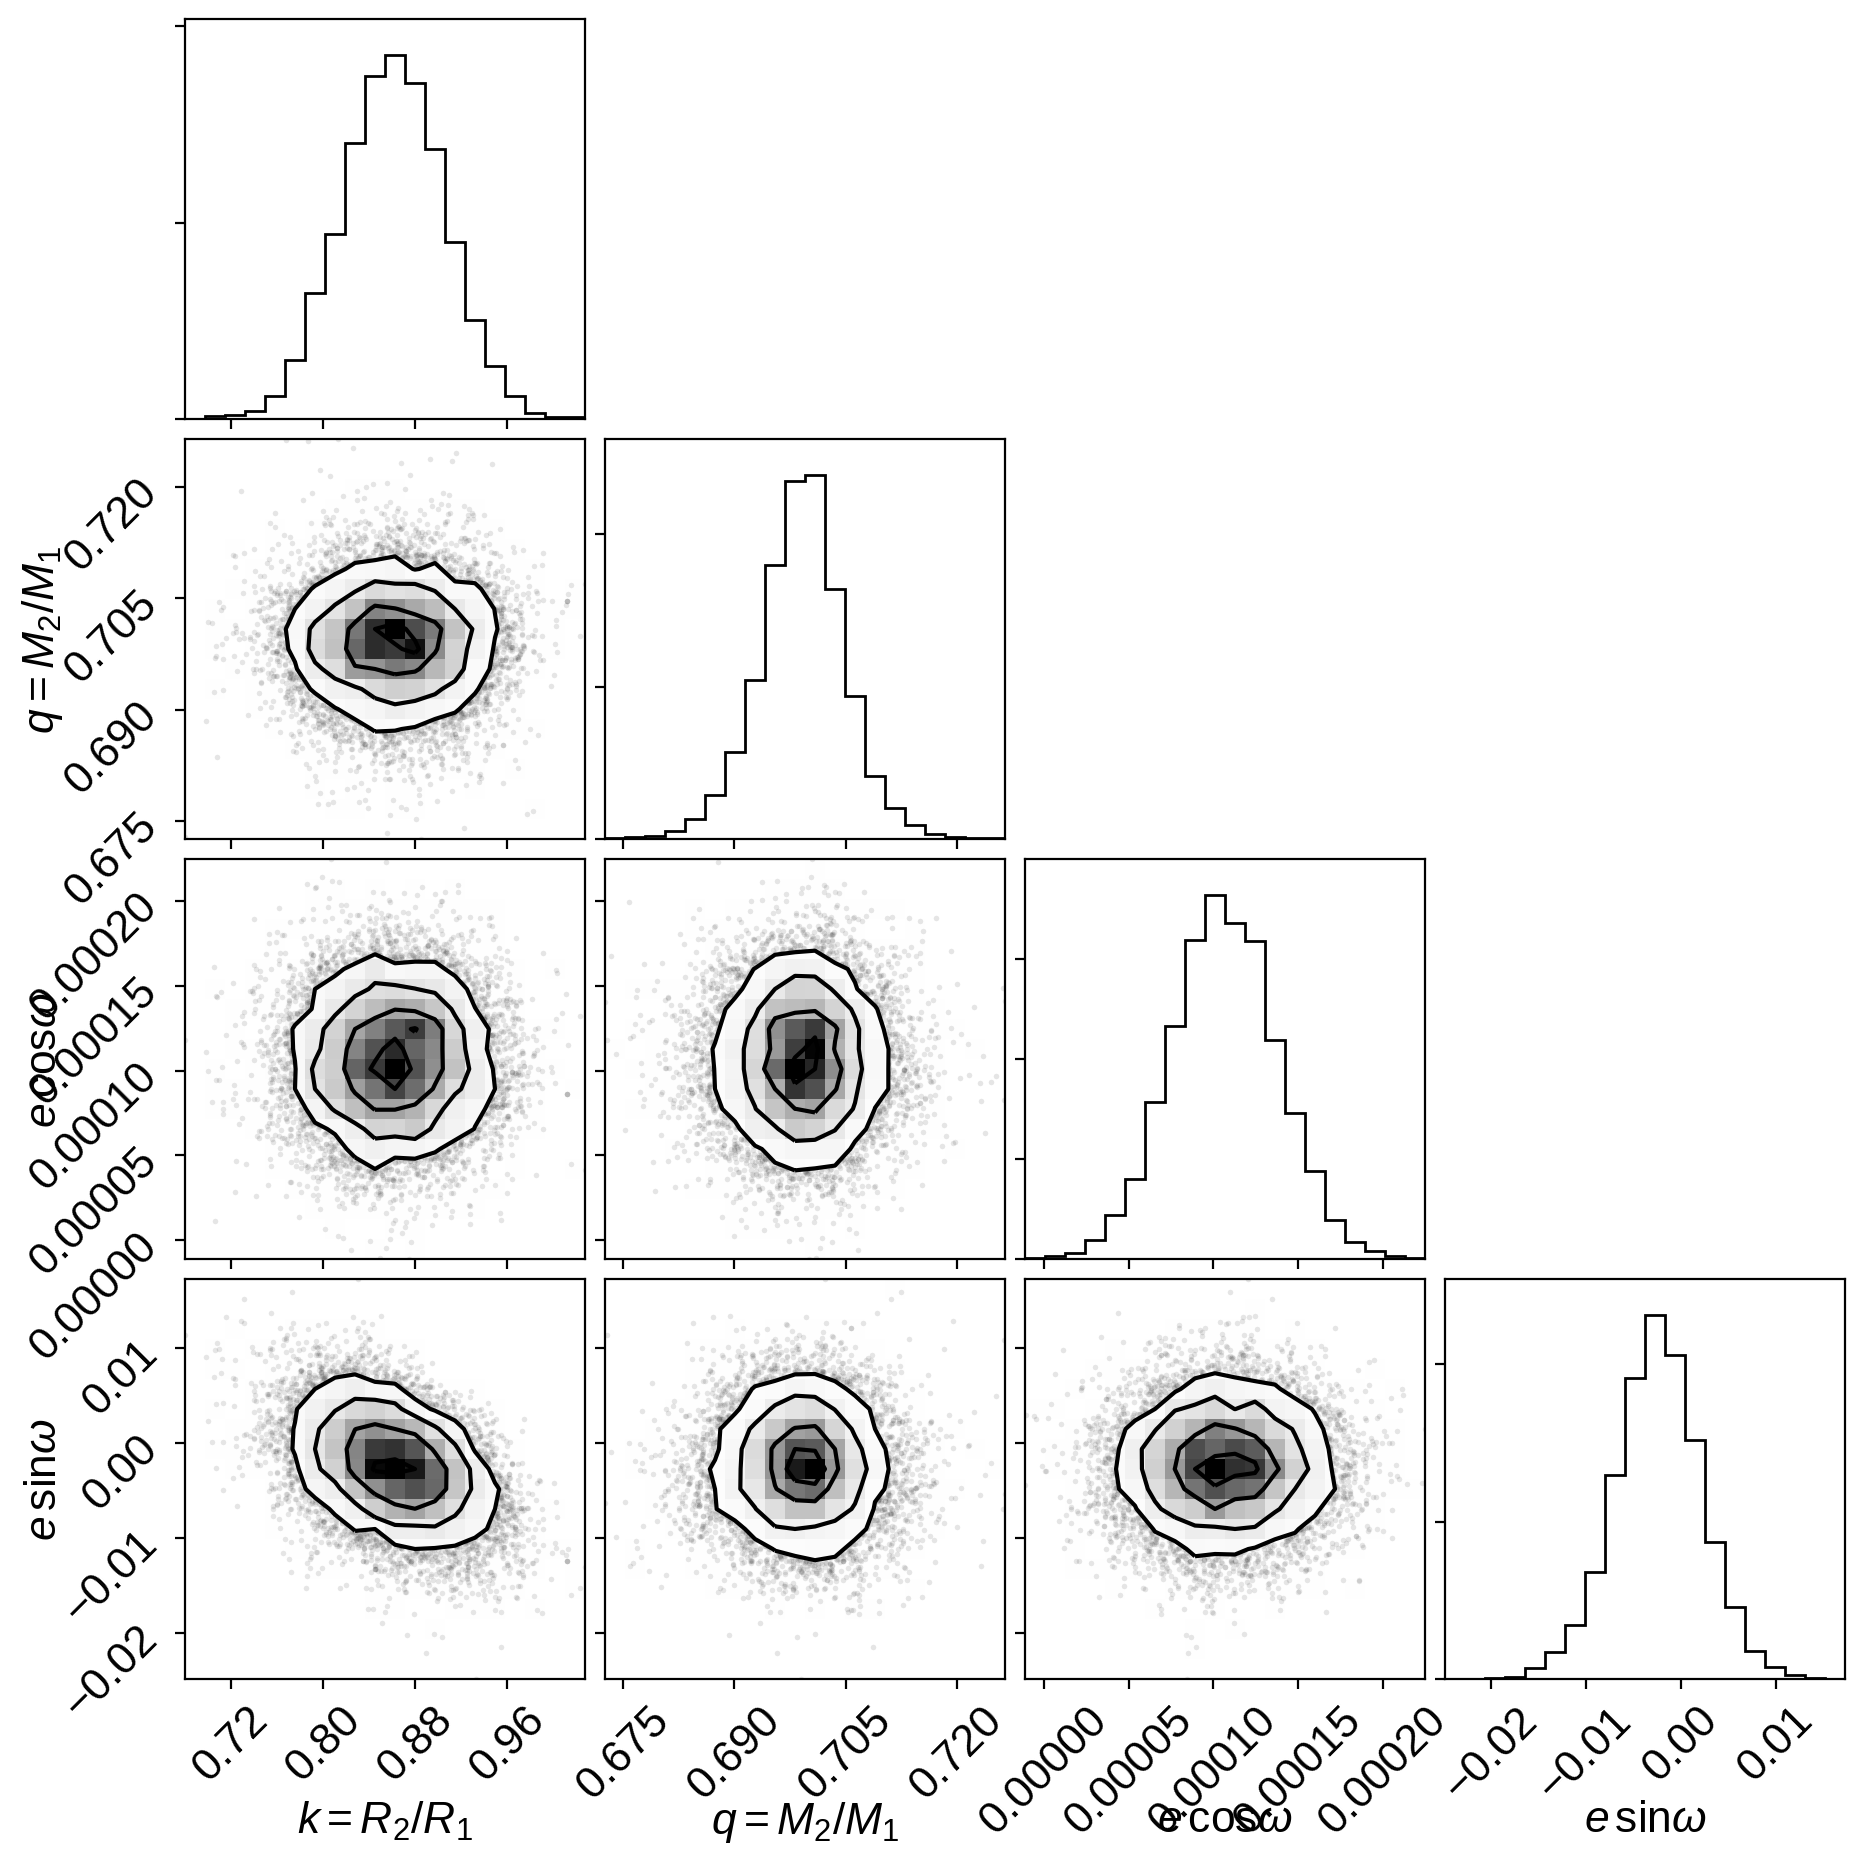

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["k", "q", "ecs"])
_ = corner.corner(
    samples,
    labels=["$k = R_2 / R_1$", "$q = M_2 / M_1$", "$e\,\cos\omega$", "$e\,\sin\omega$"],
)

And then we can look at the physical properties of the stars in the system.
In this figure, we're comparing to the results from [David+ (2016)](https://arxiv.org/abs/1602.01901) (shown as blue crosshairs).
The orange contours in this figure show the results transformed to a uniform prior on eccentricity as discussed below.
These contours are provided to demonstrate (qualitatively) that these inferences are not sensitive to the choice of prior.

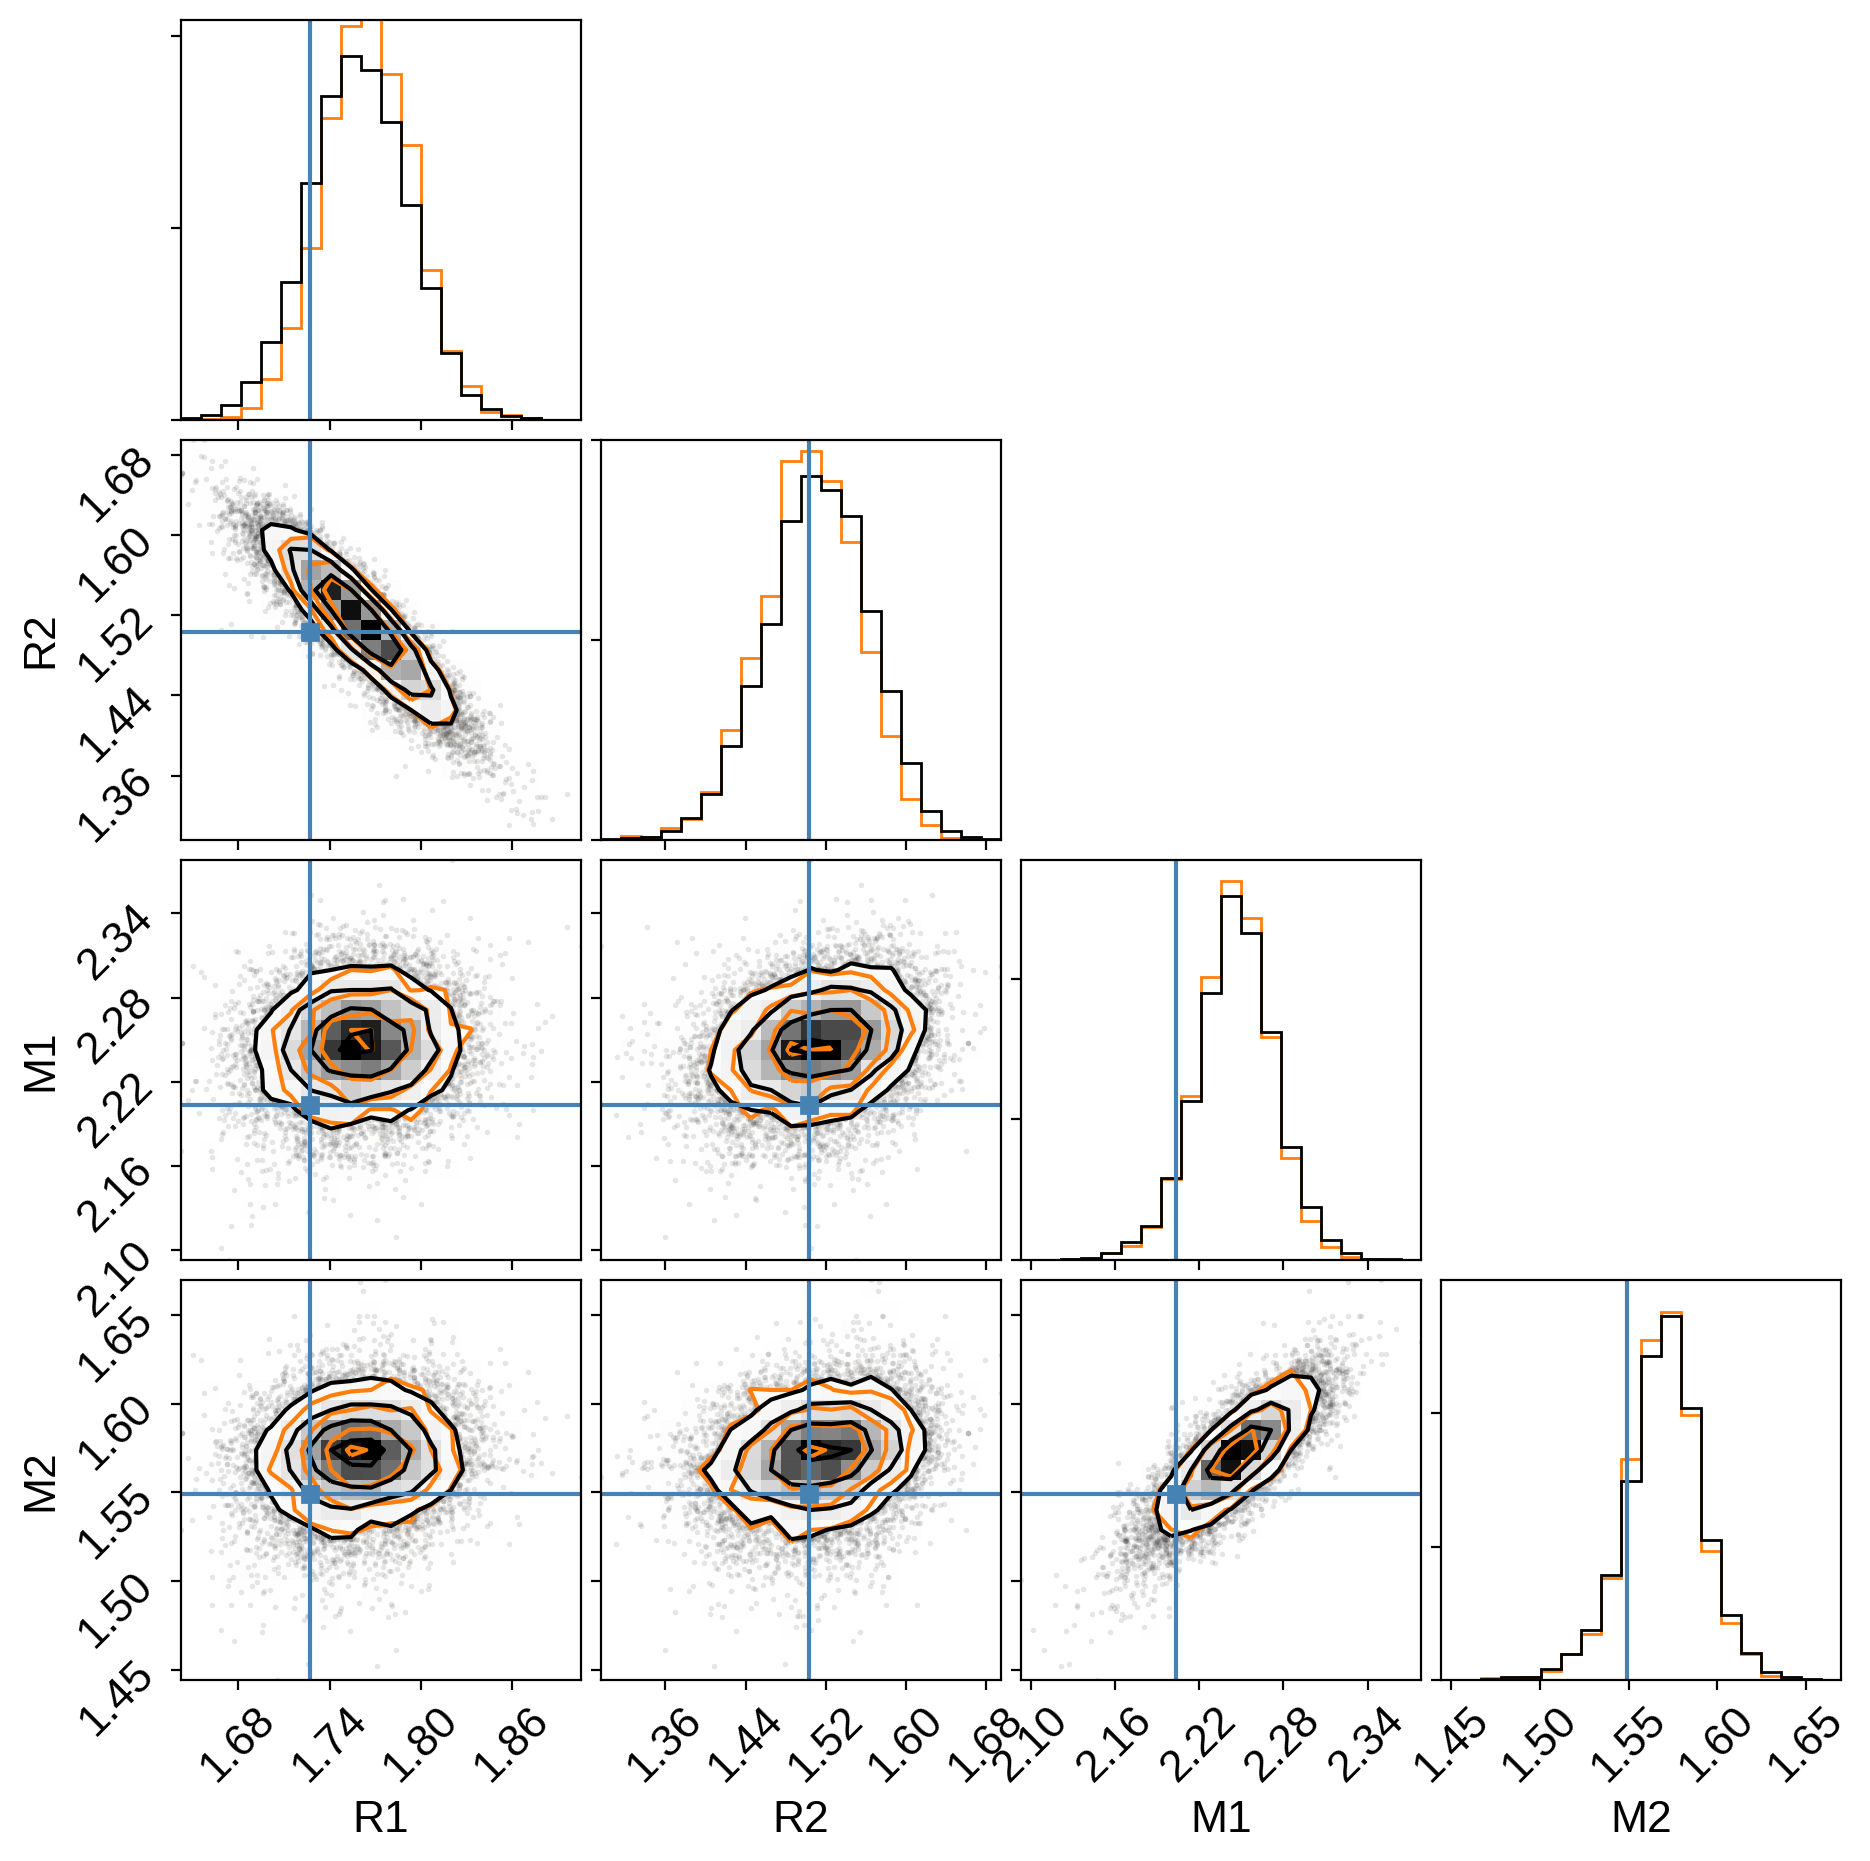

In [12]:
samples = pm.trace_to_dataframe(trace, varnames=["R1", "R2", "M1", "M2"])
weights = 1.0 / trace["ecc"]
weights *= len(weights) / np.sum(weights)
fig = corner.corner(samples, weights=weights, plot_datapoints=False, color="C1")
_ = corner.corner(samples, truths=[1.727, 1.503, 2.203, 1.5488], fig=fig)

## A note about eccentricities

If you looked closely at the model defined above, you might have noticed that we chose a slightly odd eccentricity prior: $p(e) \propto e$.
This is implied by sampling with $e\,\cos\omega$ and $e\,\sin\omega$ as the parameters, as has been discussed many times in the literature.
There are many options for correcting for this prior and instead assuming a uniform prior on eccentricity (for example, sampling with $\sqrt{e}\,\cos\omega$ and $\sqrt{e}\,\sin\omega$ as the parameters), but you'll find much worse sampling performance for this problem if you try any of these options (trust us, we tried!) because the geometry of the posterior surface becomes much less suitable for the sampling algorithm in PyMC3.
Instead, we can re-weight the samples after running the MCMC to see how the results change under the new prior.
Most of the parameter inferences are unaffected by this change (because the data are very constraining!), but the inferred eccentricity (and especially $e\,\sin\omega$) will depend on this choice.
The following plots show how these parameter inferences are affected.
Note, especially, how the shape of the $e\,\sin\omega$ density changes.

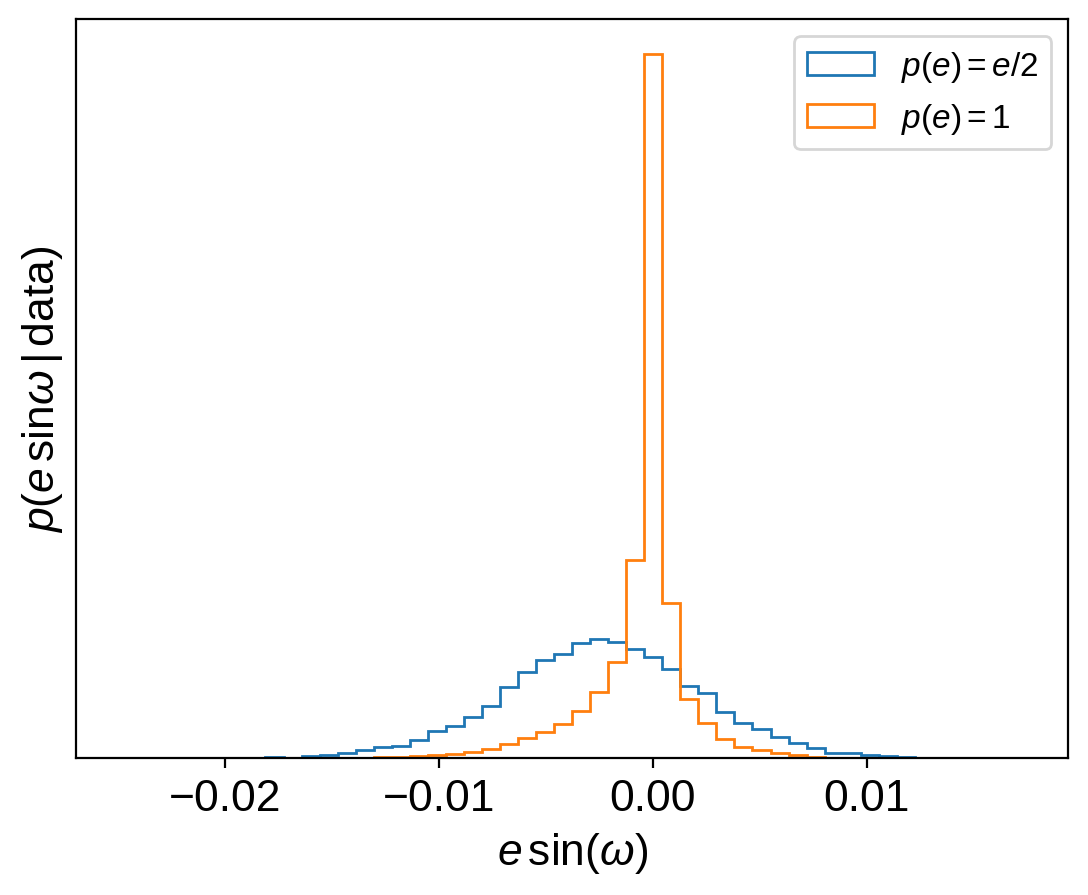

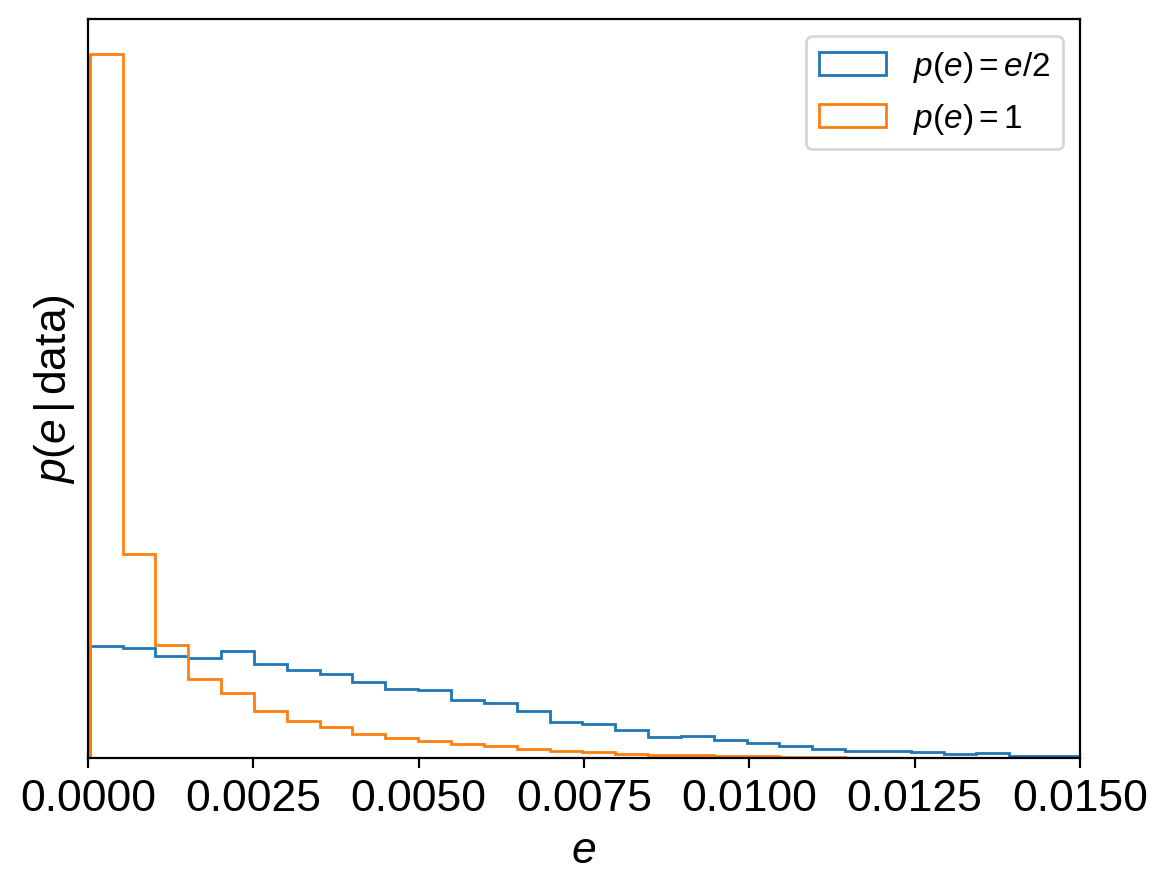

In [13]:
plt.hist(
    trace["ecc"] * np.sin(trace["omega"]),
    50,
    density=True,
    histtype="step",
    label="$p(e) = e / 2$",
)
plt.hist(
    trace["ecc"] * np.sin(trace["omega"]),
    50,
    density=True,
    histtype="step",
    weights=1.0 / trace["ecc"],
    label="$p(e) = 1$",
)
plt.xlabel("$e\,\sin(\omega)$")
plt.ylabel("$p(e\,\sin\omega\,|\,\mathrm{data})$")
plt.yticks([])
plt.legend(fontsize=12)

plt.figure()
plt.hist(trace["ecc"], 50, density=True, histtype="step", label="$p(e) = e / 2$")
plt.hist(
    trace["ecc"],
    50,
    density=True,
    histtype="step",
    weights=1.0 / trace["ecc"],
    label="$p(e) = 1$",
)
plt.xlabel("$e$")
plt.ylabel("$p(e\,|\,\mathrm{data})$")
plt.yticks([])
plt.xlim(0, 0.015)
_ = plt.legend(fontsize=12)

We can then use the `corner.quantile` function to compute summary statistics of the weighted samples as follows.
For example, here how to compute the 90% posterior upper limit for the eccentricity:

In [14]:
weights = 1.0 / trace["ecc"]
print(
    "for p(e) = e/2: p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(trace["ecc"], [0.9])[0]
    )
)
print(
    "for p(e) = 1:   p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(trace["ecc"], [0.9], weights=weights)[0]
    )
)

for p(e) = e/2: p(e < x) = 0.9 -> x = 0.00851
for p(e) = 1:   p(e < x) = 0.9 -> x = 0.00389


Or, the posterior mean and variance for the radius of the primary:

In [15]:
samples = trace["R1"]

print(
    "for p(e) = e/2: R1 = {0:.3f} ± {1:.3f}".format(np.mean(samples), np.std(samples))
)

mean = np.sum(weights * samples) / np.sum(weights)
sigma = np.sqrt(np.sum(weights * (samples - mean) ** 2) / np.sum(weights))
print("for p(e) = 1:   R1 = {0:.3f} ± {1:.3f}".format(mean, sigma))

for p(e) = e/2: R1 = 1.759 ± 0.033
for p(e) = 1:   R1 = 1.766 ± 0.029


As you can see (and as one would hope) this choice of prior does not significantly change our inference of the primary radius.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
